# lfp_synchrony_phase_locking.ipynb

In [3]:
import sys
import os
import glob
from time import time
from collections import OrderedDict
from importlib import reload
from glob import glob

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'small'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
import neurodsp
from ptsa.data.TimeSeriesX import TimeSeries 

sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
import data_io as dio
import array_operations as aop
import spectral_processing as spp
import manning_utils
import manning_analysis
import phase_locking
import lfp_synchrony
from eeg_plotting import plot_trace, plot_trace2

In [5]:
import itertools
import statsmodels.api as sm
import astropy.stats.circstats as circstats
import pycircstat
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import gc
import random

In [9]:
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c]]
cmap = sns.palettes.blend_palette((colors[0], 
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[45],
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[55],
                                   colors[1]), 101)

In [10]:
sampling_rate = 500
freqs = np.logspace(np.log10(0.5), np.log10(16), 16)
rois = ['hpc', 'amy', 'ec', 'phg', 'ctx']

In [11]:
# Get session info.
subj_df = phase_locking.get_subj_df()
subj_df.insert(4, 'chan_ind', subj_df.chan.apply(lambda x: int(x)-1))

In [12]:
sessions1 = ['U387_ses3', 'U369_env1', 'U372_ses2', 'U390_ses3', 
             'U369_env2', 'U373_ses1', 'U387_ses1', 'U380_ses2',
             'U393_ses2', 'U395_ses2', 'U384_ses3', 'U385_ses4', 
             'U371_env2', 'U371_env3']

sessions2 = [sub for sub in subj_df.subj_sess.unique().tolist() 
             if sub not in (sessions1 + ['U367_env2', 'U386_ses1', 'U386_ses2'])]

subs1 = [s.split('_')[0] for s in sessions1]
sessions_test = [s for s in sessions2 if s.split('_')[0] not in subs1]

sessions_all = sessions1 + sessions2 + ['U386_ses1', 'U386_ses2']

print('sessions1: {} \nsessions2: {} \nsessions_test: {} \nsessions_all: {} \nsessions_available: {}'
      .format(len(sessions1), len(sessions2), len(sessions_test), len(sessions_all), len(subj_df.subj_sess.unique())))

sessions1: 14 
sessions2: 29 
sessions_test: 12 
sessions_all: 45 
sessions_available: 46


In [9]:
# Save unit-to-channel and unit-to-region DataFrames 
# (minus any phase-locking calculations).
start_time = time()

for subj_sess in subj_df.subj_sess.unique():
    pl_file = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/metadata',
                           '{}_unit_to_lfp-channel_pairs_df.pkl'.format(subj_sess))
    if not os.path.exists(pl_file):
        try:
            _, _ = phase_locking.get_cross_electrode_unit_lfp_pairs(subj_sess, save_outputs=True)
        except:
            print('{} has no HPC electrodes'.format(subj_sess))
        
print('Done in {:.2f} secs'.format(time() - start_time))

Done in 12.47 secs


In [13]:
# Load the unit-to-region dataframe.
u2r_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/metadata',
                             '*_unit_to_lfp-region_pairs_df.pkl'))
print('Found {} files'.format(len(u2r_files)))

u2r_df = dio.open_pickle(u2r_files[0])
for f in u2r_files[1:]:
    u2r_df = u2r_df.append(dio.open_pickle(f))
u2r_df.reset_index(drop=True, inplace=True)

print(u2r_df.shape)

Found 46 files
(14498, 26)


In [14]:
subj_sess = 'U369_env1'
subj_sess = 'U395_ses1'
sampling_rate = 2000
resampling_rate = 500
notch_freqs = [60, 120]
interp_spikes = False
ms_before = 2
ms_after = 4

zscore_lfp = True
morlet_width = 5

In [411]:
# Load all *OLD* cross-electrode files into a single dataframe.
upl_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking', 
                              '*_crosselec_phaselock_byunit_df_notch60-120_nospikeinterp_phase-morlet5_timelag-2to2sec-step10ms_1000bootstraps_16freqs-0.5-to-16.0Hz.pkl'))
print('Found {} files'.format(len(upl_files)))

upl_df = dio.open_pickle(upl_files[0])
for f in upl_files[1:]:
    upl_df = upl_df.append(dio.open_pickle(f))
upl_df.reset_index(drop=True, inplace=True)
upl_df['unit_roi2'] = upl_df.unit_roi2.astype('category').cat.reorder_categories([x for x in rois if x in upl_df.unit_roi2.tolist()], ordered=True)
upl_df['lfp_roi2'] = upl_df.lfp_roi2.astype('category').cat.reorder_categories([x for x in rois if x in upl_df.lfp_roi2.tolist()], ordered=True)
upl_df['unit_hemroi'] = upl_df['unit_hem'] + upl_df['unit_roi']
upl_df['lfp_hemroi'] = upl_df['lfp_hem'] + upl_df['lfp_roi']
upl_df.insert(2, 'unit', upl_df.subj_sess_unit.apply(lambda x: int(x.split('_')[-1])))
upl_df_ = upl_df.copy()
upl_df = upl_df.loc[(upl_df.unit_is_hpc==False) & (upl_df.lfp_is_hpc==True)]
upl_df.reset_index(drop=True, inplace=True)

Found 13 files


In [15]:
# Load spikes.

print(subj_sess)
spikes, fr_df, clus_to_chan, chan_to_clus = phase_locking.load_spikes(subj_sess)
units = fr_df.clus.tolist()

# Load the raw LFP.
lfp_raw, lfp_preproc = manning_analysis.process_lfp(subj_sess, 
                                                    subj_df=subj_df, 
                                                    sampling_rate=sampling_rate,
                                                    resampling_rate=0,
                                                    notch_freqs=notch_freqs,
                                                    interpolate=interp_spikes,
                                                    session_spikes=spikes)
del lfp_raw, spikes

# Get phase.
# phase = manning_analysis.run_morlet(lfp_preproc, 
#                                     freqs=freqs, 
#                                     width=morlet_width, 
#                                     output=['phase'],
#                                     savedir=False, 
#                                     verbose=False)
# phase = phase.squeeze().data

U395_ses1


In [1458]:
# Generate bootstrap distributions for each recording session.
for subj_sess in subj_df.subj_sess.unique():
    _ = phase_locking.generate_bootstrap_shifts(subj_sess, sampling_rate=500, time_win=5, 
                                                n_bootstraps=5000, save_outputs=True,
                                                output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/bootstrap_shifts')

In [228]:
# Generate bootstrap distributions for each recording session.
for subj_sess in subj_df.subj_sess.unique():
    _ = phase_locking.generate_bootstrap_timepoints(subj_sess, 
                                                    sampling_rate=500,
                                                    cut=2500,
                                                    n_bootstraps=500, 
                                                    save_outputs=True,
                                                    output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/bootstrap_shifts')

In [7]:
# Generate bootstrap distributions for each recording session.
for subj_sess in subj_df.subj_sess.unique():
    _ = phase_locking.generate_bootstrap_shifts(subj_sess, sampling_rate=2000, time_win=2, 
                                                n_bootstraps=1000, save_outputs=True,
                                                output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/bootstrap_shifts')

In [103]:
np.unique([os.path.basename(x)[6:15] for x in files_to_run], return_counts=True)

(array(['U371_env3', 'U372_ses1', 'U380_ses3', 'U384_ses2'], dtype='<U9'),
 array([225, 146,  46, 545]))

In [102]:
# Get a list of all files we still need to make phase vectors for.
sessions = sessions_all

chans_by_sub = subj_df.groupby('subj_sess').size().to_dict()
sampling_rate = 2000
phase_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/wavelet/phase'

phase_vec_files = []
for subj_sess in sessions:
    for iChan in range(chans_by_sub[subj_sess]):
        for iFreq in range(len(freqs)):
            fpath = os.path.join(phase_dir, 'phase-{}-iChan{}-iFreq{}-2000Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_90.5Hz.pkl'.format(subj_sess, iChan, iFreq))
            phase_vec_files.append(fpath)
files_to_run = [f for f in phase_vec_files if not os.path.exists(f)]
print('{}/{} unsaved phase vector files'.format(len(files_to_run), len(phase_vec_files)))
#phase_locking.save_phase_vectors('U395_ses2')

962/45184 unsaved phase vector files


In [86]:
from time import sleep

In [ ]:
start_time = time()
for subj_sess in ['U371_env1', 'U371_env3', 'U372_ses1', 'U380_ses3', 'U384_ses2', 'U390_ses2', 'U396_ses2']:
    print('Go to sleep little baby')
    sleep(360)
    phase_locking.save_phase_vectors(subj_sess, overwrite=False)
    print('{}: {:.2f} secs'.format(subj_sess, time() - start_time))

Go to sleep little baby


In [66]:
u2r_file = '{}_unit_to_lfp-region_pairs_df.pkl'
u2r_path = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/metadata', u2r_file.format(sessions[0]))
u2r_df = dio.open_pickle(u2r_path)
for subj_sess in sessions:
    u2r_path = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/metadata', u2r_file.format(subj_sess))
    u2r_df = u2r_df.append(dio.open_pickle(u2r_path))
u2r_df.reset_index(drop=True, inplace=True)
print('{} unit to region pairs'.format(len(u2r_df)))

14234 unit to region pairs


***
Run save_phase_vectors_parallel() 
in parallel_in_python3.ipynb
to save phase vectors for each channel at each frequency, for all recording sessions
***

In [99]:
# Get a list of all unit-to-region files we still need to run phase-locking stats for.
pl_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region'
fname = 'phase_locking_stats-{}-unit_{}-lfp_{}-{}Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_16.0Hz.pkl'

count_complete = 0
incomplete_inds = []
for index, row in u2r_df.query("(subj_sess=={})".format(sessions_all)).iterrows():
    fpath = os.path.join(pl_dir, fname.format(row.subj_sess, row.unit, row.lfp_hemroi, sampling_rate))
    if os.path.exists(fpath):
        count_complete += 1
    else:
        incomplete_inds.append(index)

print('{}/{} unsaved phase-locking files'.format(len(incomplete_inds), count_complete+len(incomplete_inds)))

0/13186 unsaved phase-locking files


***
Run calc_phase_locking_mrl_morlet_unit_to_region_parallel() 
in parallel_in_python3.ipynb 
to get phase-locking stats for all unit-to-region pairs in parallel
***

In [15]:
# Load phase-locking stats.
start_time = time()

pl_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region'
fname = 'phase_locking_stats-{}-unit_{}-lfp_{}-{}Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_16.0Hz.pkl'
complete_count = 0
incomplete_inds = []
first_row = True
for index, row in u2r_df.query("(subj_sess=={})".format(sessions_all)).iterrows():
    fpath = os.path.join(pl_dir, fname.format(row.subj_sess, row.unit, row.lfp_hemroi, sampling_rate))
    if os.path.exists(fpath):
        complete_count += 1
        if first_row:
            pl_df = pd.DataFrame(dio.open_pickle(fpath)).T
            first_row = False
        else:
            pl_df = pl_df.append(dio.open_pickle(fpath))
    else:
        incomplete_inds.append(index)
pl_df.reset_index(drop=True, inplace=True)
print('pl_df: {}'.format(pl_df.shape))
print('{}/{} files not found\n'.format(len(incomplete_inds), complete_count+len(incomplete_inds)))

print('Done in {:.2f} secs'.format(time() - start_time))

pl_df: (13186, 52)
0/13186 files not found

Done in 1158.70 secs


In [102]:
# # Load phase-locking stats.
# start_time = time()

# pl_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region'
# pl_files = glob(os.path.join(pl_dir, 'phase_locking_stats*.pkl'))
# pl_df = pd.DataFrame(dio.open_pickle(pl_files[0])).T
# for f in pl_files[1:]:
#     pl_df = pl_df.append(dio.open_pickle(f))
# pl_df.reset_index(drop=True, inplace=True)

# print('Done in {:.2f} secs'.format(time() - start_time))

In [17]:
# Save phase-locking stats as a single DataFrame
dio.save_pickle(pl_df, os.path.join(pl_dir, 'all_phase_locking_stats-{}_unit_to_region_pairs-500Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_16.0Hz.pkl'.format(len(pl_df))))

Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region/all_phase_locking_stats-13186_unit_to_region_pairs-500Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_16.0Hz.pkl


In [12]:
# Load phase-locking stats as a single DataFrame
pl_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region'
pl_df = dio.open_pickle(os.path.join(pl_dir, 'all_phase_locking_stats-13186_unit_to_region_pairs-500Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_16.0Hz.pkl'))

In [13]:
map_dtypes = {'unit_nspikes': np.uint32,
              'unit_fr': np.float64,
              'lfp_is_hpc': np.bool,
              'same_chan': np.bool,
              'same_hemroi': np.bool,
              'same_hem': np.bool,
              'same_roi': np.bool,
              'both_hpc': np.bool,
              'same_roi2': np.bool,
              'locked_freq_ind': np.uint8,
              'locked_mrl': np.float64,
              'bs_ind': np.uint16,
              'bs_pval': np.float64,
              'sig': np.bool,
              'tl_locked_time_ind': np.uint16,
              'tl_locked_time': np.float64,
              'tl_locked_time_mrl': np.float64,
              'locked_freq_ind_z': np.uint8,
              'locked_mrl_z': np.float64,
              'bs_ind_z': np.uint16,
              'bs_pval_z': np.float64,
              'sig_z': np.bool,
              'tl_locked_time_ind_z': np.uint16,
              'tl_locked_time_z': np.float64,
              'tl_locked_time_mrl_z': np.float64}
for col, dtype in map_dtypes.items():
    pl_df[col] = pl_df[col].astype(dtype)
print(pl_df.shape)

(13186, 52)


In [14]:
pl_df['bs_mrls_z'] = pl_df.bs_mrls.apply(lambda x: stats.zscore(x, axis=-1))
1+1

2

In [15]:
# FDR correction
# Tests for phase-locking at any frequency:
# 1) For each connection, the maximum observed Z-score (across frequencies) is compared
#    against the surrogate distribution of maximum Z-scores; this gives an initial P-value
# 2) P-values for all connections for a given edge type are corrected to set 
#    a 5% false discovery rate
def bootstrap_p(x):
    """Return a p-value.
    
    For each connection, the maximum observed Z-score (across frequencies) 
    is compared against the surrogate distribution of maximum Z-scores.
    """
    obs = x.mrls_z # n_freq vec
    null = x.bs_mrls_z # n_freq x n_boot vec
    max_obs = np.max(obs)
    max_null = np.max(null, axis=0)
    n_bootstraps = len(max_null)
    pval = (1 + np.sum(max_null >= max_obs)) / (1 + n_bootstraps)
    return pval

pl_df['sig_z_fdr'] = False

for edge_type in ['ctx-local', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx', 'ctx-hpc']:
    pvals_in = np.array(pl_df.loc[(pl_df.edge==edge_type)].apply(lambda x: bootstrap_p(x), axis=1).tolist())
    output = sm.stats.multipletests(pvals_in, alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)
    sig_out = list(output[0])
    pvals_out = output[1]
    pl_df.loc[(pl_df.edge==edge_type), 'sig_z_fdr'] = sig_out

In [16]:
# On the fly Dice coefficient
((2 * np.sum(np.array(pl_df.sig_z.tolist()) * np.array(pl_df.sig_z_fdr.tolist())))
 / (np.sum(pl_df.sig_z) + np.sum(pl_df.sig_z_fdr)))

0.8593031875463306

## Analyze phase-locking results

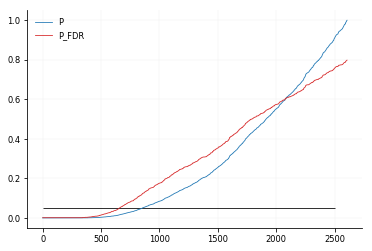

In [114]:
plt.plot(np.sort(pvals_in[pvals_in<1]), label='P')
plt.plot(np.sort(pvals_out[pvals_out<1]), label='P_FDR')
plt.hlines(0.05, 0, 2500)
plt.legend()

In [36]:
# FDR correction OLD
## corrects p-values at the locked frequency (for each edge type)

n_bootstraps = 5000
pl_df['sig_z_fdr'] = False

for edge_type in ['ctx-local', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx', 'ctx-hpc']:
    pvals_in = np.array(pl_df.loc[(pl_df.edge==edge_type), 'bs_pval_z'].tolist())
    output = sm.stats.multipletests(pvals_in, alpha=0.05/len(freqs), method='fdr_tsbky', is_sorted=False, returnsorted=False)
    sig_out = list(output[0])
    pvals_out = output[1]
    pl_df.loc[(pl_df.edge==edge_type), 'sig_z_fdr'] = sig_out

In [14]:
# FDR correction OLD
## corrects p-values across all frequencies at once (for each edge type)

n_bootstraps = 5000
pl_df['sig_z_fdr'] = False

for edge_type in ['ctx-local', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx', 'ctx-hpc']:
    pvals_in = np.array(pl_df.loc[(pl_df.edge==edge_type), :]
                        .apply(lambda x: list(  (1 + np.sum(x.bs_mrls_z >= np.expand_dims(x.mrls_z, axis=-1), axis=-1)) 
                                              / (1 + n_bootstraps)), axis=1).tolist())
    freq_inds = pl_df.loc[(pl_df.edge==edge_type), 'locked_freq_ind_z'].tolist()
    shp = pvals_in.shape
    sig_out = [x[freq_inds[i]] for i, x in enumerate(list(sm.stats.multipletests(pvals_in.flatten(), alpha=0.05/len(freqs), method='fdr_tsbky', 
                                                                                 is_sorted=False, returnsorted=False)[0].reshape(shp)))]
    pvals_out = [x[freq_inds[i]] for i, x in enumerate(list(sm.stats.multipletests(pvals_in.flatten(), alpha=0.05/len(freqs), method='fdr_tsbky', 
                                                                                   is_sorted=False, returnsorted=False)[1].reshape(shp)))]
    pl_df.loc[(pl_df.edge==edge_type), 'sig_z_fdr'] = sig_out

In [303]:
# Recording session duration (in mins)?
np.sort(subj_df.groupby('subj_sess').sess_duration.apply(lambda x: np.round(np.mean(x)/60, 1)).tolist())

array([13.8, 14.2, 15.2, 18.7, 19. , 19.1, 19.6, 19.6, 19.8, 20. , 20.1,
       20.2, 20.5, 20.5, 20.8, 21.1, 21.3, 21.4, 22. , 22. , 22.3, 22.7,
       24.1, 24.9, 25.1, 25.3, 25.7, 25.8, 26.1, 26.8, 27.3, 27.6, 27.8,
       27.9, 28.4, 28.8, 29. , 30.7, 30.9, 32.7, 34.7, 37. , 37.1, 38.5,
       41.3, 42.7])

In [227]:
#pl_df.loc[pl_df.unit_roi2=='ac', 'unit_roi2'] = 'ctx'
pl_df['locked_low_theta_z'] = pl_df.locked_freq_ind_z.apply(lambda x: (x>=6) & (x<10))
pl_df.query("(edge=='ctx-hpc')").groupby('unit_roi2').size()

unit_roi2
ac     205
amy    731
ctx    551
ec     472
ofc    330
phg    318
dtype: int64

In [41]:
s = pl_df.query("(edge=='ctx-hpc')").subj_sess.unique().tolist()
print('{} subjects and {} recording sessions'.format(len(np.unique([x.split('_')[0] for x in s])), len(s)))

print('{} neurons and {} HPC regions'.format(len(pl_df.query("(edge=='ctx-hpc')").groupby(['subj_sess', 'unit'])), 
                                             len(pl_df.query("(edge=='ctx-hpc')").groupby(['subj_sess', 'lfp_hemroi']))))

print('{} neurons and {} HPC regions (ipsi only)'.format(len(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").groupby(['subj_sess', 'unit'])), 
                                                         len(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").groupby(['subj_sess', 'lfp_hemroi']))))

s = pl_df.query("(edge=='ctx-hpc')").groupby(['subj_sess']).unit.apply(lambda x: len(np.unique(x)))
print('{:.1f} +/- {:.1f}; range ({}, {}) neurons per subject'.format(s.mean(), s.std(), s.min(), s.max()))

s = pl_df.query("(edge=='ctx-hpc')").groupby(['subj_sess']).lfp_hemroi.apply(lambda x: len(np.unique(x)))
print('{:.1f} +/- {:.1f} HPC regions per subject'.format(s.mean(), s.std()))

18 subjects and 43 recording sessions
1348 neurons and 86 HPC regions
1250 neurons and 82 HPC regions (ipsi only)
31.3 +/- 16.3; range (4, 60) neurons per subject
2.0 +/- 0.5 HPC regions per subject


In [114]:
pl_df.query("(edge=='ctx-hpc')").groupby('same_hem').agg({'unit': len, 'sig_z_fdr': np.mean})

unit  sig_z_fdr
same_hem                 
False     1240   0.183871
True      1367   0.315289

In [42]:
sessions = pl_df.query("(edge=='ctx-hpc')").subj_sess.unique().tolist()
print('{} sessions'.format(len(sessions)))
for subj_sess in sessions:
    nsig = pl_df.query("(edge=='ctx-hpc') & (subj_sess=='{}')".format(subj_sess)).sig_z_fdr.sum()
    n = len(pl_df.query("(edge=='ctx-hpc') & (subj_sess=='{}')".format(subj_sess)))
    print('{}: {}/{} sig connections'.format(subj_sess, nsig, n))

43 sessions
U369_env2: 5/66 sig connections
U379_ses1: 3/118 sig connections
U380_ses1a: 15/114 sig connections
U381_ses1: 20/84 sig connections
U384_ses3: 8/84 sig connections
U390_ses1: 2/8 sig connections
U394_ses3: 3/28 sig connections
U395_ses2: 15/52 sig connections
U395_ses3: 8/30 sig connections
U369_env1: 23/102 sig connections
U370_env1: 12/48 sig connections
U371_env1: 55/129 sig connections
U371_env2: 41/93 sig connections
U371_env3: 40/144 sig connections
U372_ses1: 13/36 sig connections
U372_ses2: 14/54 sig connections
U373_ses1: 3/49 sig connections
U373_ses2: 10/50 sig connections
U373_ses3: 7/53 sig connections
U374_ses1: 3/39 sig connections
U374_ses2: 3/36 sig connections
U380_ses2: 13/106 sig connections
U380_ses3: 14/76 sig connections
U381_ses2: 28/94 sig connections
U381_ses3: 29/120 sig connections
U384_ses1: 20/96 sig connections
U384_ses2: 16/90 sig connections
U387_ses1: 17/36 sig connections
U387_ses2: 19/28 sig connections
U387_ses3: 23/36 sig connections
U

In [229]:
sessions = pl_df.query("(edge=='ctx-hpc')").subj_sess.unique().tolist()
print('{} sessions'.format(len(sessions)))
for subj_sess in sessions:
    nsig = pl_df.query("(edge=='ctx-hpc') & (subj_sess=='{}')".format(subj_sess)).sig_z.sum()
    n = len(pl_df.query("(edge=='ctx-hpc') & (subj_sess=='{}')".format(subj_sess)))
    pval = stats.binom_test(nsig, n, 0.05, 'greater')
    print('{}: {}/{} sig connections, p={:.4f}, {}, {}'.format(subj_sess, nsig, n, pval, 'SIG' if pval<0.05 else 'NS', 
                                                           'SIG' if pval<(0.05/len(sessions)) else 'NS'))

43 sessions
U369_env2: 11/66 sig connections, p=0.0004, SIG, SIG
U379_ses1: 10/118 sig connections, p=0.0720, NS, NS
U380_ses1a: 23/114 sig connections, p=0.0000, SIG, SIG
U381_ses1: 28/84 sig connections, p=0.0000, SIG, SIG
U384_ses3: 11/84 sig connections, p=0.0031, SIG, NS
U390_ses1: 2/8 sig connections, p=0.0572, NS, NS
U394_ses3: 4/28 sig connections, p=0.0491, SIG, NS
U395_ses2: 18/52 sig connections, p=0.0000, SIG, SIG
U395_ses3: 11/30 sig connections, p=0.0000, SIG, SIG
U369_env1: 28/102 sig connections, p=0.0000, SIG, SIG
U370_env1: 17/48 sig connections, p=0.0000, SIG, SIG
U371_env1: 61/129 sig connections, p=0.0000, SIG, SIG
U371_env2: 48/93 sig connections, p=0.0000, SIG, SIG
U371_env3: 49/144 sig connections, p=0.0000, SIG, SIG
U372_ses1: 15/36 sig connections, p=0.0000, SIG, SIG
U372_ses2: 19/54 sig connections, p=0.0000, SIG, SIG
U373_ses1: 10/49 sig connections, p=0.0001, SIG, SIG
U373_ses2: 19/50 sig connections, p=0.0000, SIG, SIG
U373_ses3: 11/53 sig connections, p=0

In [230]:
rois = pl_df.query("(edge=='ctx-hpc')").unit_roi2.unique().tolist()
print('{} ROIs'.format(len(rois)))
for roi in rois:
    nsig = pl_df.query("(edge=='ctx-hpc') & (unit_roi2=='{}')".format(roi)).sig_z.sum()
    n = len(pl_df.query("(edge=='ctx-hpc') & (unit_roi2=='{}')".format(roi)))
    pval = stats.binom_test(nsig, n, 0.05, 'greater')
    print('{}: {}/{} ({:.1f}%) sig connections, p={:.4f}, {}, {}'.format(roi, nsig, n, 100*nsig/n, pval, 'SIG' if pval<0.05 else 'NS', 
                                                                     'SIG' if pval<(0.05/len(rois)) else 'NS'))

6 ROIs
amy: 353/731 (48.3%) sig connections, p=0.0000, SIG, SIG
ctx: 122/551 (22.1%) sig connections, p=0.0000, SIG, SIG
ac: 16/205 (7.8%) sig connections, p=0.0533, NS, NS
ec: 191/472 (40.5%) sig connections, p=0.0000, SIG, SIG
phg: 79/318 (24.8%) sig connections, p=0.0000, SIG, SIG
ofc: 58/330 (17.6%) sig connections, p=0.0000, SIG, SIG


In [136]:
all_frs = np.array(pl_df.groupby('subj_sess_unit').agg({'unit_fr': np.mean}).unit_fr.tolist())
np.sum(all_frs<0.5) / len(all_frs), np.mean(all_frs), np.median(all_frs)

(0.16348448687350836, 4.083140526934449, 2.0802538260522496)

In [116]:
# Ipsi- vs contralateral.
# Chi square tests for independence of proportions.
ipsi_nsig = np.sum(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").sig_z_fdr==0)
ipsi_sig = np.sum(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").sig_z_fdr==1)
contra_nsig = np.sum(pl_df.query("(edge=='ctx-hpc') & (same_hem==False)").sig_z_fdr==0)
contra_sig = np.sum(pl_df.query("(edge=='ctx-hpc') & (same_hem==False)").sig_z_fdr==1)
obs = [[ipsi_nsig, ipsi_sig], [contra_nsig, contra_sig]]
print('{}/{} ({:.1f}%) ipsilateral connections are significant'.format(ipsi_sig, (ipsi_sig+ipsi_nsig), 
                                                                       100 * (ipsi_sig / (ipsi_sig+ipsi_nsig))))
print('{}/{} ({:.1f}%) contralateral connections are significant'.format(contra_sig, (contra_sig+contra_nsig), 
                                                                         100 * (contra_sig / (contra_sig+contra_nsig))))
display(obs)
print('df = {}'.format(np.prod(np.array(np.array(obs).shape) - 1)))
print('Ipisilateral and contralateral HPC phase-locking proportions differ:', stats.chi2_contingency(obs)[:2])

431/1367 (31.5%) ipsilateral connections are significant
228/1240 (18.4%) contralateral connections are significant


[[936, 431], [1012, 228]]

df = 1
Ipisilateral and contralateral HPC phase-locking proportions differ: (58.75827216333791, 1.7828242171673938e-14)


In [120]:
np.array([np.log10(freqs)[x] for x in pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==True)").mrls_z]).shape

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
ipsi_freqs = np.array([np.log10(freqs)[x] for x in pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==True)").mrls_z])
contra_freqs = np.array([np.log10(freqs)[x] for x in pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==False)").locked_freq_ind_z])

print(len(ipsi_freqs), (10**ipsi_freqs).mean(), (10**ipsi_freqs).std())
print(len(contra_freqs), (10**contra_freqs).mean(), (10**contra_freqs).std())
print('df = {}'.format(len(ipsi_freqs) + len(contra_freqs) - 2))
print(stats.ttest_ind(ipsi_freqs, contra_freqs, equal_var=False))

In [117]:
ipsi_freqs = np.array([np.log10(freqs)[x] for x in pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==True)").locked_freq_ind_z])
contra_freqs = np.array([np.log10(freqs)[x] for x in pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==False)").locked_freq_ind_z])

print(len(ipsi_freqs), (10**ipsi_freqs).mean(), (10**ipsi_freqs).std())
print(len(contra_freqs), (10**contra_freqs).mean(), (10**contra_freqs).std())
print('df = {}'.format(len(ipsi_freqs) + len(contra_freqs) - 2))
print(stats.ttest_ind(ipsi_freqs, contra_freqs, equal_var=False))

431 3.458735447727495 2.8839968279152677
228 2.218072257756504 1.666285989193816
df = 657
Ttest_indResult(statistic=7.661646916972026, pvalue=8.62435540750614e-14)


In [ ]:
# Local > HPC phase-locking frequency
# Independent t-test
v1 = np.array([np.log10(freqs)[x] for x in pl_df.query("(edge=='ctx-local') & (sig_z==True)").locked_freq_ind_z])
v2 = np.array([np.log10(freqs)[x] for x in pl_df.query("(edge=='ctx-hpc') & (sig_z==True)").locked_freq_ind_z])
print((10**v1).mean(), (10**v1).std(), (10**v2).mean(), (10**v2).std())

print('df = {}'.format(len(v1) + len(v2) - 2))
print(stats.ttest_ind(v1, v2, equal_var=False))
print(stats.levene(v1, v2))

In [232]:
# HPC vs. local vs. intercortical phase-locking rates.
# Chi square tests for independence of proportions.
hpc_nsig = np.sum(pl_df.query("(edge=='ctx-hpc')").sig_z==0)
hpc_sig = np.sum(pl_df.query("(edge=='ctx-hpc')").sig_z==1)
local_nsig = np.sum(pl_df.query("(edge=='ctx-local')").sig_z==0)
local_sig = np.sum(pl_df.query("(edge=='ctx-local')").sig_z==1)
inter_nsig = np.sum(pl_df.query("(edge=='ctx-ctx')").sig_z==0)
inter_sig = np.sum(pl_df.query("(edge=='ctx-ctx')").sig_z==1)

print('{}/{} ({:.1f}%) HPC connections are significant'.format(hpc_sig, (hpc_sig+hpc_nsig), 
                                                               100 * (hpc_sig / (hpc_sig+hpc_nsig))))
print('{}/{} ({:.1f}%) local connections are significant'.format(local_sig, (local_sig+local_nsig), 
                                                                 100 * (local_sig / (local_sig+local_nsig))))
print('{}/{} ({:.1f}%) inter-cortical connections are significant'.format(inter_sig, (inter_sig+inter_nsig), 
                                                                            100 * (inter_sig / (inter_sig+inter_nsig))))
print('')

obs = [[hpc_nsig, hpc_sig], [local_nsig, local_sig]]
display(obs)
print('df = {}'.format(np.prod(np.array(np.array(obs).shape) - 1)))
print('HPC and local phase-locking proportions differ:', stats.chi2_contingency(obs)[:2])
print('')

obs = [[hpc_nsig, hpc_sig], [inter_nsig, inter_sig]]
display(obs)
print('df = {}'.format(np.prod(np.array(np.array(obs).shape) - 1)))
print('HPC and inter-cortical phase-locking proportions differ:', stats.chi2_contingency(obs)[:2])
print('')

obs = [[local_nsig, local_sig], [inter_nsig, inter_sig]]
display(obs)
print('df = {}'.format(np.prod(np.array(np.array(obs).shape) - 1)))
print('Local and inter-cortical phase-locking proportions differ:', stats.chi2_contingency(obs)[:2])

819/2607 (31.4%) HPC connections are significant
775/1348 (57.5%) local connections are significant
1207/6687 (18.0%) inter-cortical connections are significant



[[1788, 819], [573, 775]]

df = 1
HPC and local phase-locking proportions differ: (250.056078403767, 2.5247250407903913e-56)



[[1788, 819], [5480, 1207]]

df = 1
HPC and inter-cortical phase-locking proportions differ: (195.77409667713388, 1.746090694537552e-44)



[[573, 775], [5480, 1207]]

df = 1
Local and inter-cortical phase-locking proportions differ: (937.0926939047894, 8.481908230606252e-206)


In [309]:
n = len(pl_df.query("(edge=='ctx-hpc')"))
nsig = pl_df.query("(edge=='ctx-hpc')").sig_z.sum()
print('{}/{} ({:.1f}%) of cortical-HPC connections are significant'.format(nsig, n, 100*(nsig/n)))
df = (pl_df
      .query("(edge=='ctx-hpc')")
      .groupby(['unit_roi2'])
      .agg({'subj_sess': lambda x: (len(np.unique([x_.split('_')[0] for x_ in x])), len(np.unique(x))),
            'subj_sess_unit': lambda x: len(np.unique(x)), 
            'unit': len,
            'same_hem': lambda x: '{}/{}'.format(np.sum(x), len(x) - np.sum(x))}))
            #'sig_z': lambda x: round(100*np.mean(x),1)}))
df

819/2607 (31.4%) of cortical-HPC connections are significant


subj_sess  subj_sess_unit  unit same_hem
unit_roi2                                         
ac          (5, 12)             116   205  101/104
amy        (14, 30)             359   731  378/353
ctx        (10, 24)             303   551  281/270
ec         (12, 30)             247   472  252/220
ofc         (9, 20)             168   330  162/168
phg        (10, 22)             155   318  193/125

In [308]:
(pl_df
 .query("(edge=='ctx-hpc')")
 .groupby('edge')
 .agg({'subj_sess': lambda x: len(np.unique([x_.split('_')[0] for x_ in x])),
       'subj_sess_unit': lambda x: len(np.unique(x)), 
       'unit': len,
       'same_hem': lambda x: '{}/{}'.format(np.sum(x), len(x) - np.sum(x))}))

subj_sess  subj_sess_unit  unit   same_hem
edge                                               
ctx-hpc         18            1348  2607  1367/1240

In [232]:
(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").groupby(['unit_roi2'])
 .agg({'unit': len, 'sig_z': [np.sum, np.mean], 'sig_z_fdr': [np.sum, np.mean]}).reset_index())

unit_roi2 unit  sig_z           sig_z_fdr          
             len    sum      mean       sum      mean
0        ac  101    6.0  0.059406      14.0  0.138614
1       amy  378  215.0  0.568783     234.0  0.619048
2       ctx  281   71.0  0.252669      99.0  0.352313
3        ec  252  144.0  0.571429     158.0  0.626984
4       ofc  162   30.0  0.185185      39.0  0.240741
5       phg  193   45.0  0.233161      65.0  0.336788

In [235]:
pl_df.query("(edge=='ctx-hpc')").groupby(['unit_roi2']).agg({'unit': len, 'sig_z': [np.sum, np.mean]}).reset_index()

unit_roi2 unit  sig_z          
             len    sum      mean
0        ac  205   16.0  0.078049
1       amy  731  353.0  0.482900
2       ctx  551  122.0  0.221416
3        ec  472  191.0  0.404661
4       ofc  330   58.0  0.175758
5       phg  318   79.0  0.248428

In [236]:
pl_df.query("(edge=='ctx-hpc')").groupby(['lfp_roi']).agg({'unit': len, 'sig_z': [np.sum, np.mean]}).reset_index()

lfp_roi  unit  sig_z          
            len    sum      mean
0      AH  1926  590.0  0.306334
1      MH   559  165.0  0.295170
2      PH   122   64.0  0.524590

In [17]:
pl_df.groupby(['edge', 'same_hem']).agg({'unit': len, 'sig_z_fdr': np.mean})

unit  sig_z_fdr
edge      same_hem                 
ctx-ctx   False     3319   0.068394
          True      3368   0.123219
ctx-hpc   False     1240   0.183871
          True      1367   0.315289
ctx-local True      1348   0.614243
hpc-ctx   False      876   0.142694
          True       961   0.304891
hpc-hpc   False      322   0.375776
          True        57   0.614035
hpc-local True       328   0.875000

In [28]:
df

same_hem lfp_roi2  unit  sig_z_fdr
0      False       ac   345   0.063768
1      False      amy  1083   0.118190
2      False      ctx   867   0.069204
3      False       ec   839   0.078665
4      False      hpc  1562   0.223431
5      False      ofc   735   0.063946
6      False      phg   326   0.088957
7       True       ac   511   0.123288
8       True      amy  1166   0.368782
9       True      ctx  1354   0.242984
10      True       ec  1159   0.304573
11      True      hpc  1752   0.429795
12      True      ofc   723   0.207469
13      True      phg   764   0.276178

In [40]:
pl_df.edge.unique()

array(['ctx-ctx', 'ctx-hpc', 'ctx-local', 'hpc-ctx', 'hpc-local',
       'hpc-hpc'], dtype=object)

In [38]:
pl_df.query("(edge=={})".format(['ctx-ctx', 'ctx-hpc', 'hpc-ctx', 'hpc-hpc'])).groupby(['same_hem', 'lfp_roi2']).agg({'unit': len, 'sig_z_fdr': np.mean}).reset_index()

same_hem lfp_roi2  unit  sig_z_fdr
0      False       ac   301   0.023256
1      False      amy   924   0.095238
2      False      ctx   640   0.060937
3      False       ec   651   0.067588
4      False      hpc  1240   0.183871
5      False      ofc   586   0.066553
6      False      phg   217   0.046083
7       True       ac   310   0.054839
8       True      amy   606   0.123762
9       True      ctx   867   0.087659
10      True       ec   727   0.176066
11      True      hpc  1367   0.315289
12      True      ofc   405   0.111111
13      True      phg   453   0.163355

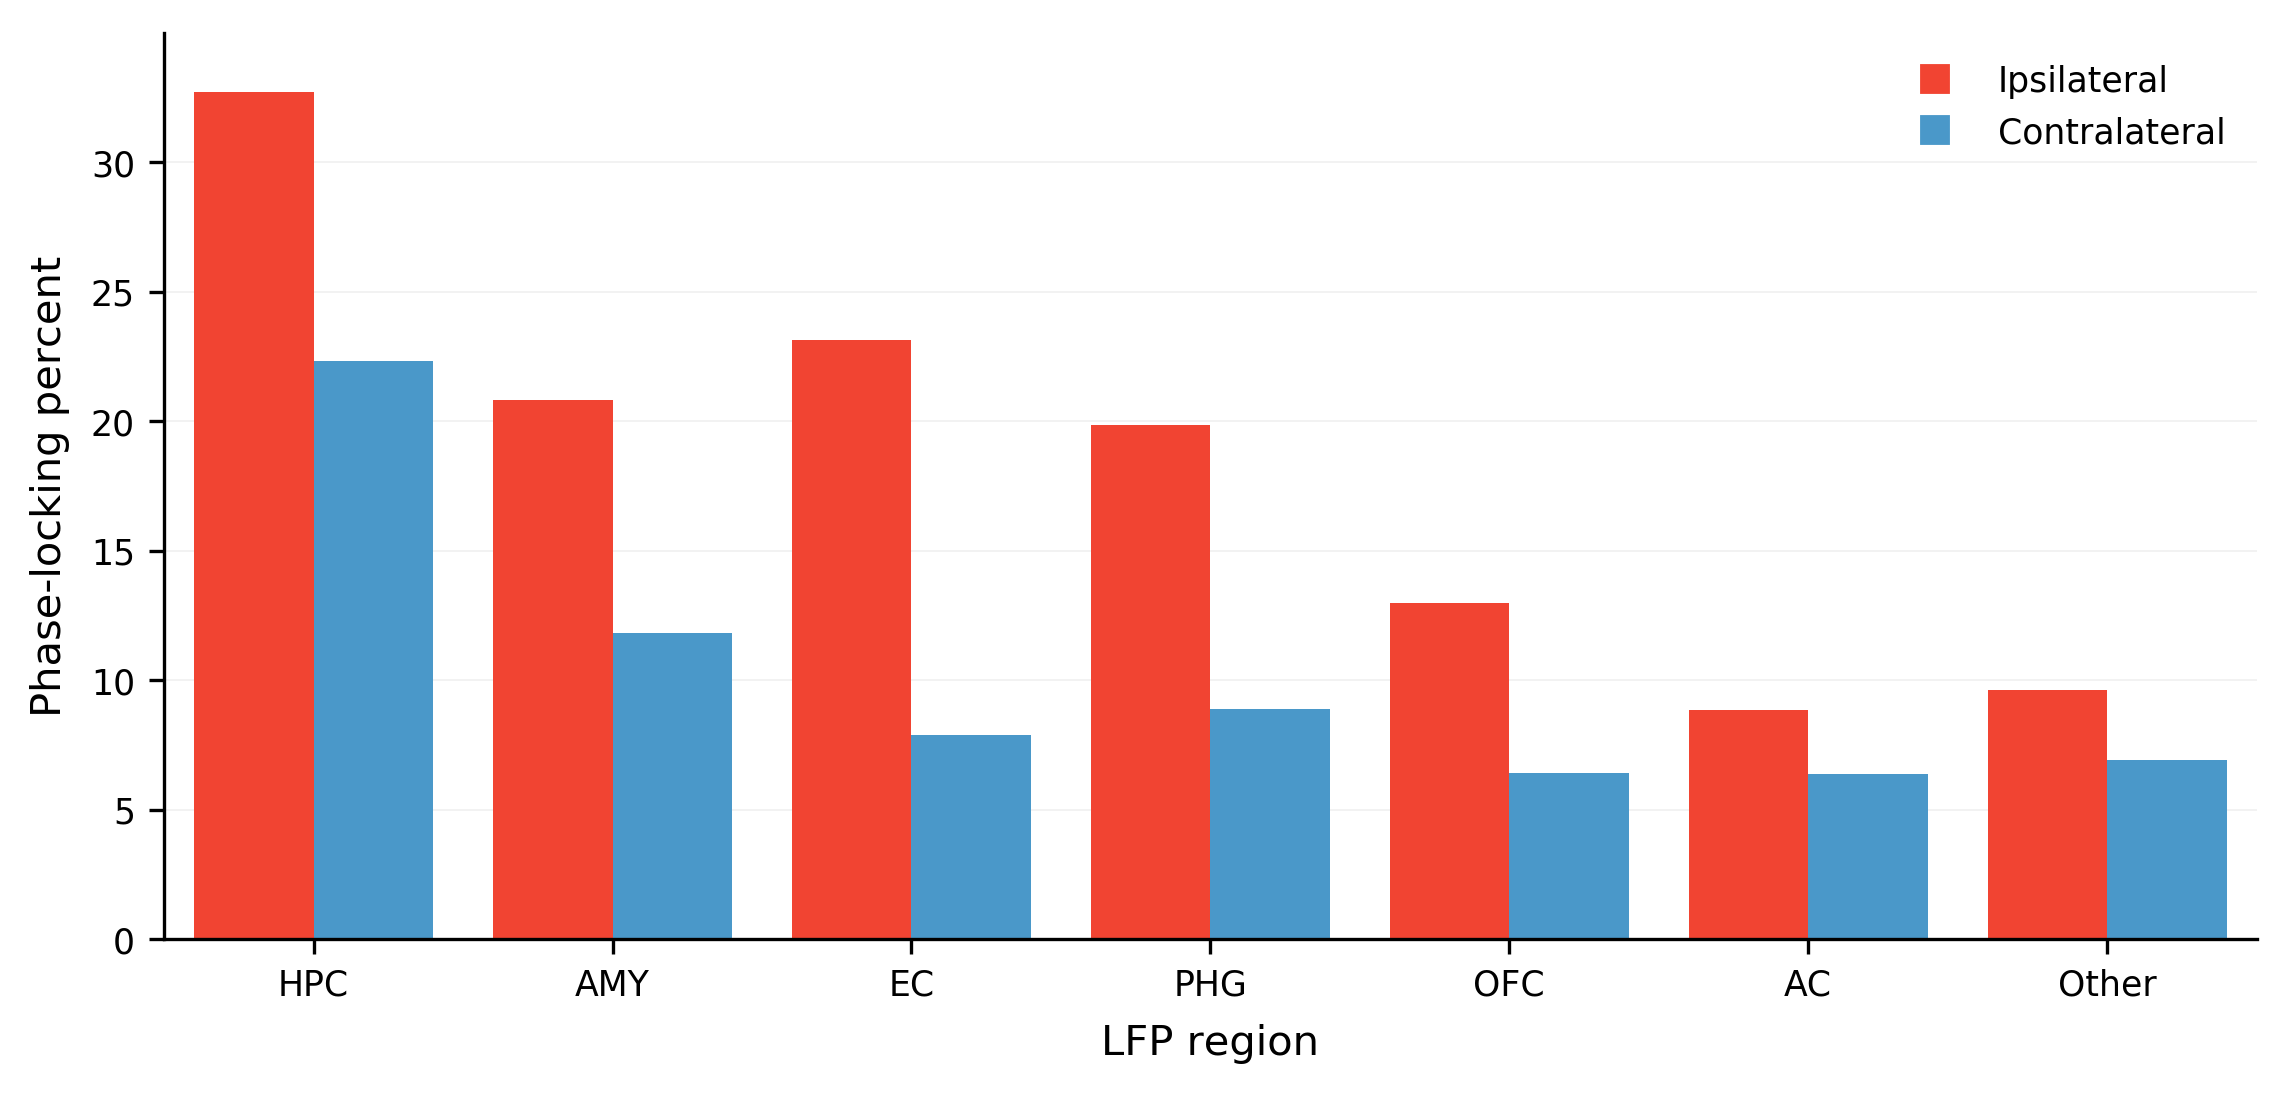

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4), dpi=300)

df = (pl_df
      .query("(edge=={})".format(['ctx-ctx', 'ctx-hpc', 'hpc-ctx', 'hpc-hpc']))
      .groupby(['same_hem', 'lfp_roi2'])
      .agg({'unit': len, 'sig_z_fdr': np.mean}).reset_index())
df.loc[df.lfp_roi2=='ctx', 'lfp_roi2'] = 'Other'
df.lfp_roi2 = df.lfp_roi2.astype('category').cat.reorder_categories(['hpc', 'amy', 'ec', 'phg', 'ofc', 'ac', 'Other'])
df.lfp_roi2 = df.lfp_roi2.apply(lambda x: x.upper() if x != 'Other' else x)

df['hem'] = df.same_hem.apply(lambda x: 'ipsi' if x else 'contra')
df['hem'] = df.hem.astype('category').cat.reorder_categories(['ipsi', 'contra'], ordered=True)

sns.barplot(x='lfp_roi2', y='sig_z_fdr', hue='hem', data=df, saturation=100, palette=[colors[1], colors[0]])

ax.set_ylim([0, 0.35])
ax.set_yticks([0, .05, .1, .15, .2, .25, .3])
ax.set_yticklabels([0, 5, 10, 15, 20, 25, 30])
ax.set_ylabel('Phase-locking percent', fontsize=labelfontsize, labelpad=5)
ax.set_xlabel('LFP region', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='Ipsilateral', markerfacecolor=colors[1], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Contralateral', markerfacecolor=colors[0], markersize=8)]
legend = ax.legend(handles=custom_lines, loc=1)

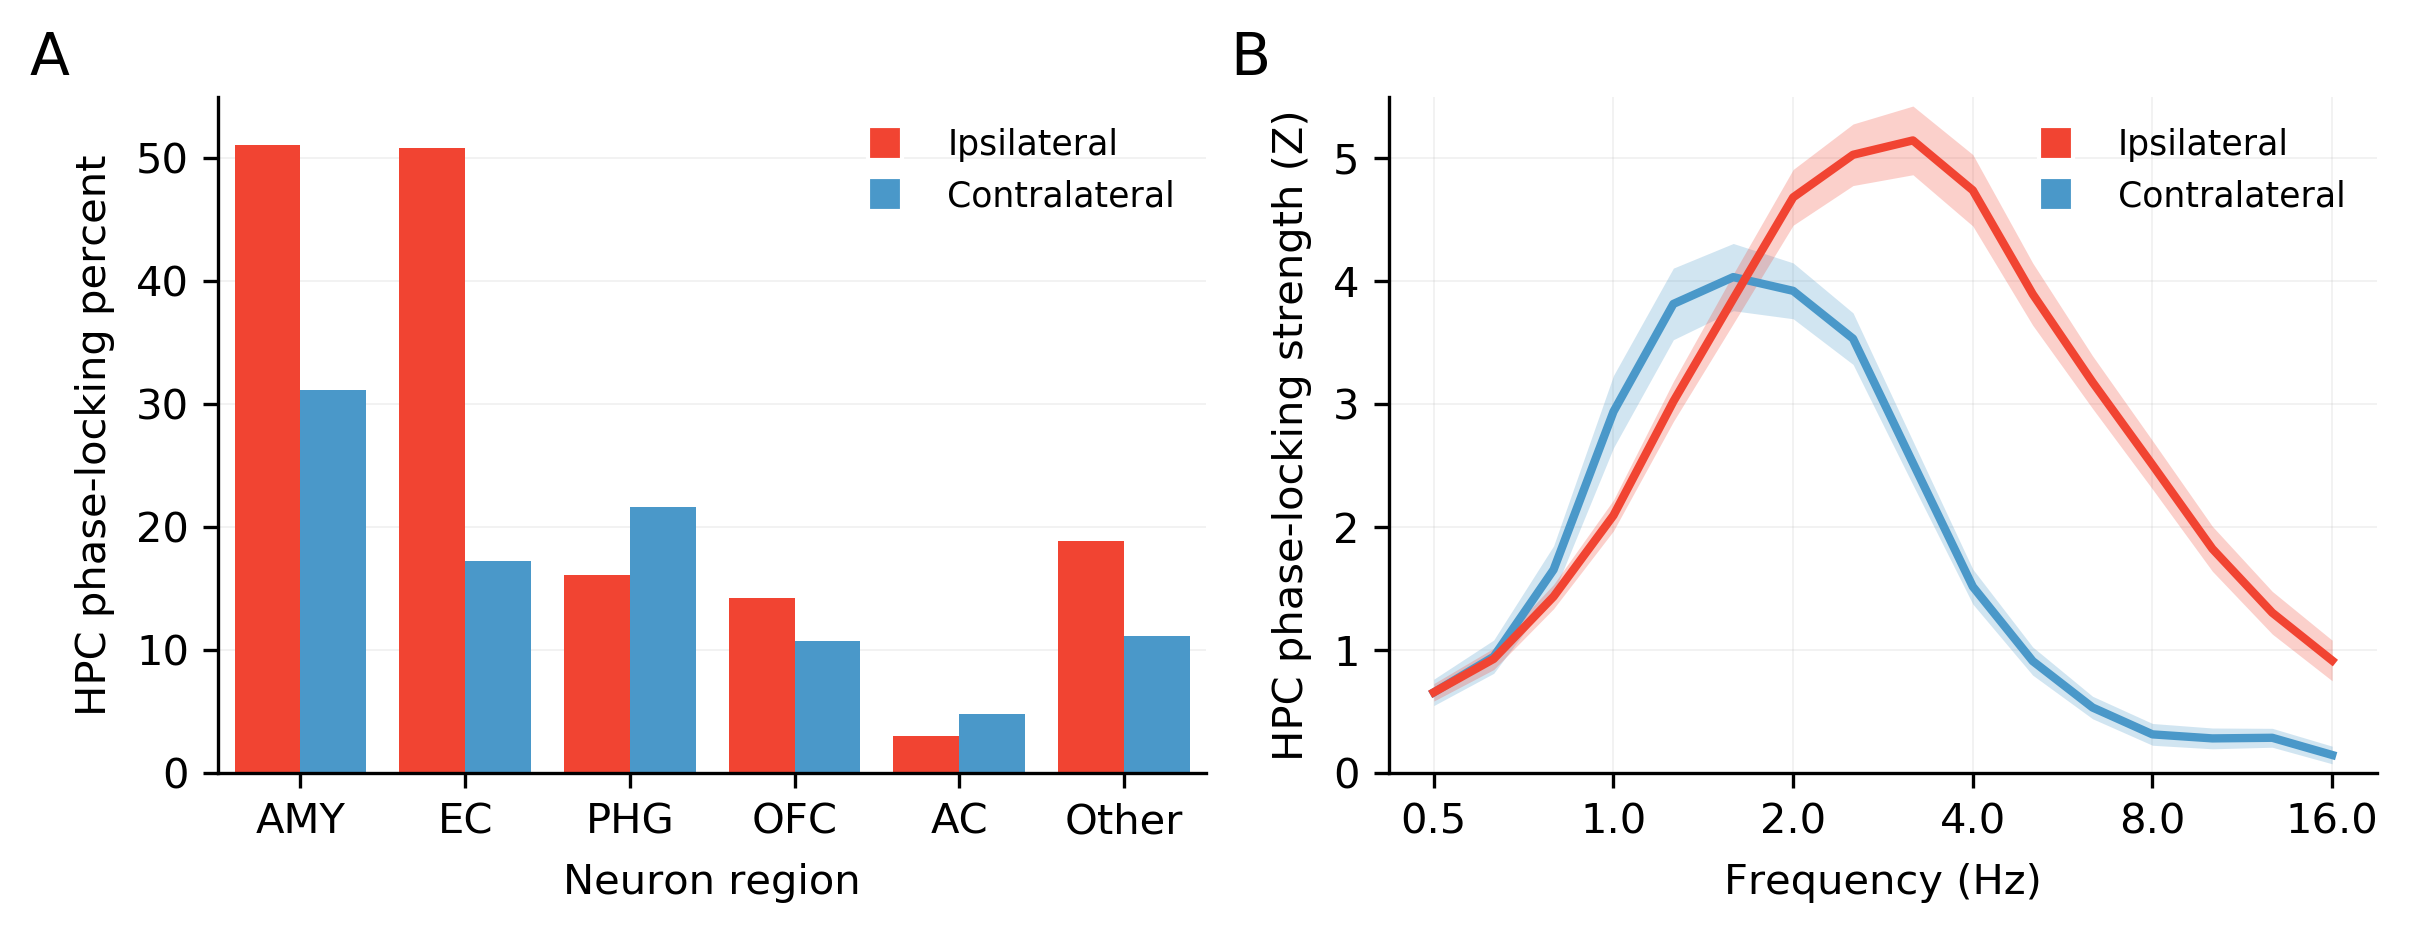

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 10
figfontsize = 14

df = pl_df.query("(edge=='ctx-hpc')").groupby(['unit_roi2', 'same_hem']).agg({'unit': len, 'sig_z_fdr': np.mean}).reset_index()
rois = OrderedDict([('amy', 'AMY'),
                    ('ec', 'EC'), 
                    ('phg', 'PHG'),
                    ('ofc', 'OFC'),
                    ('ac', 'AC'),
                    ('ctx', 'Other')])
df['unit_roi2'] = df.unit_roi2.astype('category').cat.reorder_categories(rois.keys(), ordered=True)
df['hem'] = df.same_hem.apply(lambda x: 'ipsi' if x else 'contra')
df['hem'] = df.hem.astype('category').cat.reorder_categories(['ipsi', 'contra'], ordered=True)

i = 0
sns.barplot(x='unit_roi2', y='sig_z_fdr', hue='hem', data=df, 
            palette=[colors[1], colors[0]], saturation=1, ax=ax[i])
ax[i].set_xticklabels(rois.values(), fontsize=tickfontsize)
ax[i].set_ylim([0, 0.55])
ax[i].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax[i].set_yticklabels([0, 10, 20, 30, 40, 50], fontsize=tickfontsize)
ax[i].set_xlabel('Neuron region', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC phase-locking percent', fontsize=labelfontsize, labelpad=5)
ax[i].get_legend().remove()

i = 1
mrls = {'ipsi': pl_df.query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True)").mrls_z.tolist(),
        'contra': pl_df.query("(edge=='ctx-hpc') & (same_hem==False) & (sig_z_fdr==True)").mrls_z.tolist()}
means = {'ipsi': np.mean(mrls['ipsi'], axis=0),
         'contra': np.mean(mrls['contra'], axis=0)}
sems = {'ipsi': stats.sem(mrls['ipsi'], axis=0),
        'contra': stats.sem(mrls['contra'], axis=0)}
ax[i].fill_between(np.arange(len(freqs)), means['contra'] - sems['contra'], means['contra'] + sems['contra'], 
                   color=colors[0], alpha=0.25, linewidth=0)
ax[i].fill_between(np.arange(len(freqs)), means['ipsi'] - sems['ipsi'], means['ipsi'] + sems['ipsi'], 
                   color=colors[1], alpha=0.25, linewidth=0)
ax[i].plot(np.arange(len(freqs)), means['contra'], color=colors[0], linewidth=2)
ax[i].plot(np.arange(len(freqs)), means['ipsi'], color=colors[1], linewidth=2)
ax[i].set_xticks(np.arange(len(freqs))[::3])
ax[i].set_xticklabels(np.round(freqs[::3], 1), fontsize=tickfontsize)
ax[i].set_ylim([0, 5.5])
ax[i].set_yticks([0, 1, 2, 3, 4, 5])
ax[i].set_yticklabels([0, 1, 2, 3, 4, 5], fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC phase-locking strength (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='Ipsilateral', markerfacecolor=colors[1], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Contralateral', markerfacecolor=colors[0], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)
legend = ax[1].legend(handles=custom_lines, loc=1)

fig.text(0, 0.97, 'A', fontsize=figfontsize)
fig.text(0.5, 0.97, 'B', fontsize=figfontsize)
fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
#plt.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/PhaseLocking2.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/PhaseLocking2.png', format='png', dpi=300, bbox_inches='tight')

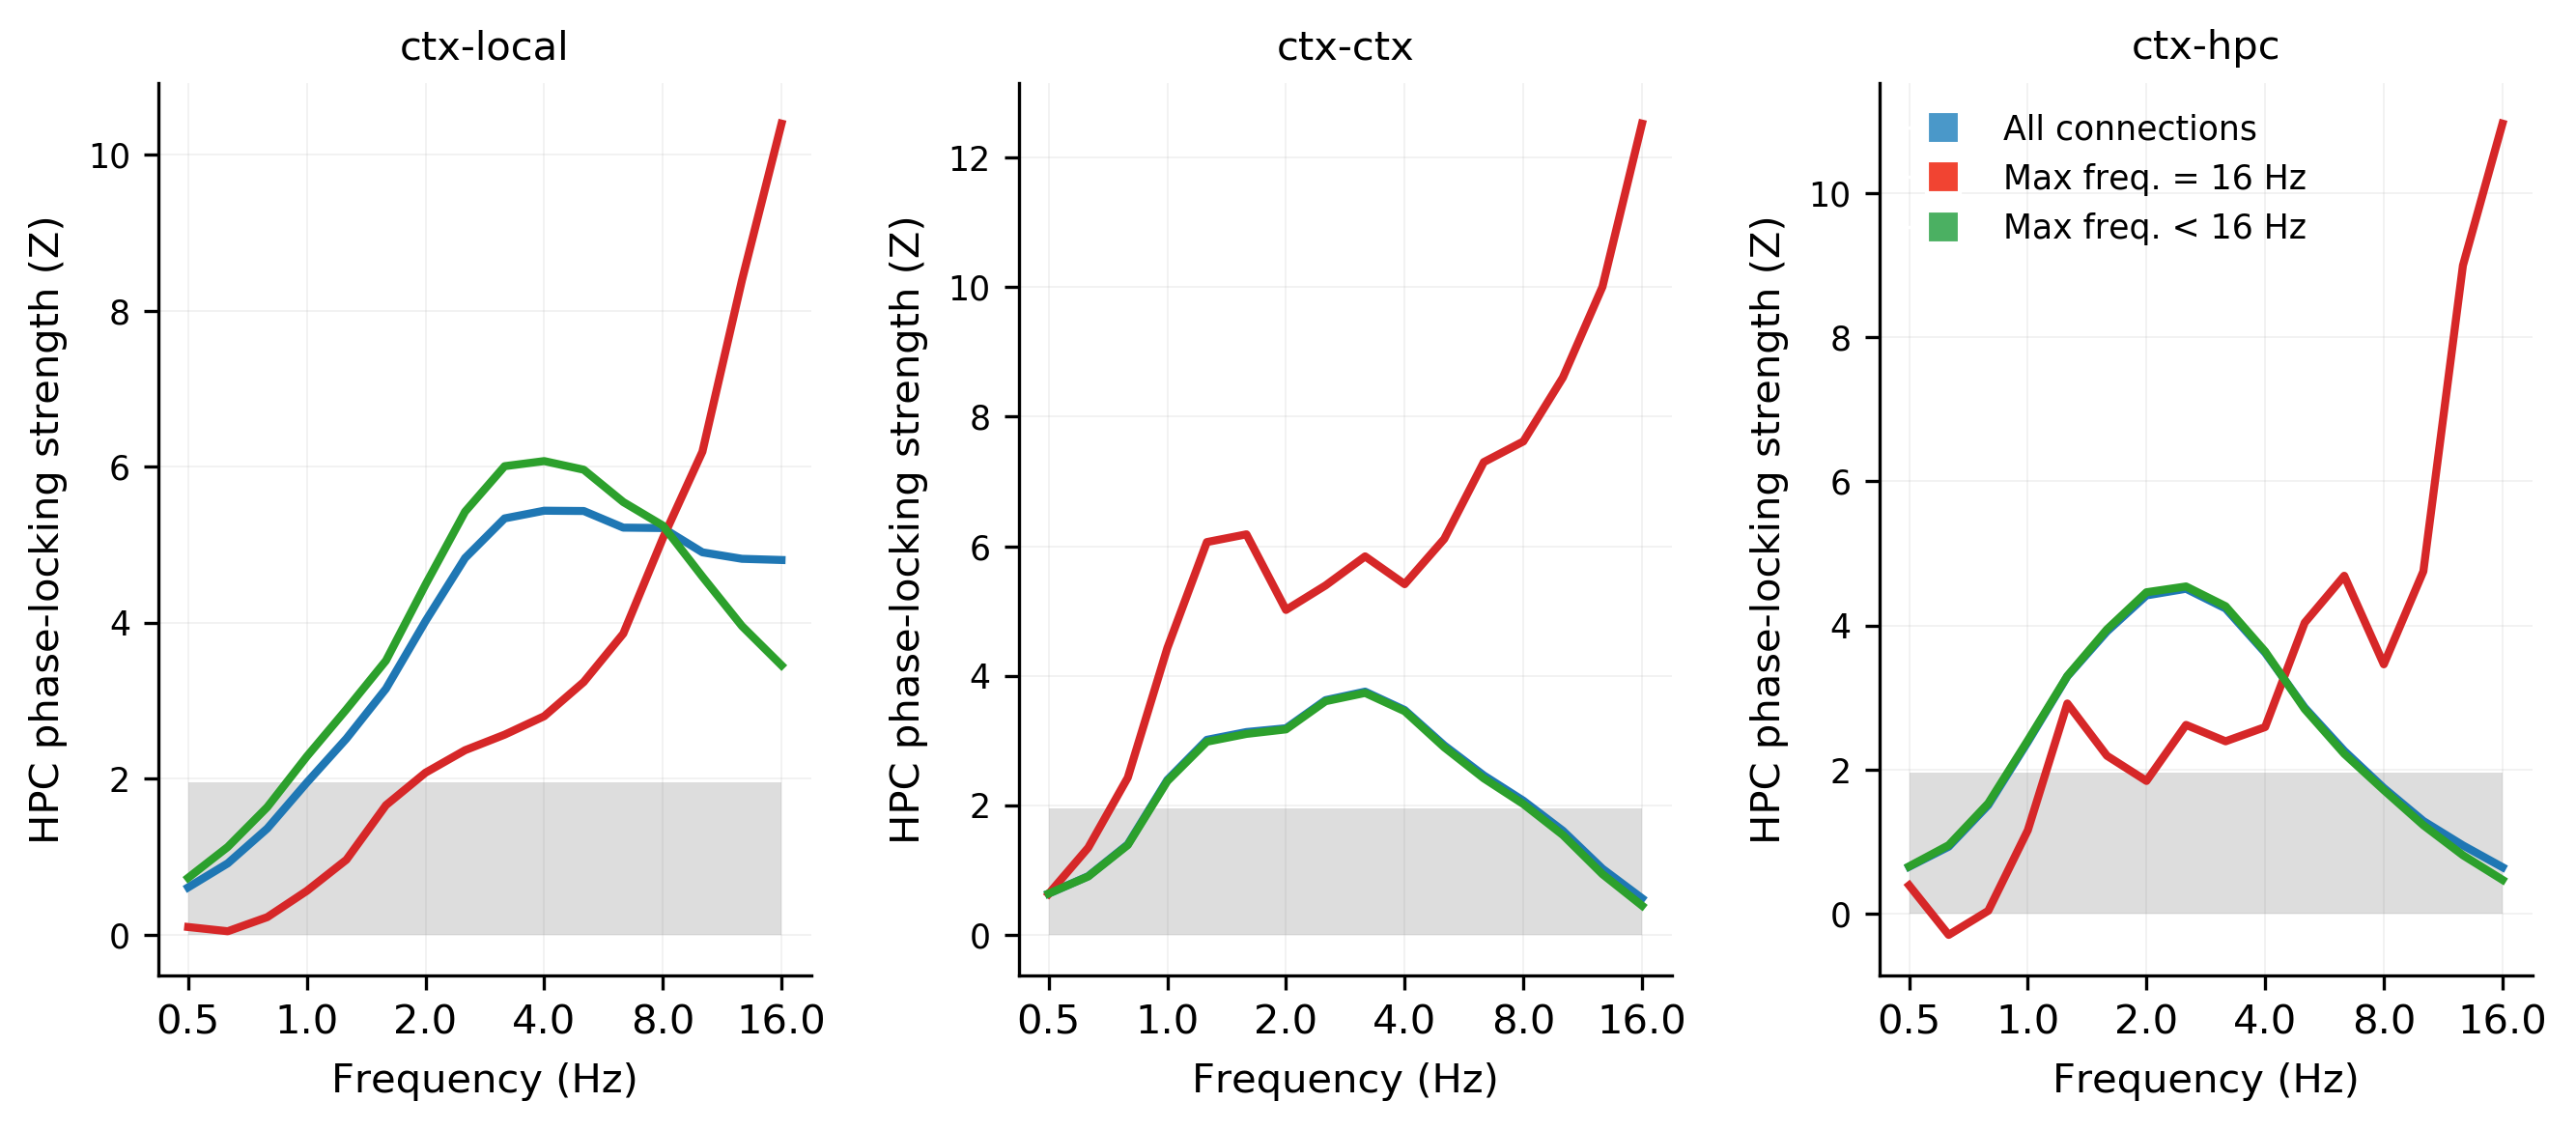

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(9, 4), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 10
figfontsize = 14

i = 0
for i, edge_type in enumerate(['ctx-local', 'ctx-ctx', 'ctx-hpc']):
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True)".format(edge_type)).mrls_z.tolist(), axis=0), linewidth=2)
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True) & (locked_freq_ind_z==15)".format(edge_type)).mrls_z.tolist(), axis=0), linewidth=2)
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True) & (locked_freq_ind_z<15)".format(edge_type)).mrls_z.tolist(), axis=0), linewidth=2)
    ax[i].set_xticks(np.arange(len(freqs))[::3])
    ax[i].set_xticklabels(np.round(freqs[::3], 1), fontsize=tickfontsize)
    ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_ylabel('HPC phase-locking strength (Z)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_title(edge_type, fontsize=labelfontsize)
    ax[i].fill_between(np.arange(len(freqs)), 0, 1.96, color=colors[-1], alpha=0.25, linewidth=0)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='All connections', markerfacecolor=colors[0], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Max freq. = 16 Hz', markerfacecolor=colors[1], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Max freq. < 16 Hz', markerfacecolor=colors[2], markersize=8)]
legend = ax[2].legend(handles=custom_lines, loc=2)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

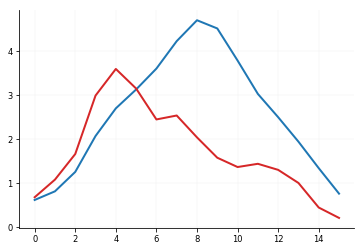

In [172]:
plt.plot(np.mean(pl_df.query("(edge=='ctx-ctx') & (sig_z_fdr==True) & (same_hem==True)").mrls_z.tolist(), axis=0), linewidth=2)
plt.plot(np.mean(pl_df.query("(edge=='ctx-ctx') & (sig_z_fdr==True) & (same_hem==False)").mrls_z.tolist(), axis=0), linewidth=2)

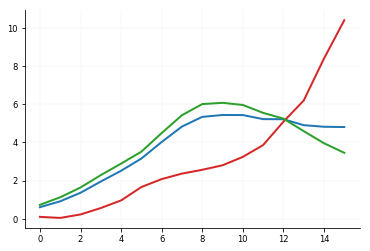

In [170]:
plt.plot(np.mean(pl_df.query("(edge=='ctx-local') & (sig_z_fdr==True)").mrls_z.tolist(), axis=0), linewidth=2)
plt.plot(np.mean(pl_df.query("(edge=='ctx-local') & (sig_z_fdr==True) & (locked_freq_ind_z==15)").mrls_z.tolist(), axis=0), linewidth=2)
plt.plot(np.mean(pl_df.query("(edge=='ctx-local') & (sig_z_fdr==True) & (locked_freq_ind_z<15)").mrls_z.tolist(), axis=0), linewidth=2)

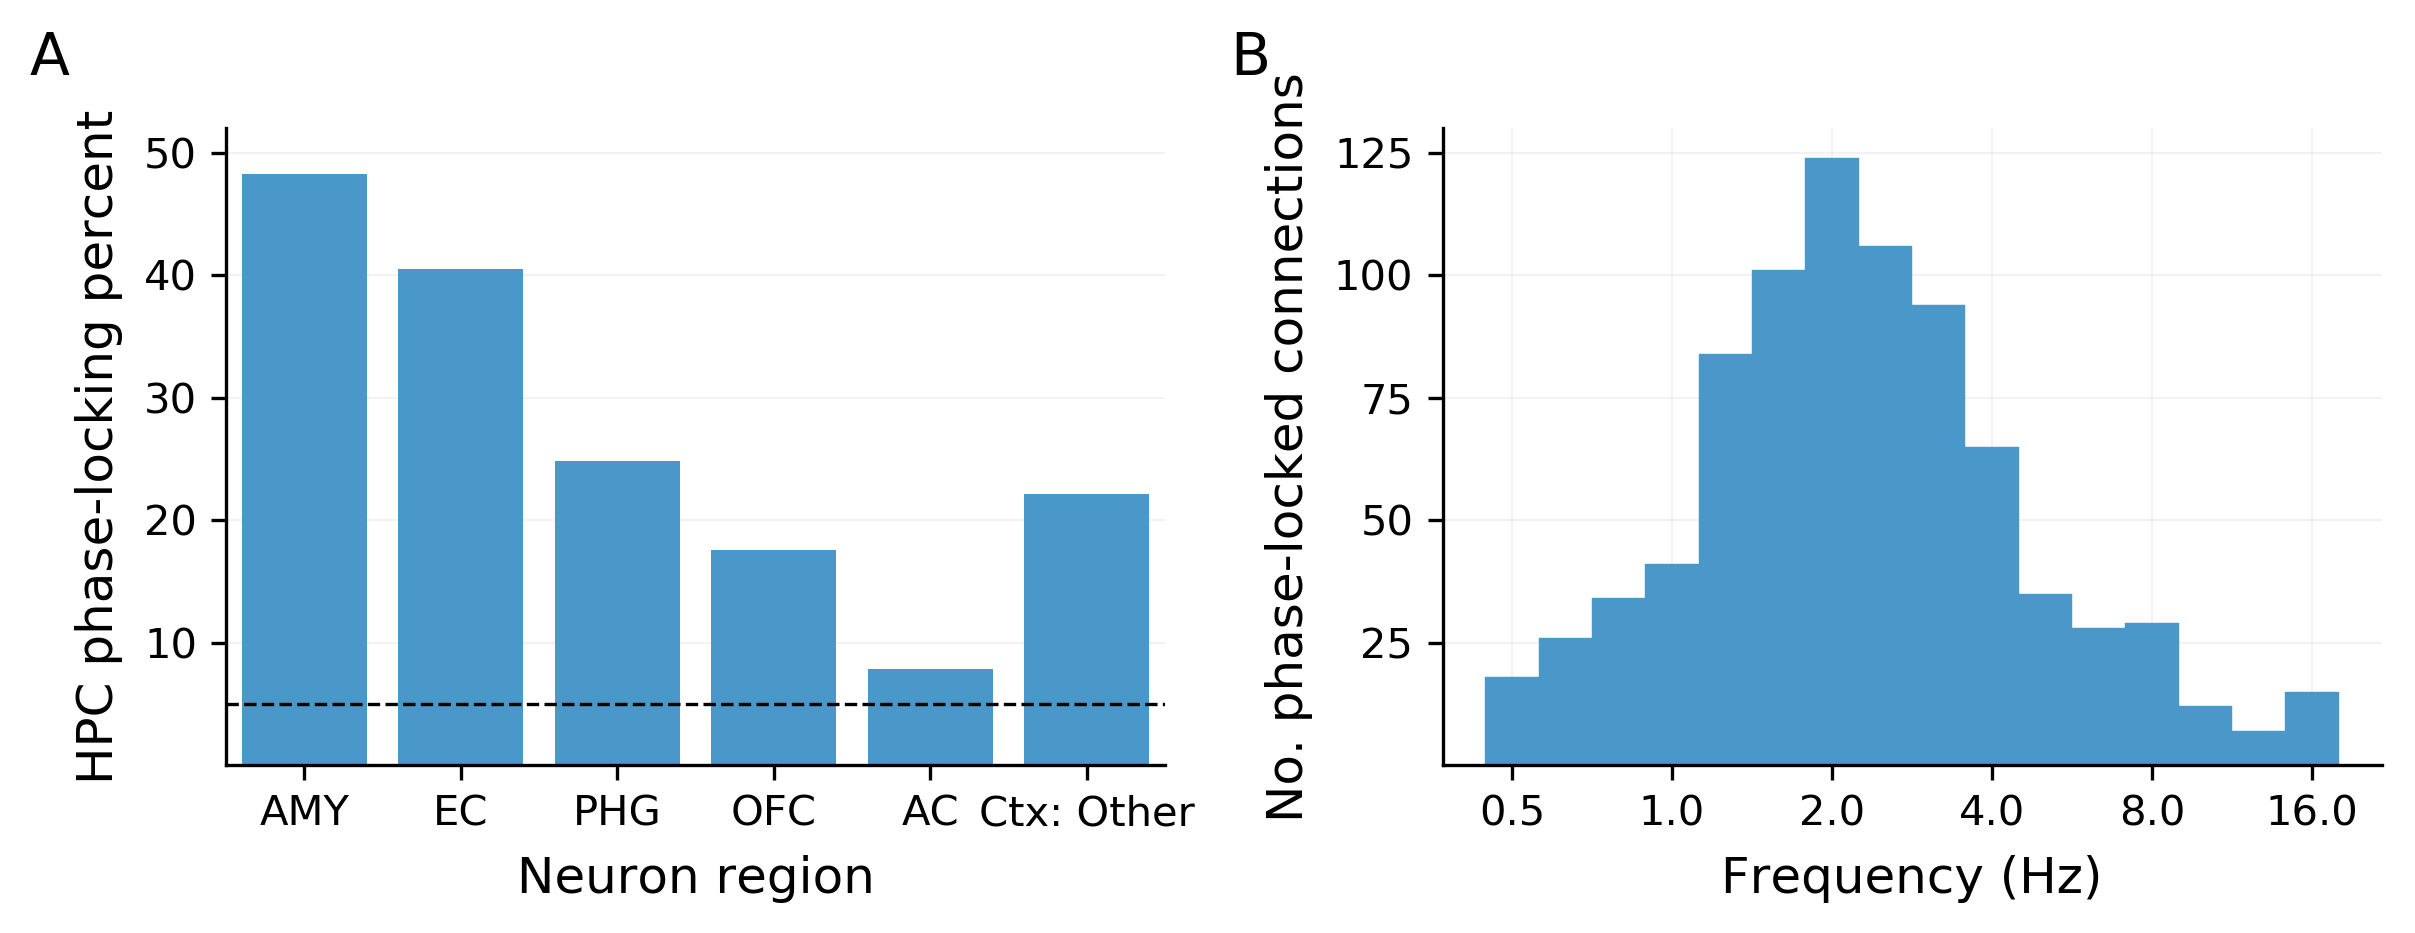

In [313]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 12
figfontsize = 14

# HPC phase-locking by region.
df = pl_df.query("(edge=='ctx-hpc')").groupby(['unit_roi2']).agg({'unit': len, 'sig_z': np.mean}).reset_index()
rois = OrderedDict([('amy', 'AMY'),
                    ('ec', 'EC'), 
                    ('phg', 'PHG'),
                    ('ofc', 'OFC'),
                    ('ac', 'AC'),
                    ('ctx', 'Ctx: Other')])
df['unit_roi2'] = df.unit_roi2.astype('category').cat.reorder_categories(rois.keys(), ordered=True)

sns.barplot(x='unit_roi2', y='sig_z', data=df.reset_index(), color=colors[0], saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
ax[0].set_xticklabels(rois.values(), fontsize=tickfontsize)
ax[0].set_ylim([0, 0.52])
ax[0].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax[0].set_yticklabels([10, 20, 30, 40, 50], fontsize=tickfontsize)
ax[0].set_xlabel('Neuron region', fontsize=labelfontsize, labelpad=5)
ax[0].set_ylabel('HPC phase-locking percent', fontsize=labelfontsize, labelpad=5)

# HPC phase-locking by frequency.
edge_types = ['ctx-local', 'ctx-hpc', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx']
d = OrderedDict()
for edge_type in edge_types:
    d[edge_type] = OrderedDict()
    d_ = pl_df.query("(sig_z==True) & (edge=='{}')".format(edge_type)).groupby(['locked_freq_ind_z']).size().to_dict()
    for ifreq in range(len(freqs)):
        d[edge_type][ifreq] = d_.get(ifreq, 0) #/ len(pl_df.query("(same_hem==True) & (edge=='{}')".format(edge_type)))
df = pd.DataFrame(d).reset_index()

ax[1].bar(x=df['index'], height=df['ctx-hpc'], width=1, color=colors[0], edgecolor=colors[0], linewidth=0.1)
ax[1].set_xticks(np.arange(len(freqs))[::3])
ax[1].set_xticklabels(np.round(freqs[::3], 1), fontsize=tickfontsize)
ax[1].set_ylim([0, 130])
ax[1].set_yticks([25, 50, 75, 100, 125])
ax[1].set_yticklabels([25, 50, 75, 100, 125], fontsize=tickfontsize)
ax[1].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[1].set_ylabel('No. phase-locked connections', fontsize=labelfontsize, labelpad=5)

fig.text(0, 0.97, 'A', fontsize=figfontsize)
fig.text(0.5, 0.97, 'B', fontsize=figfontsize)
fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
#plt.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/PhaseLocking.eps', format='eps', dpi=300, bbox_inches='tight')

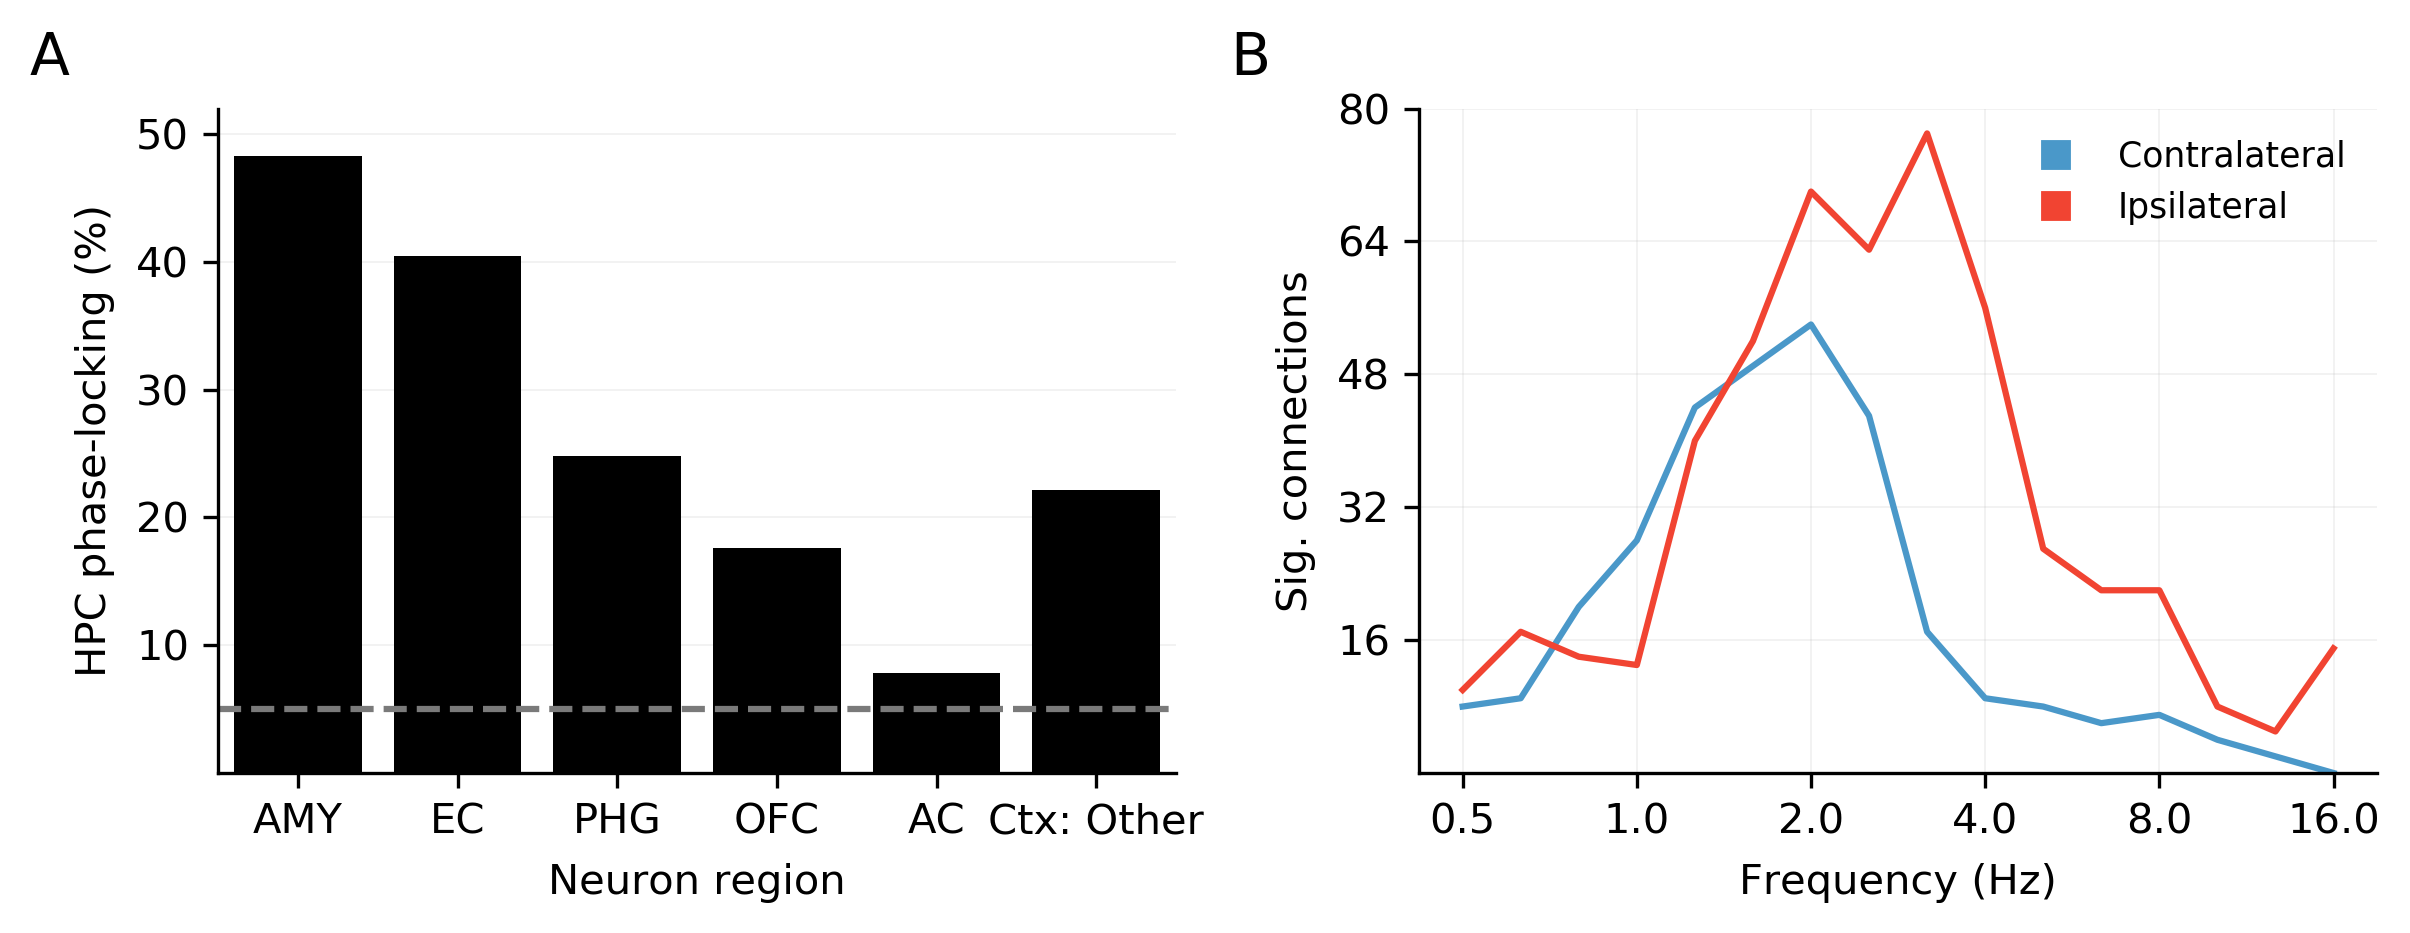

In [422]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 10
figfontsize = 14

# HPC phase-locking by region.
df = pl_df.query("(edge=='ctx-hpc')").groupby(['unit_roi2']).agg({'unit': len, 'sig_z': np.mean}).reset_index()
rois = OrderedDict([('amy', 'AMY'),
                    ('ec', 'EC'), 
                    ('phg', 'PHG'),
                    ('ofc', 'OFC'),
                    ('ac', 'AC'),
                    ('ctx', 'Ctx: Other')])
df['unit_roi2'] = df.unit_roi2.astype('category').cat.reorder_categories(rois.keys(), ordered=True)

sns.barplot(x='unit_roi2', y='sig_z', data=df.reset_index(), color='k', saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color=colors[-1], linestyle='--', linewidth=1.5)
ax[0].set_xticklabels(rois.values(), fontsize=tickfontsize)
ax[0].set_ylim([0, 0.52])
ax[0].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax[0].set_yticklabels([10, 20, 30, 40, 50], fontsize=tickfontsize)
ax[0].set_xlabel('Neuron region', fontsize=labelfontsize, labelpad=5)
ax[0].set_ylabel('HPC phase-locking (%)', fontsize=labelfontsize, labelpad=5)

# HPC phase-locking by frequency.
edge_types = ['ctx-local', 'ctx-hpc', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx']
d = OrderedDict()
for edge_type in edge_types:
    d[edge_type] = OrderedDict()
    d_ = pl_df.query("(sig_z==True) & (same_hem==True) & (edge=='{}')".format(edge_type)).groupby(['locked_freq_ind_z']).size().to_dict()
    for ifreq in range(len(freqs)):
        d[edge_type][ifreq] = d_.get(ifreq, 0) #/ len(pl_df.query("(same_hem==True) & (edge=='{}')".format(edge_type)))
df_ipsi = pd.DataFrame(d).reset_index()
d = OrderedDict()
for edge_type in edge_types:
    d[edge_type] = OrderedDict()
    d_ = pl_df.query("(sig_z==True) & (same_hem==False) & (edge=='{}')".format(edge_type)).groupby(['locked_freq_ind_z']).size().to_dict()
    for ifreq in range(len(freqs)):
        d[edge_type][ifreq] = d_.get(ifreq, 0) #/ len(pl_df.query("(same_hem==True) & (edge=='{}')".format(edge_type)))
df_contra = pd.DataFrame(d).reset_index()

# ax[1].bar(x=df_ipsi['index'], height=df_ipsi['ctx-hpc'], width=1, color=colors[1], edgecolor=colors[1], linewidth=0.1, alpha=0.6)
# ax[1].bar(x=df_contra['index'], height=df_contra['ctx-hpc'], width=1, color=colors[0], edgecolor=colors[0], linewidth=0.1, alpha=0.6)
ax[1].plot(df_contra['index'], df_contra['ctx-hpc'], color=colors[0], linewidth=1.5)
ax[1].plot(df_ipsi['index'], df_ipsi['ctx-hpc'], color=colors[1], linewidth=1.5)
ax[1].set_xticks(np.arange(len(freqs))[::3])
ax[1].set_xticklabels(np.round(freqs[::3], 1), fontsize=tickfontsize)
ax[1].set_ylim([0, 80])
ax[1].set_yticks([16, 32, 48, 64, 80])
ax[1].set_yticklabels([16, 32, 48, 64, 80], fontsize=tickfontsize)
ax[1].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[1].set_ylabel('Sig. connections', fontsize=labelfontsize, labelpad=5)
custom_lines = [Line2D([0], [0], marker='s', color='w', label='Contralateral', markerfacecolor=colors[0], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Ipsilateral', markerfacecolor=colors[1], markersize=8)]
legend = ax[1].legend(handles=custom_lines, loc=1)

fig.text(0, 0.97, 'A', fontsize=figfontsize)
fig.text(0.5, 0.97, 'B', fontsize=figfontsize)
fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
plt.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/PhaseLocking.eps', format='eps', dpi=300, bbox_inches='tight')

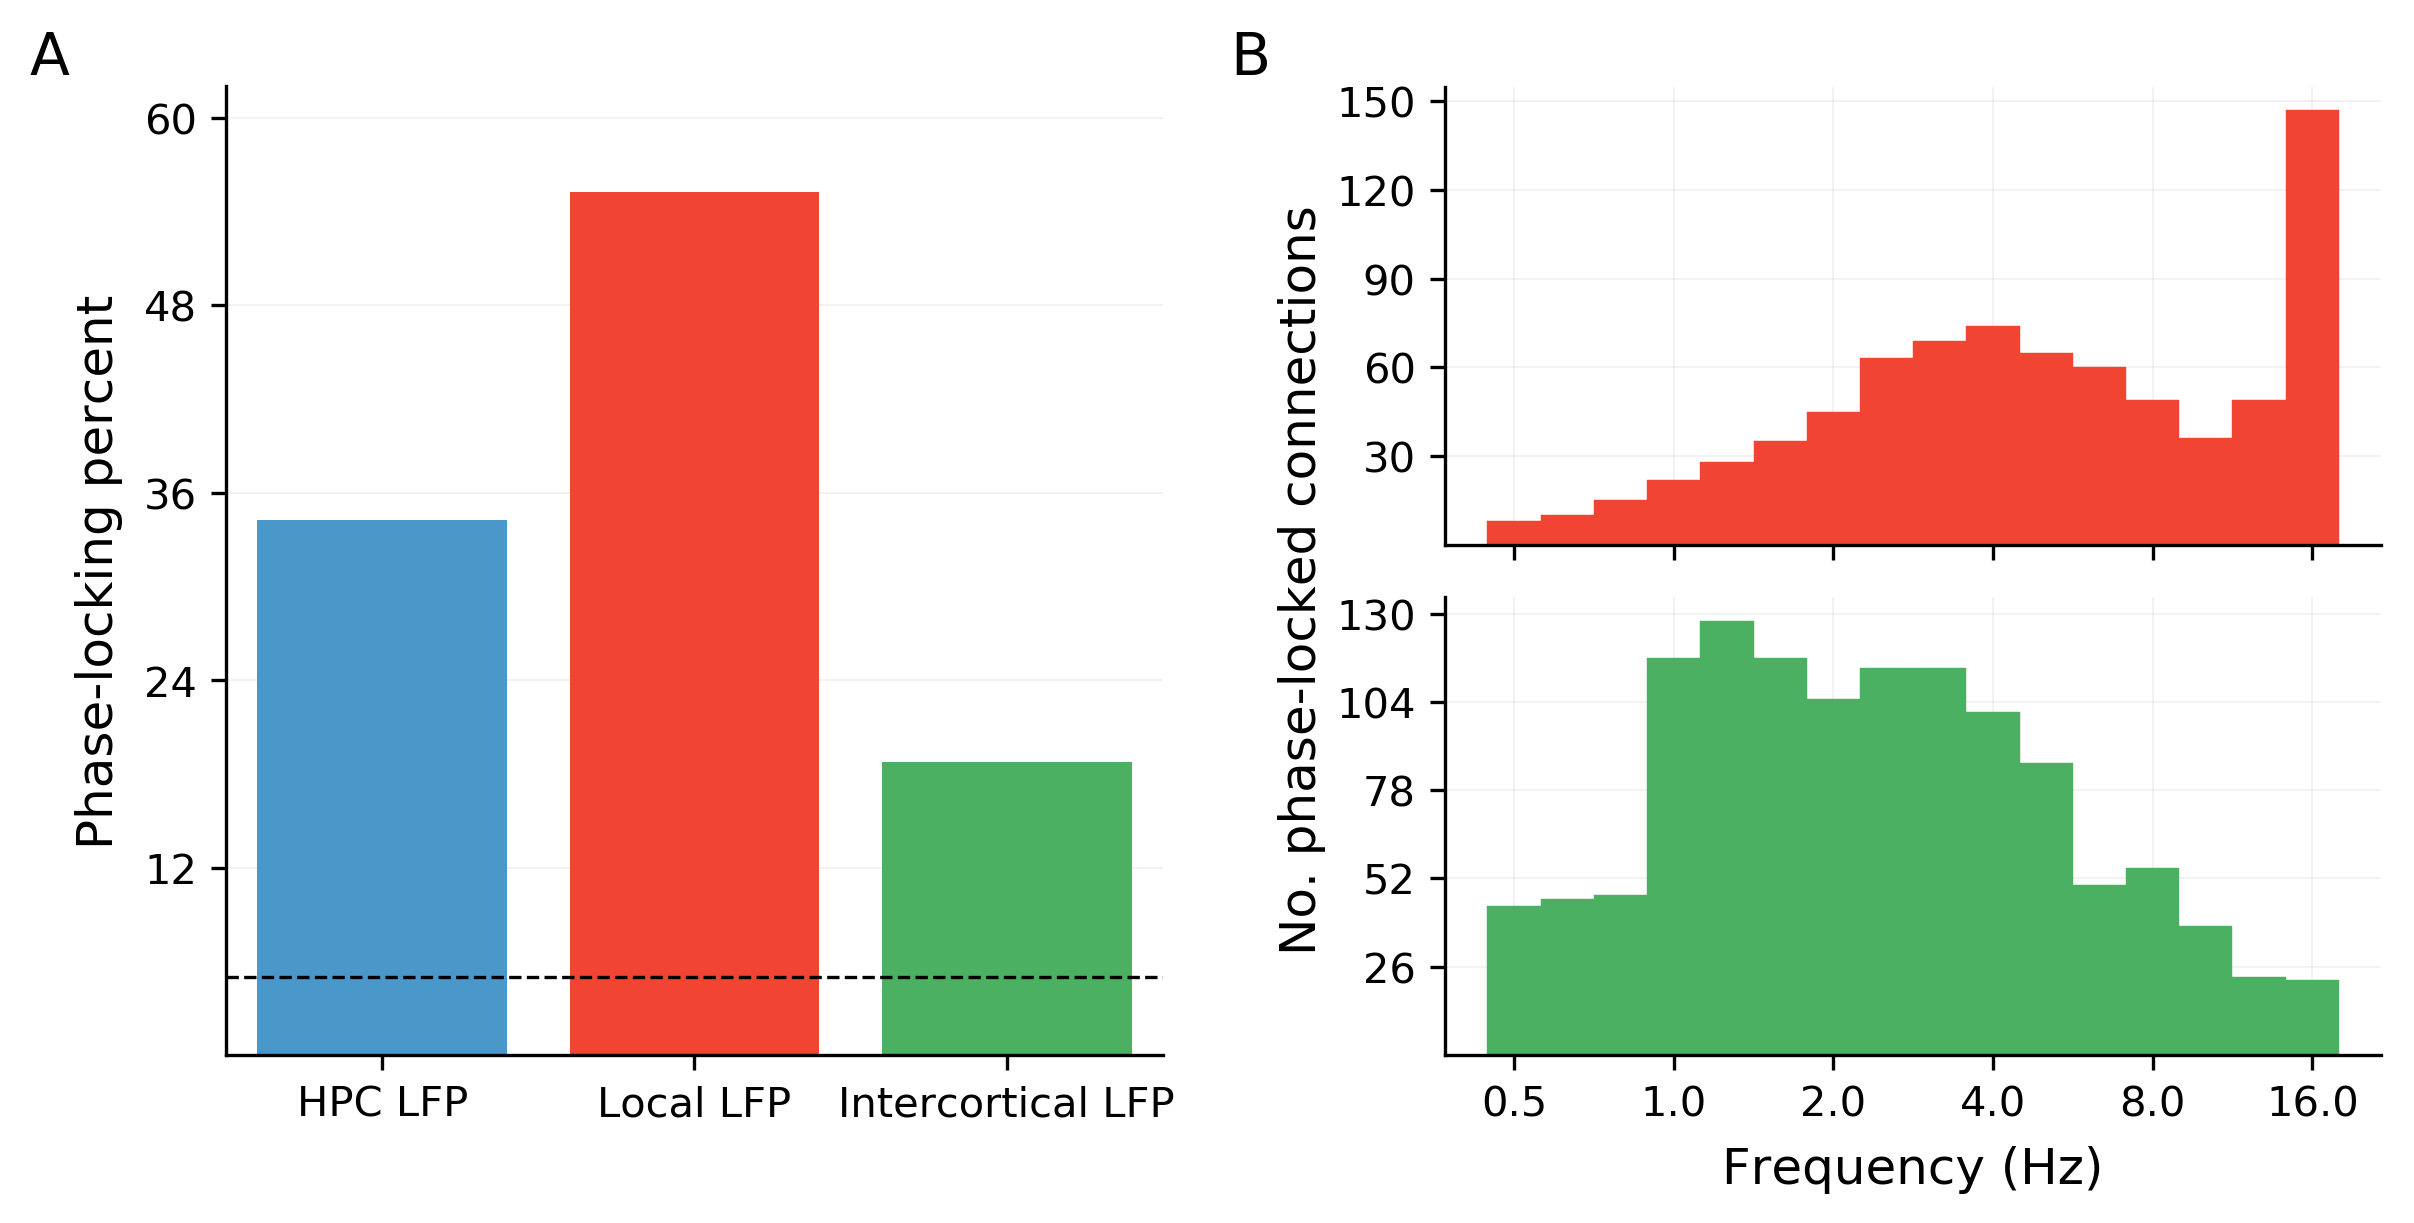

In [251]:
#fig = plt.Figure(figsize=(8, 4), dpi=300)
fig, _ = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
ax = []
ax.append(plt.subplot2grid((2, 2), (0, 0), rowspan=2, fig=fig))
ax.append(plt.subplot2grid((2, 2), (0, 1), fig=fig))
ax.append(plt.subplot2grid((2, 2), (1, 1), fig=fig))

tickfontsize = 10
labelfontsize = 12
figfontsize = 14

# HPC vs. local vs. inter-cortical phase-locking rates.
df = (pl_df.query("(same_hem==True) & (edge==['ctx-local', 'ctx-hpc', 'ctx-ctx'])")
      .groupby('edge').agg({'subj_sess_unit': len, 'sig': np.mean}).reset_index())[:3]
d_ = OrderedDict([('ctx-hpc', 'HPC LFP'),
                  ('ctx-local', 'Local LFP'),
                  ('ctx-ctx', 'Intercortical LFP')])
df['cat'] = df.edge.apply(lambda x: d_[x])
df.cat = df.cat.astype('category').cat.reorder_categories(d_.values(), ordered=True)

sns.barplot(x='cat', y='sig', data=df, palette=colors, saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
ax[0].set_xticklabels(d_.values(), fontsize=tickfontsize)
ax[0].set_ylim([0, .62])
ax[0].set_yticks([.12, .24, .36, .48, .6])
ax[0].set_yticklabels([12, 24, 36, 48, 60], fontsize=tickfontsize)
ax[0].set_xlabel('')
ax[0].set_ylabel('Phase-locking percent', fontsize=labelfontsize, labelpad=5)

# HPC phase-locking by frequency.
edge_types = ['ctx-local', 'ctx-hpc', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx']
d = OrderedDict()
for edge_type in edge_types:
    d[edge_type] = OrderedDict()
    d_ = pl_df.query("(sig_z==True) & (edge=='{}')".format(edge_type)).groupby(['locked_freq_ind_z']).size().to_dict()
    for ifreq in range(len(freqs)):
        d[edge_type][ifreq] = d_.get(ifreq, 0) #/ len(pl_df.query("(same_hem==True) & (edge=='{}')".format(edge_type)))
df = pd.DataFrame(d).reset_index()

ax[1].bar(x=df['index'], height=df['ctx-local'], width=1, color=colors[1], edgecolor=colors[1], linewidth=0.1)
ax[1].set_xticks(np.arange(len(freqs))[::3])
ax[1].set_xticklabels(['' for x in np.round(freqs[::3], 1)], fontsize=tickfontsize)
ax[1].set_ylim([0, 155])
ax[1].set_yticks([30, 60, 90, 120, 150])
ax[1].set_yticklabels([30, 60, 90, 120, 150], fontsize=tickfontsize)

ax[2].bar(x=df['index'], height=df['ctx-ctx'], width=1, color=colors[2], edgecolor=colors[2], linewidth=0.1)
ax[2].set_xticks(np.arange(len(freqs))[::3])
ax[2].set_xticklabels(np.round(freqs[::3], 1), fontsize=tickfontsize)
ax[2].set_ylim([0, 135])
ax[2].set_yticks([26, 52, 78, 104, 130])
ax[2].set_yticklabels([26, 52, 78, 104, 130], fontsize=tickfontsize)

ax[2].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)

fig.text(0.52, 0.83, 'No. phase-locked connections', fontsize=labelfontsize, rotation='vertical')
fig.text(0, 0.97, 'A', fontsize=figfontsize)
fig.text(0.5, 0.97, 'B', fontsize=figfontsize)

fig.tight_layout(pad=1.08, w_pad=3.5, rect=[0, 0, 1, 1])
plt.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/PhaseLockingComparison.eps', format='eps', dpi=300, bbox_inches='tight')

In [73]:
np.logspace(np.log10(0.5), np.log10(128), 17), np.array([2**((i-2)/2) for i in range(17)])

(array([  0.5       ,   0.70710678,   1.        ,   1.41421356,
          2.        ,   2.82842712,   4.        ,   5.65685425,
          8.        ,  11.3137085 ,  16.        ,  22.627417  ,
         32.        ,  45.254834  ,  64.        ,  90.50966799,
        128.        ]),
 array([  0.5       ,   0.70710678,   1.        ,   1.41421356,
          2.        ,   2.82842712,   4.        ,   5.65685425,
          8.        ,  11.3137085 ,  16.        ,  22.627417  ,
         32.        ,  45.254834  ,  64.        ,  90.50966799,
        128.        ]))

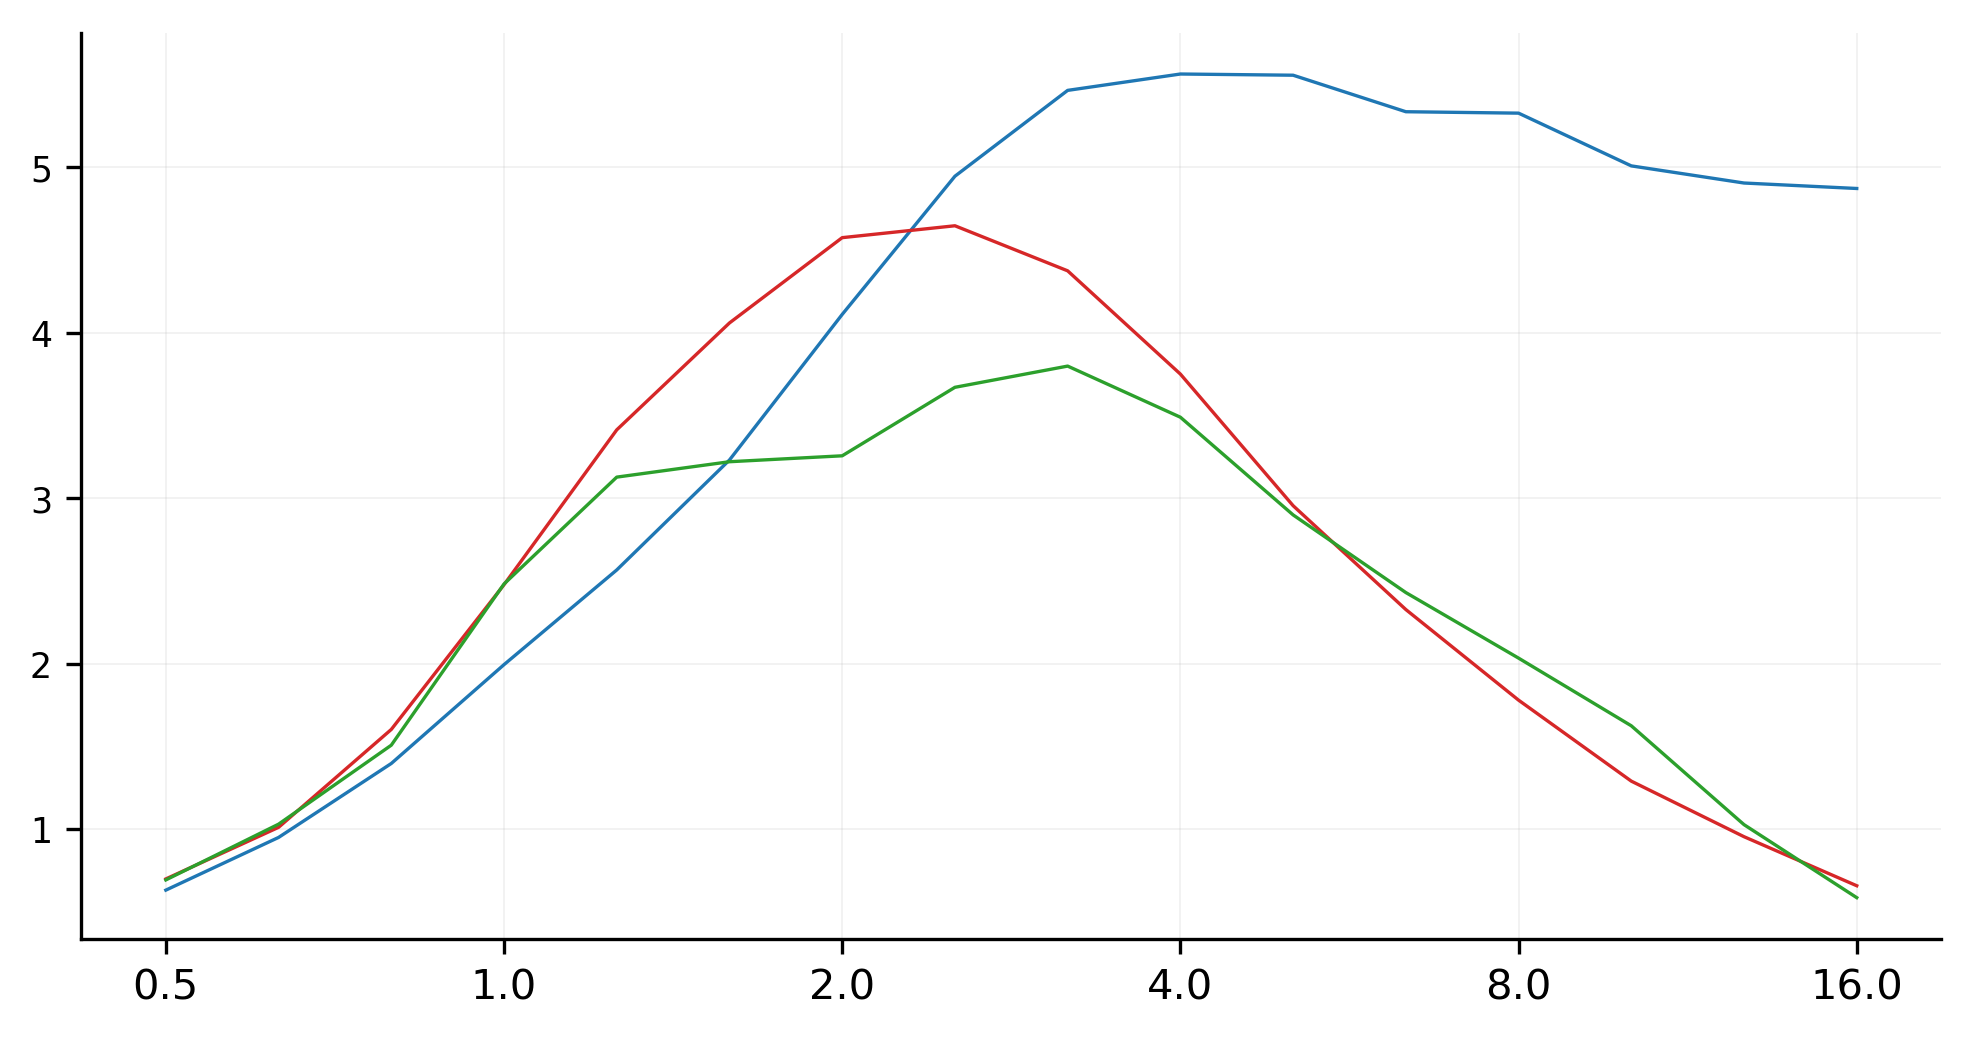

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

ax[0].plot(np.mean(pl_df.query("(edge=='ctx-local') & (sig_z_fdr==True)").mrls_z.tolist(), axis=0))
ax[0].plot(np.mean(pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True)").mrls_z.tolist(), axis=0))
ax[0].plot(np.mean(pl_df.query("(edge=='ctx-ctx') & (sig_z_fdr==True)").mrls_z.tolist(), axis=0))
ax[0].set_xticks(np.arange(len(freqs))[::3])
ax[0].set_xticklabels(np.round(freqs[::3], 1), fontsize=tickfontsize)

plt.show()

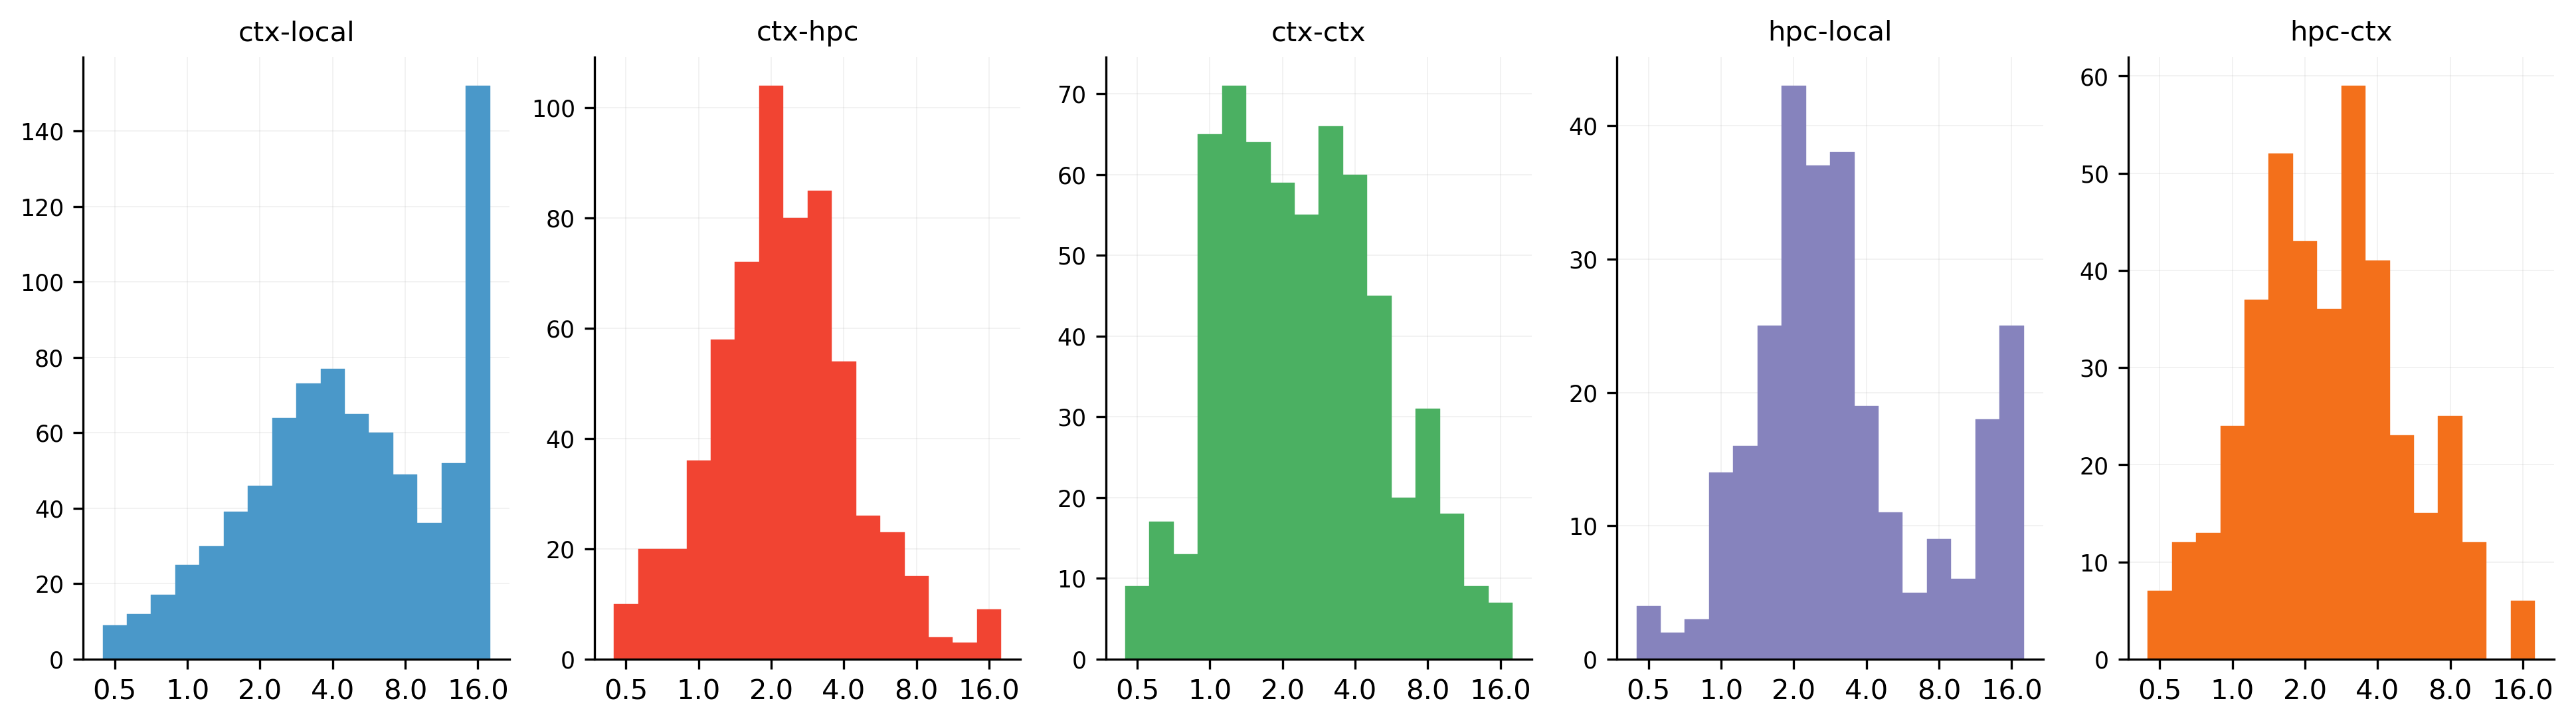

In [60]:
# Phase-locking by frequency.
fig, ax = plt.subplots(1, 5, figsize=(16, 4), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 12
figfontsize = 14

edge_types = ['ctx-local', 'ctx-hpc', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx']
d = OrderedDict()
for edge_type in edge_types:
    d[edge_type] = OrderedDict()
    d_ = pl_df.query("(sig_z_fdr==True) & (edge=='{}')".format(edge_type)).groupby(['locked_freq_ind_z']).size().to_dict()
    for ifreq in range(len(freqs)):
        d[edge_type][ifreq] = d_.get(ifreq, 0) #/ len(pl_df.query("(same_hem==True) & (edge=='{}')".format(edge_type)))
df = pd.DataFrame(d).reset_index()

for i, edge_type in enumerate(['ctx-local', 'ctx-hpc', 'ctx-ctx', 'hpc-local', 'hpc-ctx']):
    ax[i].bar(x=df['index'], height=df[edge_type], width=1, color=colors[i], edgecolor=colors[i], linewidth=0.1)
    ax[i].set_xticks(np.arange(len(freqs))[::3])
    ax[i].set_xticklabels(np.round(freqs[::3], 1), fontsize=tickfontsize)
    ax[i].set_title(edge_type, fontsize=tickfontsize)

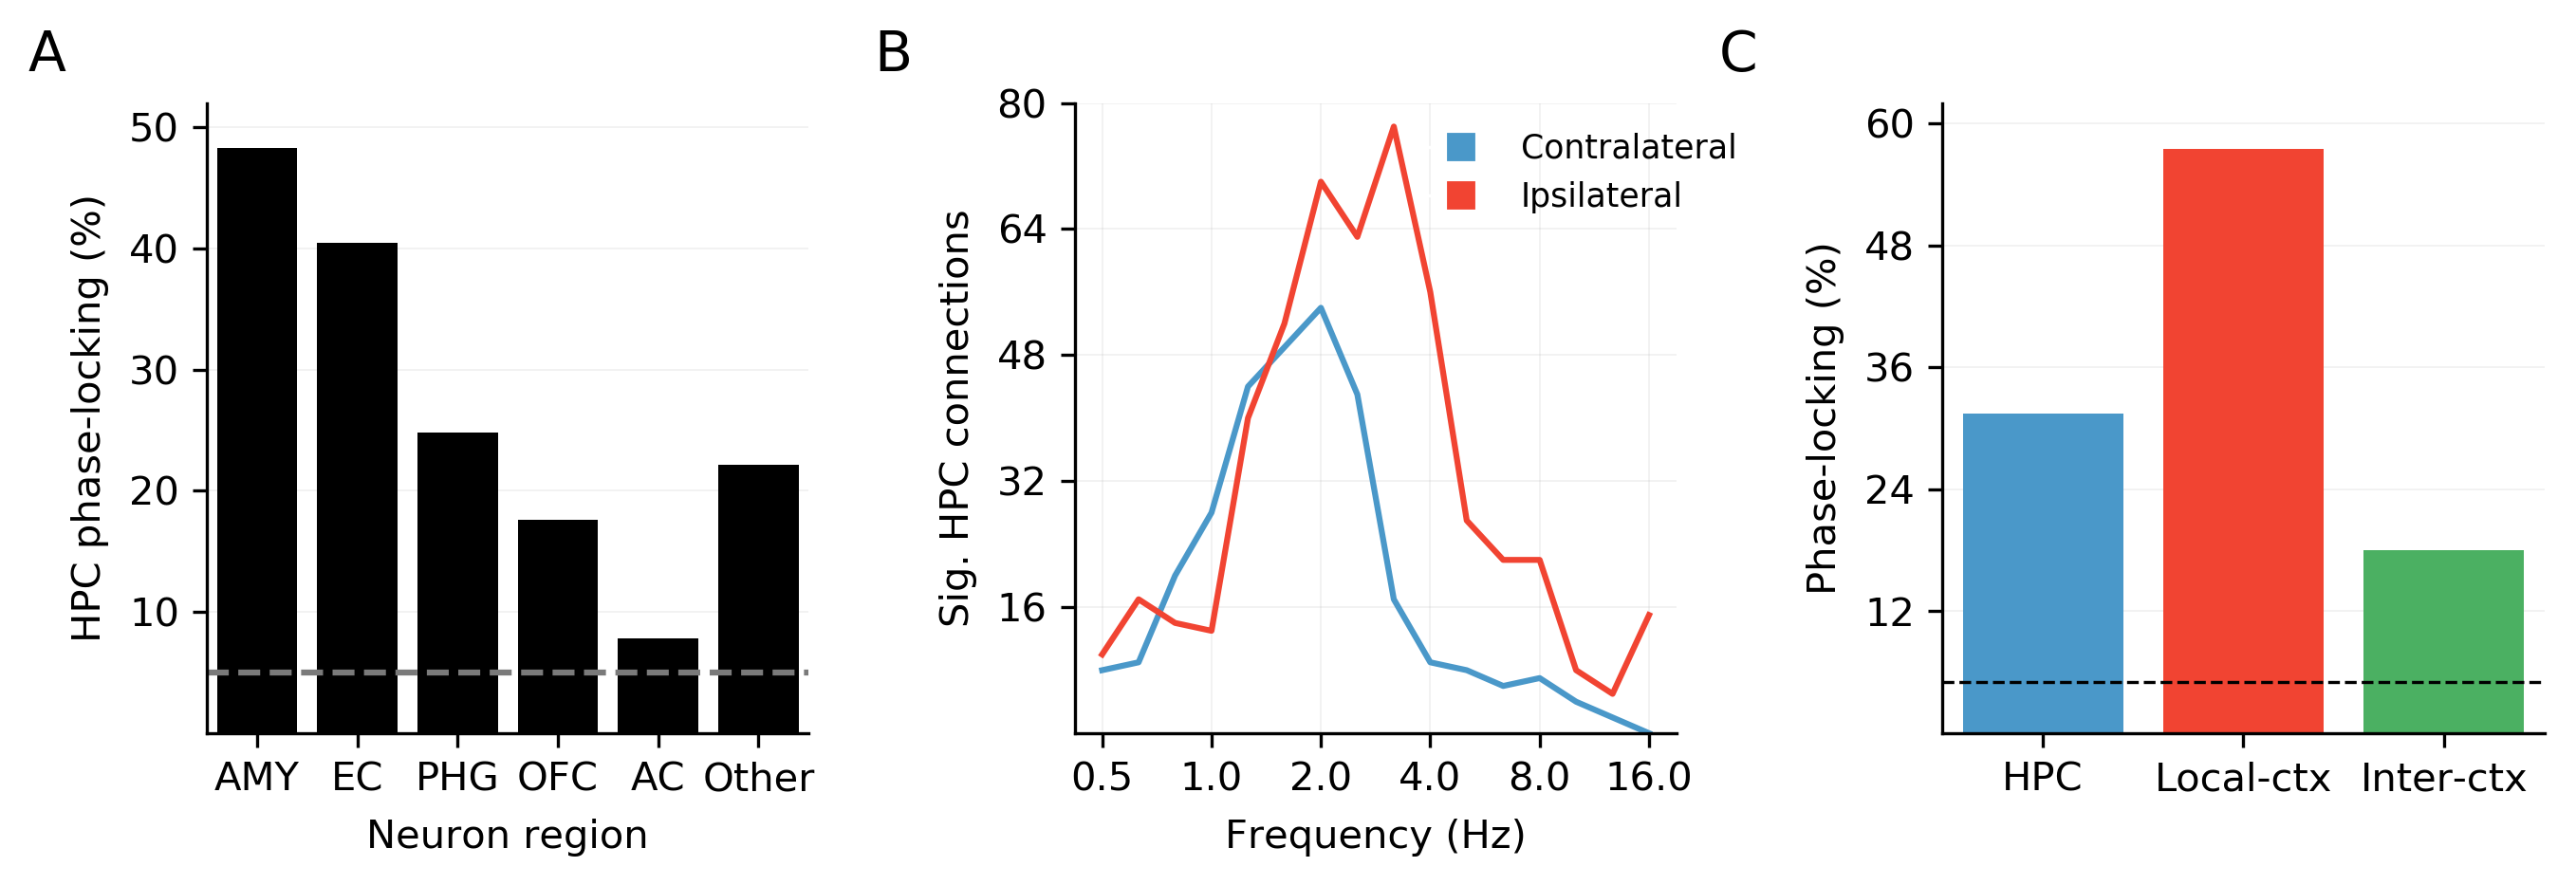

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 10
figfontsize = 14

# HPC phase-locking by region.
df = pl_df.query("(edge=='ctx-hpc')").groupby(['unit_roi2']).agg({'unit': len, 'sig_z': np.mean}).reset_index()
rois = OrderedDict([('amy', 'AMY'),
                    ('ec', 'EC'), 
                    ('phg', 'PHG'),
                    ('ofc', 'OFC'),
                    ('ac', 'AC'),
                    ('ctx', 'Other')])
df['unit_roi2'] = df.unit_roi2.astype('category').cat.reorder_categories(rois.keys(), ordered=True)

sns.barplot(x='unit_roi2', y='sig_z', data=df.reset_index(), color='k', saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color=colors[-1], linestyle='--', linewidth=1.5)
ax[0].set_xticklabels(rois.values(), fontsize=tickfontsize)
ax[0].set_ylim([0, 0.52])
ax[0].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax[0].set_yticklabels([10, 20, 30, 40, 50], fontsize=tickfontsize)
ax[0].set_xlabel('Neuron region', fontsize=labelfontsize, labelpad=5)
ax[0].set_ylabel('HPC phase-locking (%)', fontsize=labelfontsize, labelpad=5)

# HPC phase-locking by frequency.
edge_types = ['ctx-local', 'ctx-hpc', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx']
d = OrderedDict()
for edge_type in edge_types:
    d[edge_type] = OrderedDict()
    d_ = pl_df.query("(sig_z==True) & (same_hem==True) & (edge=='{}')".format(edge_type)).groupby(['locked_freq_ind_z']).size().to_dict()
    for ifreq in range(len(freqs)):
        d[edge_type][ifreq] = d_.get(ifreq, 0) #/ len(pl_df.query("(same_hem==True) & (edge=='{}')".format(edge_type)))
df_ipsi = pd.DataFrame(d).reset_index()
d = OrderedDict()
for edge_type in edge_types:
    d[edge_type] = OrderedDict()
    d_ = pl_df.query("(sig_z==True) & (same_hem==False) & (edge=='{}')".format(edge_type)).groupby(['locked_freq_ind_z']).size().to_dict()
    for ifreq in range(len(freqs)):
        d[edge_type][ifreq] = d_.get(ifreq, 0) #/ len(pl_df.query("(same_hem==True) & (edge=='{}')".format(edge_type)))
df_contra = pd.DataFrame(d).reset_index()

# ax[1].bar(x=df_ipsi['index'], height=df_ipsi['ctx-hpc'], width=1, color=colors[1], edgecolor=colors[1], linewidth=0.1, alpha=0.6)
# ax[1].bar(x=df_contra['index'], height=df_contra['ctx-hpc'], width=1, color=colors[0], edgecolor=colors[0], linewidth=0.1, alpha=0.6)
ax[1].plot(df_contra['index'], df_contra['ctx-hpc'], color=colors[0], linewidth=1.5)
ax[1].plot(df_ipsi['index'], df_ipsi['ctx-hpc'], color=colors[1], linewidth=1.5)
ax[1].set_xticks(np.arange(len(freqs))[::3])
ax[1].set_xticklabels(np.round(freqs[::3], 1), fontsize=tickfontsize)
ax[1].set_ylim([0, 80])
ax[1].set_yticks([16, 32, 48, 64, 80])
ax[1].set_yticklabels([16, 32, 48, 64, 80], fontsize=tickfontsize)
ax[1].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[1].set_ylabel('Sig. HPC connections', fontsize=labelfontsize, labelpad=5)
custom_lines = [Line2D([0], [0], marker='s', color='w', label='Contralateral', markerfacecolor=colors[0], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Ipsilateral', markerfacecolor=colors[1], markersize=8)]
legend = ax[1].legend(handles=custom_lines, loc=1, bbox_to_anchor=(1.15, 1))

# HPC vs. local vs. inter-cortical phase-locking rates.
df = (pl_df.query("(edge==['ctx-local', 'ctx-hpc', 'ctx-ctx'])")
      .groupby('edge').agg({'subj_sess_unit': len, 'sig_z': np.mean}).reset_index())[:3]
d_ = OrderedDict([('ctx-hpc', 'HPC'),
                  ('ctx-local', 'Local-ctx'),
                  ('ctx-ctx', 'Inter-ctx')])
df['cat'] = df.edge.apply(lambda x: d_[x])
df.cat = df.cat.astype('category').cat.reorder_categories(d_.values(), ordered=True)
sns.barplot(x='cat', y='sig_z', data=df, palette=colors, saturation=100, ax=ax[2])
ax[2].axhline(y=0.05, color='k', linestyle='--')
ax[2].set_xticklabels(d_.values(), fontsize=tickfontsize)
ax[2].set_ylim([0, .62])
ax[2].set_yticks([.12, .24, .36, .48, .6])
ax[2].set_yticklabels([12, 24, 36, 48, 60], fontsize=tickfontsize)
ax[2].set_xlabel('')
ax[2].set_ylabel('Phase-locking (%)', fontsize=labelfontsize, labelpad=5)

fig.text(0, 0.97, 'A', fontsize=figfontsize)
fig.text(0.33, 0.97, 'B', fontsize=figfontsize)
fig.text(0.66, 0.97, 'C', fontsize=figfontsize)
fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
#plt.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/PhaseLocking.eps', format='eps', dpi=300, bbox_inches='tight')

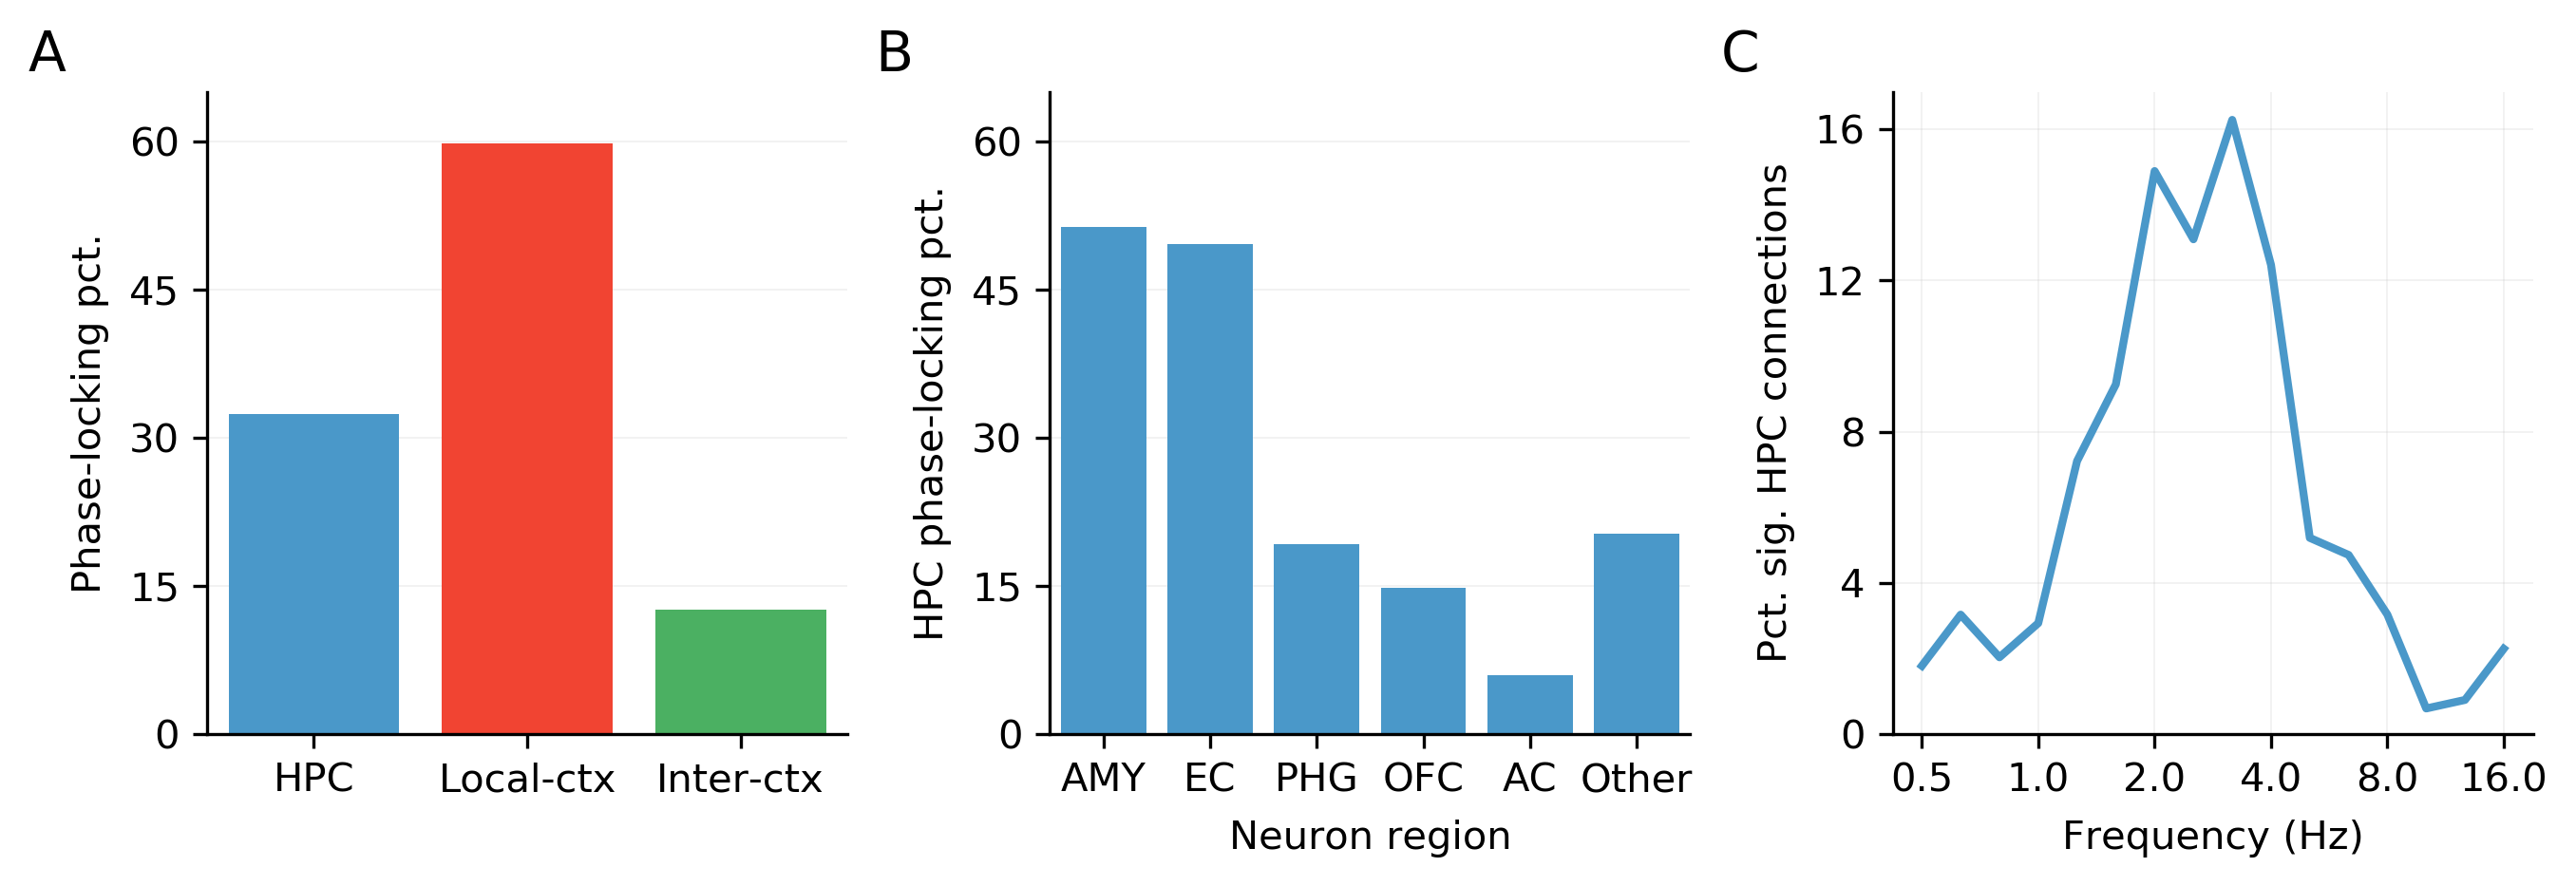

In [406]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 10
figfontsize = 14

# HPC vs. local vs. inter-cortical phase-locking rates.
df = (pl_df.query("(same_hem==True) & (edge==['ctx-local', 'ctx-hpc', 'ctx-ctx'])")
      .groupby('edge').agg({'subj_sess_unit': len, 'sig_z_fdr': np.mean}).reset_index())[:3]
d_ = OrderedDict([('ctx-hpc', 'HPC'),
                  ('ctx-local', 'Local-ctx'),
                  ('ctx-ctx', 'Inter-ctx')])
df['cat'] = df.edge.apply(lambda x: d_[x])
df.cat = df.cat.astype('category').cat.reorder_categories(d_.values(), ordered=True)
i = 0
sns.barplot(x='cat', y='sig_z_fdr', data=df, palette=colors, saturation=100, ax=ax[i])
#ax[i].axhline(y=0.05, color=colors[-1], linestyle='--', linewidth=1.5)
ax[i].set_xticklabels(d_.values(), fontsize=tickfontsize)
ax[i].set_ylim([0, 0.65])
ax[i].set_yticks([0, 0.15, 0.3, 0.45, 0.6])
ax[i].set_yticklabels([0, 15, 30, 45, 60], fontsize=tickfontsize)
ax[i].set_xlabel('')
ax[i].set_ylabel('Phase-locking pct.', fontsize=labelfontsize, labelpad=5)

# HPC phase-locking by region.
df = pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").groupby(['unit_roi2']).agg({'unit': len, 'sig_z_fdr': np.mean}).reset_index()
rois = OrderedDict([('amy', 'AMY'),
                    ('ec', 'EC'), 
                    ('phg', 'PHG'),
                    ('ofc', 'OFC'),
                    ('ac', 'AC'),
                    ('ctx', 'Other')])
df['unit_roi2'] = df.unit_roi2.astype('category').cat.reorder_categories(rois.keys(), ordered=True)
i = 1
sns.barplot(x='unit_roi2', y='sig_z_fdr', data=df.reset_index(), color=colors[0], saturation=100, ax=ax[i])
#ax[i].axhline(y=0.05, color=colors[-1], linestyle='--', linewidth=1.5)
ax[i].set_xticklabels(rois.values(), fontsize=tickfontsize)
ax[i].set_ylim([0, 0.65])
ax[i].set_yticks([0, 0.15, 0.3, 0.45, 0.6])
ax[i].set_yticklabels([0, 15, 30, 45, 60], fontsize=tickfontsize)
ax[i].set_xlabel('Neuron region', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC phase-locking pct.', fontsize=labelfontsize, labelpad=5)

# HPC phase-locking by frequency.

# # Get the FDR-corrected significance matrix (unit x frequency) for ctx-local connections.
# pvals_in = np.array(pl_df.loc[(pl_df.edge=='ctx-hpc') & (pl_df.same_hem==True), :]
#                     .apply(lambda x: list(  (1 + np.sum(x.bs_mrls_z >= np.expand_dims(x.mrls_z, axis=-1), axis=-1)) 
#                                           / (1 + n_bootstraps)), axis=1).tolist())
# shp = pvals_in.shape
# sig_out_all = sm.stats.multipletests(pvals_in.flatten(), alpha=0.05/len(freqs), method='fdr_tsbky', 
#                                      is_sorted=False, returnsorted=False)[0].reshape(shp)

edge_types = ['ctx-local', 'ctx-hpc', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx']
d = OrderedDict()
for edge_type in edge_types:
    d[edge_type] = OrderedDict()
    d_ = pl_df.query("(sig_z_fdr==True) & (same_hem==True) & (edge=='{}')".format(edge_type)).groupby(['locked_freq_ind_z']).size().to_dict()
    for ifreq in range(len(freqs)):
        d[edge_type][ifreq] = d_.get(ifreq, 0) / len(pl_df.query("(same_hem==True) & (edge=='{}') & (sig_z_fdr==True)".format(edge_type)))
df_ipsi = pd.DataFrame(d).reset_index()
i = 2
ax[i].plot(df_ipsi['index'], df_ipsi['ctx-hpc'], color=colors[0], linewidth=2)
# ax[i].plot(np.arange(len(freqs)), np.mean(sig_out_all, axis=0), color='k', linewidth=1.5)
ax[i].set_xticks(np.arange(len(freqs))[::3])
ax[i].set_xticklabels(np.round(freqs[::3], 1), fontsize=tickfontsize)
ax[i].set_ylim([0, .17])
ax[i].set_yticks([0, .04, .08, .12, .16])
ax[i].set_yticklabels([0, 4, 8, 12, 16], fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Pct. sig. HPC connections', fontsize=labelfontsize, labelpad=5)

fig.text(0, 0.97, 'A', fontsize=figfontsize)
fig.text(0.33, 0.97, 'B', fontsize=figfontsize)
fig.text(0.66, 0.97, 'C', fontsize=figfontsize)
fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
plt.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/sfn_2019_fig.png', format='png', dpi=300, bbox_inches='tight')

In [94]:
# Local > HPC phase-locking frequency
# Independent t-test
v1 = np.array([np.log10(freqs)[x] for x in pl_df.query("(edge=='ctx-local') & (sig_z_fdr==True) & (locked_freq_ind_z<15)").locked_freq_ind_z])
v2 = np.array([np.log10(freqs)[x] for x in pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True)").locked_freq_ind_z])
print((10**v1).mean(), (10**v1).std(), (10**v2).mean(), (10**v2).std())

print('df = {}'.format(len(v1) + len(v2) - 2))
print(stats.ttest_ind(v1, v2, equal_var=False))
print(stats.levene(v1, v2))

4.742383773426767 3.410642961850564 3.0294923410303993 2.5978241976428786
df = 1324
Ttest_indResult(statistic=10.361723406278282, pvalue=3.170182936920198e-24)
LeveneResult(statistic=22.13148741632583, pvalue=2.8126834894827117e-06)


In [267]:
# Local > HPC phase-locking frequency; strength
# Paired t-test (only among cells that are significantly
# phase-locked to both local and HPC oscillations)
df = pl_df.query("(edge=='ctx-hpc') & (sig_z==True)").copy()
n_bootstraps = 5000
alpha = 0.05 / len(freqs)
local_locked_freq_inds_z = []
local_locked_mrls_z = []
local_hpclocked_mrls_z = []
local_sig_z = []
for index, row in df.iterrows():
    subj_sess = row.subj_sess
    unit = row.unit
    locked_freq_ind_z = row.locked_freq_ind_z
    local_row = pl_df.query("(edge=='ctx-local') & (subj_sess=='{}') & (unit=={})".format(subj_sess, unit))
    local_locked_freq_inds_z.append(local_row.locked_freq_ind_z.iat[0]) # Local phase-locking freq
    local_locked_mrls_z.append(local_row.locked_mrl_z.iat[0]) # Local phase-locking strength at the local phase-locked freq
    local_hpclocked_mrls_z.append(local_row.mrls_z.iat[0][locked_freq_ind_z]) # Local phase-locking strength at the HPC phase-locked freq
    local_sig_z.append(local_row.sig_z.iat[0])
    
df['local_locked_freq_ind_z'] = local_locked_freq_inds_z
df['local_locked_mrl_z'] = local_locked_mrls_z
df['local_hpclocked_mrl_z'] = local_hpclocked_mrls_z
df['local_sig_z'] = local_sig_z
df = df.loc[df.local_sig_z==True]
print(df.shape)

# Local vs. HPC phase-locking preferred freqs
print('Local vs. HPC phase-locking preferred freqs')
v1 = np.array([np.log10(freqs)[x] for x in df.local_locked_freq_ind_z])
v2 = np.array([np.log10(freqs)[x] for x in df.locked_freq_ind_z])
print((10**v1).mean(), (10**v1).std(), (10**v2).mean(), (10**v2).std())
print('df = {}'.format(len(v1) - 1))
print(stats.pearsonr(v1, v2))
print(stats.ttest_rel(v1, v2))

# Local vs. HPC phase-locking strength at their respective preferred freqs
print('')
print('Local vs. HPC phase-locking strength at their respective preferred freqs')
v1 = np.array(df.local_locked_mrl_z.tolist())
v2 = np.array(df.locked_mrl_z.tolist())
print(v1.mean(), v1.std(), v2.mean(), v2.std())
print('df = {}'.format(len(v1) - 1))
print(stats.pearsonr(v1, v2))
print(stats.ttest_rel(v1, v2))

# Local vs. HPC phase-locking strength at the HPC phase-locking freq
print('')
print('Local vs. HPC phase-locking strength at the HPC phase-locking freq')
v1 = np.array(df.local_hpclocked_mrl_z.tolist())
v2 = np.array(df.locked_mrl_z.tolist())
print(v1.mean(), v1.std(), v2.mean(), v2.std())
print('df = {}'.format(len(v1) - 1))
print(stats.pearsonr(v1, v2))
print(stats.ttest_rel(v1, v2))

(634, 58)
Local vs. HPC phase-locking preferred freqs
5.96966199198771 5.019405292749277 3.153552778741946 2.7965608203133776
df = 633
(0.22709884859318874, 7.353711040557338e-09)
Ttest_relResult(statistic=14.280102900806952, pvalue=2.6312687528975084e-40)

Local vs. HPC phase-locking strength at their respective preferred freqs
12.911900924660689 11.451825505829062 7.421325314843372 5.485997683693471
df = 633
(0.3354069337831174, 3.9096012802980544e-18)
Ttest_relResult(statistic=12.658133579190606, pvalue=6.768162686036761e-33)

Local vs. HPC phase-locking strength at the HPC phase-locking freq
8.515301802464382 10.845037318159786 7.421325314843372 5.485997683693471
df = 633
(0.3506385408607177, 8.869475966464839e-20)
Ttest_relResult(statistic=2.6735089324217656, pvalue=0.007699842069415821)


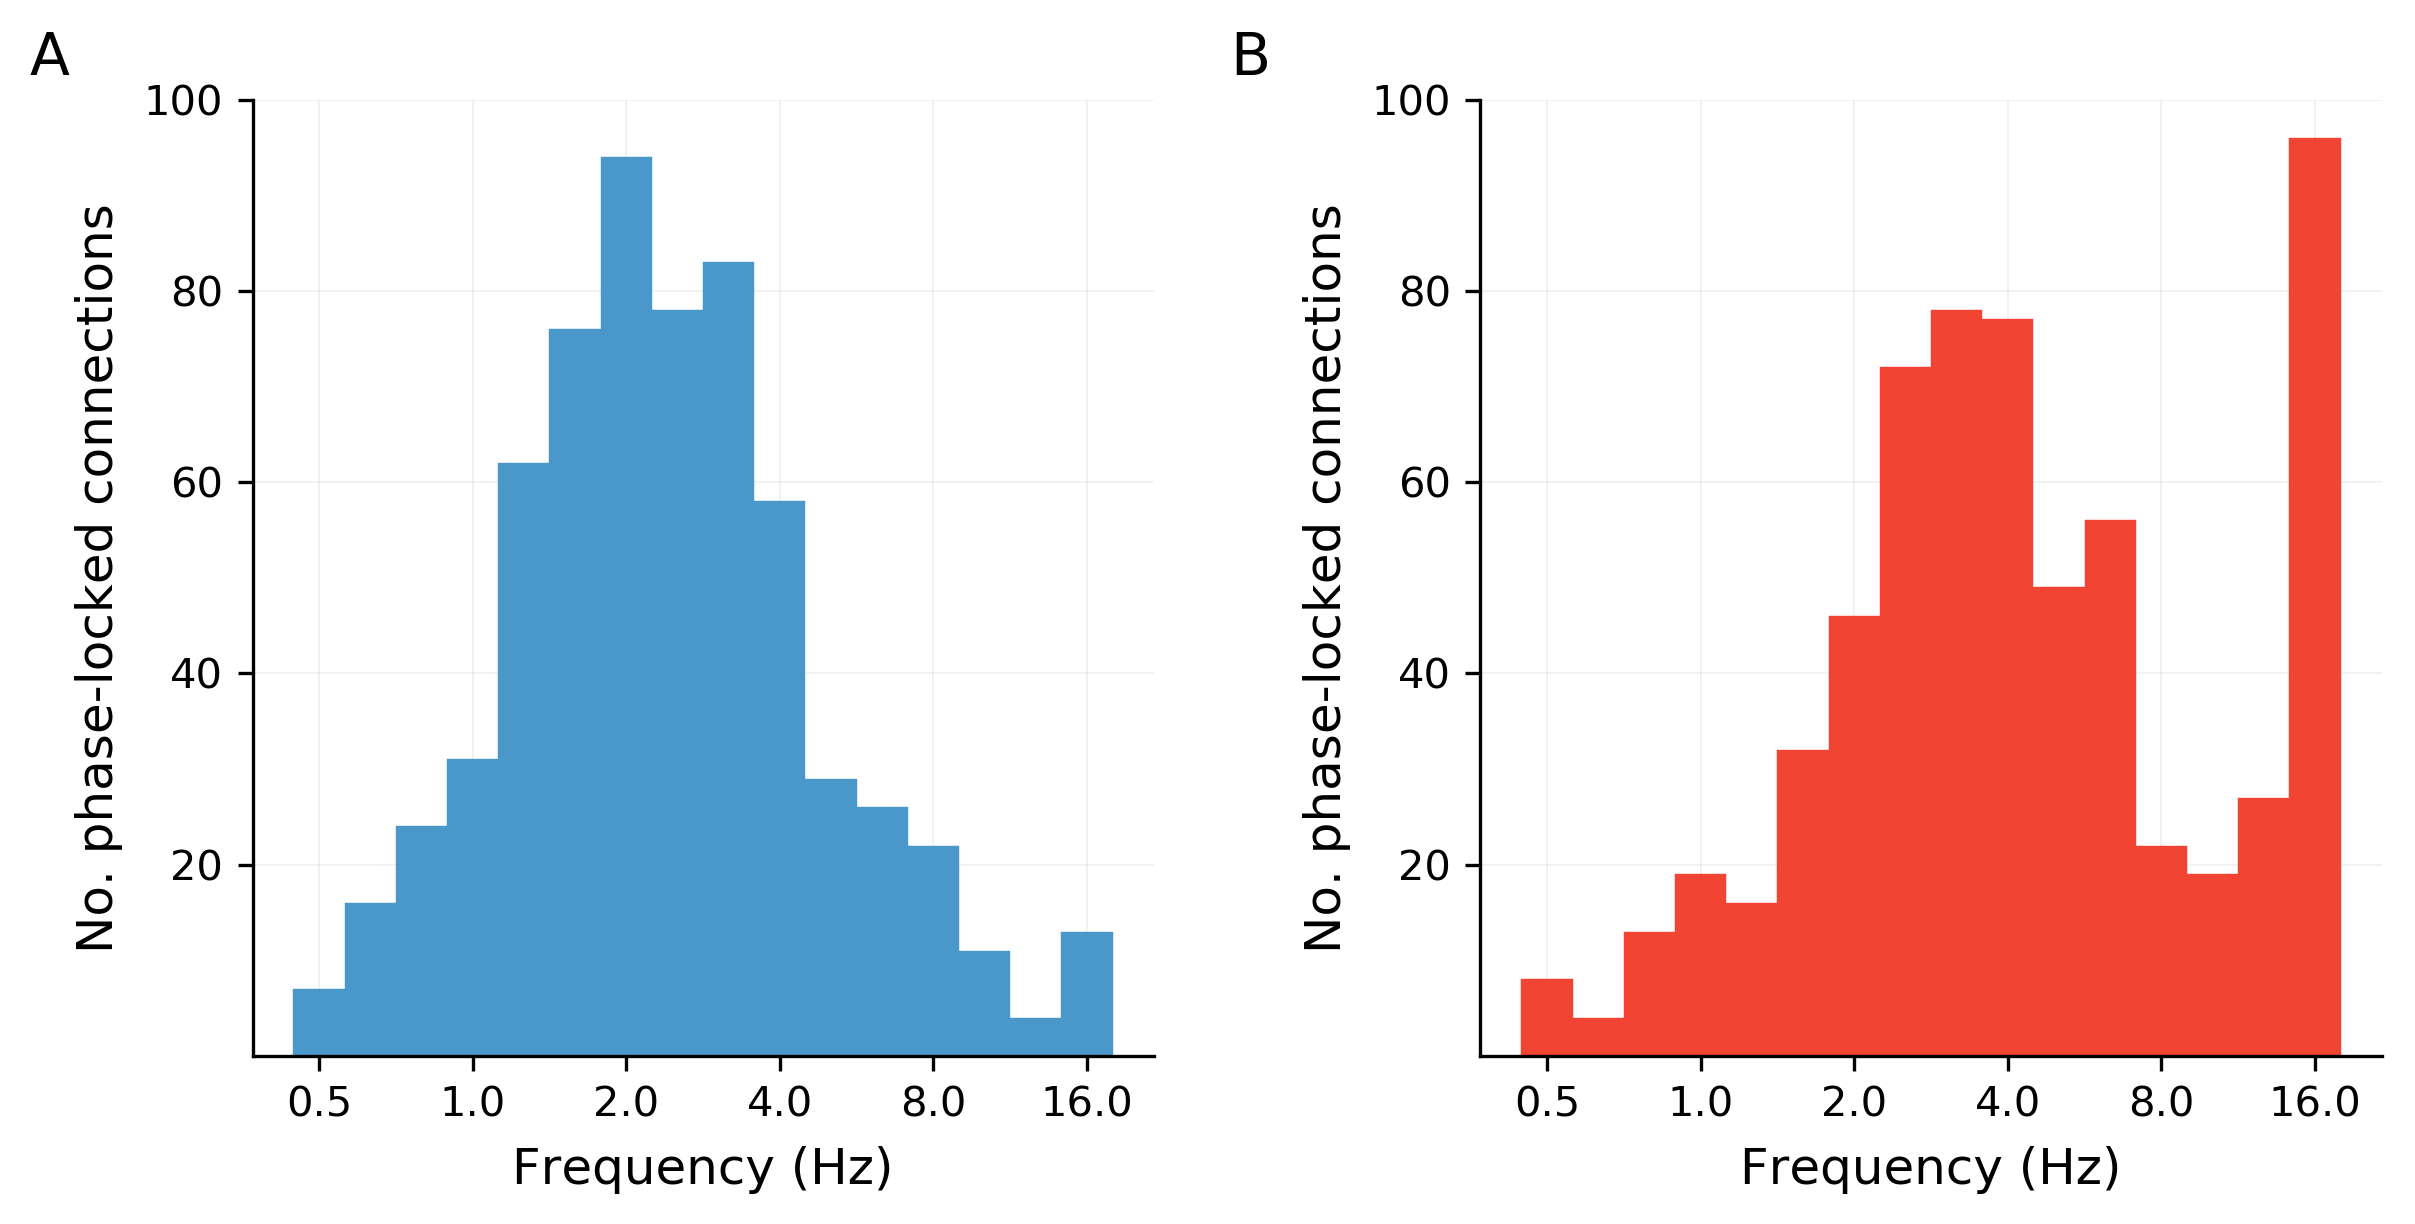

In [271]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 12
figfontsize = 14

# HPC phase-locking by frequency.
edge_types = ['ctx-local', 'ctx-hpc', 'ctx-ctx']
d = OrderedDict()

d['ctx-hpc'] = OrderedDict()
d_ = df.groupby(['locked_freq_ind_z']).size().to_dict()
for ifreq in range(len(freqs)):
    d['ctx-hpc'][ifreq] = d_.get(ifreq, 0)
    
d['ctx-local'] = OrderedDict()
d_ = df.groupby(['local_locked_freq_ind_z']).size().to_dict()
for ifreq in range(len(freqs)):
    d['ctx-local'][ifreq] = d_.get(ifreq, 0)
    
df_ = pd.DataFrame(d).reset_index()

ax[0].bar(x=df_['index'], height=df_['ctx-hpc'], width=1, color=colors[0], edgecolor=colors[0], linewidth=0.1)
ax[0].set_xticks(np.arange(len(freqs))[::3])
ax[0].set_xticklabels(np.round(freqs[::3], 1), fontsize=tickfontsize)
ax[0].set_ylim([0, 100])
ax[0].set_yticks([20, 40, 60, 80, 100])
ax[0].set_yticklabels([20, 40, 60, 80, 100], fontsize=tickfontsize)
ax[0].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[0].set_ylabel('No. phase-locked connections', fontsize=labelfontsize, labelpad=5)

ax[1].bar(x=df_['index'], height=df_['ctx-local'], width=1, color=colors[1], edgecolor=colors[1], linewidth=0.1)
ax[1].set_xticks(np.arange(len(freqs))[::3])
ax[1].set_xticklabels(np.round(freqs[::3], 1), fontsize=tickfontsize)
ax[1].set_ylim([0, 100])
ax[1].set_yticks([20, 40, 60, 80, 100])
ax[1].set_yticklabels([20, 40, 60, 80, 100], fontsize=tickfontsize)
ax[1].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[1].set_ylabel('No. phase-locked connections', fontsize=labelfontsize, labelpad=5)

fig.text(0, 0.97, 'A', fontsize=figfontsize)
fig.text(0.5, 0.97, 'B', fontsize=figfontsize)

fig.tight_layout(pad=1.08, w_pad=3.5, rect=[0, 0, 1, 1])
#plt.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/PhaseLockingComparison.eps', format='eps', dpi=300, bbox_inches='tight')

In [192]:
len(df), len(df.query("(locked_freq_ind_z>=6) & (locked_freq_ind_z<10) & (sig_z_fdr==True) & (local_hpcfreq_sig_z_fdr==False)"))

(2607, 102)

In [208]:
freqs[7]

2.519842099789747

In [209]:
df.loc[df.index==3499].locked_mrl_z

3499    14.058464
Name: locked_mrl_z, dtype: float64

In [193]:
(df
 .query("(locked_freq_ind_z>=6) & (locked_freq_ind_z<10) & (sig_z_fdr==True) & (local_hpcfreq_sig_z_fdr==False)")
 .sort_values('locked_mrl_z', ascending=False))

subj_sess subj_sess_unit unit unit_chan_ind unit_hemroi unit_hem  \
8568    U381_ses3    U381_ses3_2    2             2          RA        R   
3963    U371_env1    U371_env1_9    9            24         LEC        L   
3499    U371_env1   U371_env1_10   10            24         LEC        L   
3483    U371_env1    U371_env1_0    0             9         REC        R   
12008   U385_ses1   U385_ses1_21   21            22         LEC        L   
8728    U381_ses3   U381_ses3_38   38            34          LA        L   
4174    U371_env2   U371_env2_32   32            50         LPG        L   
3486    U371_env1    U371_env1_0    0             9         REC        R   
12004   U385_ses1   U385_ses1_21   21            22         LEC        L   
4758    U371_env3   U371_env3_57   57            59          LA        L   
11538   U395_ses1    U395_ses1_2    2             0          RA        R   
10352   U387_ses3   U387_ses3_18   18            45         LPG        L   
4790    U371_env3   U371_env3_61   61            62          LA        L   
11744   U396_ses2    U396_ses2_4    4            26         LEC        L   
12106   U385_ses1   U385_ses1_34   34            38         LOF        L   
3510    U371_env1   U371_env1_11   11            25         LEC        L   
4787    U371_env3   U371_env3_61   61            62          LA        L   
5028    U372_ses2   U372_ses2_12   12            19          LA        L   
5036    U372_ses2   U372_ses2_14   14            27         LEC        L   
8724    U381_ses3   U381_ses3_38   38            34          LA        L   
12186   U385_ses1   U385_ses1_47   47            51         LTP        L   
4766    U371_env3   U371_env3_58   58            59          LA        L   
5316    U373_ses1   U373_ses1_16   16            33         LEC        L   
4755    U371_env3   U371_env3_57   57            59          LA        L   
10104   U387_ses2    U387_ses2_1    1            10         ROF        R   
9659    U384_ses2   U384_ses2_38   38            44         LEC        L   
181     U369_env2    U369_env2_3    3             6          RA        R   
8256    U381_ses2   U381_ses2_27   27            34          LA        L   
1638    U381_ses1    U381_ses1_4    4             2          RA        R   
4339    U371_env2    U371_env2_7    7            28         LEC        L   
...           ...            ...  ...           ...         ...      ...   
4438    U371_env3   U371_env3_19   19            29         LEC        L   
4398    U371_env3   U371_env3_12   12            24         LEC        L   
12351   U385_ses2   U385_ses2_22   22            37         LOF        L   
4868    U372_ses1   U372_ses1_12   12            44         LPG        L   
12704   U385_ses3   U385_ses3_40   40            49         LTP        L   
8104    U381_ses2    U381_ses2_1    1             0          RA        R   
9843    U384_ses2   U384_ses2_59   59            62         LOF        L   
5852    U373_ses2   U373_ses2_30   30            33         LEC        L   
5153    U372_ses2   U372_ses2_27   27            47         LPG        L   
3555    U371_env1   U371_env1_17   17            29         LEC        L   
4731    U371_env3   U371_env3_54   54            58          LA        L   
2249    U390_ses1    U390_ses1_7    7            14         RPG        R   
11983   U385_ses1   U385_ses1_18   18            20         LEC        L   
8396    U381_ses2   U381_ses2_43   43            43         LEC        L   
11997   U385_ses1   U385_ses1_20   20            22         LEC        L   
1526    U381_ses1   U381_ses1_25   25            33          LA        L   
7802    U380_ses3   U380_ses3_17   17            13         REC        R   
12382   U385_ses2   U385_ses2_27   27            42         LAC        L   
1106   U380_ses1a  U380_ses1a_35   35            41         RMC        R   
2129    U384_ses3   U384_ses3_57   57            62         LOF        L   
11062   U393_ses2   U393_ses2_34   34            46     

Text(0, 0.5, 'Local phase-locking strength (Z)')

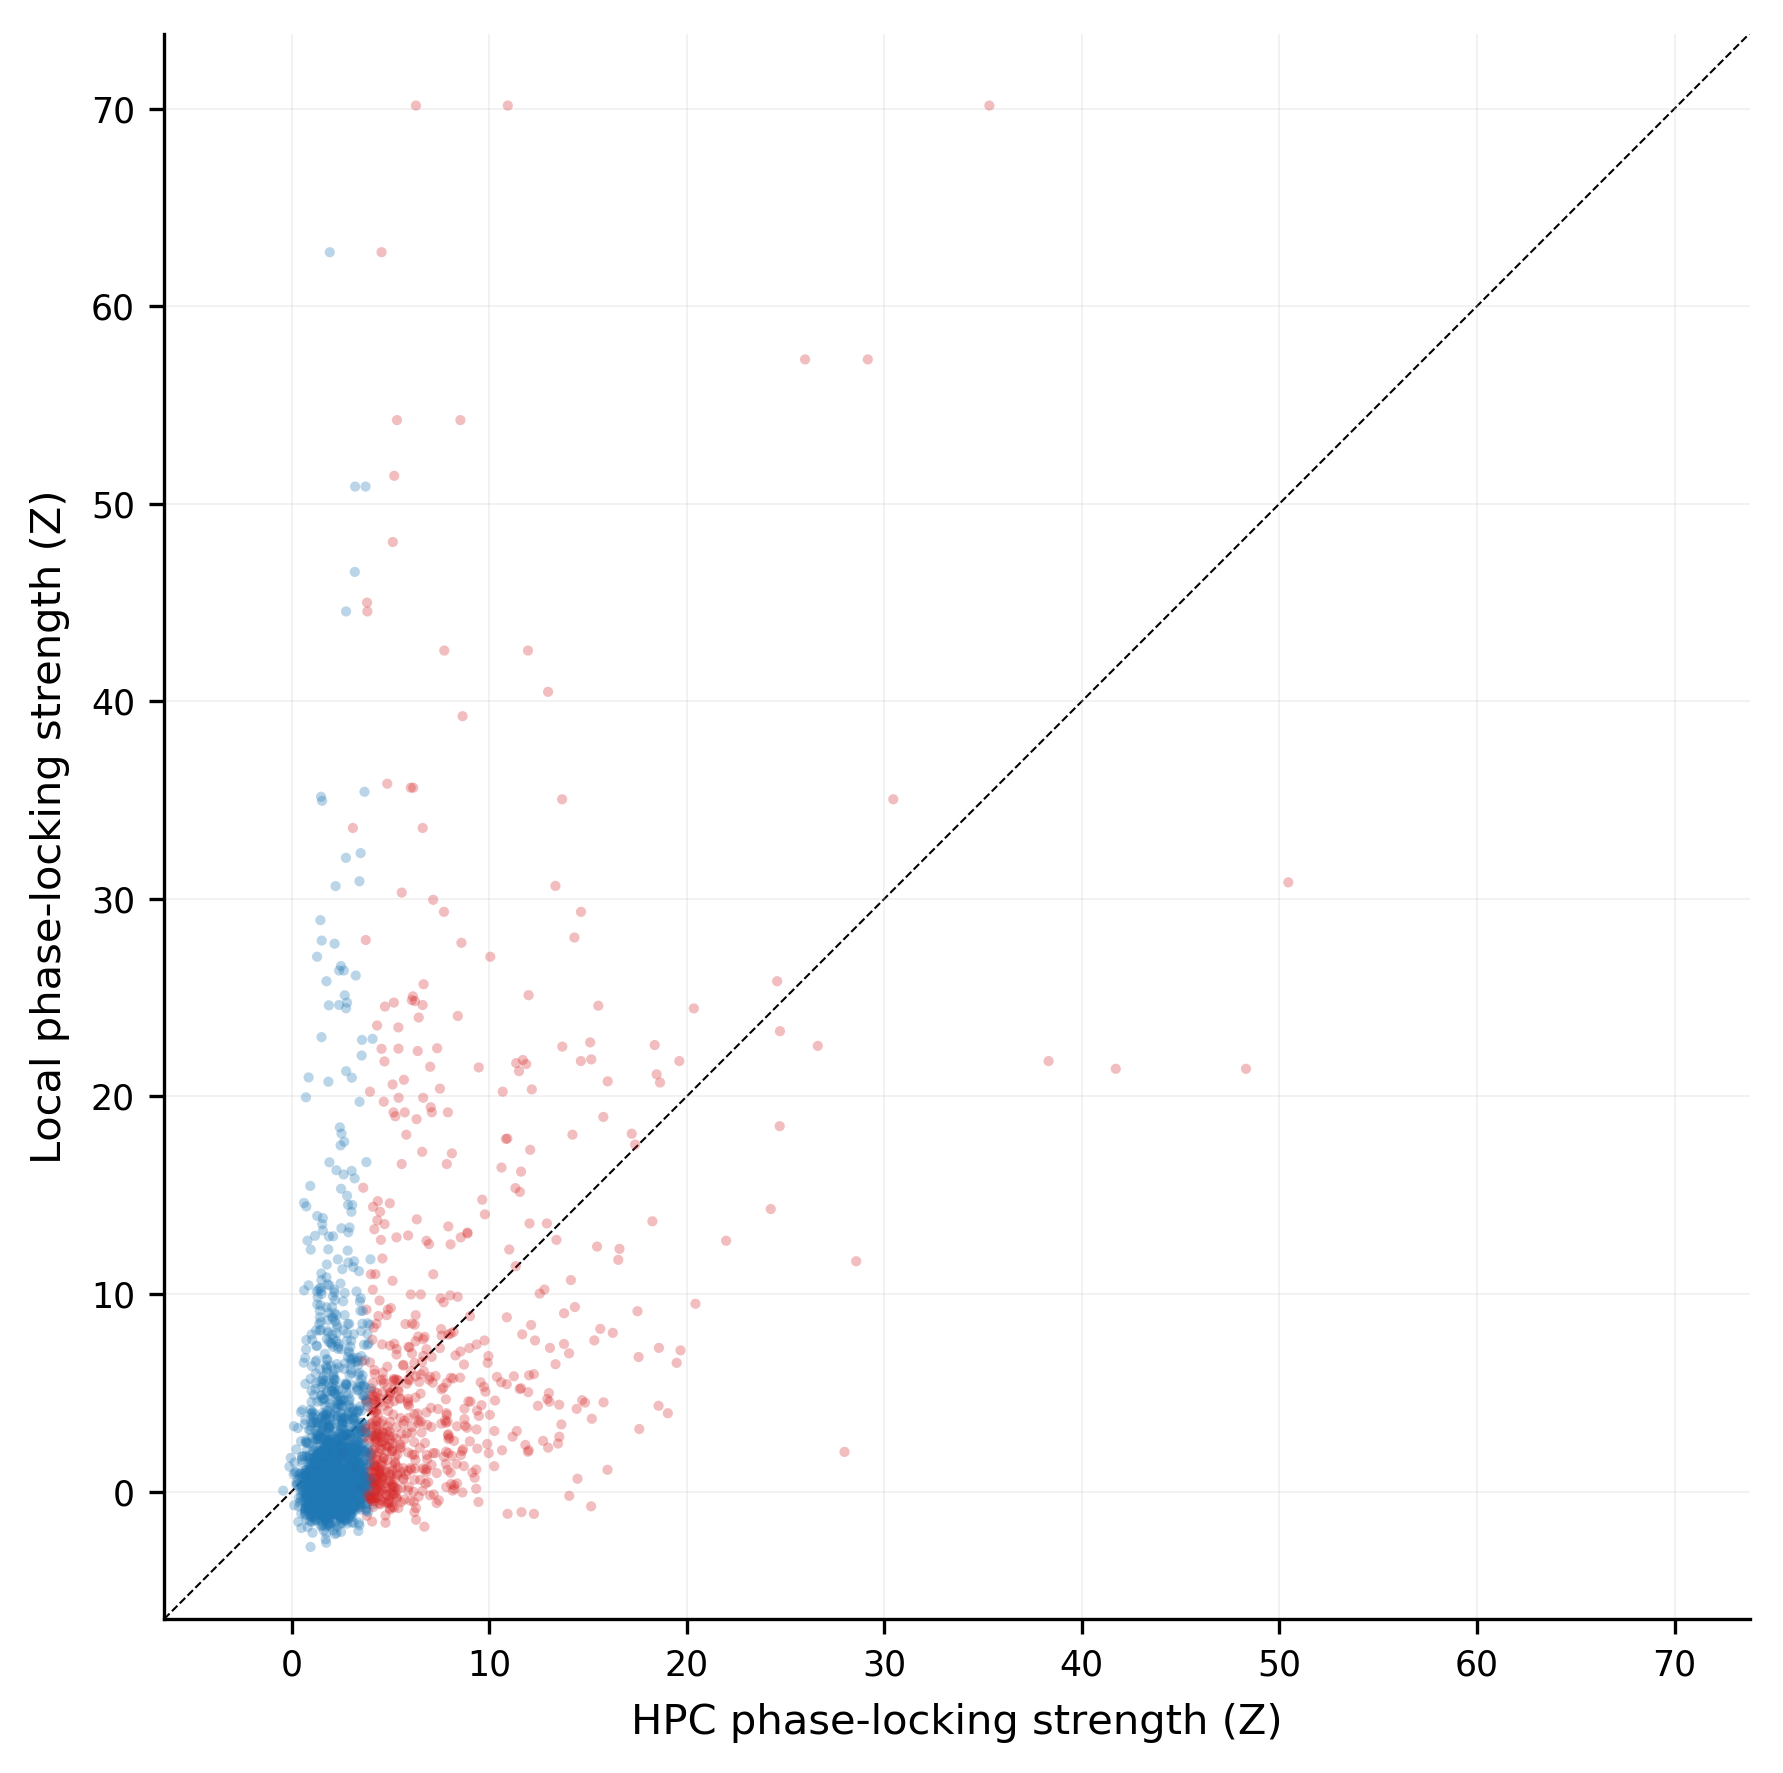

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), dpi=300)

sns.scatterplot('locked_mrl_z', 'local_hpcfreq_mrl_z', hue='sig_z_fdr', 
                linewidth=0, s=6, alpha=0.3, legend=False, data=df)

lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, color='k', linewidth=0.5, linestyle='--', zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel('HPC phase-locking strength (Z)', fontsize=labelfontsize, labelpad=5)
ax.set_ylabel('Local phase-locking strength (Z)', fontsize=labelfontsize, labelpad=5)

In [187]:
# Sig. HPC but not local phase-locking
n = len(pl_df.query("(edge=='ctx-hpc')"))
df = pl_df.query("(edge=='ctx-hpc')").copy()
local_inds = pl_df.loc[(pl_df.edge=='ctx-local'), :].index.tolist()
n_bootstraps = 5000

# Get the unit x frequency pvals for ctx-local connections.
pvals_in = np.array(pl_df.loc[(pl_df.edge=='ctx-local'), :]
                    .apply(lambda x: list(  (1 + np.sum(x.bs_mrls_z >= np.expand_dims(x.mrls_z, axis=-1), axis=-1)) 
                                          / (1 + n_bootstraps)), axis=1).tolist())
local_localfreq_mrl_z = []
local_hpcfreq_mrl_z = []
local_localfreq_sig_z_fdr = []
local_hpcfreq_pvals = []
for index, row in df.iterrows():
    subj_sess = row.subj_sess
    unit = row.unit
    locked_freq_ind_z = row.locked_freq_ind_z
    local_row = pl_df.query("(edge=='ctx-local') & (subj_sess=='{}') & (unit=={})".format(subj_sess, unit))
    local_localfreq_mrl_z.append(local_row.locked_mrl_z.iat[0])
    local_hpcfreq_mrl_z.append(local_row.mrls_z.iat[0][locked_freq_ind_z])
    local_localfreq_sig_z_fdr.append(local_row.sig_z_fdr.iat[0])
    local_hpcfreq_pvals.append(pvals_in[local_inds.index(local_row.index[0]), locked_freq_ind_z])
    #local_hpcfreq_pvals.append(pvals_in[np.random.randint(0, len(pvals_in)), locked_freq_ind_z])

df['local_localfreq_mrl_z'] = local_localfreq_mrl_z
df['local_hpcfreq_mrl_z'] = local_hpcfreq_mrl_z
df['local_localfreq_sig_z_fdr'] = local_localfreq_sig_z_fdr
df['local_hpcfreq_sig_z_fdr'] = list(sm.stats.multipletests(local_hpcfreq_pvals, alpha=0.05, method='fdr_tsbky', 
                                                            is_sorted=False, returnsorted=False)[0])

print(df.shape)

(2607, 62)


In [164]:
# Sig. HPC but not local phase-locking
n = len(pl_df.query("(edge=='ctx-hpc')"))
df = pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True)").copy()
local_inds = pl_df.loc[(pl_df.edge=='ctx-local'), :].index.tolist()
n_bootstraps = 5000

# Get the unit x frequency pvals for ctx-local connections.
pvals_in = np.array(pl_df.loc[(pl_df.edge=='ctx-local'), :]
                    .apply(lambda x: list(  (1 + np.sum(x.bs_mrls_z >= np.expand_dims(x.mrls_z, axis=-1), axis=-1)) 
                                          / (1 + n_bootstraps)), axis=1).tolist())
local_localfreq_mrl_z = []
local_hpcfreq_mrl_z = []
local_localfreq_sig_z_fdr = []
local_hpcfreq_pvals = []
for index, row in df.iterrows():
    subj_sess = row.subj_sess
    unit = row.unit
    locked_freq_ind_z = row.locked_freq_ind_z
    local_row = pl_df.query("(edge=='ctx-local') & (subj_sess=='{}') & (unit=={})".format(subj_sess, unit))
    local_localfreq_mrl_z.append(local_row.locked_mrl_z.iat[0])
    local_hpcfreq_mrl_z.append(local_row.mrls_z.iat[0][locked_freq_ind_z])
    local_localfreq_sig_z_fdr.append(local_row.sig_z_fdr.iat[0])
    local_hpcfreq_pvals.append(pvals_in[local_inds.index(local_row.index[0]), locked_freq_ind_z])
    #local_hpcfreq_pvals.append(pvals_in[np.random.randint(0, len(pvals_in)), locked_freq_ind_z])

df['local_localfreq_mrl_z'] = local_localfreq_mrl_z
df['local_hpcfreq_mrl_z'] = local_hpcfreq_mrl_z
df['local_localfreq_sig_z_fdr'] = local_localfreq_sig_z_fdr
df['local_hpcfreq_sig_z_fdr'] = list(sm.stats.multipletests(local_hpcfreq_pvals, alpha=0.05, method='fdr_tsbky', 
                                                            is_sorted=False, returnsorted=False)[0])

print(df.shape)

s1 = len(df.query("local_hpcfreq_sig_z_fdr==False"))
s2 = len(df.query("local_localfreq_sig_z_fdr==False"))
print('{}/{} ({:.1f}%) of neuron-HPC connections are significantly phase-locked to the HPC but not to the local LFP at the HPC preferred freq'
      .format(s1, n, 100 * (s1/n)))
print(stats.binom_test(x=s1, n=n, p=0.05))
print('{}/{} ({:.1f}%) of neuron-HPC connections are significantly phase-locked to the HPC but not to the local LFP at any freq'
      .format(s2, n, 100 * (s2/n)))
print(stats.binom_test(x=s2, n=n, p=0.05))

print('{:.1f}% of significantly phase-locked HPC connections are not phase-locked to the local field at the preferred HPC freq'
      .format(100 * s1/len(df)))

(659, 62)
175/2607 (6.7%) of neuron-HPC connections are significantly phase-locked to the HPC but not to the local LFP at the HPC preferred freq
0.00012919927797974532
112/2607 (4.3%) of neuron-HPC connections are significantly phase-locked to the HPC but not to the local LFP at any freq
0.1055304518535341
26.6% of significantly phase-locked HPC connections are not phase-locked to the local field at the preferred HPC freq


In [112]:
print(df.local_localfreq_sig_z_fdr.mean(), df.local_hpcfreq_sig_z_fdr.mean())
print(stats.pearsonr(df.locked_mrl_z, df.local_localfreq_mrl_z), 
      stats.pearsonr(df.locked_mrl_z, df.local_hpcfreq_mrl_z),
      stats.pearsonr(df.local_localfreq_mrl_z, df.local_hpcfreq_mrl_z))

0.8300455235204856 0.7344461305007587
(0.35757190776143283, 2.6193505334784336e-21) (0.3662787952676965, 2.361930465176635e-22) (0.8783176511370794, 9.539739302647931e-213)


In [101]:
# Sig. HPC but not local phase-locking
n = len(pl_df.query("(edge=='ctx-hpc')"))
df = pl_df.query("(edge=='ctx-hpc') & (sig_z==True)").copy()
n_bootstraps = 5000
alpha = 0.05 / len(freqs)
local_hpcfreq_sig_z = []
local_localfreq_sig_z = []
for index, row in df.iterrows():
    subj_sess = row.subj_sess
    unit = row.unit
    locked_freq_ind_z = row.locked_freq_ind_z
    local_row = pl_df.query("(edge=='ctx-local') & (subj_sess=='{}') & (unit=={})".format(subj_sess, unit))
    local_hpcfreq_sig_z.append((  (1 + np.sum(local_row.bs_mrls_z.iat[0][locked_freq_ind_z, :] >= local_row.mrls_z.iat[0][locked_freq_ind_z])) 
                                / (1 + n_bootstraps)
                               ) < alpha)
    local_localfreq_sig_z.append(local_row.sig_z.iat[0])
    
df['local_hpcfreq_sig_z'] = local_hpcfreq_sig_z
df['local_localfreq_sig_z'] = local_localfreq_sig_z
print(df.shape)

s1 = len(df.query("local_hpcfreq_sig_z==False"))
s2 = len(df.query("local_localfreq_sig_z==False"))
print('{}/{} ({:.1f}%) of neuron-HPC connections are significantly phase-locked to the HPC but not to the local LFP at the HPC preferred freq'
      .format(s1, n, 100 * (s1/n)))
print(stats.binom_test(x=s1, n=n, p=0.05))
print('{}/{} ({:.1f}%) of neuron-HPC connections are significantly phase-locked to the HPC but not to the local LFP at any freq'
      .format(s2, n, 100 * (s2/n)))
print(stats.binom_test(x=s2, n=n, p=0.05))

print('{:.1f}% of significantly phase-locked HPC connections are not phase-locked to the local field at the preferred HPC freq'
      .format(100 * s1/len(df)))

(819, 60)
419/2607 (16.1%) of neuron-HPC connections are significantly phase-locked to the HPC but not to the local LFP at the HPC preferred freq
5.532257464389791e-97
185/2607 (7.1%) of neuron-HPC connections are significantly phase-locked to the HPC but not to the local LFP at any freq
3.4427372146897057e-06
51.2% of significantly phase-locked HPC connections are not phase-locked to the local field at the preferred HPC freq


In [275]:
# Local > HPC phase-locking frequency; strength
# Paired t-test (only among cells that are significantly
# phase-locked to both local and HPC oscillations)
df = pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True)").copy()
n_bootstraps = 5000
alpha = 0.05 / len(freqs)
local_locked_freq_inds_z = []
local_locked_mrls_z = []
local_hpclocked_mrls_z = []
local_sig = []
for index, row in df.iterrows():
    subj_sess = row.subj_sess
    unit = row.unit
    locked_freq_ind_z = row.locked_freq_ind_z
    local_row = pl_df.query("(edge=='ctx-local') & (subj_sess=='{}') & (unit=={})".format(subj_sess, unit))
    local_locked_freq_inds_z.append(local_row.locked_freq_ind_z.iat[0]) # Local phase-locking freq
    local_locked_mrls_z.append(local_row.locked_mrl_z.iat[0]) # Local phase-locking strength at the local phase-locked freq
    local_hpclocked_mrls_z.append(local_row.mrls_z.iat[0][locked_freq_ind_z]) # Local phase-locking strength at the HPC phase-locked freq
    local_sig.append(local_row.sig.iat[0])
    
df['local_locked_freq_ind_z'] = local_locked_freq_inds_z
df['local_locked_mrl_z'] = local_locked_mrls_z
df['local_hpclocked_mrl_z'] = local_hpclocked_mrls_z
df['local_sig'] = local_sig
print(df.shape)

# Local vs. HPC phase-locking strength at the HPC phase-locking freq
print('')
print('Local vs. HPC phase-locking strength at the HPC phase-locking freq')
v1 = np.array(df.local_hpclocked_mrl_z.tolist())
v2 = np.array(df.locked_mrl_z.tolist())
print(v1.mean(), v1.std(), v2.mean(), v2.std())
print('df = {}'.format(len(v1) - 1))
print(stats.pearsonr(v1, v2))
print(stats.ttest_rel(v1, v2))

(819, 58)

Local vs. HPC phase-locking strength at the HPC phase-locking freq
6.7288792076264095 10.11273112204566 6.892259978946218 5.040061714510701
df = 818
(0.38192183206872826, 7.751774377199243e-30)
Ttest_relResult(statistic=-0.496048712097882, pvalue=0.619993296423369)


In [276]:
# Intercortical > HPC phase-locking frequency
# Independent t-test
v1 = np.array([np.log10(freqs)[x] for x in pl_df.query("(edge=='ctx-ctx') & (sig_z==True)").locked_freq_ind_z])
v2 = np.array([np.log10(freqs)[x] for x in pl_df.query("(edge=='ctx-hpc') & (sig_z==True)").locked_freq_ind_z])
print((10**v1).mean(), (10**v1).std(), (10**v2).mean(), (10**v2).std())

print('df = {}'.format(len(v1) + len(v2) - 2))
print(stats.ttest_ind(v1, v2, equal_var=False))
print(stats.levene(v1, v2))

3.3417217977200537 3.1565064417874353 3.0147558862339836 2.760209054970129
df = 2024
Ttest_indResult(statistic=0.7941143814838496, pvalue=0.4272275020570906)
LeveneResult(statistic=36.98304999986092, pvalue=1.4207221802344218e-09)


In [277]:
# Hippocampal vs. intercortical phase-locking to low theta (2-4Hz).
# Chi square tests for independence of proportions.
hpc_nsig = np.sum(pl_df.query("(edge=='ctx-hpc') & (sig_z==True)").locked_low_theta_z==0)
hpc_sig = np.sum(pl_df.query("(edge=='ctx-hpc') & (sig_z==True)").locked_low_theta_z==1)
inter_nsig = np.sum(pl_df.query("(edge=='ctx-ctx') & (sig_z==True)").locked_low_theta_z==0)
inter_sig = np.sum(pl_df.query("(edge=='ctx-ctx') & (sig_z==True)").locked_low_theta_z==1)
local_nsig = np.sum(pl_df.query("(edge=='ctx-local') & (sig_z==True)").locked_low_theta_z==0)
local_sig = np.sum(pl_df.query("(edge=='ctx-local') & (sig_z==True)").locked_low_theta_z==1)

print('{}/{} ({:.1f}%) HPC connections are locked to 2-4Hz low theta'.format(hpc_sig, (hpc_sig+hpc_nsig), 
                                                                             100 * (hpc_sig / (hpc_sig+hpc_nsig))))
print('{}/{} ({:.1f}%) intercortical connections are locked to 2-4Hz low theta'.format(inter_sig, (inter_sig+inter_nsig), 
                                                                                       100 * (inter_sig / (inter_sig+inter_nsig))))
print('{}/{} ({:.1f}%) local connections are locked to 2-4Hz low theta'.format(local_sig, (local_sig+local_nsig), 
                                                                               100 * (local_sig / (local_sig+local_nsig))))

obs = [[hpc_nsig, hpc_sig], [inter_nsig, inter_sig]]
display(obs)
print('df = {}'.format(np.prod(np.array(np.array(obs).shape) - 1)))
print('HPC and intercortical low theta phase-locking proportions differ:', stats.chi2_contingency(obs)[:2])

obs = [[hpc_nsig, hpc_sig], [local_nsig, local_sig]]
display(obs)
print('df = {}'.format(np.prod(np.array(np.array(obs).shape) - 1)))
print('HPC and local low theta phase-locking proportions differ:', stats.chi2_contingency(obs)[:2])

389/819 (47.5%) HPC connections are locked to 2-4Hz low theta
434/1207 (36.0%) intercortical connections are locked to 2-4Hz low theta
251/775 (32.4%) local connections are locked to 2-4Hz low theta


[[430, 389], [773, 434]]

df = 1
HPC and intercortical low theta phase-locking proportions differ: (26.462538234139707, 2.6869872458141236e-07)


[[430, 389], [524, 251]]

df = 1
HPC and local low theta phase-locking proportions differ: (37.20639521558699, 1.0626471661063962e-09)


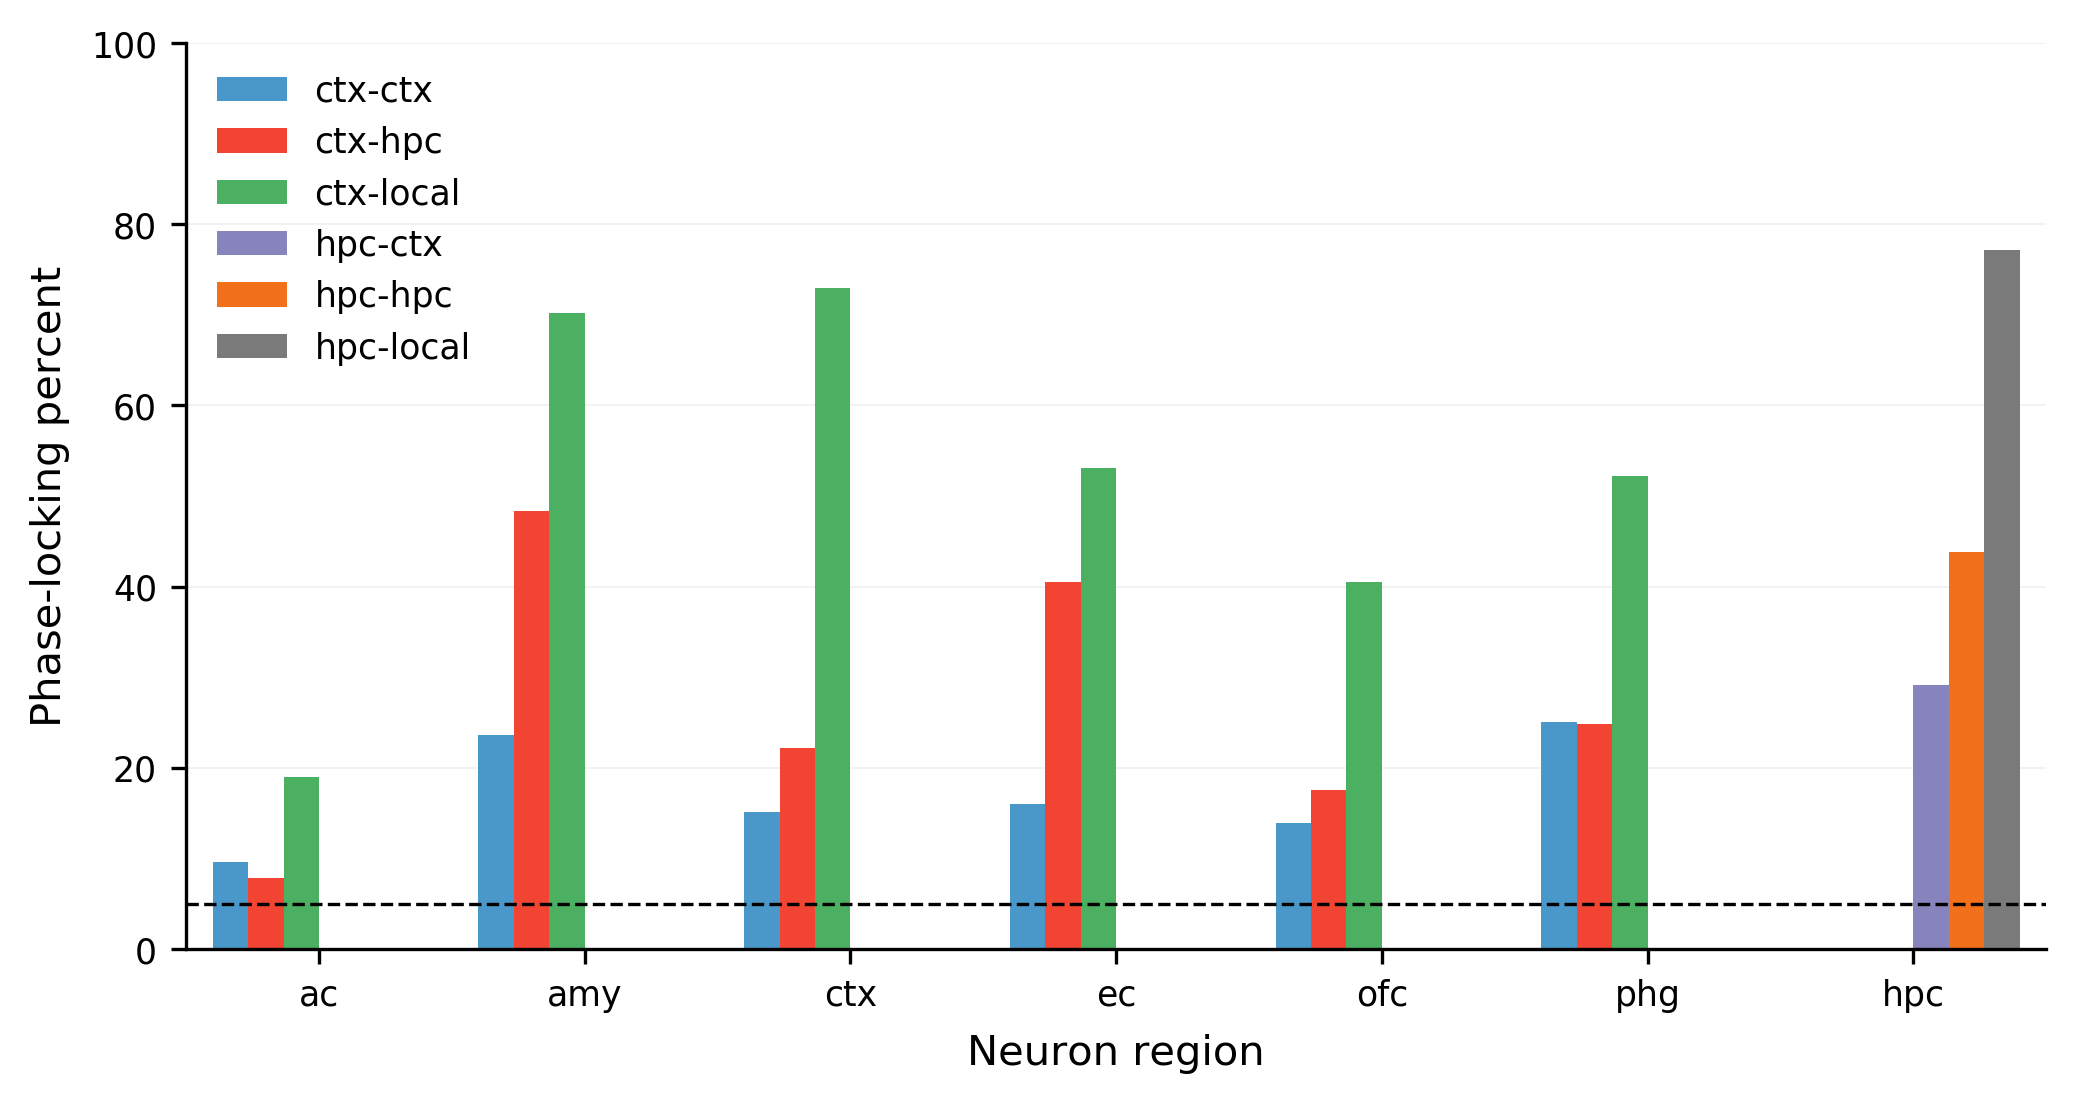

In [278]:
# What percent of units, by region, are phase-locked to local and HPC LFPs?
df = pl_df.groupby(['edge', 'unit_roi2']).agg({'subj_sess_unit': len, 'sig_z': np.mean})

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='unit_roi2', y='sig_z', data=df.reset_index(), hue='edge', palette=colors, saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
#ax[0].set_xticklabels([roi.upper() for roi in rois])
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_yticklabels([0, 20, 40, 60, 80, 100])
ax[0].set_xlabel('Neuron region', fontsize=10, labelpad=5)
ax[0].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)
legend = plt.legend()

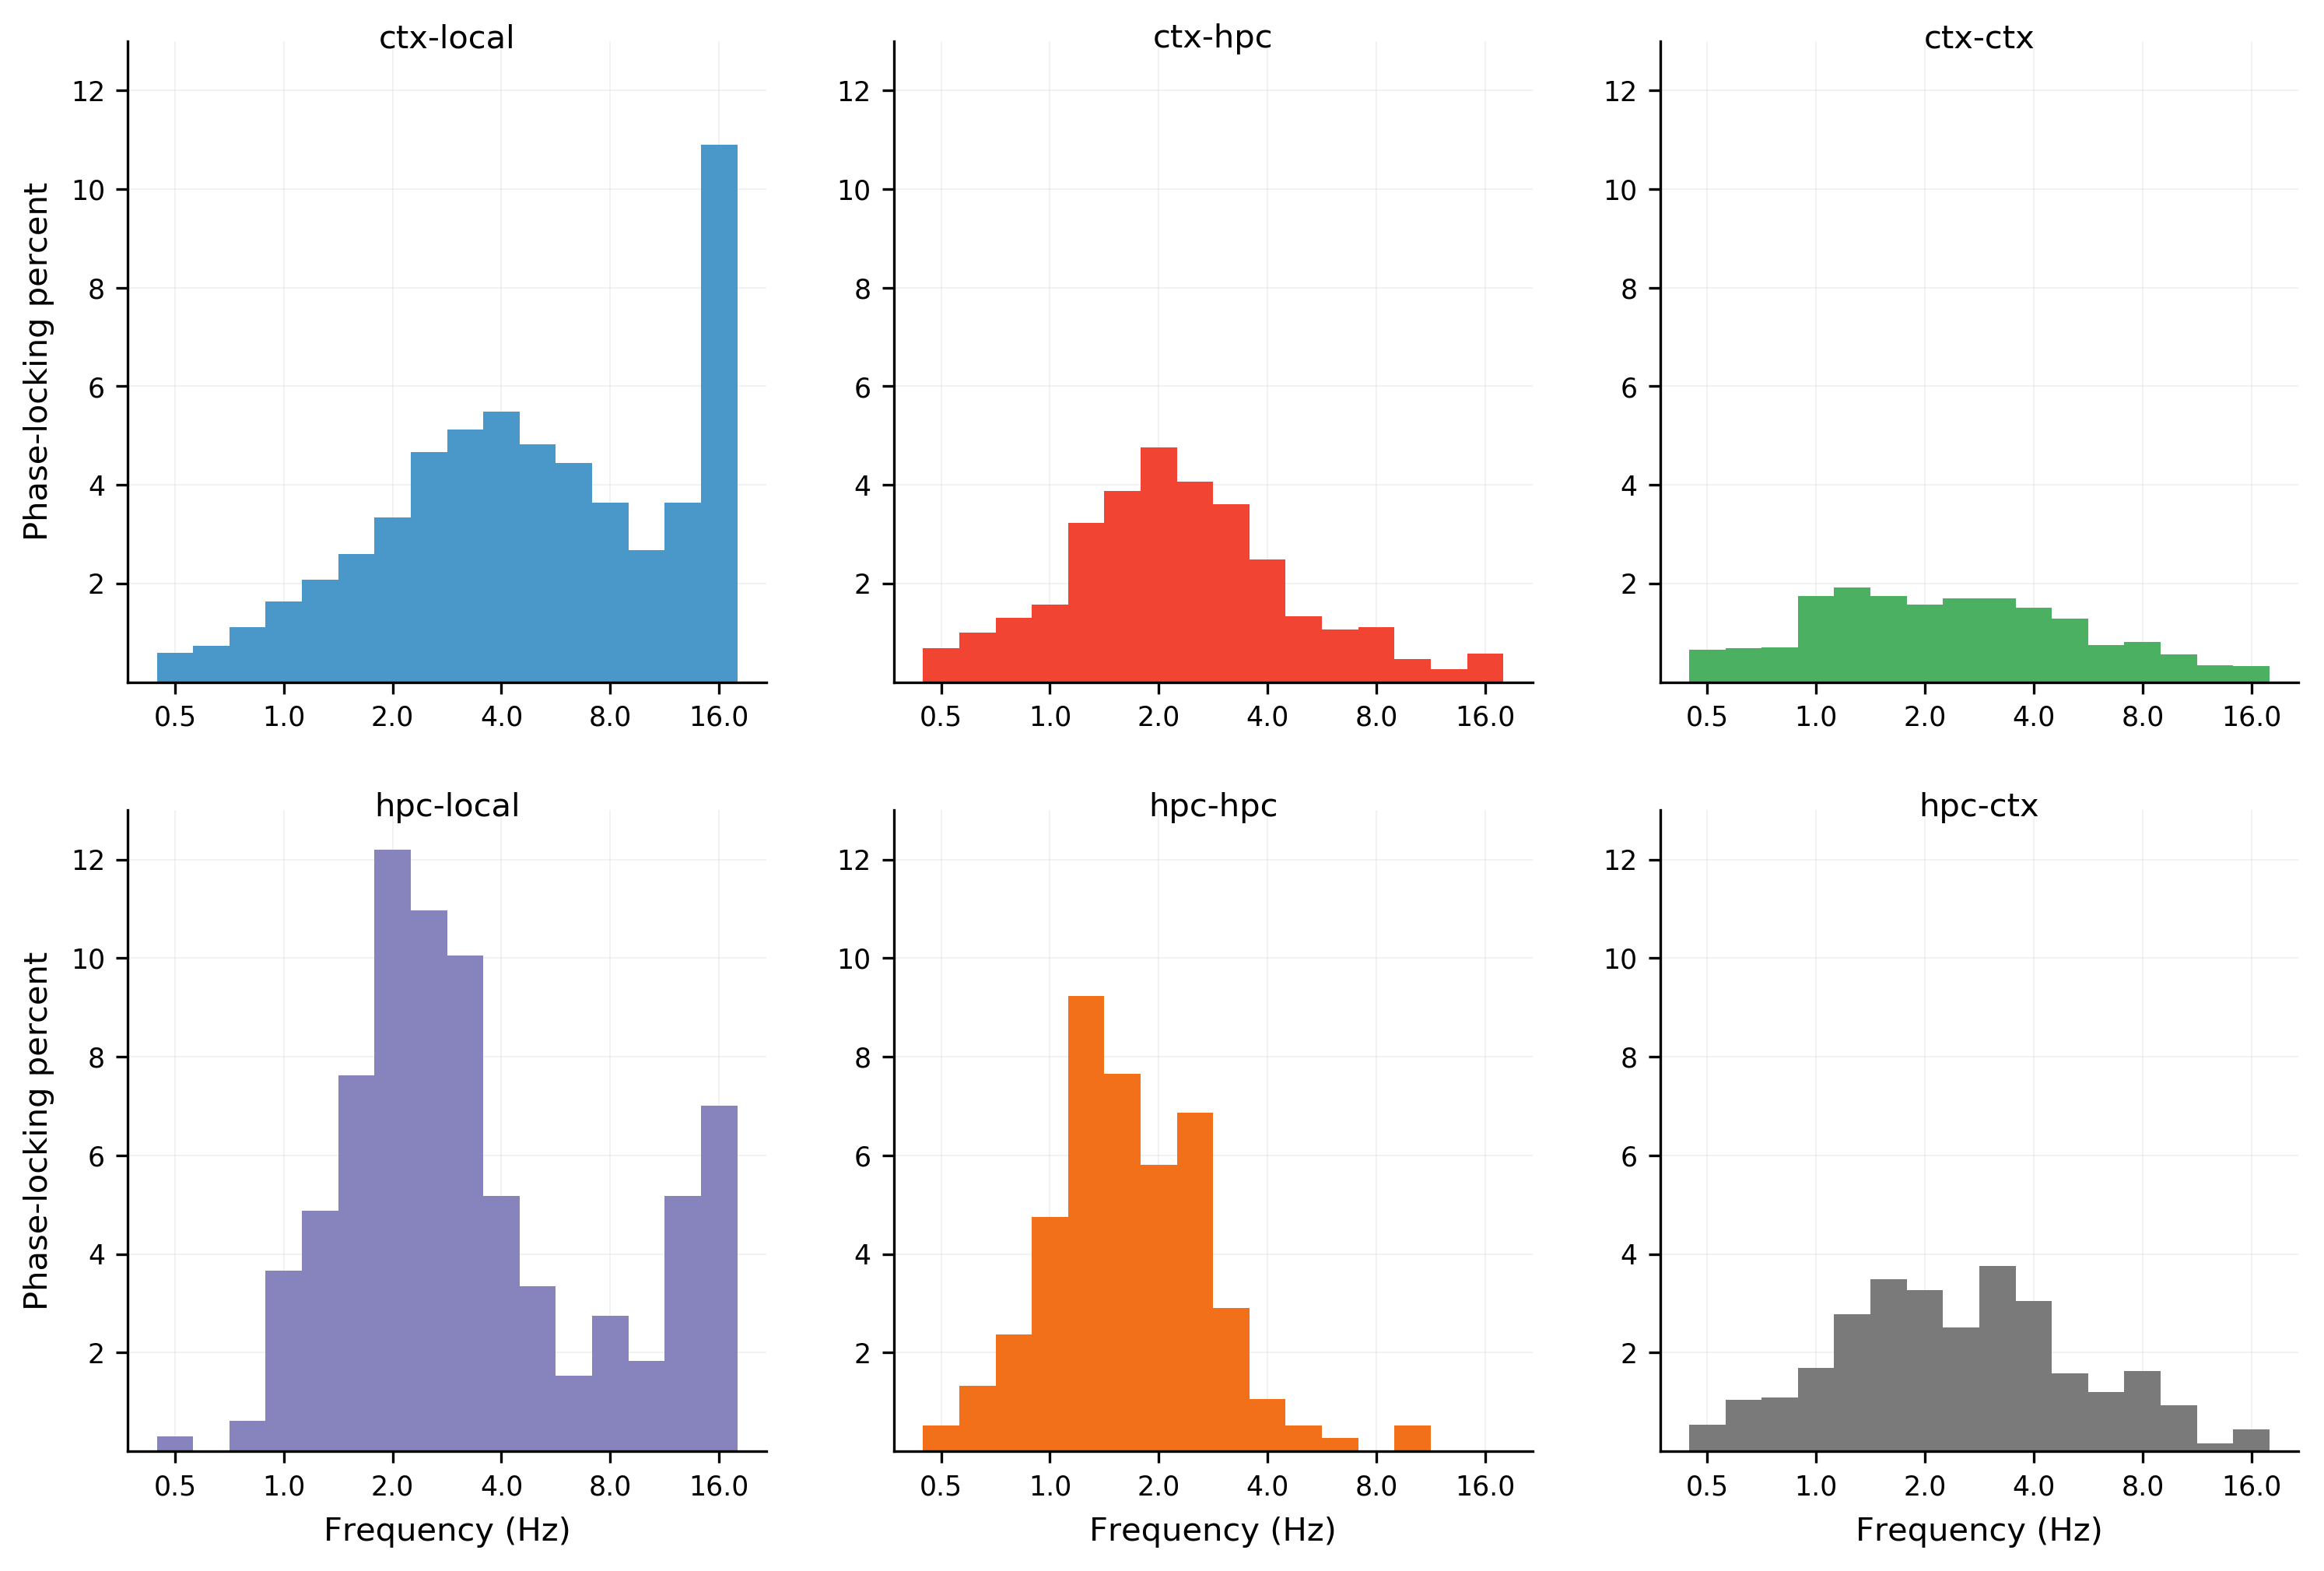

In [281]:
# Phase-locking percent is the percent of total connections in each category.
edge_types = ['ctx-local', 'ctx-hpc', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx']
d = OrderedDict()
for edge_type in edge_types:
    d[edge_type] = OrderedDict()
    d_ = pl_df.query("(sig_z==True) & (edge=='{}')".format(edge_type)).groupby(['locked_freq_ind_z']).size().to_dict()
    for ifreq in range(len(freqs)):
        d[edge_type][ifreq] = d_.get(ifreq, 0) / len(pl_df.query("(edge=='{}')".format(edge_type)))
df = pd.DataFrame(d).reset_index()

fig, ax = plt.subplots(2, 3, figsize=(12, 8), dpi=300)
ax = np.ravel(ax)

for i in range(len(ax)):
    #sns.barplot(x='index', y=edge_types[i], data=df, color=colors[i], saturation=100, ax=ax[i])
    ax[i].bar(x=df['index'], height=df[edge_types[i]], width=1, color=colors[i])
    ax[i].set_xticks(np.arange(len(freqs))[::3])
    ax[i].set_xticklabels(np.round(freqs[::3], 1))
    if i in [3, 4, 5]:
        ax[i].set_xlabel('Frequency (Hz)', fontsize=10, labelpad=5)
    else:
        ax[i].set_xlabel('')
    if i in [0, 1, 2]:
        ax[i].set_ylim([0, 0.13])
        ax[i].set_yticks([0.02, 0.04, 0.06, 0.08, 0.1, .12])
        ax[i].set_yticklabels([2, 4, 6, 8, 10, 12])
    else:
        ax[i].set_ylim([0, 0.13])
        ax[i].set_yticks([0.02, 0.04, 0.06, 0.08, 0.1, .12])
        ax[i].set_yticklabels([2, 4, 6, 8, 10, 12])
    if i in [0, 3]:
        ax[i].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)
    else:
        ax[i].set_ylabel('')
    ax[i].set_title(edge_types[i], fontsize=10, y=0.96)

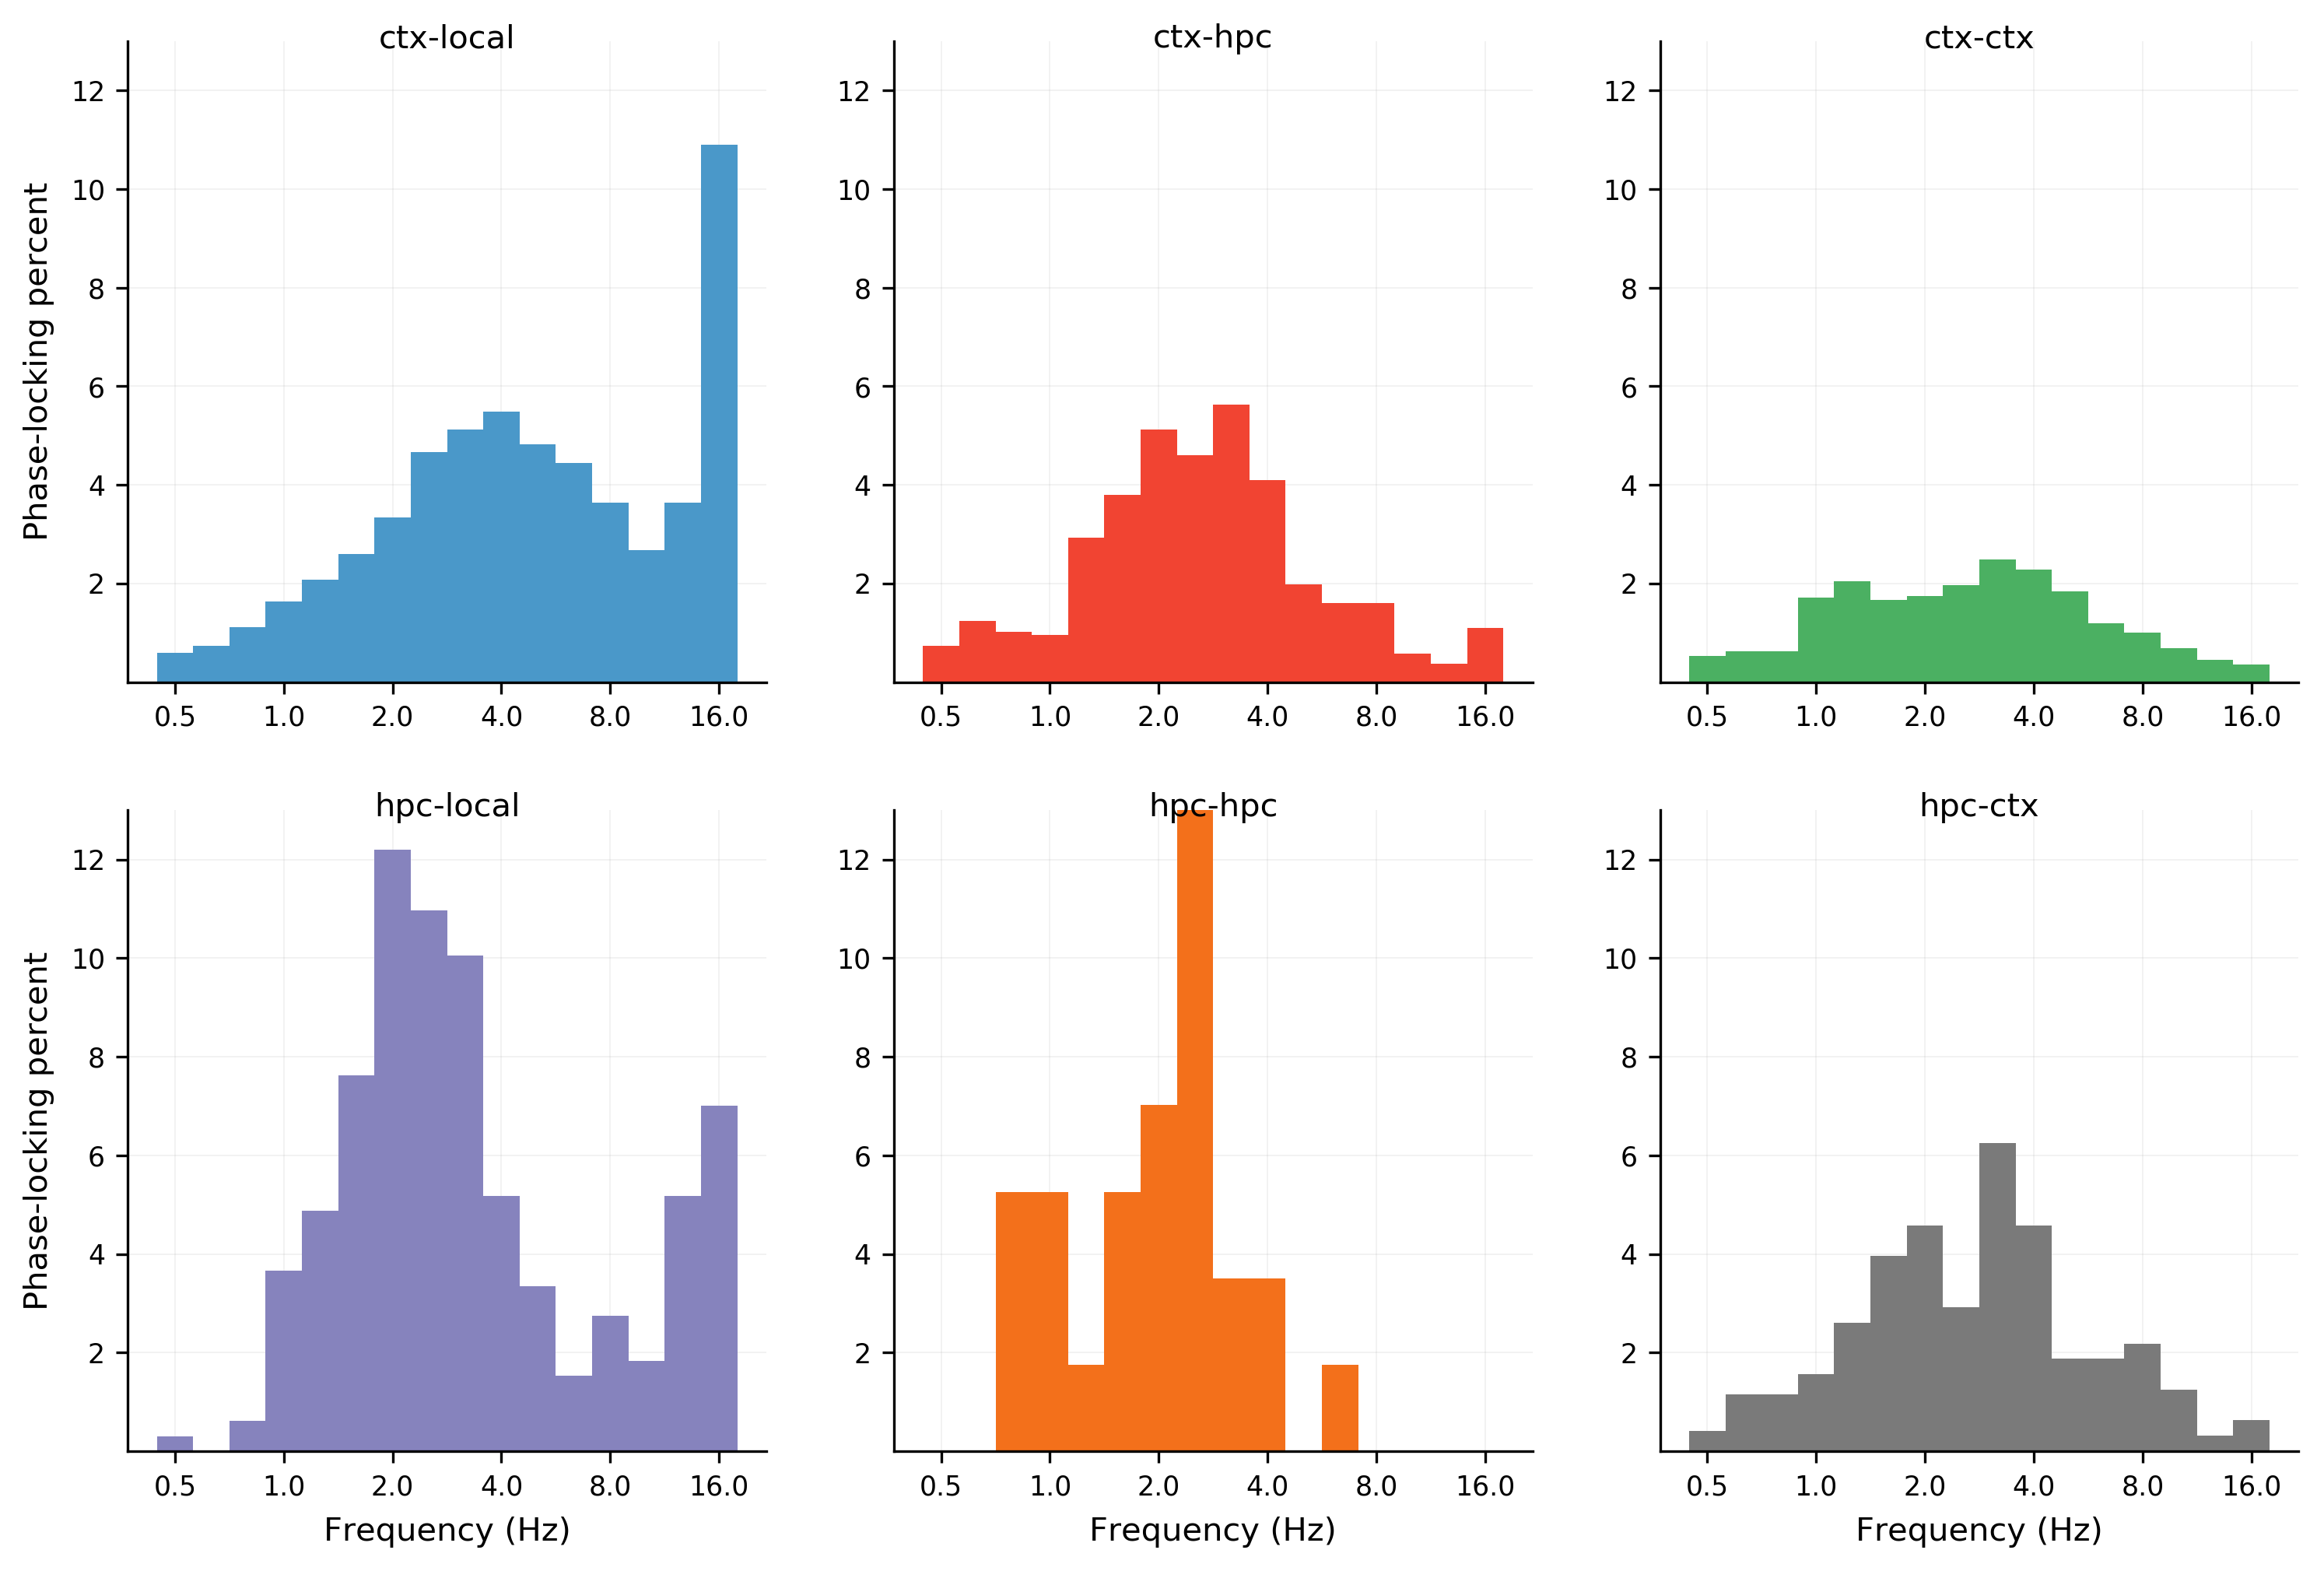

In [282]:
# Ipsilateral
# Phase-locking percent is the percent of total connections in each category.
edge_types = ['ctx-local', 'ctx-hpc', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx']
d = OrderedDict()
for edge_type in edge_types:
    d[edge_type] = OrderedDict()
    d_ = pl_df.query("(same_hem==True) & (sig_z==True) & (edge=='{}')".format(edge_type)).groupby(['locked_freq_ind_z']).size().to_dict()
    for ifreq in range(len(freqs)):
        d[edge_type][ifreq] = d_.get(ifreq, 0) / len(pl_df.query("(same_hem==True) & (edge=='{}')".format(edge_type)))
df = pd.DataFrame(d).reset_index()

fig, ax = plt.subplots(2, 3, figsize=(12, 8), dpi=300)
ax = np.ravel(ax)

for i in range(len(ax)):
    #sns.barplot(x='index', y=edge_types[i], data=df, color=colors[i], saturation=100, ax=ax[i])
    ax[i].bar(x=df['index'], height=df[edge_types[i]], width=1, color=colors[i])
    ax[i].set_xticks(np.arange(len(freqs))[::3])
    ax[i].set_xticklabels(np.round(freqs[::3], 1))
    if i in [3, 4, 5]:
        ax[i].set_xlabel('Frequency (Hz)', fontsize=10, labelpad=5)
    else:
        ax[i].set_xlabel('')
    if i in [0, 1, 2]:
        ax[i].set_ylim([0, 0.13])
        ax[i].set_yticks([0.02, 0.04, 0.06, 0.08, 0.1, .12])
        ax[i].set_yticklabels([2, 4, 6, 8, 10, 12])
    else:
        ax[i].set_ylim([0, 0.13])
        ax[i].set_yticks([0.02, 0.04, 0.06, 0.08, 0.1, .12])
        ax[i].set_yticklabels([2, 4, 6, 8, 10, 12])
    if i in [0, 3]:
        ax[i].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)
    else:
        ax[i].set_ylabel('')
    ax[i].set_title(edge_types[i], fontsize=10, y=0.96)

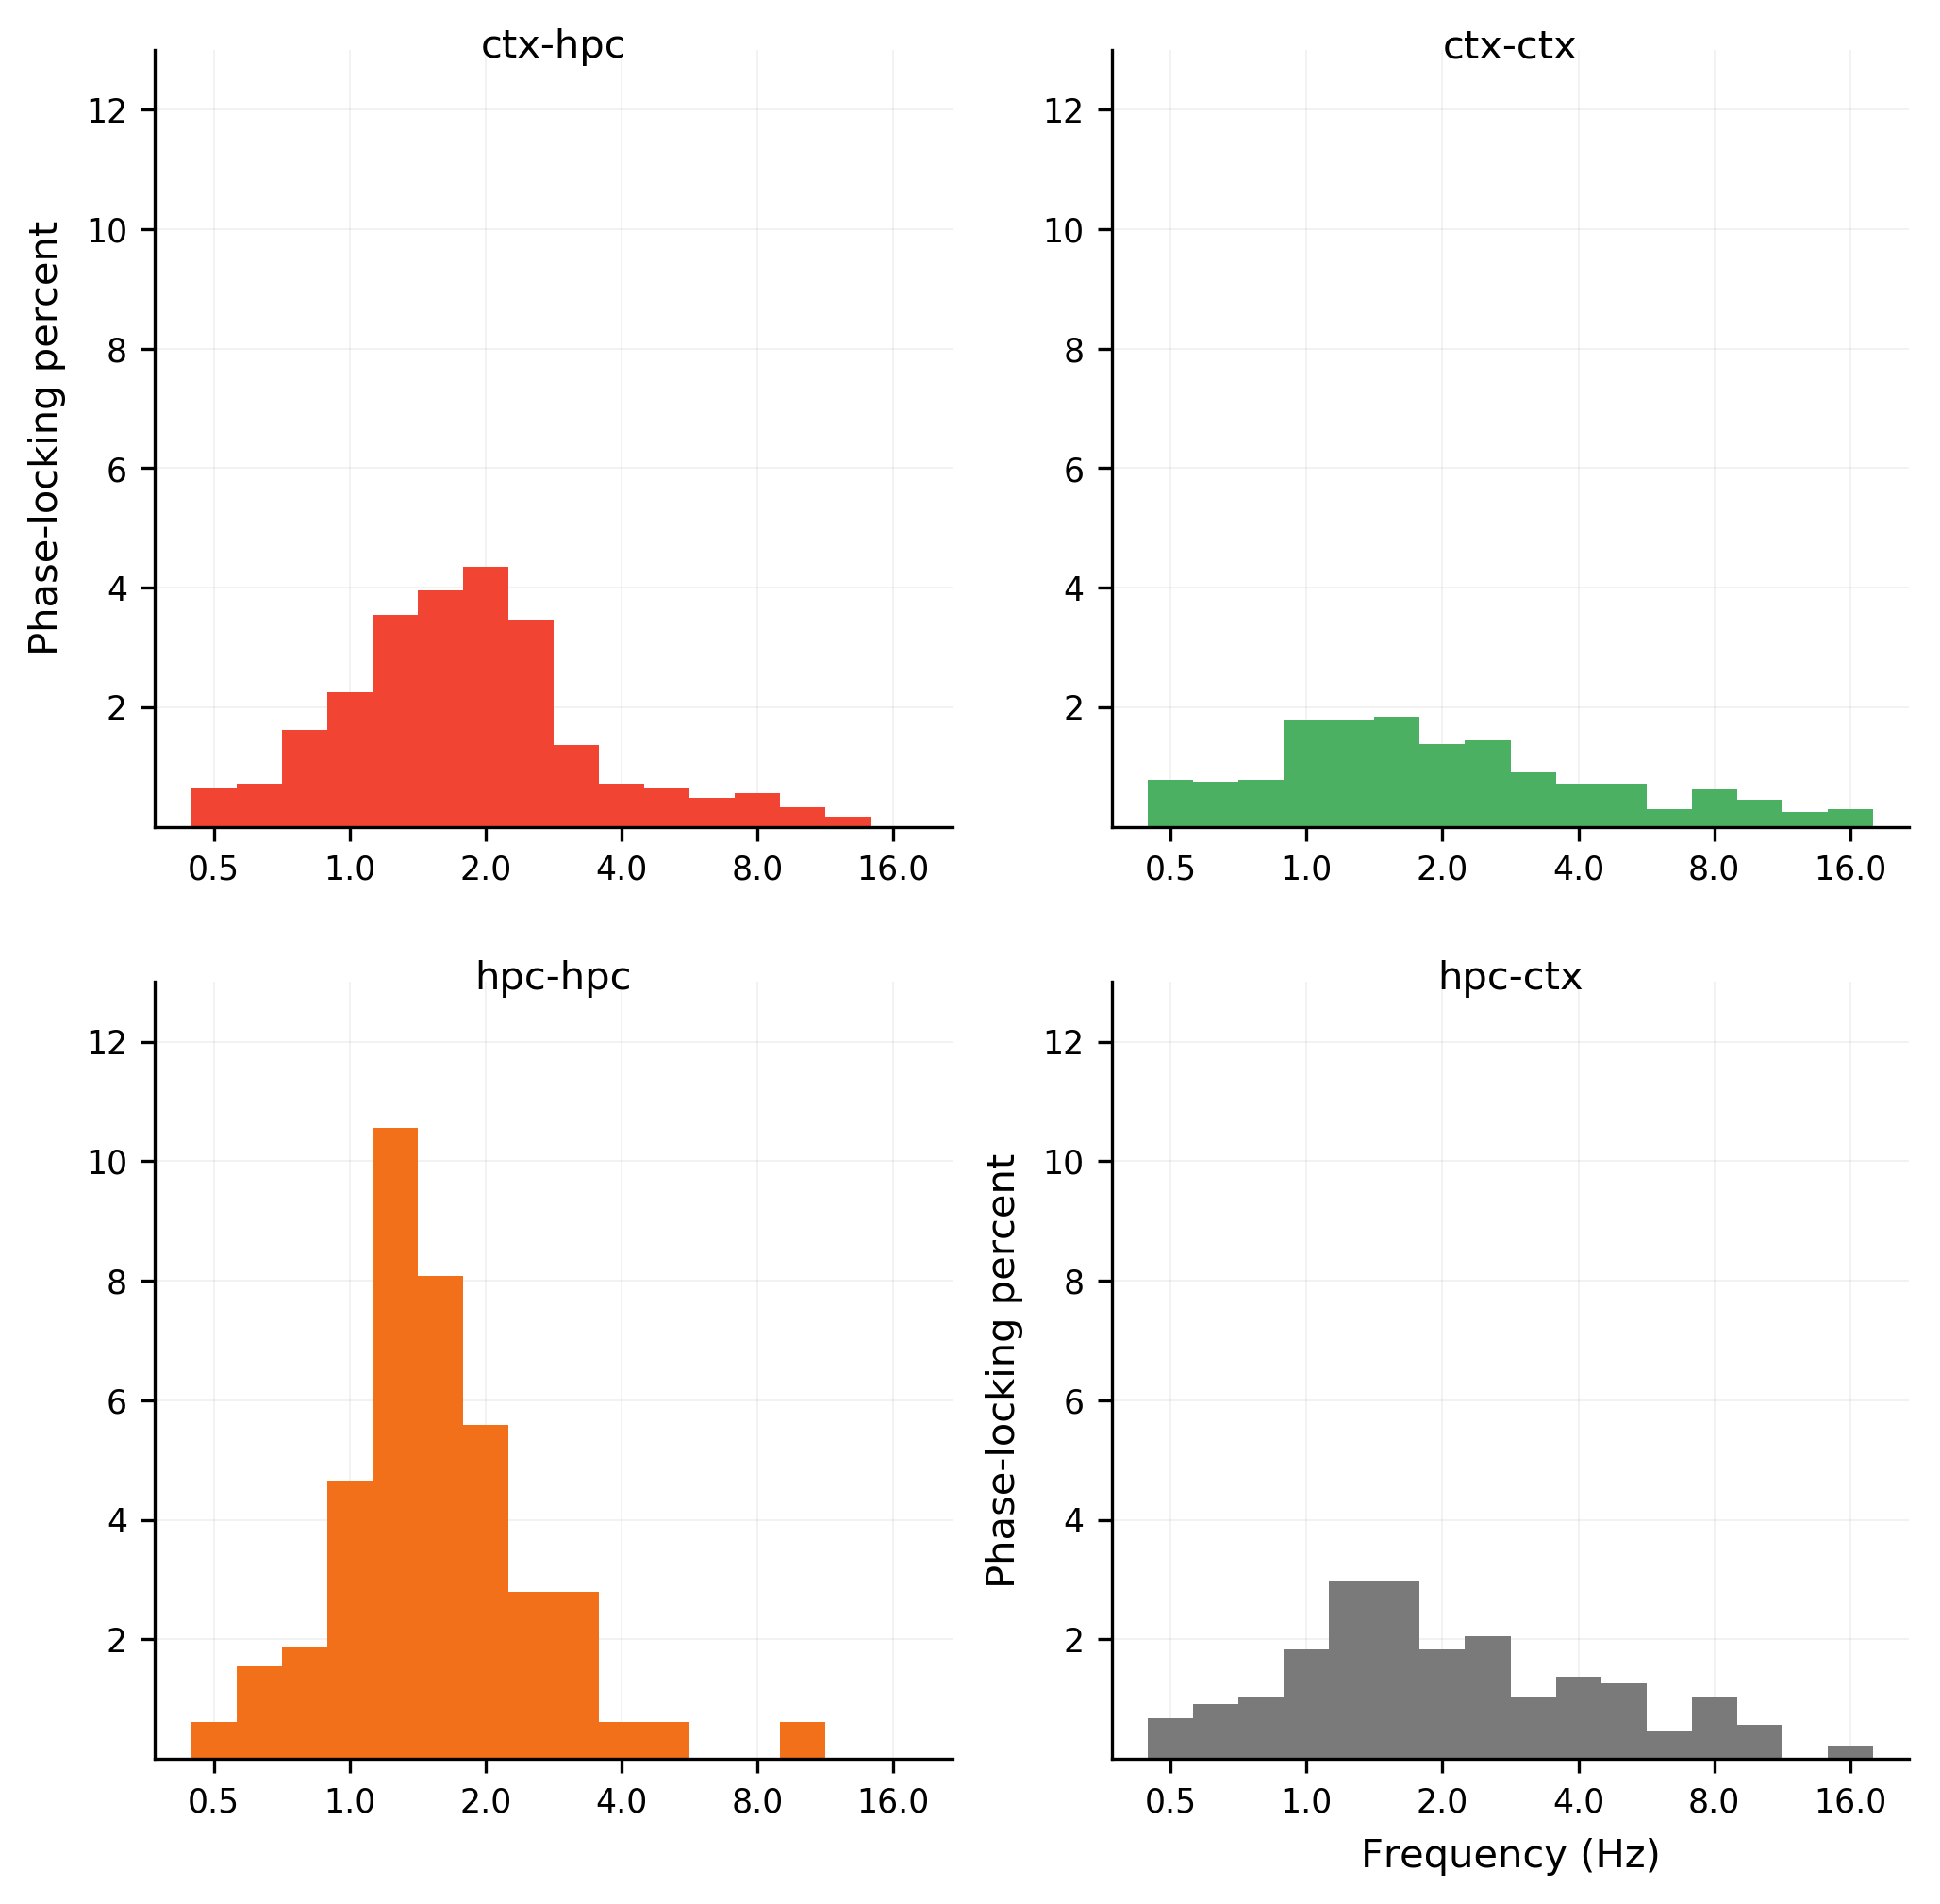

In [283]:
# Contralateral
edge_types = ['ctx-hpc', 'ctx-ctx', 'hpc-hpc', 'hpc-ctx']
d = OrderedDict()
for edge_type in edge_types:
    d[edge_type] = OrderedDict()
    d_ = pl_df.query("(same_hem==False) & (sig_z==True) & (edge=='{}')".format(edge_type)).groupby(['locked_freq_ind_z']).size().to_dict()
    for ifreq in range(len(freqs)):
        d[edge_type][ifreq] = d_.get(ifreq, 0) / len(pl_df.query("(same_hem==False) & (edge=='{}')".format(edge_type)))
df = pd.DataFrame(d).reset_index()

fig, ax = plt.subplots(2, 2, figsize=(8, 8), dpi=300)
ax = np.ravel(ax)

for i in range(len(ax)):
    #sns.barplot(x='index', y=edge_types[i], data=df, color=colors[i], saturation=100, ax=ax[i])
    ax[i].bar(x=df['index'], height=df[edge_types[i]], width=1, color=colors[[1, 2, 4, 5][i]])
    ax[i].set_xticks(np.arange(len(freqs))[::3])
    ax[i].set_xticklabels(np.round(freqs[::3], 1))
    if i in [3, 4, 5]:
        ax[i].set_xlabel('Frequency (Hz)', fontsize=10, labelpad=5)   
    else:
        ax[i].set_xlabel('')
    ax[i].set_ylim([0, 0.13])
    ax[i].set_yticks([0.02, 0.04, 0.06, 0.08, 0.1, .12])
    ax[i].set_yticklabels([2, 4, 6, 8, 10, 12])
    if i in [0, 3]:
        ax[i].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)
    else:
        ax[i].set_ylabel('')
    ax[i].set_title(edge_types[i], fontsize=10, y=0.96)

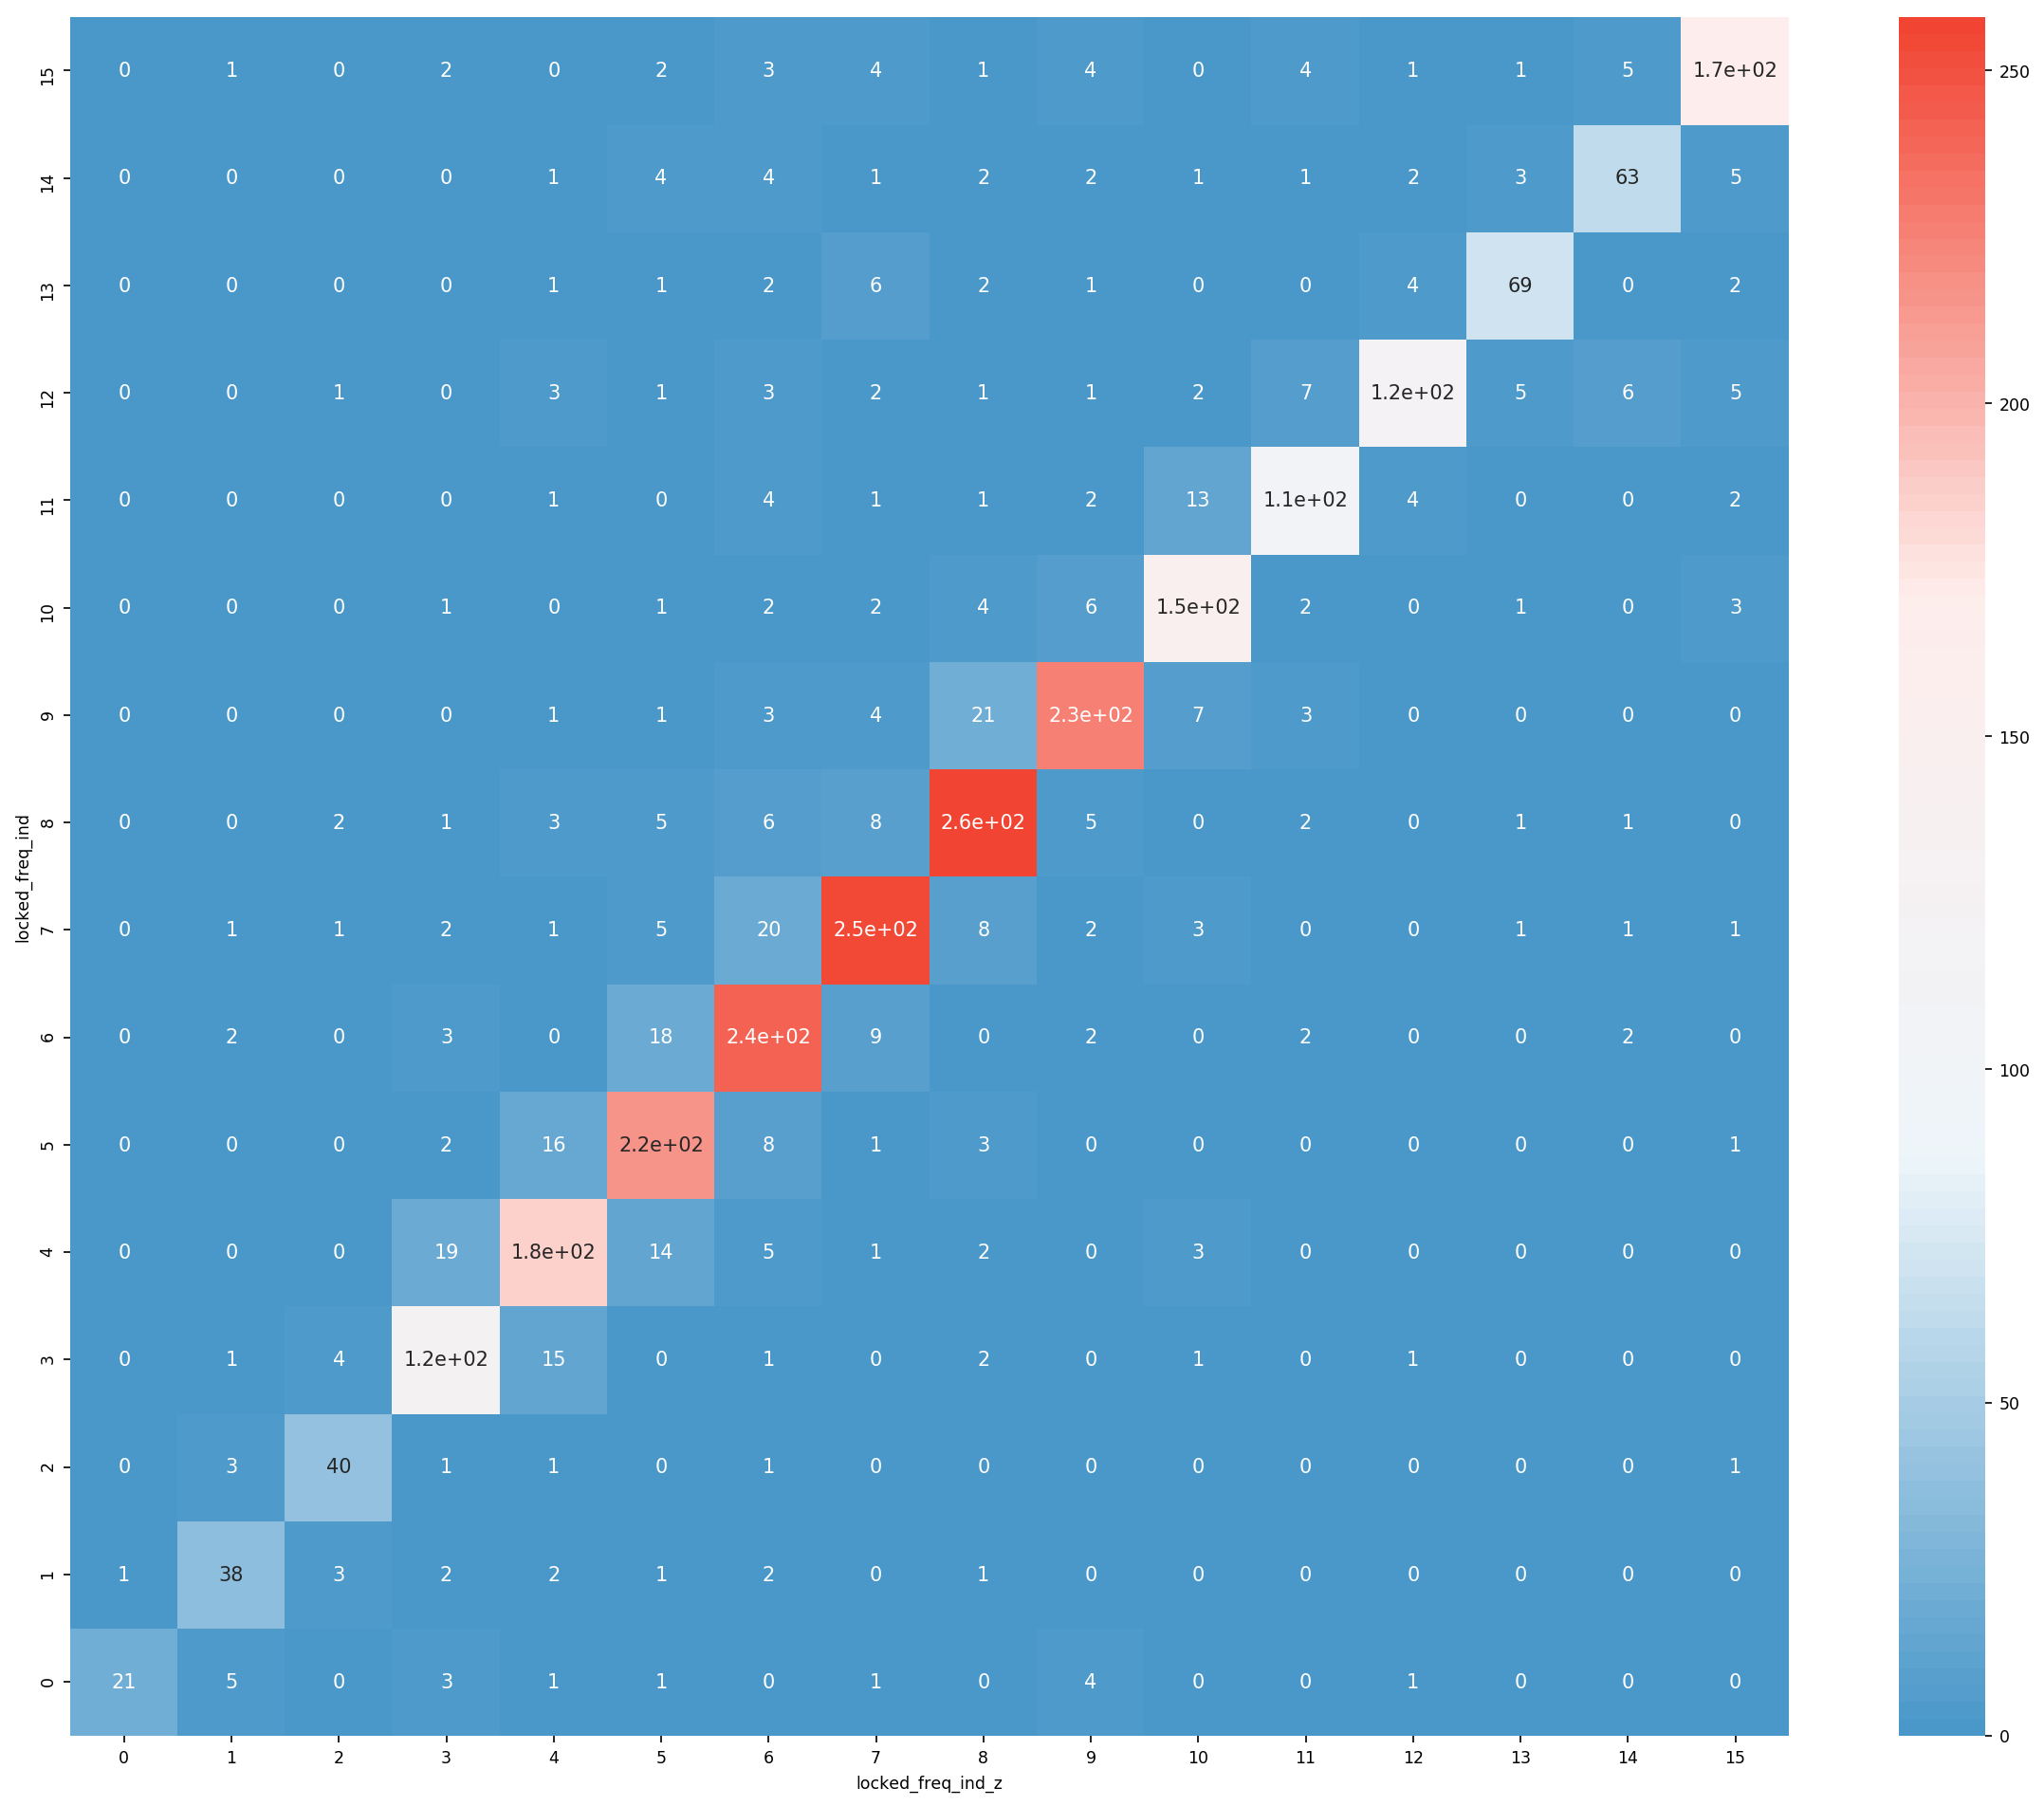

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(20, 16))
ax = sns.heatmap(pl_df.query("(sig==True) & (sig_z_fdr==True)").groupby(['locked_freq_ind', 'locked_freq_ind_z']).size().unstack().fillna(0), 
                 annot=True, cmap=cmap, square=True, ax=ax)
ax.invert_yaxis()

In [285]:
print('Not significant...')
print('locked_freq_ind:', stats.pearsonr(pl_df.query("sig_z==False").locked_freq_ind, pl_df.query("sig_z==False").locked_freq_ind_z))
print('locked_mrl:', stats.pearsonr(pl_df.query("sig_z==False").locked_mrl, pl_df.query("sig_z==False").locked_mrl_z))
print('tl_locked_time:', stats.pearsonr(pl_df.query("sig_z==False").tl_locked_time, pl_df.query("sig_z==False").tl_locked_time_z))
print('tl_locked_time_mrl:', stats.pearsonr(pl_df.query("sig_z==False").tl_locked_time_mrl, pl_df.query("sig_z==False").tl_locked_time_mrl_z))

print('\nSignificant...')
print('locked_freq_ind:', stats.pearsonr(pl_df.query("sig_z==True").locked_freq_ind, pl_df.query("sig_z==True").locked_freq_ind_z))
print('locked_mrl:', stats.pearsonr(pl_df.query("sig_z==True").locked_mrl, pl_df.query("sig_z==True").locked_mrl_z))
print('tl_locked_time:', stats.pearsonr(pl_df.query("sig_z==True").tl_locked_time, pl_df.query("sig_z==True").tl_locked_time_z))
print('tl_locked_time_mrl:', stats.pearsonr(pl_df.query("sig_z==True").tl_locked_time_mrl, pl_df.query("sig_z==True").tl_locked_time_mrl_z))

Not significant...
locked_freq_ind: (0.4863427351246884, 0.0)
locked_mrl: (-0.005061378541479678, 0.6230973535062334)
tl_locked_time: (0.5629952372723928, 0.0)
tl_locked_time_mrl: (-0.017375417720102083, 0.09154789563760032)

Significant...
locked_freq_ind: (0.7613980313398792, 0.0)
locked_mrl: (0.3897143359808867, 1.8883979923545414e-136)
tl_locked_time: (0.4528201143170902, 2.8187240803274807e-189)
tl_locked_time_mrl: (0.38735137917231277, 1.0994625457565922e-134)


In [32]:
sampling_rate=500
time_win=5
time_steps = np.arange(-time_win*sampling_rate, time_win*sampling_rate+1, sampling_rate*0.01, dtype=int)
time_steps_ms = (time_steps / sampling_rate) * 1000

In [13]:
pl_df['tl_mrls_z'] = pl_df.apply(lambda x: tuple((x['tl_mrls'] - np.expand_dims(np.mean(x['bs_mrls'], axis=-1), axis=-1)) 
                                                 / np.expand_dims(np.std(x['bs_mrls'], axis=-1), axis=-1)), axis=1)
pl_df['tl_mrls_z'] = pl_df.tl_mrls_z.apply(lambda x: np.array(x))
#pl_df['tl_mrls_locked_band'] = pl_df.apply(lambda x: tuple(x['tl_mrls'][x['locked_freq_ind'], :]), axis=1)
pl_df['tl_mrls_locked_band_z'] = pl_df.apply(lambda x: tuple(x['tl_mrls_z'][x['locked_freq_ind_z'], :]), axis=1)
#pl_df['tl_mrls_locked_band'] = pl_df['tl_mrls_locked_band'].apply(lambda x: np.array(x))
pl_df['tl_mrls_locked_band_z'] = pl_df['tl_mrls_locked_band_z'].apply(lambda x: np.array(x))
#pl_df['tl_mrls_locked_band_flip'] = pl_df['tl_mrls_locked_band'].apply(lambda x: np.flip(x, axis=-1))
pl_df['tl_mrls_locked_band_z_flip'] = pl_df['tl_mrls_locked_band_z'].apply(lambda x: np.flip(x, axis=-1))
#pl_df['tl_locked_time_flip'] = -pl_df['tl_locked_time']

# Get the time of maximum Z-MRL at the t=0 locked freq within 200 ms of t=0!
pl_df['tl_locked_time_z'] = pl_df.apply(lambda x: time_steps_ms[x.tl_mrls_z[x.locked_freq_ind_z, 300:701].argmax() + 300], axis=1)
pl_df['tl_locked_time_z_flip'] = -pl_df['tl_locked_time_z']

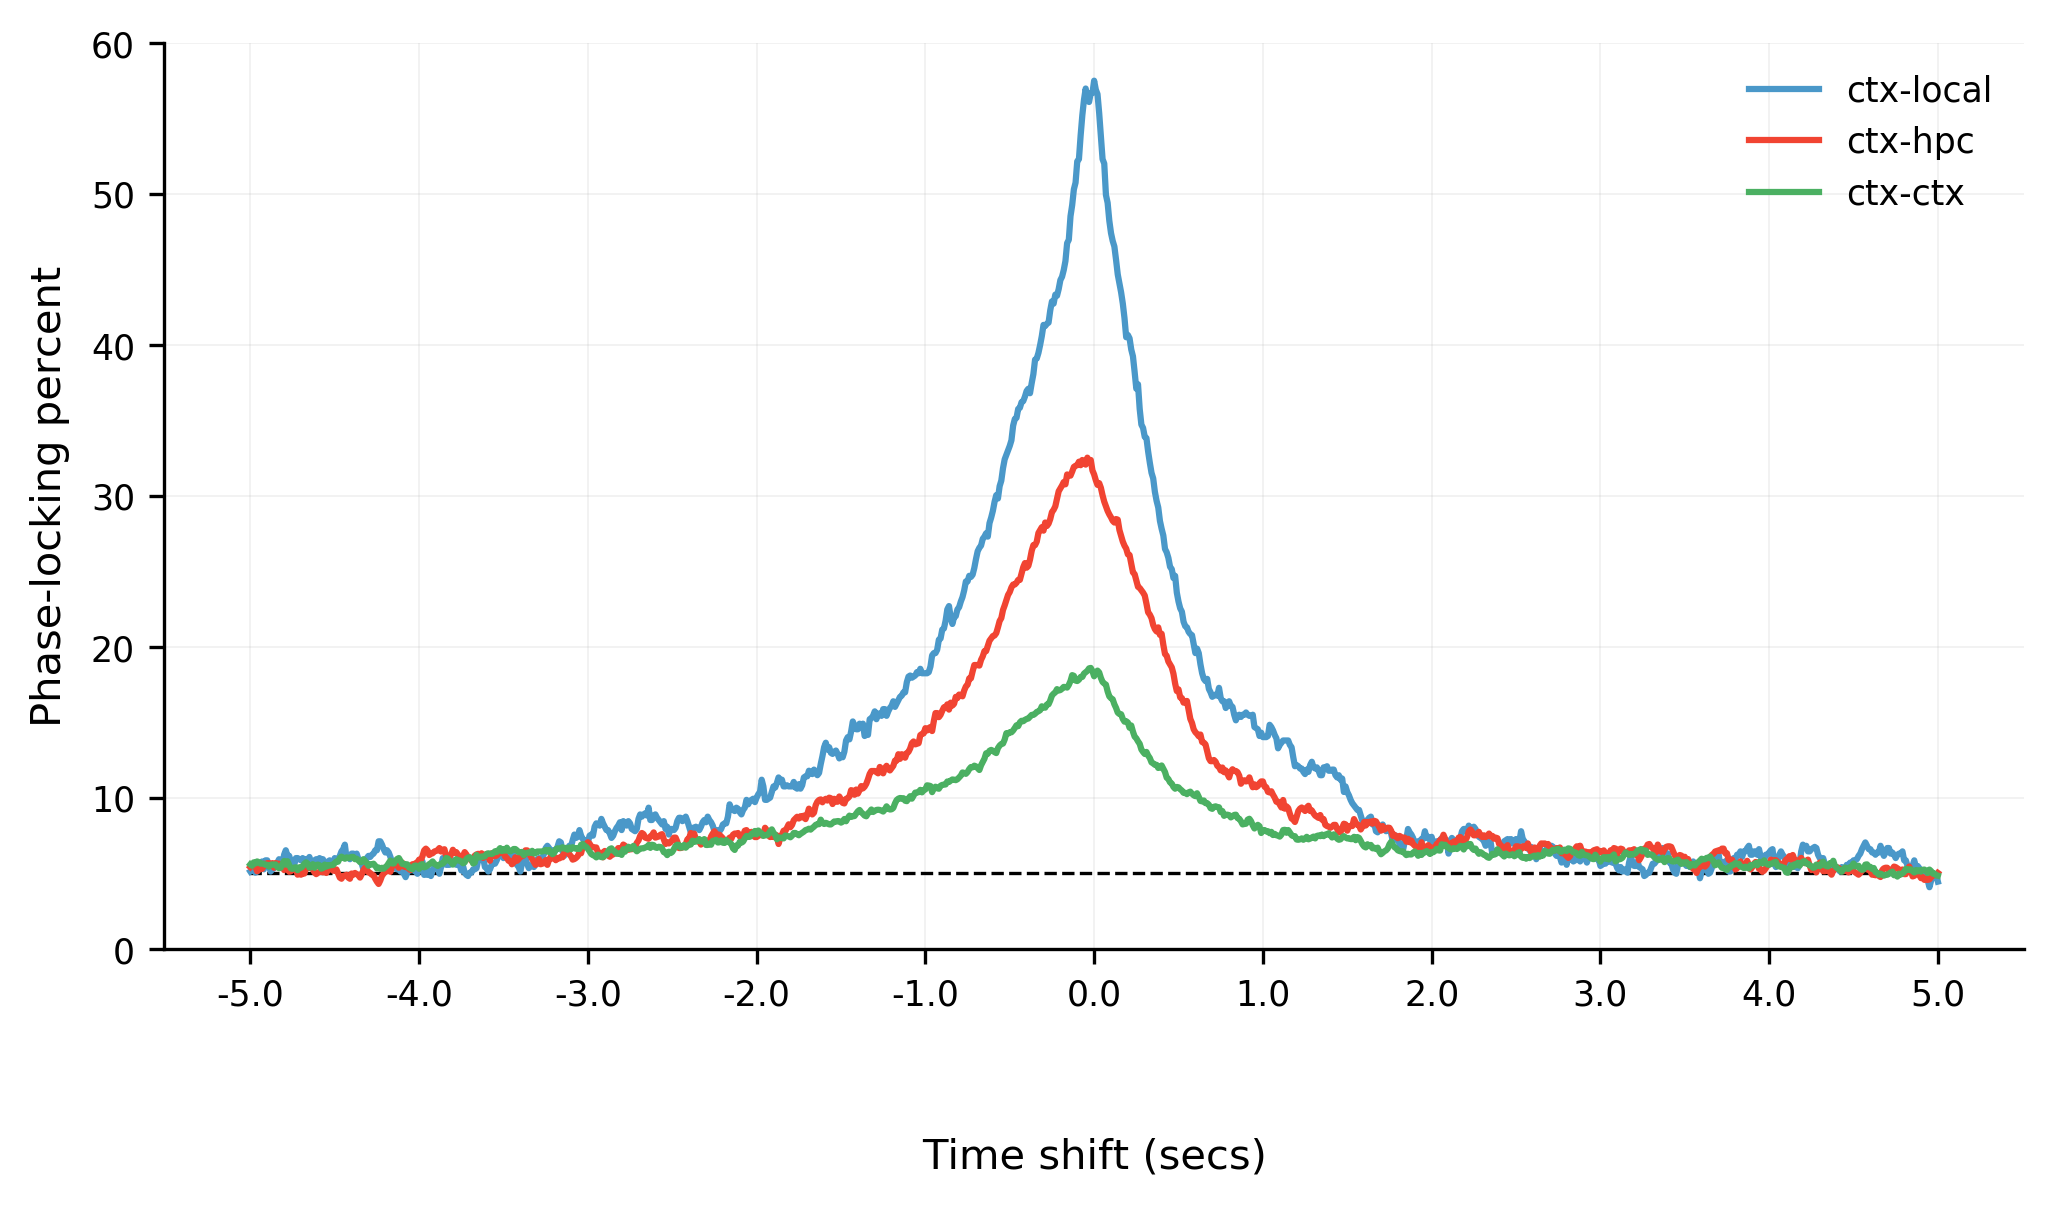

In [287]:
# Plot the percent of phase-locked units at different time lags
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)
edge_types = ['ctx-local', 'ctx-hpc', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx']
edge_types = ['ctx-local', 'ctx-hpc', 'ctx-ctx']
for i in range(len(edge_types)):
    ax[0].plot(np.mean(np.flip(pl_df.query("(edge=='{}')".format(edge_types[i])).tl_bs_sig_z.tolist(), axis=-1), axis=0), 
               label=edge_types[i], color=colors[i], linewidth=1.5)

ax[0].hlines(y=0.05, xmin=-1, xmax=1001, color='k', linestyle='--')
ax[0].set_xticks(np.linspace(0, 1000, 11))
ax[0].set_xticklabels(np.linspace(-5, 5, 1001)[np.linspace(0, 1000, 11, dtype=int)])
ax[0].set_ylim([0, 0.6])
ax[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
ax[0].set_yticklabels([0, 10, 20, 30, 40, 50, 60])
ax[0].set_xlabel('Time shift (secs)', fontsize=10, labelpad=30)
ax[0].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)
ax[0].legend()

In [55]:
inds = abs(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc')").groupby('tl_locked_time_z_flip').size().index)>1000
np.sum(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc')").groupby('tl_locked_time_z_flip').size().values[inds])

15

In [57]:
locked_times = np.array(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc')").tl_locked_time_z_flip.tolist())
print(np.mean(locked_times), stats.ttest_1samp(locked_times, popmean=0))

-58.694992412746586 Ttest_1sampResult(statistic=-5.330556191135282, pvalue=1.3471012814549324e-07)


In [82]:
np.mean(locked_times), np.interp(np.mean(locked_times), time_steps_ms[400:601], np.arange(201))

(-58.694992412746586, 94.13050075872535)

In [79]:
counts.index

RangeIndex(start=0, stop=201, step=1)

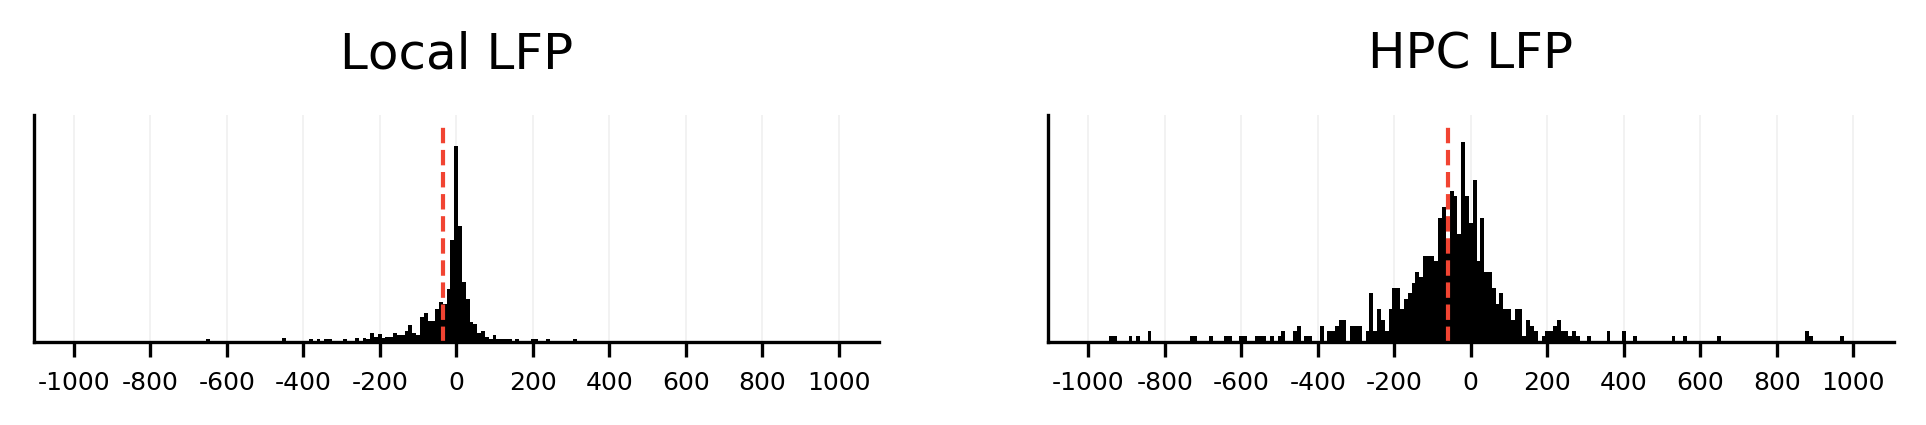

In [85]:
local_d = (pl_df
           .query("(sig_z_fdr==True) & (edge=='ctx-local')")
           .groupby('tl_locked_time_z_flip')
           .size()
           .to_dict())
hpc_d = (pl_df
         .query("(sig_z_fdr==True) & (edge=='ctx-hpc')")
         .groupby('tl_locked_time_z_flip')
         .size()
         .to_dict())
counts = []
for i in np.arange(-1000, 1001, 10):
    counts.append([local_d.get(i, 0), hpc_d.get(i, 0)])
counts = pd.DataFrame(counts, columns=['local', 'hpc']).reset_index()

fig, ax = plt.subplots(1, 2, figsize=(8, 1), dpi=300)
ax = np.ravel(ax)

ax[0].bar(counts.index, counts.local, width=1, color='k')
locked_times = np.array(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-local')").tl_locked_time_z_flip.tolist())
ax[0].vlines(np.interp(np.mean(locked_times), time_steps_ms[400:601], np.arange(201)), 
             0, int(np.max(counts.local)*1.1), color=colors[1], linewidth=1, linestyle='--')
ax[0].set_title('Local LFP', fontsize=12, y=1.1)

ax[1].bar(counts.index, counts.hpc, width=1, color='k')
locked_times = np.array(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc')").tl_locked_time_z_flip.tolist())
ax[1].vlines(np.interp(np.mean(locked_times), time_steps_ms[400:601], np.arange(201)), 
             0, int(np.max(counts.hpc)*1.1), color=colors[1], linewidth=1, linestyle='--')
ax[1].set_yticks(np.arange(0, 15, 3))
ax[1].set_title('HPC LFP', fontsize=12, y=1.1)

for i in range(2):
    ax[i].set_xticks(np.arange(0, 201, 20))
    ax[i].set_xticklabels(np.arange(-1000, 1001, 200), fontsize=6)
    ax[i].set_yticks([])
    #ax[i].set_xlabel('Time shift (ms)', labelpad=5)
    #ax[i].set_ylabel('Number of neurons', labelpad=5)

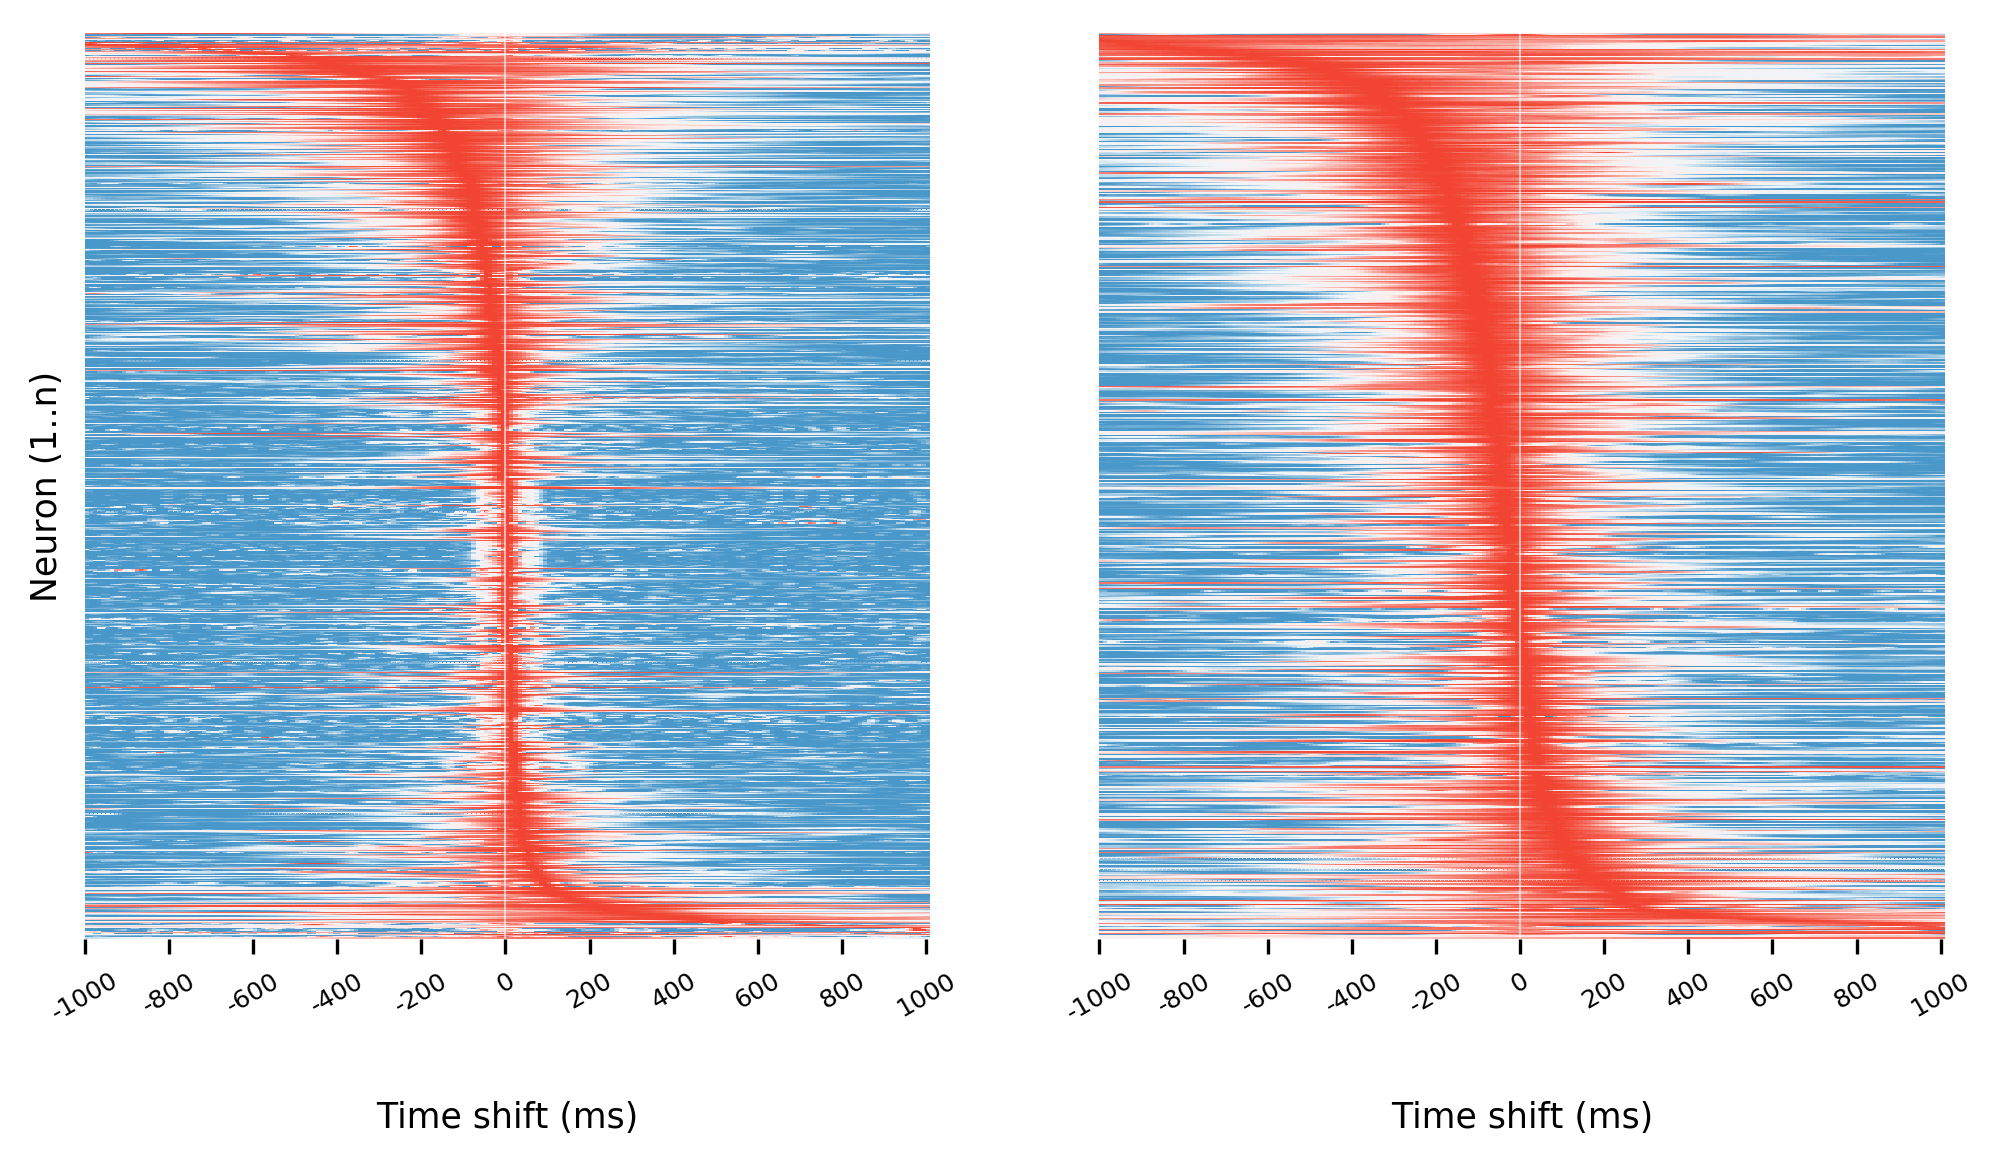

In [86]:
local_tl_mrls = np.array(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-local')")
                         .sort_values('tl_locked_time_z_flip').tl_mrls_locked_band_z_flip.tolist())
hpc_tl_mrls = np.array(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc')")
                       .sort_values('tl_locked_time_z_flip').tl_mrls_locked_band_z_flip.tolist())

fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.heatmap((local_tl_mrls[:, 400:601].T / np.max(local_tl_mrls, axis=1)).T, ax=ax[0], 
            vmin=0, vmax=1, cmap=cmap, cbar=False)
sns.heatmap((hpc_tl_mrls[:, 400:601].T / np.max(hpc_tl_mrls, axis=1)).T, ax=ax[1], 
            vmin=0, vmax=1, cmap=cmap, cbar=False)
ax[0].axvline(x=100, color='w', linewidth=0.5, alpha=0.6)
ax[1].axvline(x=100, color='w', linewidth=0.5, alpha=0.6)

for i in range(2):
    ax[i].set_xticks(np.arange(0, 201, 20))
    ax[i].set_xticklabels(np.arange(-1000, 1001, 200), fontsize=6, rotation=30)
    ax[i].set_yticks([])
    ax[i].set_xlabel('Time shift (ms)', labelpad=18)
ax[0].set_ylabel('Neuron (1..n)', labelpad=5)

plt.show()

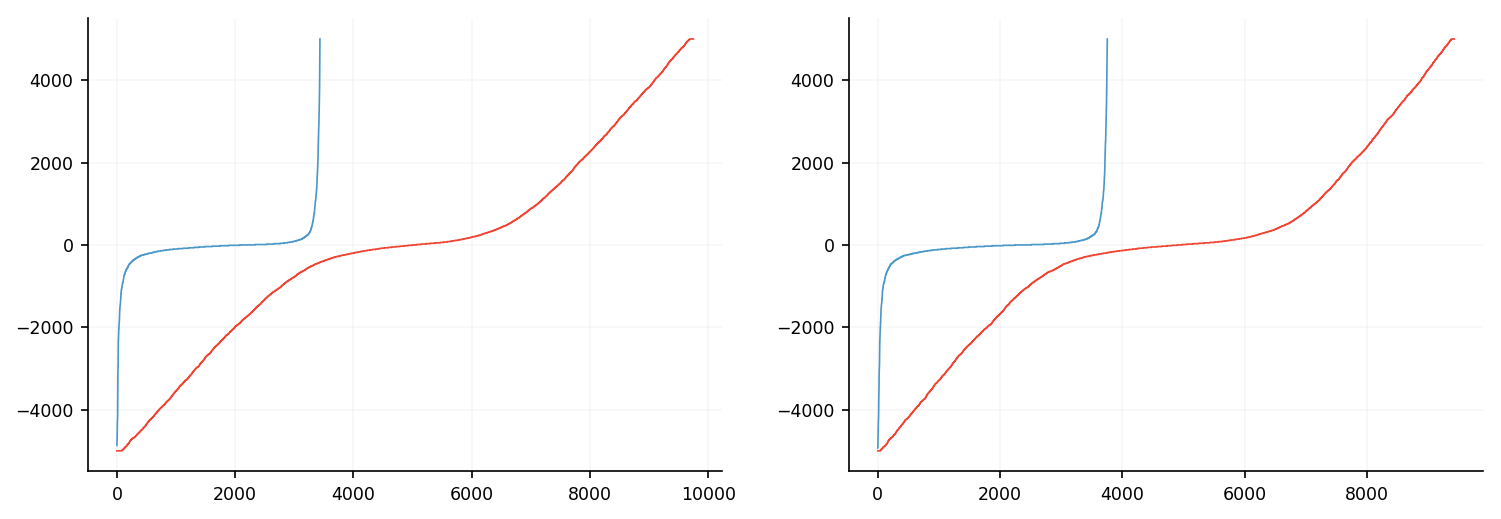

In [292]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax = np.ravel(ax)
ax[0].plot(np.sort(pl_df.query("sig==True").tl_locked_time_flip), color=colors[0])
ax[0].plot(np.sort(pl_df.query("sig==False").tl_locked_time_flip), color=colors[1])
ax[1].plot(np.sort(pl_df.query("sig_z==True").tl_locked_time_z_flip), color=colors[0])
ax[1].plot(np.sort(pl_df.query("sig_z==False").tl_locked_time_z_flip), color=colors[1])

In [1184]:
df = pd.merge(upl_df, pl_df, how='inner', on=['subj_sess_unit', 'lfp_hemroi'])
print('locked_freq_ind:', stats.pearsonr(df.query("sig_x==True").mrl_argmax, df.query("sig_x==True").locked_freq_ind))
print('locked_mrl:', stats.pearsonr(df.query("sig_x==True").locked_mrl_x, df.query("sig_x==True").locked_mrl_y))

locked_freq_ind: (0.9874097971848733, 3.08690212365723e-206)
locked_mrl: (0.9998310923572866, 0.0)


## Older stuff (downsampling, etc.)

In [985]:
start_time = time()

for index, row in u2r_df.query("(subj_sess=={})".format(sessions)).iterrows():
    subj_sess, unit, lfp_chans, lfp_roi = row.subj_sess, row.unit, row.lfp_chan_inds, row.lfp_hemroi
    print(subj_sess, unit, lfp_chans, lfp_roi)
    info = phase_locking.calc_phase_locking_mrl_morlet_unit_to_region(row)
    break
    
print('Done in {:.2f} secs'.format(time() - start_time))

U369_env2 1 [32, 33, 34, 35, 36, 37, 38, 39] LA
Done in 223.53 secs


In [308]:
input_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking'
spike_inds, n_timepoints = dio.open_pickle(os.path.join(input_dir, 'spike_inds', 'spike_inds-{}Hz-{}-unit{}.pkl'
                                                        .format(sampling_rate, subj_sess, unit)))
time_win = 5
cut_inds = int(sampling_rate * time_win)
spike_inds = spike_inds[(spike_inds>cut_inds) & (spike_inds<(n_timepoints-cut_inds))]

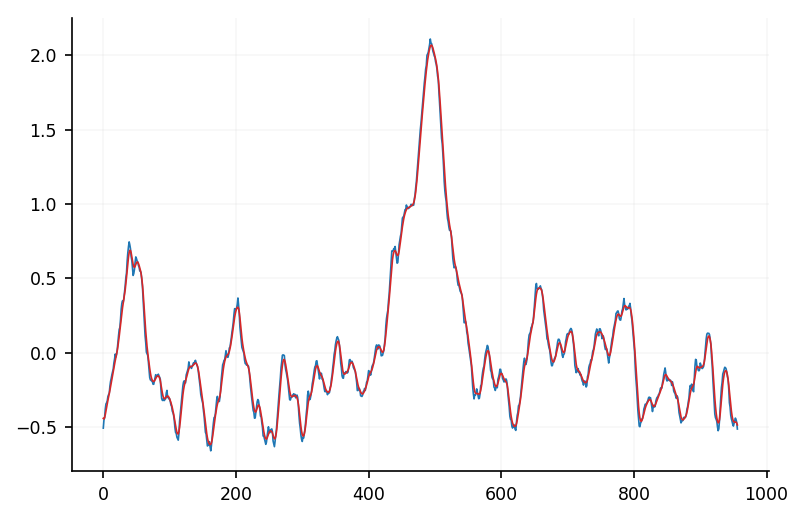

In [987]:
gwin = manning_utils.get_gwin(100, sampling_rate) # FWHM = 10ms
arr = np.convolve(info['tl_mrls_z'][info['locked_freq_ind_z'], :], gwin, mode='same')
plt.plot(info['tl_mrls_z'][info['locked_freq_ind_z'], :][len(gwin):-len(gwin)])
plt.plot(arr[len(gwin):-len(gwin)])

In [ ]:
upl_df['tl_mrl_argmax'] = upl_df.tl_mrls.apply(lambda x: np.argmax(x, axis=0))
upl_df['tl_locked_mrl'] = upl_df.tl_mrls.apply(lambda x: np.max(x, axis=0))
upl_df['tl_bs_ind'] = upl_df.apply(lambda x: tuple([np.sum(x['bs_mrls'][x['tl_mrl_argmax'][i], :] >= x['tl_locked_mrl'][i]) 
                                                    for i in range(len(x['tl_locked_mrl']))]), axis=1)
upl_df['tl_bs_ind'] = upl_df.tl_bs_ind.apply(lambda x: np.array(x))
upl_df['tl_bs_pval'] = upl_df.tl_bs_ind.apply(lambda x: (1+x) / (1+n_bootstraps))
upl_df['tl_sig'] = upl_df.tl_bs_pval.apply(lambda x: x < alpha)

In [994]:
cols = ['subj_sess_unit', 'unit_hemroi', 'lfp_hemroi', 'unit_nspikes', 'mrl_argmax', 'locked_mrl', 'locked_band', 'bs_ind', 'sig']
print(subj_sess, unit, lfp_chans, lfp_roi)
display(upl_df_.query("(subj_sess=='{}') & (unit=={}) & (lfp_hemroi=='{}')".format(subj_sess, unit, lfp_roi))[cols])

U369_env2 1 [32, 33, 34, 35, 36, 37, 38, 39] LA


subj_sess_unit unit_hemroi lfp_hemroi  unit_nspikes  mrl_argmax  \
416    U369_env2_1          RA         LA          1574           8   

     locked_mrl  locked_band  bs_ind    sig  
416    0.041269     3.174802       4  False

In [993]:
info.tl_bs_sig.sum(), info.tl_bs_sig_z.sum()

(54, 66)

In [999]:
15/5000 < (0.05/16)

True

In [813]:
stats.pearsonr(tl_mrls_z[:, 300:701].flatten(), 
               upl_df_.query("(subj_sess=='{}') & (unit=={}) & (lfp_hemroi=='{}')".format(subj_sess, unit, lfp_roi)).tl_mrls.iat[0].flatten())

(0.9960301096666059, 0.0)

In [617]:
bs_means = np.expand_dims(np.mean(bs_mrls_arr, axis=-1), axis=-1)
bs_stds = np.expand_dims(np.std(bs_mrls_arr, axis=-1), axis=-1)

In [621]:
bs_mrls_arr_z = (bs_mrls_arr - bs_means) / bs_stds
mrls_arr_z = (mrls_arr - bs_means) / bs_stds

In [630]:
mrls_arr_z.shape, bs_mrls_arr_z.shape
np.mean(mrls_arr_z), np.std(mrls_arr_z), np.mean(bs_mrls_arr_z[0, 0, :]), np.std(bs_mrls_arr_z[0, 0, :])

(-0.05937837143765025, 1.012966035161754, -1.8758328224066645e-16, 1.0)

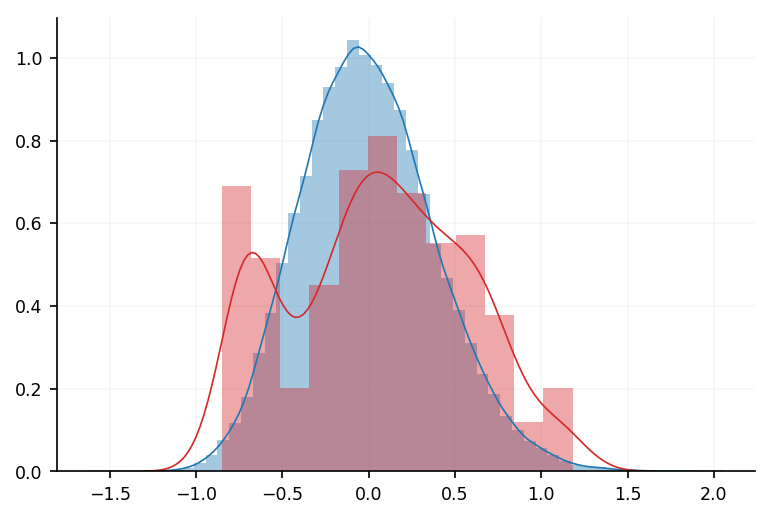

In [641]:
sns.distplot(np.mean(bs_mrls_arr_z, axis=0).flatten())
sns.distplot(np.mean(mrls_arr_z[:, :, 475:515], axis=0).flatten())

In [797]:
for index, row in unit_df.iterrows():
    subj_sess = row['subj_sess']
    unit = row['unit']
    lfp_chans = row['lfp_chan_inds']
    lfp_roi = row['lfp_hemroi']
    if index == 1000:
        print(subj_sess, unit, lfp_chans, lfp_roi)
        break

U371_env2 44 [56, 57, 58, 60, 61, 62, 63] LA


In [600]:
start_time = time()

mrls_arr, bs_mrls_arr = calc_phase_locking_mrl_morlet_chans(subj_sess, unit, lfp_chans, lfp_roi)

print('Done in {:.2f} secs'.format(time() - start_time))

Done in 250.46 secs


In [601]:
mrls_arr.shape, bs_mrls_arr.shape

((7, 16, 1001), (7, 16, 5000))

In [606]:
np.argmax(np.mean(mrls_arr, axis=0)[:, 500]), np.mean(mrls_arr, axis=0)[11, 500]

(11, 0.026526405241391642)

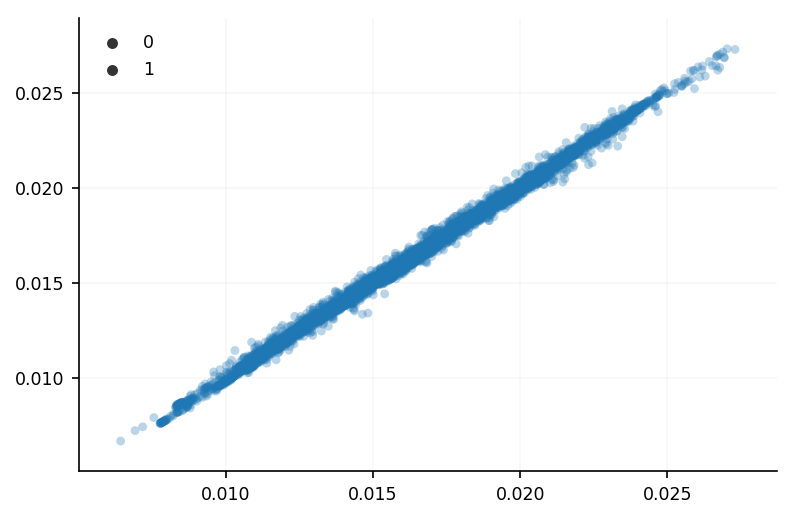

In [607]:
sns.scatterplot(np.mean(mrls_arr[:, :, 300:701], axis=0).flatten(), 
                upl_df_.query("(subj_sess=='{}') & (unit=={}) & (lfp_hemroi=='{}')".format(subj_sess, unit, lfp_roi)).tl_mrls.iat[0].flatten(),
                linewidth=0, size=1, alpha=0.3)

In [571]:
np.mean(mrls_arr[:, 4, 500]), np.argmax(np.mean(mrls_arr[:, :, 500], axis=0))

(0.03856423413254527, 4)

In [525]:
spike_inds, n_timepoints = dio.open_pickle(os.path.join(input_dir, 'spike_inds', 'spike_inds-{}Hz-{}-unit{}.pkl'
                                                        .format(sampling_rate, subj_sess, unit)))
spike_inds = spike_inds[(spike_inds>cut_inds) & (spike_inds<(n_timepoints-cut_inds))]

_, fr_df, _, _ = phase_locking.load_spikes(subj_sess)
spike_train2000 = fr_df.loc[fr_df.clus==unit, 'spikes'].iat[0]
spike_train2000[:(2000*5)] = False
spike_train2000[-(2000*5):] = False
spike_inds2000 = np.where(np.roll(spike_train2000, 183488))[0]

#stats.pearsonr(spike_inds, spike_inds2000)

In [527]:
spike_inds, n_timepoints = dio.open_pickle(os.path.join(input_dir, 'spike_inds', 'spike_inds-{}Hz-{}-unit{}.pkl'
                                                        .format(500, subj_sess, unit)))

In [538]:
phase_locking.shift_spike_inds(spike_inds, n_timepoints, 183488)

array([   123,    126,    382, ..., 633910, 634032, 634070])

In [500]:
lfp_fname = 'phase-{}-iChan{}-iFreq{}-{}Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_16.0Hz.pkl'
phase_vec = dio.open_pickle(os.path.join(input_dir, 'wavelet_phase', lfp_fname.format(subj_sess, iChan, iFreq, 500)))
phase2000_vec = phase[iFreq, iChan, :]

In [502]:
phase_vec.shape, phase2000_vec[::4].shape, phase2000_vec.shape, spike_train2000.shape

((634070,), (634070,), (2536279,), (2536279,))

In [503]:
stats.pearsonr(phase_vec, phase2000_vec[::4])

(0.9989547539660032, 0.0)

In [490]:
dio.open_pickle(os.path.join(input_dir, 'wavelet_phase', lfp_fname.format(subj_sess, 0, 10, 500))).shape

(2536279,)

In [472]:
_, lfp_preproc2000 = manning_analysis.process_lfp(subj_sess, 
                                                  subj_df=subj_df, 
                                                  sampling_rate=2000,
                                                  resampling_rate=0,
                                                  notch_freqs=notch_freqs)
_, lfp_preproc500 = manning_analysis.process_lfp(subj_sess, 
                                                 subj_df=subj_df, 
                                                 sampling_rate=2000,
                                                 resampling_rate=500,
                                                 notch_freqs=notch_freqs)

In [479]:
phase2000 = manning_analysis.run_morlet(lfp_preproc2000, 
                                        freqs=freqs, 
                                        width=morlet_width, 
                                        output=['phase'],
                                        savedir=False)
phase500 = manning_analysis.run_morlet(lfp_preproc500, 
                                       freqs=freqs, 
                                       width=morlet_width, 
                                       output=['phase'],
                                       savedir=False)

CPP total time wavelet loop:  217.9095494747162
CPP total time wavelet loop:  52.10556721687317


## LFP synchrony

In [8]:
input_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking'
lfp_fname = 'phase-{}-iChan{}-iFreq{}-{}Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_16.0Hz.pkl'
#subj_sess, unit, lfp1_chan_ind, lfp2_chan_ind, freq_ind, epoch_size = plv_list[0]
sampling_rate = 500
remove_secs = 5
cut_inds = int(sampling_rate * remove_secs)

In [ ]:
# Save each vector of spike train indices to a file.
#spike_train_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/spike_trains'
spike_train_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/spike_inds'
sampling_rate = 2000
resampling_ratio = 1

for subj_sess in sorted(subj_df.subj_sess.unique()):
    _, fr_df, _, _ = phase_locking.load_spikes(subj_sess)
    units = fr_df.clus.tolist()
    spike_trains = np.array(fr_df.spikes.tolist())
    
#     # Remove spikes in the first or last 5 secs
#     spike_trains[:, :int(sampling_rate*5)] = False
#     spike_trains[:, -int(sampling_rate*5):] = False
    n_samples = np.round(spike_trains.shape[1] * resampling_ratio).astype(int)
    for i in range(len(units)):
        spike_inds_f = os.path.join(spike_train_dir, 'spike_inds-{}Hz-{}-unit{}.pkl'.format(int(sampling_rate), subj_sess, units[i]))
        spike_inds = np.where(spike_trains[i, :])[0]
        spike_inds = np.round(spike_inds * resampling_ratio).astype(int)
        dio.save_pickle([spike_inds, n_samples], spike_inds_f, verbose=False)

In [18]:
_, fr_df, _, _ = phase_locking.load_spikes(subj_sess)

EOFError: Ran out of input

In [ ]:
fr_df.columns

In [29]:
fr_df.iloc[i]

subj_sess                                              U369_env1
chan                                                           1
location                                                      RA
pct_interp                                            0.00944533
clus                                                           0
chan_clus                                                      0
mean_fr                                                  1.49037
fr             [0.0008436540078203249, 0.0008445737773282454,...
spikes         [False, False, False, False, False, False, Fal...
interp_mask    [False, False, False, False, False, False, Fal...
Name: 0, dtype: object

In [35]:
from scipy.ndimage.filters import gaussian_filter

v = np.zeros(2001)
v[1000] = 1
g_std = (((500 * 2000) / 1000) 
         / (2 * np.sqrt(2 * np.log(2))))
g_win = gaussian_filter(v, g_std)

In [39]:
g_std

424.66090014400953

([<matplotlib.lines.Line2D at 0x2ac87804ddd8>], (2001,))

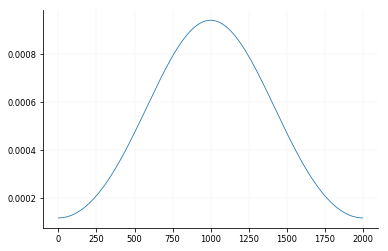

In [38]:
plt.plot(g_win), g_win.shape

In [42]:
np.min(fr_df.iloc[i].fr[spike_inds]), np.max(fr_df.iloc[i].fr[spike_inds])

(0.0009394962834141706, 0.013931492134842896)

In [44]:
i = 0
np.mean(fr_df.iloc[i].fr[spike_inds]), np.max(fr_df.iloc[i].fr[spike_inds+1500])

(0.002991938298952919, 0.013048584295661147)

In [46]:
spike_inds_f

'/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/spike_frs/spike_inds-2000Hz-U369_env1-unit0.pkl'

In [48]:
# Save each vector of spike firing rates to a file.
spike_fr_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/spike_frs'
sampling_rate = 2000

for subj_sess in sorted([x for x in subj_df.subj_sess.unique() if x!='U367_env2']):
    _, fr_df, _, _ = phase_locking.load_spikes(subj_sess)
    units = fr_df.clus.tolist()
    spike_trains = np.array(fr_df.spikes.tolist())
    
    for i in range(len(units)):
        spike_frs_f = os.path.join(spike_fr_dir, 'spike_frs-{}Hz-{}-unit{}.pkl'.format(int(sampling_rate), subj_sess, units[i]))
        spike_inds = np.where(spike_trains[i, :])[0]
        spike_frs = fr_df.iloc[i].fr[spike_inds]
        assert np.min(spike_frs) > 0
        dio.save_pickle(spike_frs, spike_frs_f, verbose=False)

In [97]:
spike_inds, n_timepoints = dio.open_pickle(os.path.join(input_dir, 'spike_inds', 'spike_inds-{}Hz-{}-unit{}.pkl'
                                                            .format(sampling_rate, subj_sess, unit)))
spike_inds = spike_inds[(spike_inds>cut_inds) & (spike_inds<(n_timepoints-cut_inds))]

In [108]:
freq_ind = 7
lfp1_phase = dio.open_pickle(os.path.join(input_dir, 'wavelet_phase', lfp_fname.format(subj_sess, lfp1_chan_ind, freq_ind, sampling_rate)))
lfp2_phase = dio.open_pickle(os.path.join(input_dir, 'wavelet_phase', lfp_fname.format(subj_sess, lfp2_chan_ind, freq_ind, sampling_rate)))
lfp1_epochs = lfp_synchrony.make_epochs(lfp1_phase, spike_inds, epoch_size)
lfp2_epochs = lfp_synchrony.make_epochs(lfp2_phase, spike_inds, epoch_size)
epoch_plvs = lfp_synchrony.calc_plv(lfp1_epochs, lfp2_epochs, axis=-1)

The slowest run took 4.61 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 23.6 ms per loop


In [222]:
# Create a DataFrame of all LFP channel pairs from which to calculate a phase-locking value.

# For each neuron, this includes all cortical-to-hippocampal channel pairs in the neuron's region
# *except for* the channel that the neuron was recorded off of. We will also take note of which
# frequency had the highest MRL and whether the phase-locking strength was significant
# for each neuron-to-hippocampal region comparison.
start_time = time()

plv_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs'
cols = ['subj_sess', 'unit', 'unit_chan_ind', 'lfp1_chan_ind', 'lfp2_chan_ind', 'lfp1_hemroi', 'lfp2_hemroi', 'locked_freq_ind', 'sig']
get_plv_df = []
for index, row in pl_df.query("edge=='ctx-hpc'").iterrows():
    subj_sess = row['subj_sess']
    unit = row['unit']
    unit_hemroi = row['unit_hemroi']
    lfp_hemroi = row['lfp_hemroi']
    locked_freq_ind_z = row['locked_freq_ind_z']
    sig_z = row['sig_z']

    unit_chan_ind = u2r_df.query("subj_sess_unit=='{}_{}'".format(subj_sess, unit)).unit_chan_ind.iat[0]
    lfp1_chan_inds = subj_df.query("(subj_sess=='{}') & (location=='{}') & (chan_ind!={})".format(subj_sess, unit_hemroi, unit_chan_ind)).chan_ind.tolist()
    lfp2_chan_inds = subj_df.query("(subj_sess=='{}') & (location=='{}')".format(subj_sess, lfp_hemroi)).chan_ind.tolist()

    for lfp1_chan_ind in lfp1_chan_inds:
        for lfp2_chan_ind in lfp2_chan_inds:
            get_plv_df.append([subj_sess, unit, unit_chan_ind, lfp1_chan_ind, lfp2_chan_ind, unit_hemroi, lfp_hemroi, locked_freq_ind_z, sig_z])
get_plv_df = pd.DataFrame(get_plv_df, columns=cols)

if False:
    dio.save_pickle(get_plv_df, '/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/metadata/get_plv_df.pkl')

print('Done in {:.2f} secs'.format(time() - start_time))

Done in 15.57 secs


In [223]:
print(get_plv_df.shape,
      len(get_plv_df.groupby(['subj_sess', 'unit', 'lfp2_hemroi'])), 
      get_plv_df.groupby(['subj_sess', 'unit', 'lfp2_hemroi']).size().unique(),
      get_plv_df.query("(sig==True)").shape)
display(get_plv_df.head())

(92952, 9) 1659 [56 64] (28744, 9)


subj_sess  unit  unit_chan_ind  lfp1_chan_ind  lfp2_chan_ind lfp1_hemroi  \
0  U379_ses1     0              0              1             40          RA   
1  U379_ses1     0              0              1             41          RA   
2  U379_ses1     0              0              1             42          RA   
3  U379_ses1     0              0              1             43          RA   
4  U379_ses1     0              0              1             44          RA   

  lfp2_hemroi  locked_freq_ind   sig  
0         LAH                1  True  
1         LAH                1  True  
2         LAH                1  True  
3         LAH                1  True  
4         LAH                1  True

In [224]:
# Save each get_plv_df group.
grouped = get_plv_df.groupby(['subj_sess', 'unit', 'lfp2_hemroi'])
for index, group in grouped:
    subj_sess, unit, lfp_hemroi = index
    savedir = '/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/metadata/get_plv_df_groups'
    fpath = os.path.join(savedir, 'get_plv_df-{}-unit_{}-to-region_{}.pkl'.format(subj_sess, unit, lfp_hemroi))
    dio.save_pickle(group, fpath, verbose=False)

In [667]:
# Save each get_plv_df row.
for index, row in get_plv_df.query("(sig==True)").iterrows():
    subj_sess = row.subj_sess
    unit = row.unit
    lfp1_chan_ind = row.lfp1_chan_ind
    lfp2_chan_ind = row.lfp2_chan_ind
    lfp2_roi = row.lfp2_hemroi
    savedir = '/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/metadata/get_plv_df_rows'
    fpath = os.path.join(savedir, 'get_plv_df-{}-unit_{}-to-{}-chan_ind_{}-to-chan_ind_{}.pkl'
                         .format(subj_sess, unit, lfp2_roi, lfp1_chan_ind, lfp2_chan_ind))
    dio.save_pickle(row, fpath, verbose=False)

In [235]:
start_time = time()

output = lfp_synchrony.get_epoch_plvs3(os.path.join(savedir, 'get_plv_df-U395_ses2-unit_31-to-region_RAH.pkl'), sleep_max=2)

print('Done in {:.2f} secs'.format(time() - start_time))

Done in 1543.87 secs


In [277]:
info = dio.open_pickle(os.path.join(savedir, 'get_plv_df-U395_ses2-unit_31-to-region_RAH.pkl'))
info.head()

subj_sess  unit  unit_chan_ind  lfp1_chan_ind  lfp2_chan_ind  \
31920  U395_ses2    31             52             48             16   
31921  U395_ses2    31             52             48             17   
31922  U395_ses2    31             52             48             18   
31923  U395_ses2    31             52             48             19   
31924  U395_ses2    31             52             48             20   

      lfp1_hemroi lfp2_hemroi  locked_freq_ind    sig  
31920         LPG         RAH               11  False  
31921         LPG         RAH               11  False  
31922         LPG         RAH               11  False  
31923         LPG         RAH               11  False  
31924         LPG         RAH               11  False

In [237]:
plvs_arr.shape, bs_plvs_arr.shape

((56, 16, 8059), (56, 16, 500))

In [248]:
# Z-score PLVs against their respective channel
# and frequency from the bootstrap distribution.
bs_means = np.expand_dims(np.mean(bs_plvs_arr, axis=-1), axis=-1)
bs_stds = np.expand_dims(np.std(bs_plvs_arr, axis=-1), axis=-1)
bs_plvs_arr_z = (bs_plvs_arr - bs_means) / bs_stds
plvs_arr_z = (plvs_arr - bs_means) / bs_stds

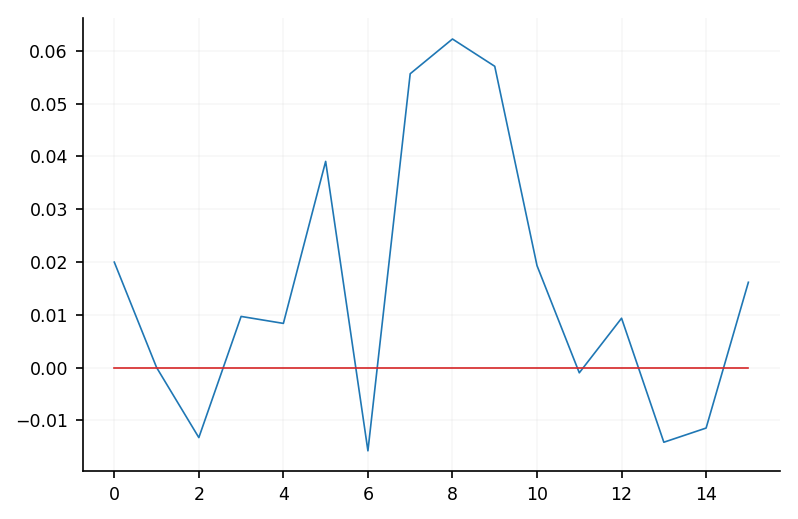

In [266]:
plt.plot(np.mean(plvs_arr_z, axis=(0, 2)).flatten())
plt.plot(np.mean(bs_plvs_arr_z, axis=(0, 2)).flatten())

In [74]:
# Get the epoch size for each frequency.
n_cyles = 5
sampling_rate = 500
epoch_sizes = [int(sampling_rate * (1/freq) * n_cyles) for freq in freqs]

# Convert get_plv_df into a list and save it.
plv_list = get_plv_df[['subj_sess', 'unit', 'lfp1_chan_ind', 'lfp2_chan_ind', 'locked_freq_ind']].values.tolist()
plv_list = [vec + [epoch_sizes[vec[-1]]] for vec in plv_list]

if False:
    dio.save_pickle(plv_list, '/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/plvs/plv_list.pkl')

Saved /scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/plvs/plv_list.pkl


(5407,)


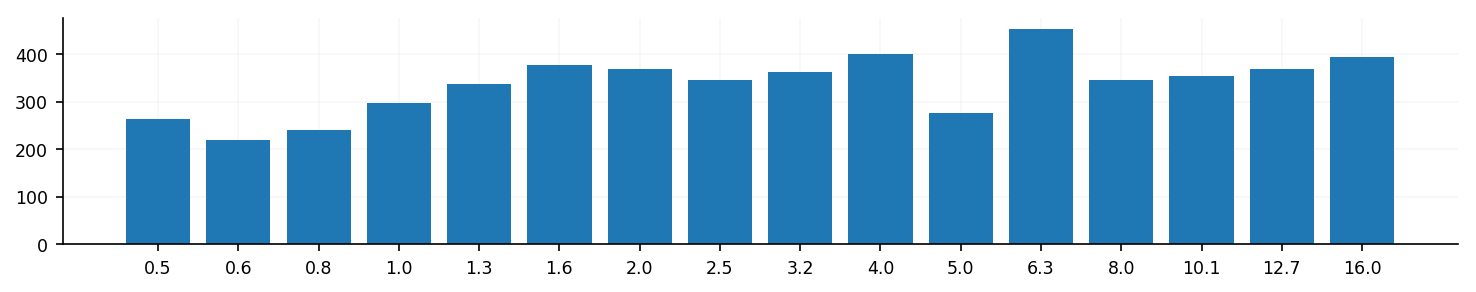

In [64]:
save_phases_arr = []
for index, row in get_plv_df.query("sig==False").iterrows():
    save_phases_arr.append('{}-{}-{}'.format(row['subj_sess'], row['lfp1_chan_ind'], row['locked_freq_ind']))
    save_phases_arr.append('{}-{}-{}'.format(row['subj_sess'], row['lfp2_chan_ind'], row['locked_freq_ind']))
save_phases_arr = np.unique(save_phases_arr)
print(save_phases_arr.shape)
xvals, yvals = np.unique([int(val.split('-')[-1]) for val in save_phases_arr], return_counts=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.bar(xvals, yvals)
ax.set_xticks(xvals)
ax.set_xticklabels([round(freqs[i],1) for i in xvals])
plt.show()

(2677,)


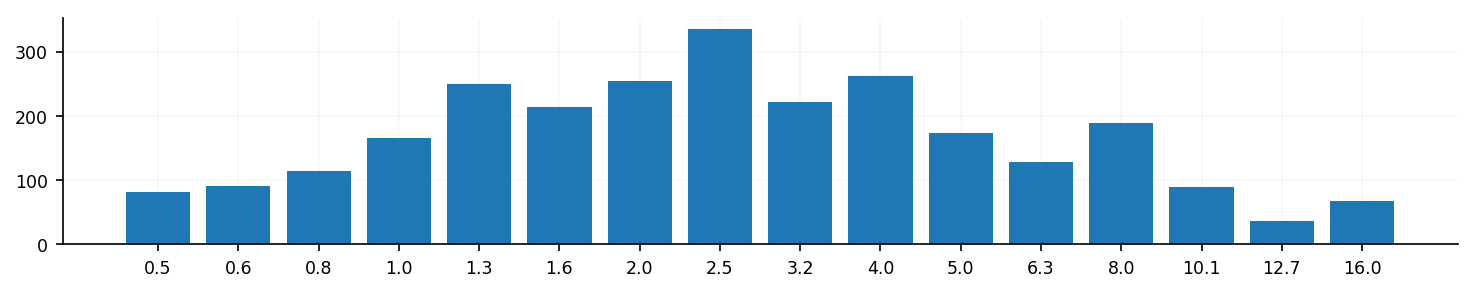

In [65]:
save_phases_arr = []
for index, row in get_plv_df.query("sig==True").iterrows():
    save_phases_arr.append('{}-{}-{}'.format(row['subj_sess'], row['lfp1_chan_ind'], row['locked_freq_ind']))
    save_phases_arr.append('{}-{}-{}'.format(row['subj_sess'], row['lfp2_chan_ind'], row['locked_freq_ind']))
save_phases_arr = np.unique(save_phases_arr)
print(save_phases_arr.shape)
xvals, yvals = np.unique([int(val.split('-')[-1]) for val in save_phases_arr], return_counts=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.bar(xvals, yvals)
ax.set_xticks(xvals)
ax.set_xticklabels([round(freqs[i],1) for i in xvals])
plt.show()

In [616]:
i = 1000
subj_sess, unit, lfp1_chan_ind, lfp2_chan_ind, freq_ind, epoch_size = plv_list[i]
plvs = lfp_synchrony.get_epoch_plvs(subj_sess, unit, lfp1_chan_ind, lfp2_chan_ind, freq_ind, epoch_size, save_outputs=False)
print(np.mean(plvs))

0.2627124511850008


In [261]:
upl_df_ = upl_df.query("(subj_sess=='{}') & (unit=='{}') & (lfp_hemroi=='{}')".format(subj_sess, unit, lfp2_hemroi))

## Phase-locking MRL vs. LFP-LFP PLVs across unit-to-region connections

In [10]:
# Get the mean phase-locking value across all channel comparisons for each
# unit-to-hippocampal region pair.
start_time = time()

pl_df_ = pl_df.query("(edge=='ctx-hpc')").reset_index(drop=True)
plv_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/plvs'
fname = 'lfp_plvs-{}-unit_{}-to-region_{}-500Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_16.0Hz.pkl'
add_cols = OrderedDict([('plvs', []),
                        ('plvs_z', [])])
drop_rows = []
for index, row in pl_df_.iterrows():
    subj_sess = row.subj_sess
    unit = row.unit
    roi = row.lfp_hemroi
    plv_file = os.path.join(plv_dir, fname.format(subj_sess, unit, roi))
    if os.path.exists(plv_file):
        plv_dat = dio.open_pickle(plv_file)
        for key in add_cols.keys():
            add_cols[key].append(plv_dat[key])
    else:
        drop_rows.append(index)
    if index % 100 == 0 or index == len(pl_df_):
        print('{}: {:.0f} secs'.format(index, time() - start_time))

pl_df_ = pl_df_.drop(index=drop_rows).reset_index(drop=True)
for key in add_cols.keys():
    pl_df_[key] = add_cols[key]
    
print('Done in {:.2f} secs'.format(time() - start_time))

0: 0 secs
100: 13 secs
200: 25 secs
300: 39 secs
400: 59 secs
500: 79 secs
600: 98 secs
700: 114 secs
800: 128 secs
900: 139 secs
Done in 143.12 secs


In [791]:
# Add local phase-locking strength at the HPC
# phase-locked frequency.
start_time = time()

n_bootstraps = 5000
alpha = 0.05 / len(freqs)
local_locked_mrls_z = []
local_sig_z = []
for index, row in pl_df_.iterrows():
    subj_sess = row.subj_sess
    unit = row.unit
    locked_freq_ind_z = row.locked_freq_ind_z
    local_row = pl_df.query("(edge=='ctx-local') & (subj_sess=='{}') & (unit=={})".format(subj_sess, unit))
    local_locked_mrls_z.append(local_row.mrls_z.iat[0][locked_freq_ind_z])
    local_sig_z.append((  (1 + np.sum(local_row.bs_mrls_z.iat[0][locked_freq_ind_z, :] >= local_locked_mrls_z[-1])) 
                        / (1 + n_bootstraps)
                       ) < alpha)
    
pl_df_['local_locked_mrl_z'] = local_locked_mrls_z # local Z-MRL at the frequency of maximal HPC phase-locking
pl_df_['local_sig_z'] = local_sig_z # local Z-MRL is significant at the frequency of maximal HPC phase-locking?

print('Done in {:.2f} secs'.format(time() - start_time))

Done in 4.41 secs


In [848]:
from scipy.special import logit
pl_df_['locked_plv'] = pl_df_.apply(lambda x: x['plvs'][x['locked_freq_ind_z']], axis=1)
pl_df_['locked_plv_logit'] = logit(pl_df_.locked_plv)
pl_df_['locked_plv_z'] = pl_df_.apply(lambda x: x['plvs_z'][x['locked_freq_ind_z']], axis=1)
pl_df_['nonlocked_plv'] = pl_df_.apply(lambda x: np.mean(x['plvs'][[i for i in np.arange(len(freqs)) if i not in [x['locked_freq_ind_z']]]]), axis=1)
pl_df_['nonlocked_plv_logit'] = logit(pl_df_.nonlocked_plv)
pl_df_['nonlocked_plv2_logit'] = logit(pl_df_.apply(lambda x: np.mean(x['plvs'][[i for i in np.arange(len(freqs)) if i not in 
                                                                      [x['locked_freq_ind_z'], x['locked_freq_ind_z']-1, x['locked_freq_ind_z']-2,
                                                                       x['locked_freq_ind_z']+1, x['locked_freq_ind_z']+2]]]), axis=1))
pl_df_['nonlocked_plv_z'] = pl_df_.apply(lambda x: np.mean(x['plvs_z'][[i for i in np.arange(len(freqs)) if i not in [x['locked_freq_ind_z']]]]), axis=1)
pl_df_['locked_logfreq_z'] = pl_df_.locked_freq_ind_z.apply(lambda x: np.log10(freqs)[x])

In [808]:
pl_df_[['sig_z', 'local_sig_z']]
pl_df_.sig_z.mean(), np.mean(pl_df_.apply(lambda x: (x['sig_z']==True) & (x['local_sig_z']==False), axis=1))

(0.3262935586061246, 0.14783526927138332)

In [856]:
print(stats.pearsonr(pl_df_.locked_plv, pl_df_.locked_plv_logit), 
      stats.pearsonr(pl_df_.nonlocked_plv, pl_df_.nonlocked_plv_logit),
      stats.pearsonr(pl_df_.nonlocked_plv2, pl_df_.nonlocked_plv2_logit))

(0.999712090484986, 0.0) (0.9999824780458699, 0.0) (0.9999801638667923, 0.0)


In [851]:
print(stats.pearsonr(pl_df_.locked_plv, pl_df_.nonlocked_plv))
print(stats.pearsonr(pl_df_.locked_plv, pl_df_.nonlocked_plv2))
print(stats.pearsonr(pl_df_.nonlocked_plv, pl_df_.nonlocked_plv2))

(0.8910177730931157, 0.0)
(0.8683490956081117, 4.6446227503108364e-290)
(0.9926322169933353, 0.0)


In [861]:
pl_df_.query("(sig_z==True)").shape, pl_df_.shape

((309, 67), (947, 67))

In [873]:
stats.pearsonr(pl_df_.sig_z, pl_df_.local_sig_z), np.sum(pl_df_.sig_z), np.sum(pl_df_.local_sig_z), np.sum()

((0.3274898296659266, 4.1221823662726962e-25), 309, 309)

In [880]:
pl_df_.query("(local_sig_z==False) & (sig_z==True)").shape, pl_df_.query("(sig_z==True)").shape

((140, 67), (309, 67))

(0.2686010399138429, 4.1049556657935187e-17)
(0.20352383700704768, 0.00031713841460978803)
(0.15558914303217705, 7.936022377601e-05)
(0.1797817570153125, 0.03354617228761518)
Ttest_relResult(statistic=-0.1427290778285265, pvalue=0.8865974758300716)


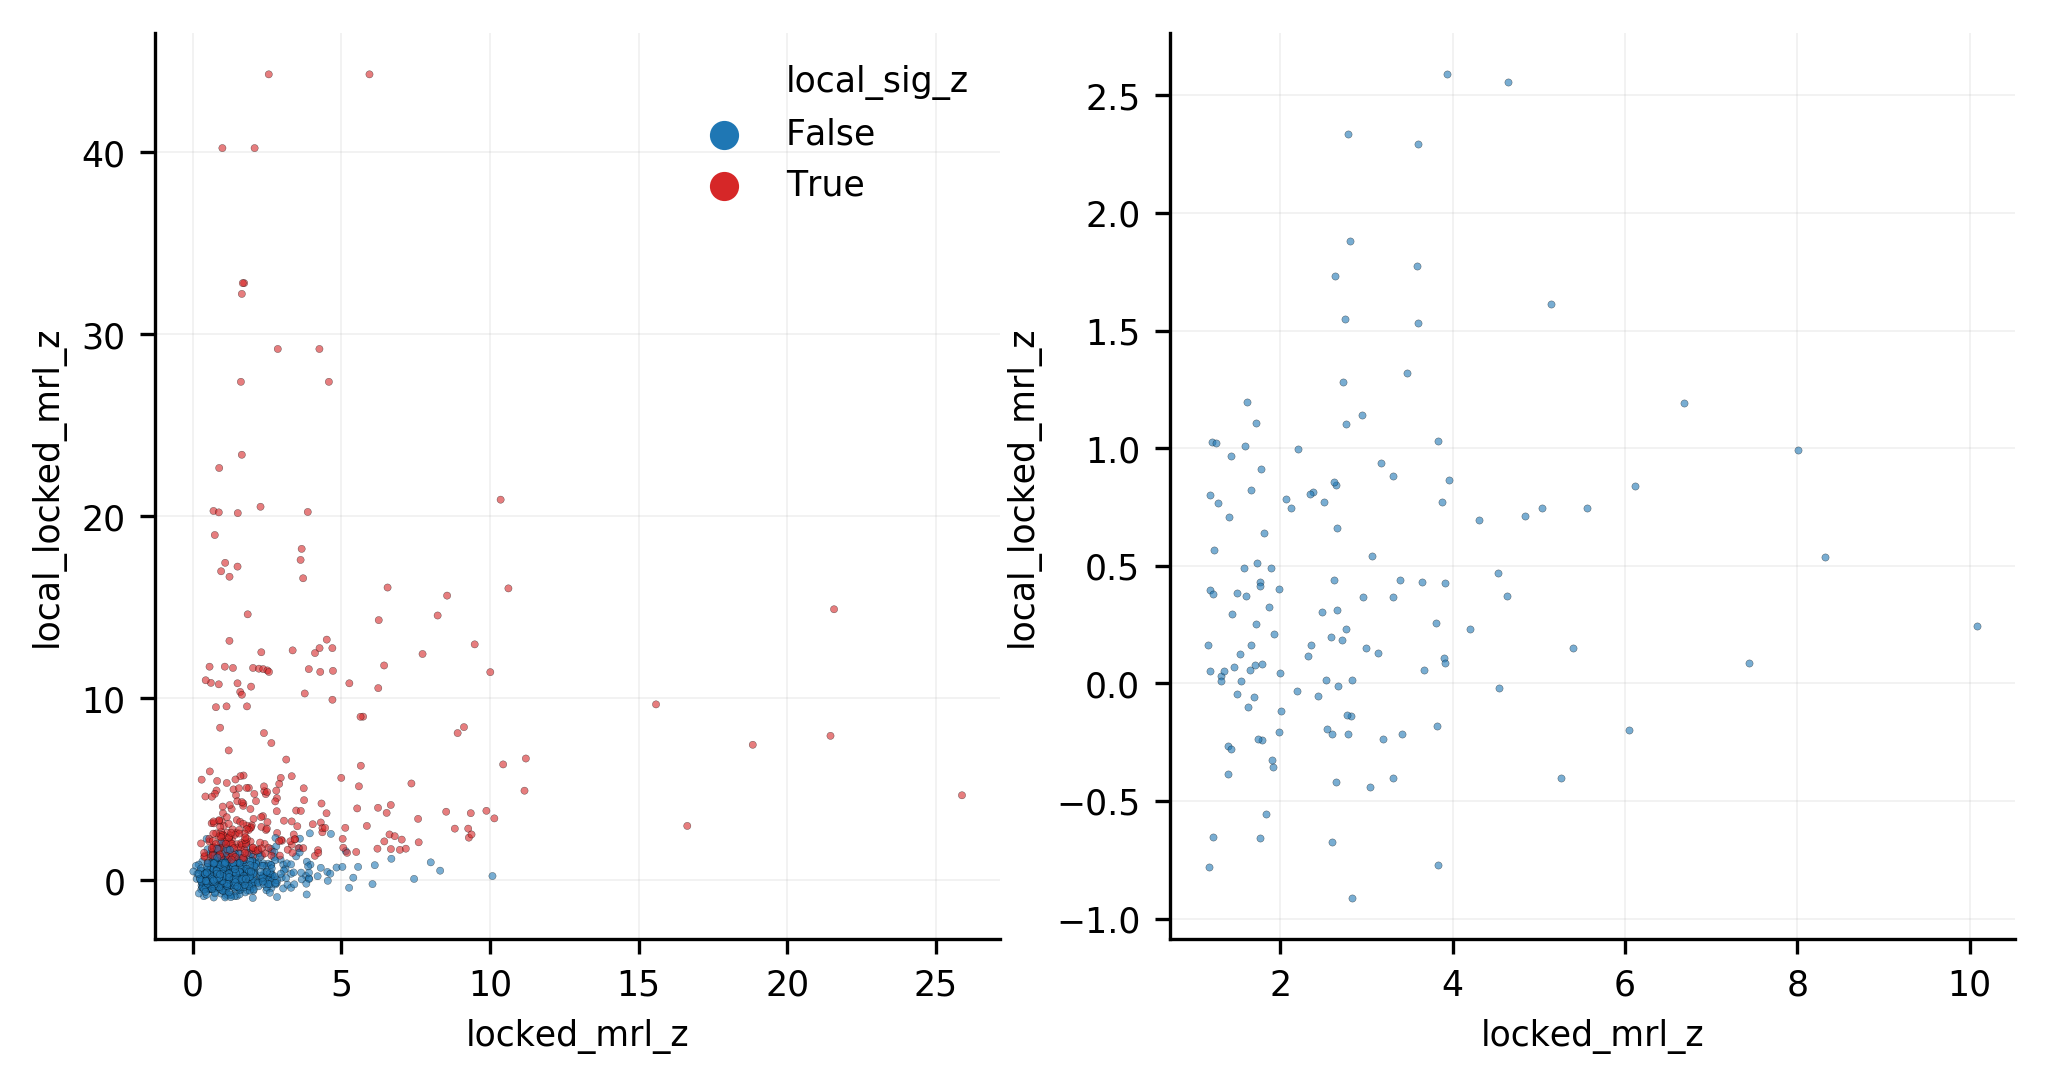

In [883]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.scatterplot('locked_mrl_z', 'local_locked_mrl_z', hue='local_sig_z', data=pl_df_,
                s=3, alpha=0.6, edgecolor='k', linewidth=0.1, ax=ax[0])

sns.scatterplot('locked_mrl_z', 'local_locked_mrl_z', data=pl_df_.query("(local_sig_z==False) & (sig_z==True)"),
                s=3, alpha=0.6, edgecolor='k', linewidth=0.1, ax=ax[1])

print(stats.pearsonr(pl_df_.locked_mrl_z, pl_df_.local_locked_mrl_z))
print(stats.pearsonr(pl_df_.query("(sig_z==True)").locked_mrl_z, pl_df_.query("(sig_z==True)").local_locked_mrl_z))
print(stats.pearsonr(pl_df_.query("(local_sig_z==False)").locked_mrl_z, pl_df_.query("(local_sig_z==False)").local_locked_mrl_z))
print(stats.pearsonr(pl_df_.query("(local_sig_z==False) & (sig_z==True)").locked_mrl_z, 
                     pl_df_.query("(local_sig_z==False) & (sig_z==True)").local_locked_mrl_z))
print(stats.ttest_rel(pl_df_.query("(sig_z==True)").locked_mrl_z, pl_df_.query("(sig_z==True)").local_locked_mrl_z))

In [850]:
pl_df_.head()

subj_sess subj_sess_unit unit unit_chan_ind unit_hemroi unit_hem unit_roi  \
0  U372_ses2   U372_ses2_23   23            43         LPG        L       PG   
1  U369_env1   U369_env1_58   58            52         LST        L       ST   
2  U369_env1   U369_env1_46   46            37          LA        L        A   
3  U372_ses2    U372_ses2_0    0             2          RA        R        A   
4  U369_env1   U369_env1_57   57            52         LST        L       ST   

  unit_is_hpc unit_nspikes   unit_fr         ...          locked_plv_z  \
0           0          757  0.454509         ...              0.017439   
1           0          681  0.537007         ...             -0.006407   
2           0          491  0.387181         ...              0.038524   
3           0          314  0.188528         ...              0.048467   
4           0          596   0.46998         ...              0.004539   

  locked_logfreq_z nonlocked_plv nonlocked_plv_z nonlocked_plv2  \
0         1.003433      0.490935       -0.002989       0.492146   
1         1.103777      0.489309       -0.001426       0.489118   
2         0.501717      0.472230        0.042474       0.475510   
3         0.602060      0.502225        0.025959       0.501252   
4         1.103777      0.462994        0.012884       0.465254   

  local_locked_mrl_z local_sig_z locked_plv_logit nonlocked_plv_logit  \
0          -0.377147       False        -0.047993           -0.036264   
1           0.065391       False        -0.127823           -0.042769   
2           0.166925       False        -0.127183           -0.111196   
3          -0.415169       False         0.045227            0.008899   
4           0.943168       False        -0.260845           -0.148295   

  nonlocked_plv2_logit  
0            -0.031417  
1            -0.043534  
2            -0.098039  
3             0.005006  
4            -0.139207  

[5 rows x 67 columns]

In [858]:
pl_df_.to_csv(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/plvs', 'pl_plv_df-ctx_to_hpc.csv'), 
              columns=['subj_sess', 'unit', 'unit_hemroi', 'unit_roi2', 'lfp_hemroi', 'unit_fr', 
                       'locked_freq_ind_z', 'locked_logfreq_z', 'locked_mrl', 'locked_mrl_z', 'sig_z',
                       'local_locked_mrl_z', 'local_sig_z',
                       'locked_plv', 'locked_plv_logit', 'nonlocked_plv', 'nonlocked_plv_logit', 'nonlocked_plv2_logit'])

In [ ]:
dat = pd.read_csv('/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/plvs/pl_plv_df-ctx_to_hpc2.csv')
dat = dat.drop(columns=['Unnamed: 0', 'X'])

In [241]:
# Get the PLV for frequencies below and above the locked frequency.
freq_d = OrderedDict()
n_steps = 10
for step in np.arange(-n_steps, n_steps+1):
    if step <= 0:
        df = pl_df_.query("(locked_freq_ind_z>={})".format(-step))
    else:
        df = pl_df_.query("(locked_freq_ind_z<{})".format(len(freqs) - step))
    freq_d[step] = pd.DataFrame(np.vstack((df.locked_mrl_z, 
                                            df.apply(lambda x: x['plvs'][x['locked_freq_ind_z']+step], axis=1), 
                                            df.sig_z)).T,
                                 columns=['mrl', 'plv', 'sig'])
    
# Get 1) the mean difference in PLV between phase-locked and non-phase-locked connections,
# and 2) the Pearson correlation between phase-locking Z-MRL and LFP PLV, at frequencies
# from -5 to +5 from the frequency of maximal single-unit phase-locking.
diffs = []
corrs = []
for i in np.arange(-n_steps, n_steps+1):
    diffs.append([freq_d[i].query("(sig==True)").plv.mean() - freq_d[i].query("(sig==False)").plv.mean(),
                  stats.sem(freq_d[i].query("(sig==True)").plv.mean() - freq_d[i].query("(sig==False)").plv)])
    corrs.append(stats.pearsonr(freq_d[i].query("(sig==True)").mrl, freq_d[i].query("(sig==True)").plv)[0])
    
diffs = np.array(diffs)

In [242]:
# Get the PLV for frequencies below and above the locked frequency.
freq_d2 = OrderedDict()
for i in np.arange(len(freqs)):
    freq_d2[i] = pd.DataFrame(np.vstack((pl_df_.locked_mrl_z, 
                                         pl_df_.apply(lambda x: x['plvs'][i], axis=1), 
                                         pl_df_.sig_z)).T,
                                 columns=['mrl', 'plv', 'sig'])
    
# Get 1) the mean difference in PLV between phase-locked and non-phase-locked connections,
# and 2) the Pearson correlation between phase-locking Z-MRL and LFP PLV, at frequencies
# from -5 to +5 from the frequency of maximal single-unit phase-locking.
diffs2 = []
corrs2 = []
for i in np.arange(len(freqs)):
    diffs2.append([freq_d2[i].query("(sig==True)").plv.mean() - freq_d2[i].query("(sig==False)").plv.mean(),
                   stats.sem(freq_d2[i].query("(sig==True)").plv.mean() - freq_d2[i].query("(sig==False)").plv)])
    corrs2.append(stats.pearsonr(freq_d2[i].query("(sig==True)").mrl, freq_d2[i].query("(sig==True)").plv)[0])
    
diffs2 = np.array(diffs2)

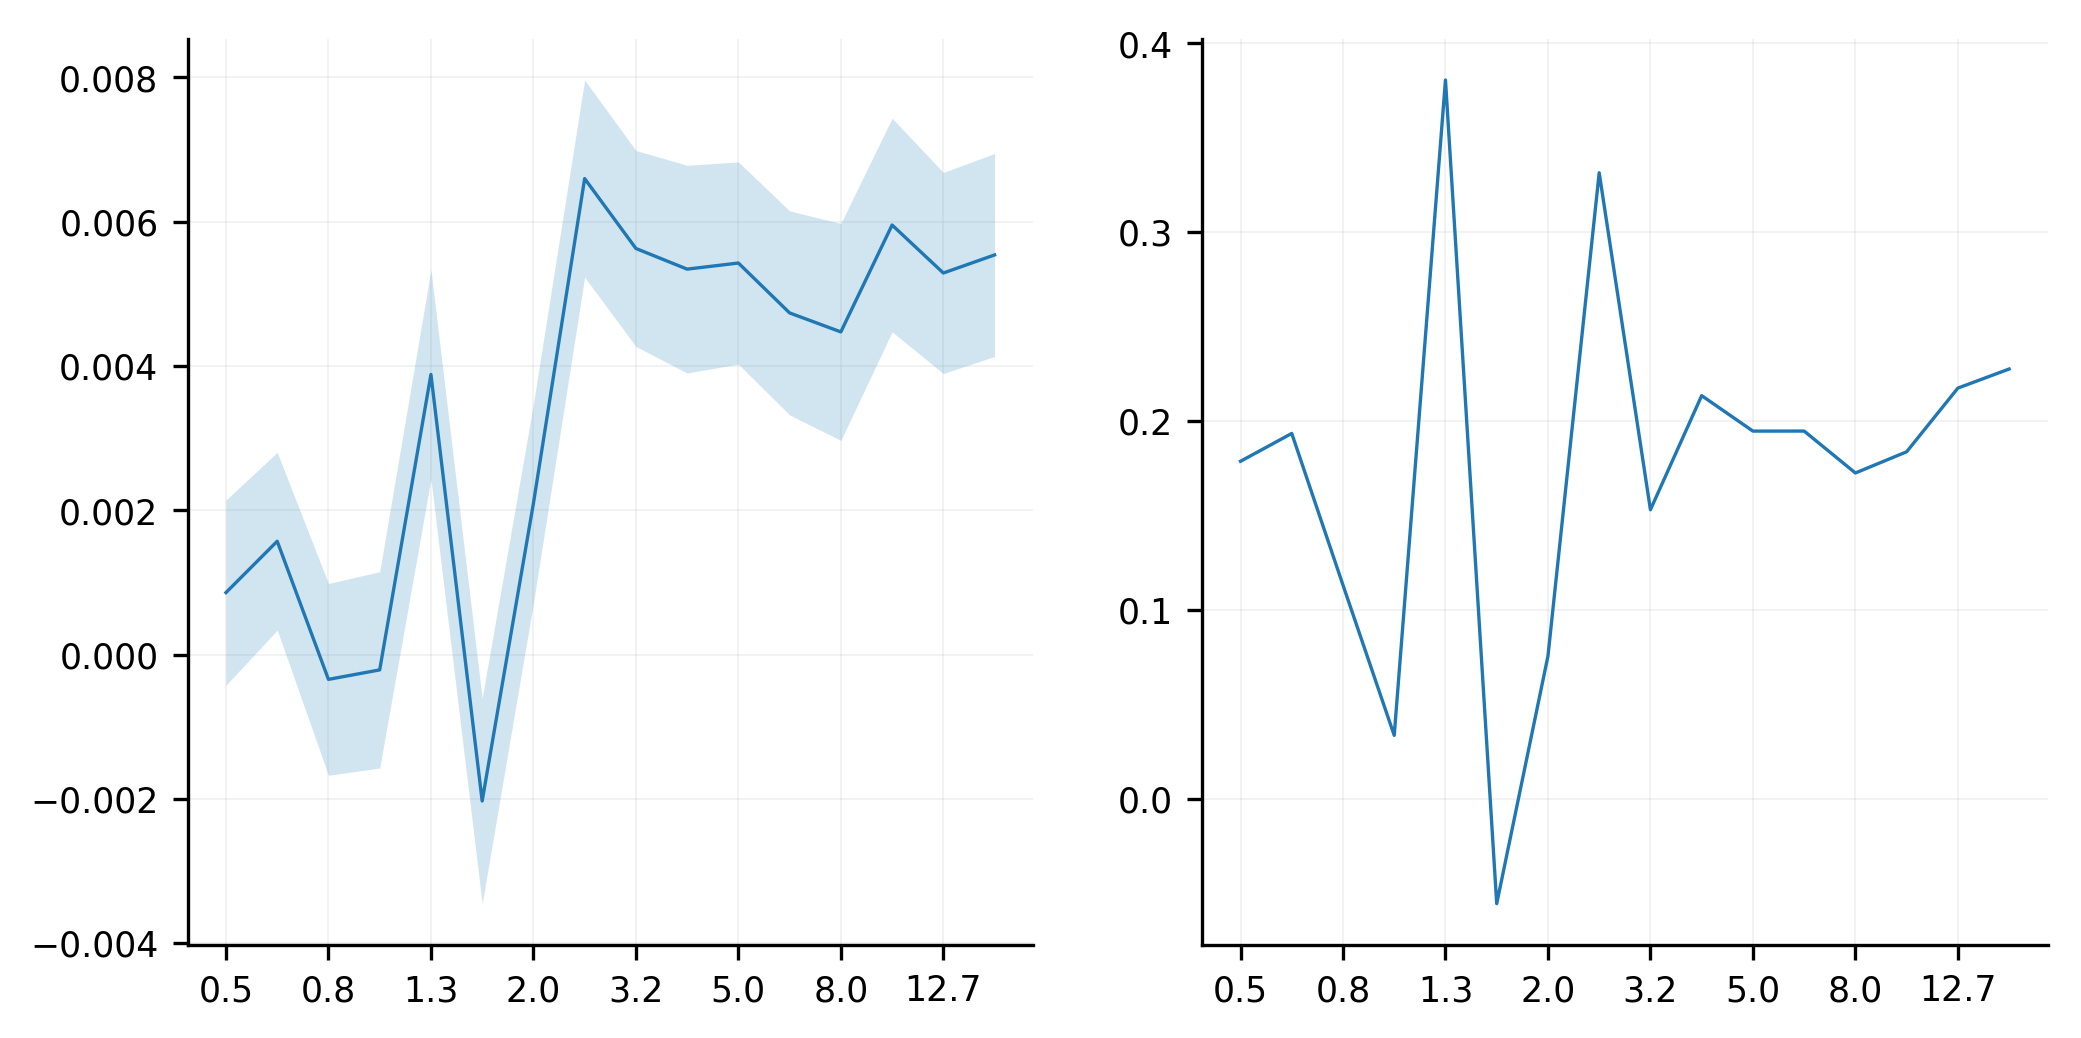

In [250]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

ax[0].plot(diffs2[:, 0])
ax[0].fill_between(np.arange(len(freqs)), diffs2[:, 0] - diffs2[:, 1], diffs2[:, 0] + diffs2[:, 1], color=colors[0], alpha=0.25, linewidth=0)
ax[1].plot(corrs2)
for i in range(2):
    ax[i].set_xticks(np.arange(len(freqs))[::2])
    ax[i].set_xticklabels([round(freqs[i],1) for i in np.arange(len(freqs))[::2]])

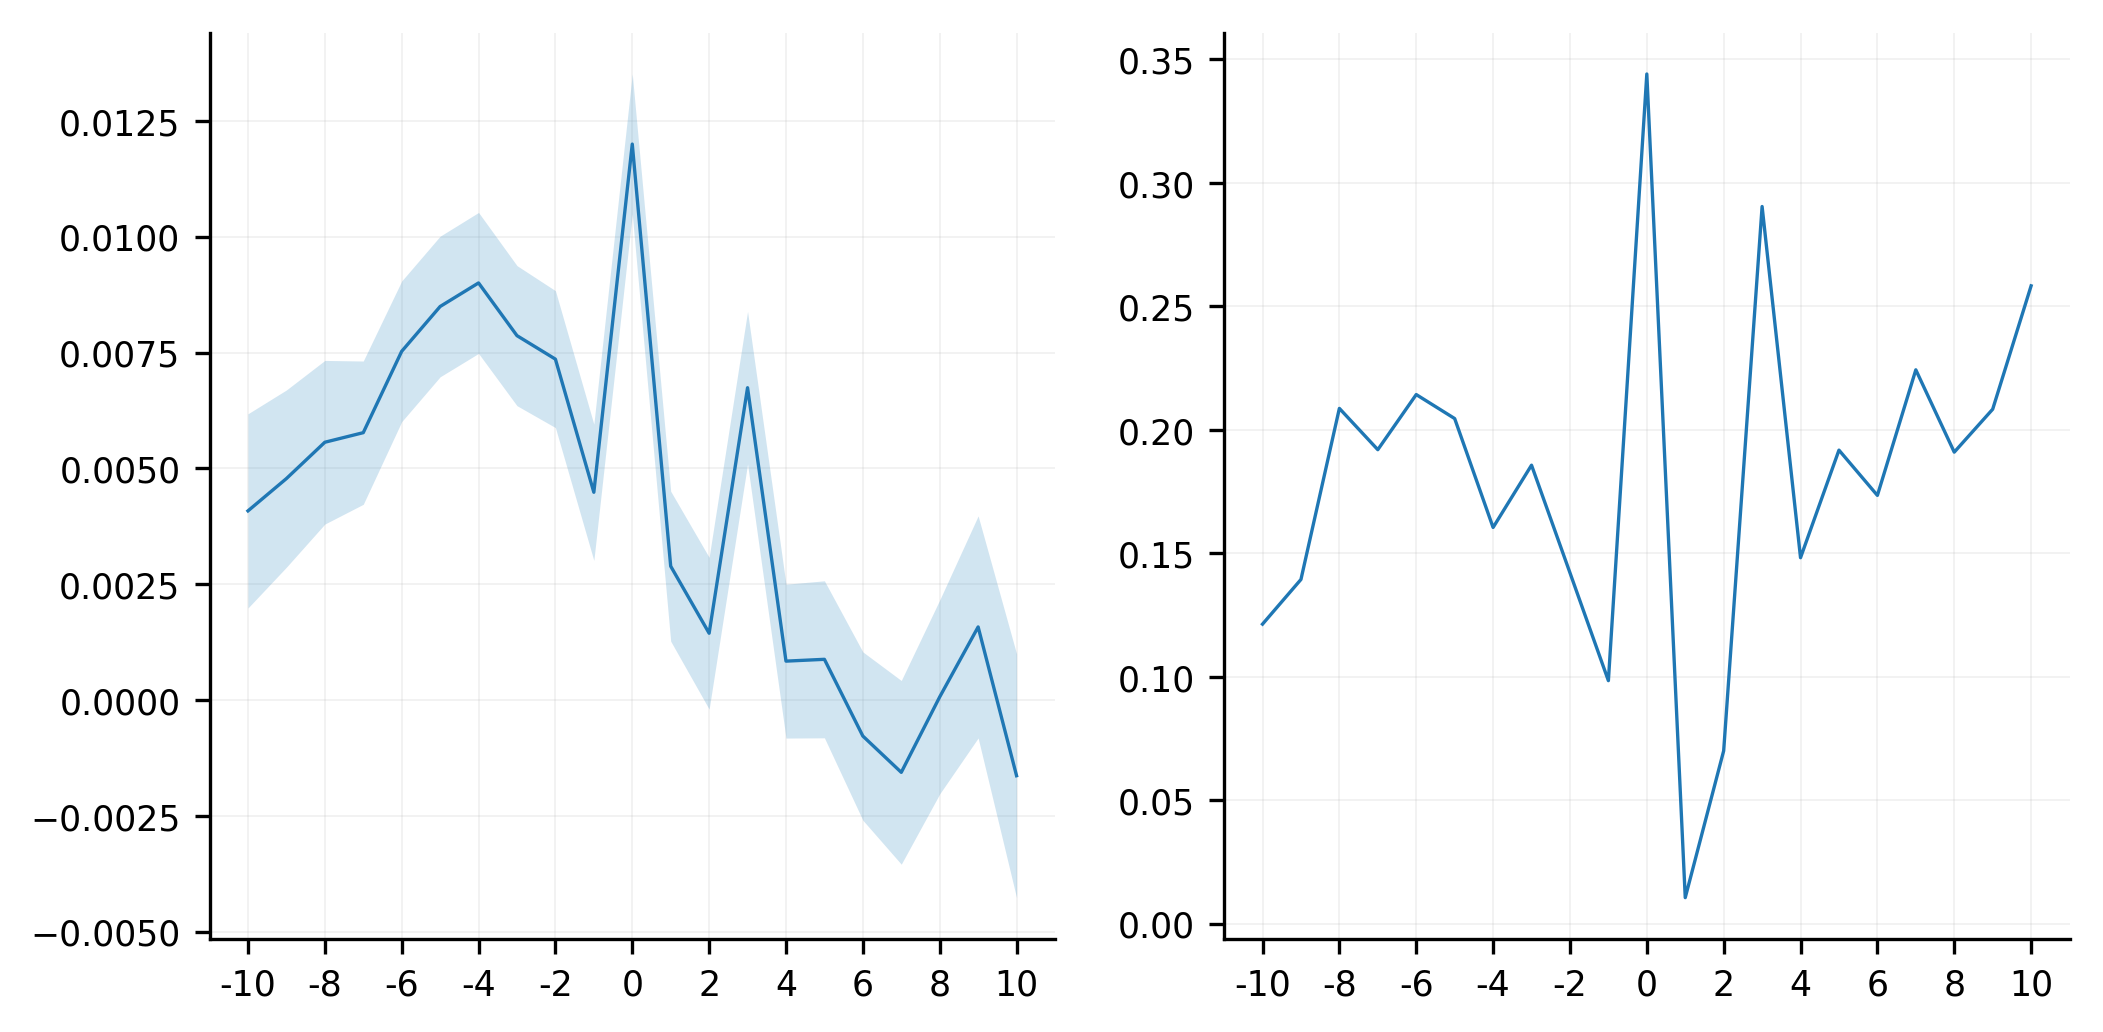

In [237]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

ax[0].plot(diffs[:, 0])
ax[0].fill_between(np.arange(2*n_steps + 1), diffs[:, 0] - diffs[:, 1], diffs[:, 0] + diffs[:, 1], color=colors[0], alpha=0.25, linewidth=0)
ax[1].plot(corrs)
for i in range(2):
    ax[i].set_xticks(np.arange(2*n_steps + 1)[::2])
    ax[i].set_xticklabels(np.arange(-n_steps, n_steps+1)[::2])

(0.2666755327278343, 6.984978890797195e-17) (0.112076061208591, 0.0005496934489405968)
(0.3441097984880929, 5.125458018225659e-10) (0.1771877211443678, 0.0017670209593698746)
(0.010724785404052032, 0.7416936715021364)
Ttest_indResult(statistic=21.67840757268064, pvalue=6.582818955973538e-85)
Ttest_indResult(statistic=4.153994970298048, pvalue=3.5630933358345225e-05)
Ttest_indResult(statistic=-0.07078203833850491, pvalue=0.943586203303272)


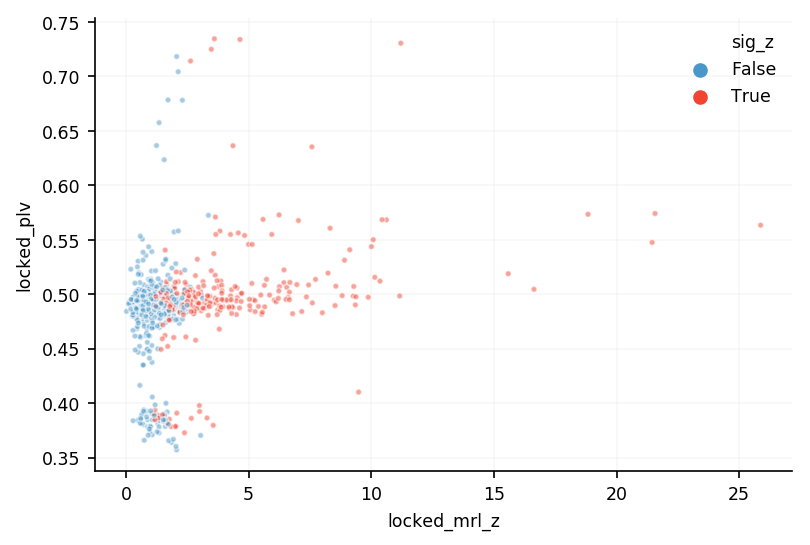

In [183]:
print(stats.pearsonr(pl_df_.locked_mrl_z, pl_df_.locked_plv), stats.pearsonr(pl_df_.locked_mrl_z, pl_df_.nonlocked_plv))
print(stats.pearsonr(pl_df_.query("(sig_z==True)").locked_mrl_z, pl_df_.query("(sig_z==True)").locked_plv),
      stats.pearsonr(pl_df_.query("(sig_z==True)").locked_mrl_z, pl_df_.query("(sig_z==True)").nonlocked_plv))
print(stats.pearsonr(pl_df_.locked_mrl_z, pl_df_.locked_plv_z))
print(stats.ttest_ind(pl_df_.query("(sig_z==True)").locked_mrl_z, pl_df_.query("(sig_z==False)").locked_mrl_z))
print(stats.ttest_ind(pl_df_.query("(sig_z==True)").locked_plv, pl_df_.query("(sig_z==False)").locked_plv))
print(stats.ttest_ind(pl_df_.query("(sig_z==True)").locked_plv_z, pl_df_.query("(sig_z==False)").locked_plv_z))
sns.scatterplot(pl_df_.locked_mrl_z, pl_df_.locked_plv, hue=pl_df_.sig_z, alpha=0.5, s=8, palette=colors[:2])

Ttest_indResult(statistic=4.153994970298048, pvalue=3.5630933358345225e-05)
(0.3441097984880929, 5.125458018225659e-10)


Text(0,0.5,'LFP PLV')

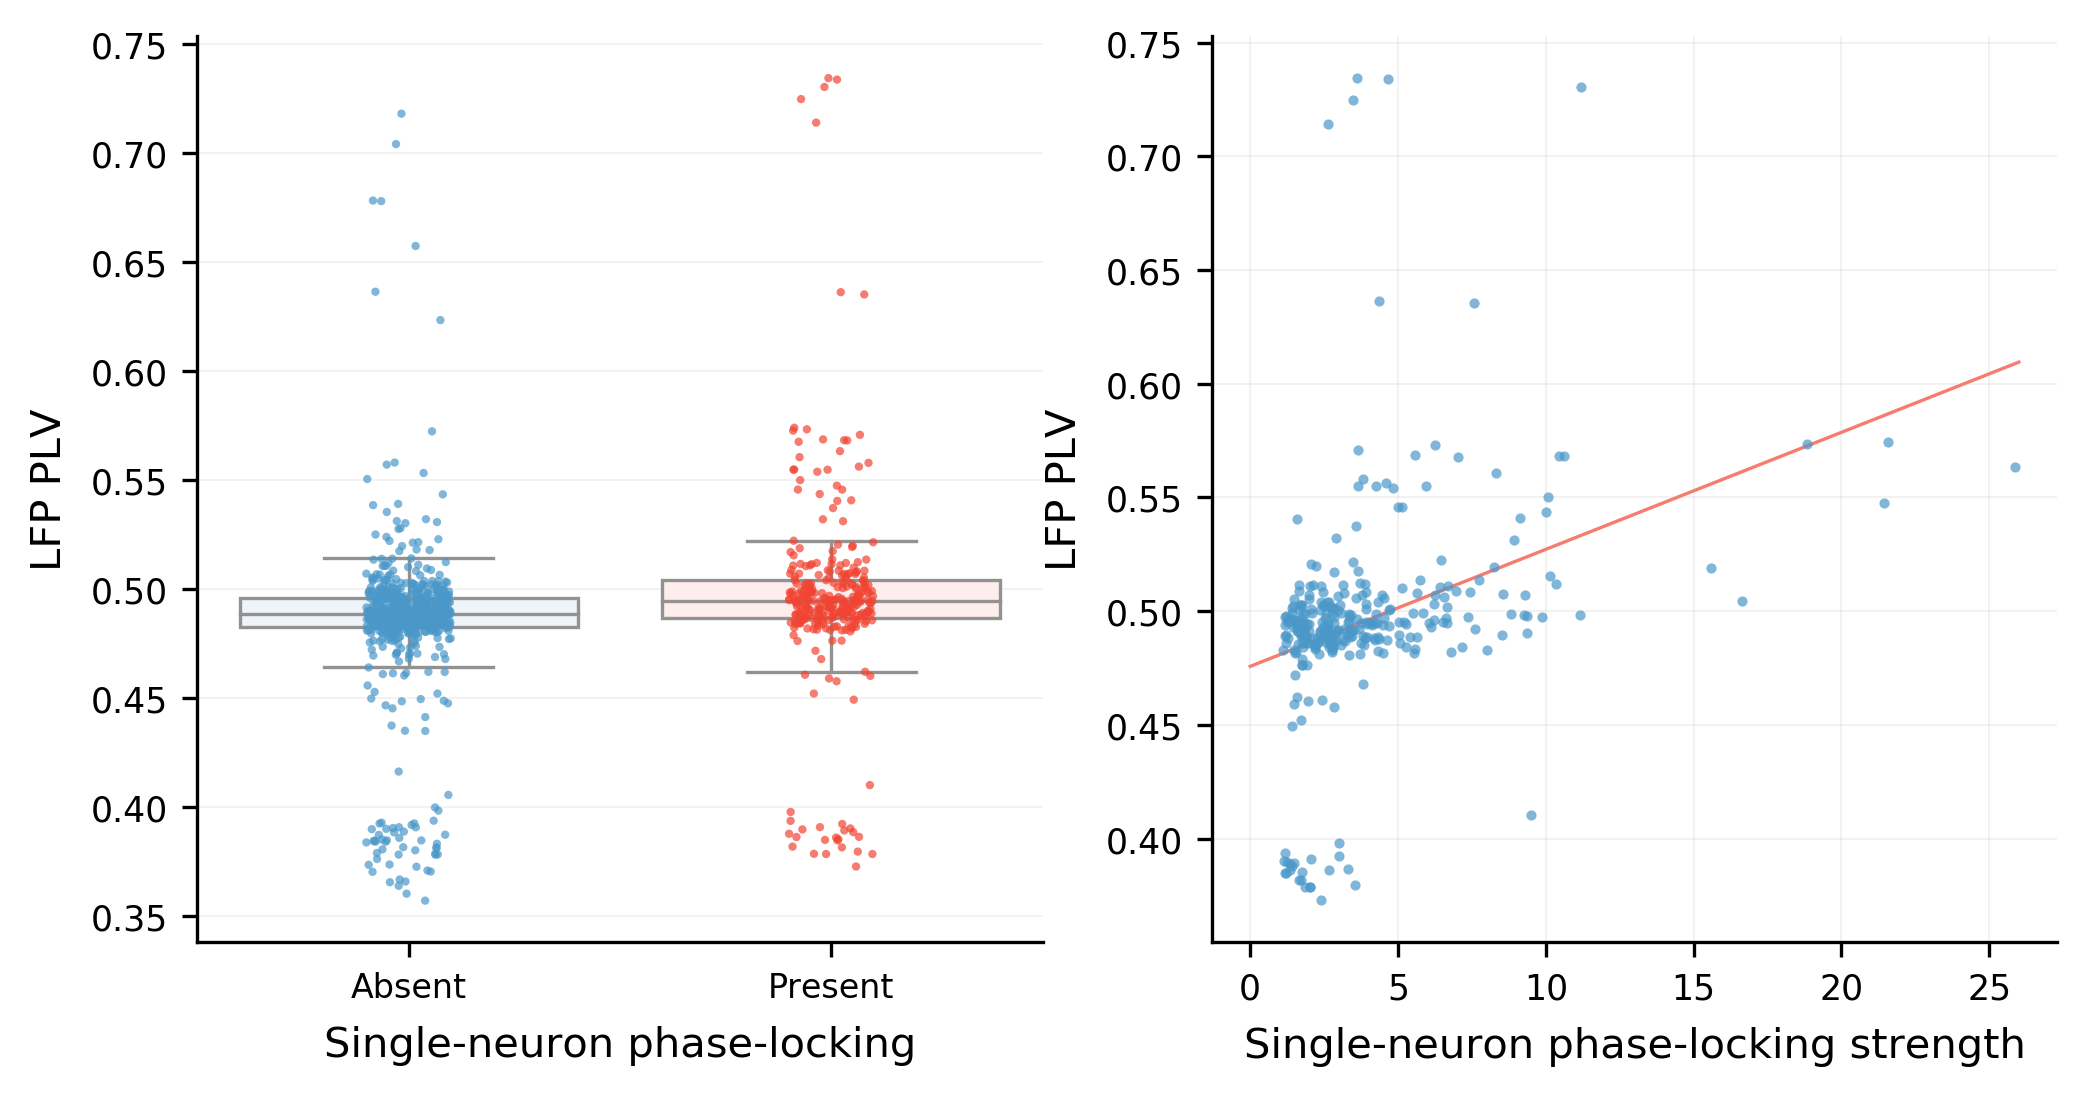

In [171]:
print(stats.ttest_ind(pl_df_.query("(sig_z==True)").locked_plv, pl_df_.query("(sig_z==False)").locked_plv))
print(stats.pearsonr(pl_df_.query("(sig_z==True)").locked_mrl_z, pl_df_.query("(sig_z==True)").locked_plv))

X = sm.add_constant(pl_df_.query("(sig_z==True)").locked_mrl_z.tolist())
y = pl_df_.query("(sig_z==True)").locked_plv.tolist()
intercept, slope = sm.regression.linear_model.OLS(y, X).fit().params

fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.boxplot(x='sig_z', y='locked_plv', data=pl_df_, ax=ax[0],
            palette=(cmap[35], cmap[65]), saturation=1, showfliers=False)
sns.stripplot(x='sig_z', y='locked_plv', data=pl_df_, ax=ax[0],
              palette=colors, size=2, alpha=0.7, dodge=True)
ax[0].set_xticklabels(['Absent', 'Present'], fontsize=8)
ax[0].set_xlabel('Single-neuron phase-locking', fontsize=10, labelpad=5)
ax[0].set_ylabel('LFP PLV', fontsize=10, labelpad=5)

ax[1].plot([0, 26], [intercept, intercept + slope*26], color=colors[1], alpha=0.7, zorder=0)
sns.scatterplot(x='locked_mrl_z', y='locked_plv', data=pl_df_.query("(sig_z==True)"), ax=ax[1],
                color=colors[0], linewidth=0, alpha=0.7, s=6, zorder=1)
ax[1].set_xlabel('Single-neuron phase-locking strength', fontsize=10, labelpad=5)
ax[1].set_ylabel('LFP PLV', fontsize=10, labelpad=5)

Ttest_indResult(statistic=1.2359342860638007, pvalue=0.21679011789303726)
(0.1771877211443678, 0.0017670209593698746)


Text(0,0.5,'LFP PLV')

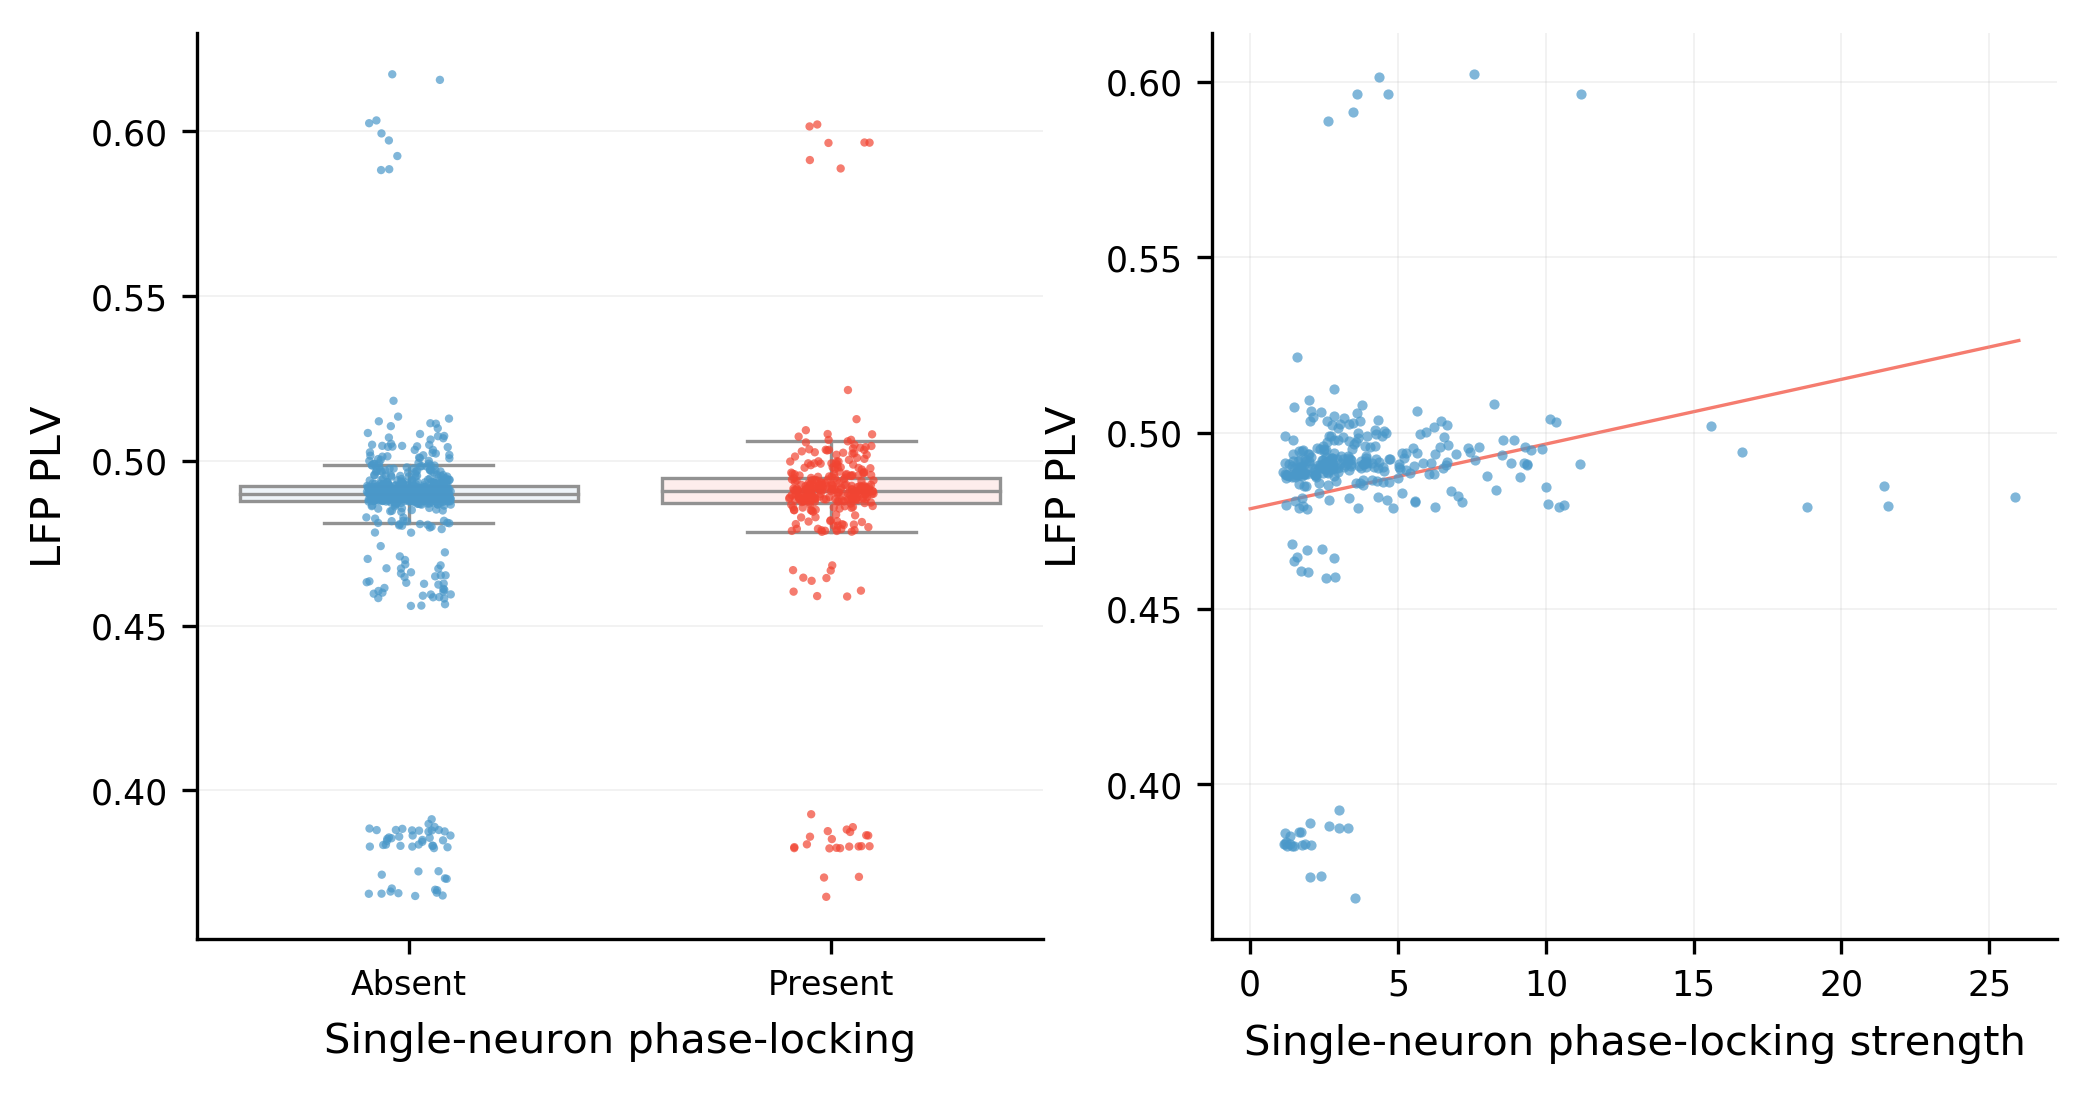

In [172]:
print(stats.ttest_ind(pl_df_.query("(sig_z==True)").nonlocked_plv, pl_df_.query("(sig_z==False)").nonlocked_plv))
print(stats.pearsonr(pl_df_.query("(sig_z==True)").locked_mrl_z, pl_df_.query("(sig_z==True)").nonlocked_plv))

X = sm.add_constant(pl_df_.query("(sig_z==True)").locked_mrl_z.tolist())
y = pl_df_.query("(sig_z==True)").nonlocked_plv.tolist()
intercept, slope = sm.regression.linear_model.OLS(y, X).fit().params

fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.boxplot(x='sig_z', y='nonlocked_plv', data=pl_df_, ax=ax[0],
            palette=(cmap[35], cmap[65]), saturation=1, showfliers=False)
sns.stripplot(x='sig_z', y='nonlocked_plv', data=pl_df_, ax=ax[0],
              palette=colors, size=2, alpha=0.7, dodge=True)
ax[0].set_xticklabels(['Absent', 'Present'], fontsize=8)
ax[0].set_xlabel('Single-neuron phase-locking', fontsize=10, labelpad=5)
ax[0].set_ylabel('LFP PLV', fontsize=10, labelpad=5)

ax[1].plot([0, 26], [intercept, intercept + slope*26], color=colors[1], alpha=0.7, zorder=0)
sns.scatterplot(x='locked_mrl_z', y='nonlocked_plv', data=pl_df_.query("(sig_z==True)"), ax=ax[1],
                color=colors[0], linewidth=0, alpha=0.7, s=6, zorder=1)
ax[1].set_xlabel('Single-neuron phase-locking strength', fontsize=10, labelpad=5)
ax[1].set_ylabel('LFP PLV', fontsize=10, labelpad=5)

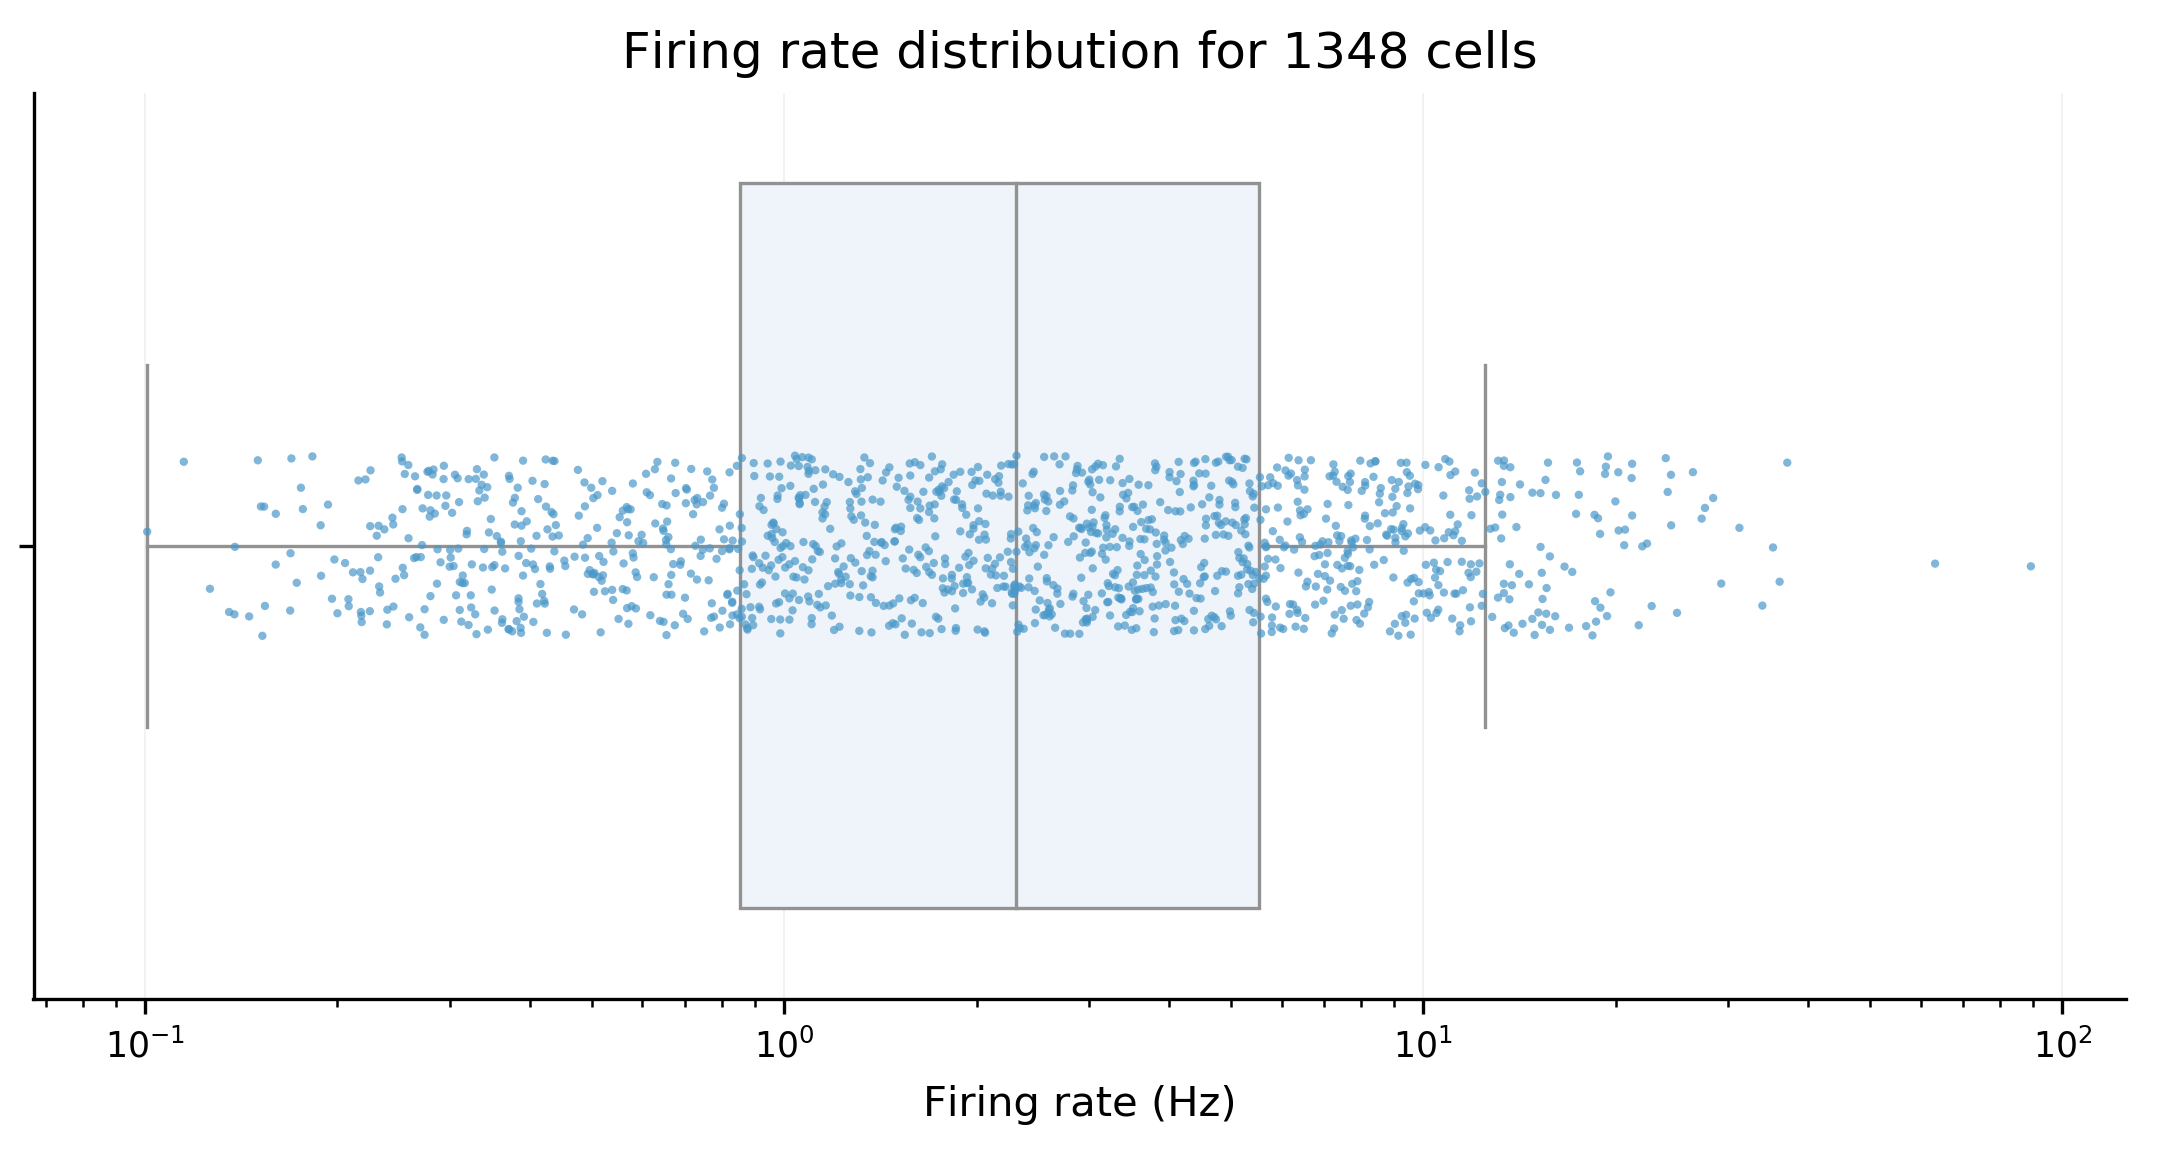

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4), dpi=300)
labelfontsize = 10
figfontsize = 12 

all_frs = pl_df.query("(unit_roi2!='hpc')").groupby('subj_sess_unit').unit_fr.mean()

sns.boxplot(all_frs, color=cmap[35], saturation=1, showfliers=False, ax=ax)
sns.stripplot(all_frs, ax=ax, palette=colors, size=2, alpha=0.7, dodge=True)

ax.set_xlabel('Firing rate (Hz)', labelpad=5, fontsize=labelfontsize)
ax.set_title('Firing rate distribution for {} cells'.format(len(all_frs)), fontsize=figfontsize)
ax.set_xscale('log')
ax.set_xticks([1e-1, 1e0, 1e1, 1e2])

# cmap = sns.palettes.blend_palette((colors[0], 
#                                    sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[45],
#                                    sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[55],
#                                    colors[1]), 101)
# sns.boxplot(x='sig_z', y='nonlocked_plv', data=pl_df_, ax=ax[0],
#             palette=(cmap[35], cmap[65]), saturation=1, showfliers=False)
# sns.stripplot(x='sig_z', y='nonlocked_plv', data=pl_df_, ax=ax[0],
#               palette=colors, size=2, alpha=0.7, dodge=True)


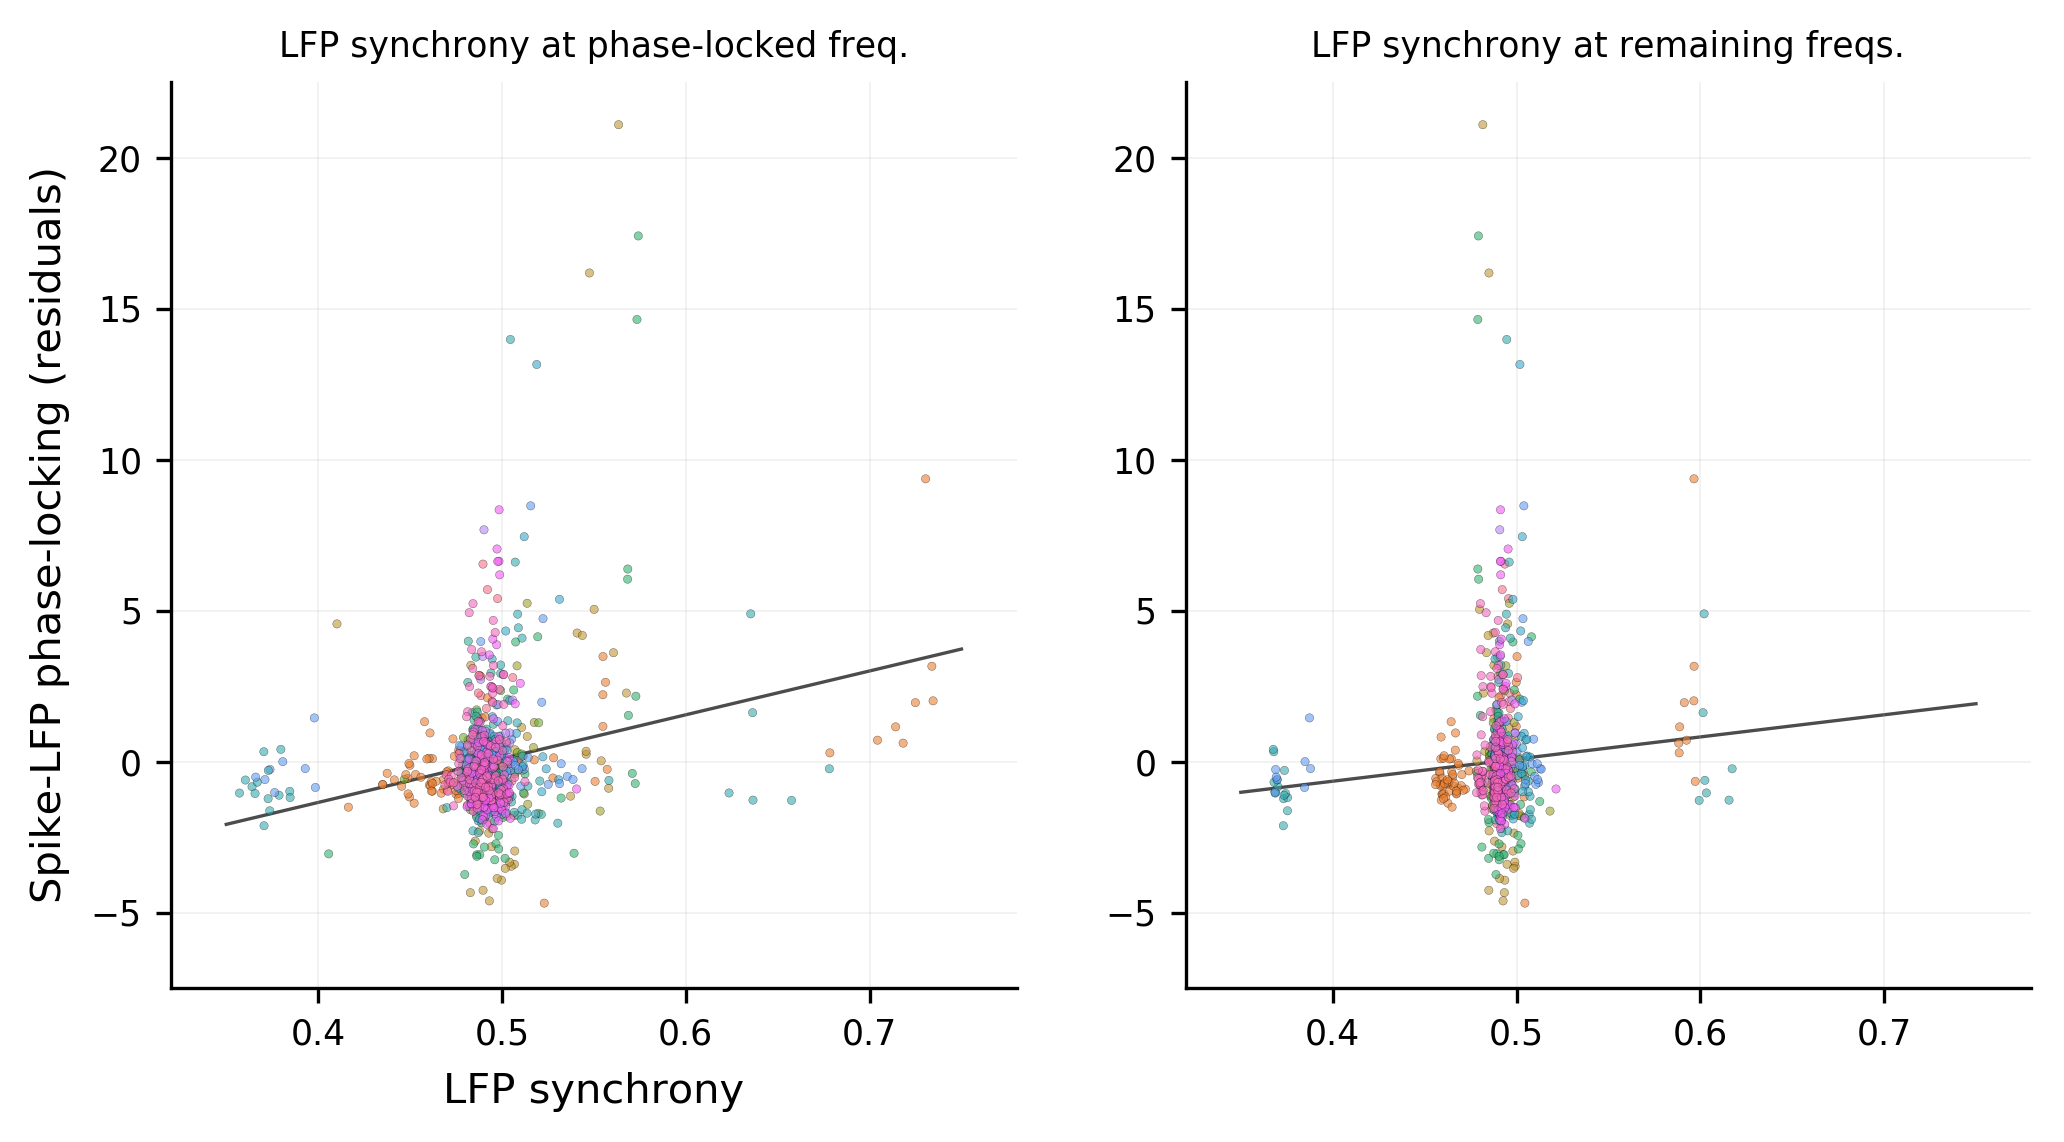

In [754]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

X = sm.add_constant(dat.locked_plv.tolist())
y = dat.null_resid.tolist()
intercept, slope = sm.regression.linear_model.OLS(y, X).fit().params
ax[0].plot([0.35, 0.75], [intercept + slope*0.35, intercept + slope*0.75], color='k', alpha=0.7, zorder=0)
ax[0] = sns.scatterplot(x='locked_plv', y='null_resid', hue='subj_sess', data=dat, ax=ax[0],
                        color=colors[0], linewidth=0.1, edgecolor='k', alpha=0.6, s=4, zorder=1)

ax[0].set_xlabel('LFP synchrony', fontsize=10, labelpad=5)
ax[0].set_ylabel('Spike-LFP phase-locking (residuals)', fontsize=10, labelpad=5)
ax[0].get_legend().remove()
ax[0].set_title('LFP synchrony at phase-locked freq.')

X = sm.add_constant(dat.nonlocked_plv.tolist())
y = dat.null_resid.tolist()
intercept, slope = sm.regression.linear_model.OLS(y, X).fit().params
ax[1].plot([0.35, 0.75], [intercept + slope*0.35, intercept + slope*0.75], color='k', alpha=0.7, zorder=0)
ax[1] = sns.scatterplot(x='nonlocked_plv', y='null_resid', hue='subj_sess', data=dat, ax=ax[1],
                        color=colors[0], linewidth=0.1, edgecolor='k', alpha=0.6, s=4, zorder=1)
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].get_legend().remove()
ax[1].set_title('LFP synchrony at remaining freqs.')

for i in range(len(ax)):
    ax[i].set_xlim([0.32, 0.78])
    ax[i].set_ylim([-7.5, 22.5])

## Older PLV comparisons

In [286]:
# Get the mean phase-locking value across all channel comparisons for each
# unit-to-hippocampal region pair.
plv_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/plvs'
fname = 'epoch_plvs-{}-unit{}-lfp1_chan_ind_{}-lfp2_chan_ind_{}-freq_ind_{}.pkl'
glob_fname = 'epoch_plvs-{}-unit{}-*.pkl'
grouped = get_plv_df.groupby(['subj_sess', 'unit', 'lfp1_hemroi', 'lfp2_hemroi'])
cols = ['subj_sess', 'unit', 'lfp1_hemroi', 'lfp2_hemroi', 'mrl_argmax', 'sig', 'locked_mrl', 'plv']
mean_plvs = []
for name, group in grouped:
    subj_sess, unit, lfp1_hemroi, lfp2_hemroi = name
    upl_df_ = upl_df.query("(subj_sess=='{}') & (unit=='{}') & (lfp_hemroi=='{}')".format(subj_sess, unit, lfp2_hemroi))
    assert len(upl_df_) == 1
    plvs = []
    skip = False
    for index, row in group.iterrows():
        fpath = os.path.join(plv_dir, fname.format(row['subj_sess'], row['unit'], row['lfp1_chan_ind'], row['lfp2_chan_ind'], row['mrl_argmax']))
        if os.path.exists(fpath):
            plvs.append(np.mean(dio.open_pickle(fpath)))
        else:
            skip = True
            break
    if not skip:
        mean_plvs.append([subj_sess, unit, lfp1_hemroi, lfp2_hemroi, 
                          upl_df_['mrl_argmax'].iat[0], upl_df_['sig'].iat[0], 
                          upl_df_['locked_mrl'].iat[0], np.mean(plvs)])
    
mean_plvs = pd.DataFrame(mean_plvs, columns=cols)

In [287]:
upl_df.shape, mean_plvs.shape

((842, 32), (735, 8))

In [294]:
mean_plvs.head()

subj_sess  unit lfp1_hemroi lfp2_hemroi  mrl_argmax    sig  locked_mrl  \
0  U369_env1     0          RA         LMH          15  False    0.103398   
1  U369_env1     0          RA         RMH          12  False    0.054375   
2  U369_env1     1          RA         LMH          11  False    0.108924   
3  U369_env1     1          RA         RMH          12   True    0.039322   
4  U369_env1     2          RA         LMH          10  False    0.111520   

        plv  
0  0.445271  
1  0.714081  
2  0.465028  
3  0.734487  
4  0.449392

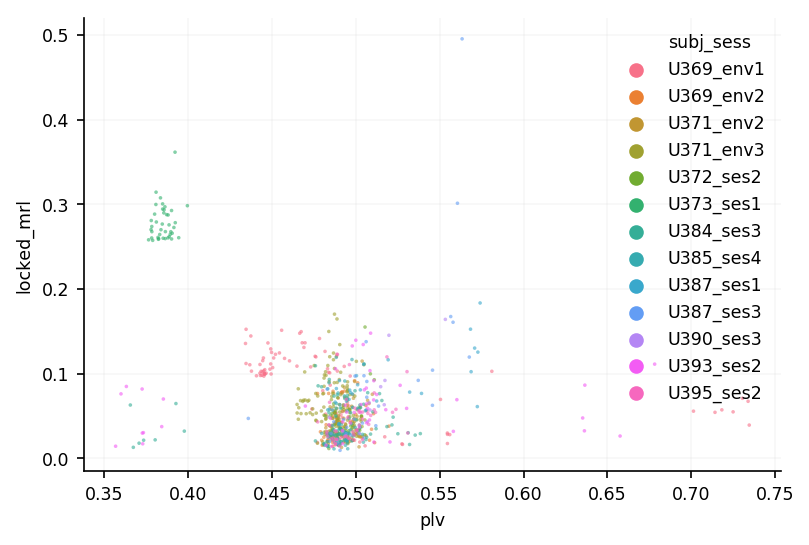

In [312]:
sns.scatterplot(x='plv', y='locked_mrl', hue='subj_sess', data=mean_plvs, linewidth=0, alpha=0.6, s=3)

In [1310]:
start_time = time()

subj_sess, unit, lfp1_chan_ind, lfp2_chan_ind, freq_ind, epoch_size = plv_list[0]
epoch_plvs1 = lfp_synchrony.get_epoch_plvs(subj_sess, unit, lfp1_chan_ind, lfp2_chan_ind, freq_ind, epoch_size*1, remove_secs=5*5, save_outputs=False)

print('Done in {:.2f} secs'.format(time() - start_time))

Done in 0.74 secs


Text(0.5,1,'2000 Hz')

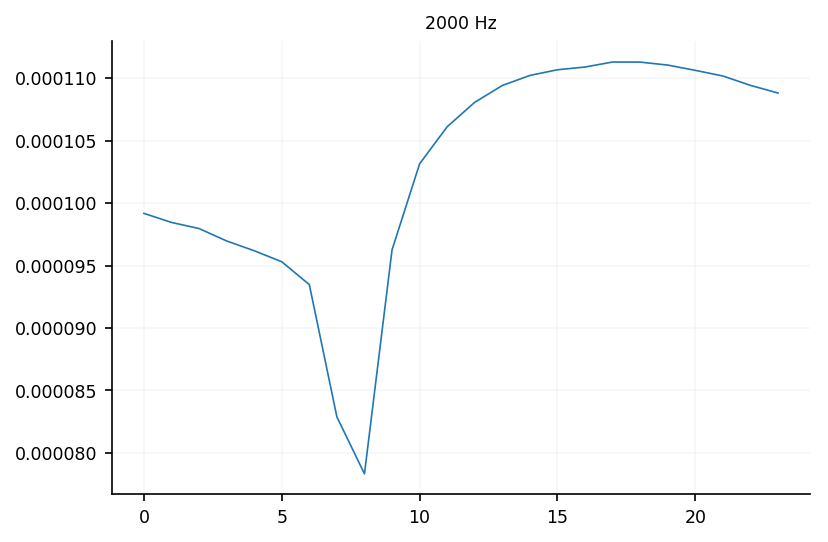

In [28]:
# Plot the spike-triggered average for a given cell.
iCell = 13

spikes_arr = np.array(fr_df['spikes'].tolist())
spikes_arr[:, :4000] = False
spikes_arr[:, -4000:] = False
spike_inds = np.where(spikes_arr)

chans = [int(chan)-1 for chan in fr_df.chan]
chan = chans[iCell]
spike_waveforms = []
spike_inds_ = spike_inds[1][spike_inds[0]==iCell]

ms_before = 4
ms_after = 8
start_offset = int(ms_before * (lfp_preproc.samplerate.data.astype(int)/1000))
stop_offset = int(ms_after * (lfp_preproc.samplerate.data.astype(int)/1000))
for iSpike in range(len(spike_inds_)):
    spike_waveforms.append(lfp_preproc.data[chan, spike_inds_[iSpike]-start_offset:spike_inds_[iSpike]+stop_offset])
    
fig, ax = plt.subplots(1, 1)
ax = np.ravel(ax)

ax[0].plot(np.mean(np.array(spike_waveforms), axis=0))
ax[0].set_title('{} Hz'.format(lfp_preproc.samplerate.data.astype(int)))

In [340]:
phase_vec = pl_df_.bs_mrls.iat[0].flatten()[:1000]

In [341]:
compare_vec = np.arange(1000)
np.random.shuffle(compare_vec)
xsort = compare_vec.argsort()

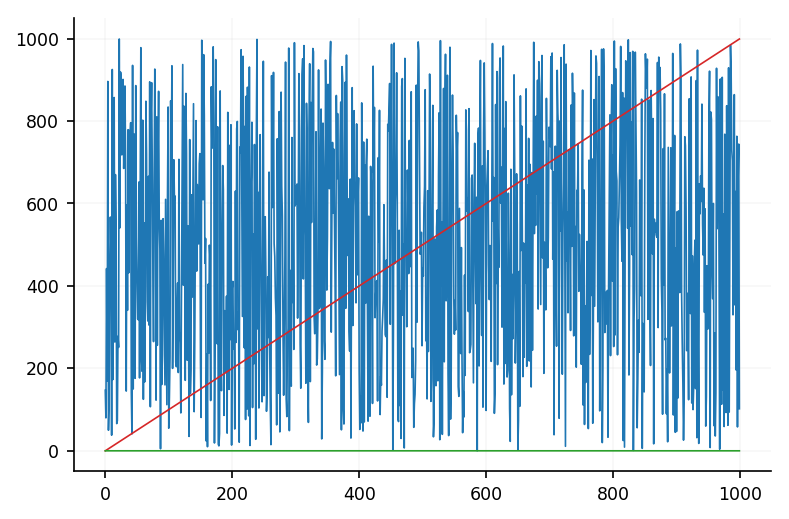

In [343]:
plt.plot(compare_vec)
plt.plot(compare_vec[xsort])
plt.plot(phase_vec)

In [301]:
pl_df_.bs_mrls.iat[0].shape
pl_df_.mrls.iat[0].shape
#pl_df_.bs_mrls.iat[0].flatten()[:1000]

(16,)

In [326]:
v = np.arange(10)
v[len(v)%3:]

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [335]:
np.split(np.arange(100), 4)[1]

array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49])

In [363]:
vec = []
for i in range(1000):
    phase_vec = np.random.rand(1000) * 2 * np.pi
    vec.append(calc_mrl_qtls(phase_vec, compare_vec)[1])

In [367]:
%timeit calc_mrl_qtls(phase_vec, compare_vec)

The slowest run took 4.05 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 515 µs per loop


In [442]:
get_plv_df.head()

subj_sess  unit  unit_chan_ind  lfp1_chan_ind  lfp2_chan_ind lfp1_hemroi  \
0  U372_ses2    23             43             40              8         LPG   
1  U372_ses2    23             43             40              9         LPG   
2  U372_ses2    23             43             40             10         LPG   
3  U372_ses2    23             43             40             11         LPG   
4  U372_ses2    23             43             40             12         LPG   

  lfp2_hemroi  locked_freq_ind    sig  
0         RMH               13  False  
1         RMH               13  False  
2         RMH               13  False  
3         RMH               13  False  
4         RMH               13  False

In [397]:
start_time = time()

info = get_mrl_plv_diffs(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/metadata/get_plv_df_rows',
                                      'get_plv_df-U371_env2-unit0-chan_ind_0-to-chan_ind_16.pkl'),
                         n_bootstraps=5, 
                         sleep_max=0)

print('Done in {:.2f} secs'.format(time() - start_time))

Done in 92.51 secs


In [422]:
info['qtl_mrls_z'] = (info.qtl_mrls - np.mean(info.bs_qtl_mrls, axis=1)) / np.std(info.bs_qtl_mrls, axis=1)
info['mrl_diffs_z'] = info.qtl_mrls_z[:, -1] - info.qtl_mrls_z[:, 0]

In [428]:
info.mrl_diffs_z, info.qtl_mrls_z[:, -1] - info.qtl_mrls_z[:, 0]

(array([ 0.78865552, -1.11413273,  0.77704902, -0.28311582,  2.36999747,
         0.54229324, -3.28851988,  0.08895221,  2.35114579, -1.22004008,
        -0.28050757,  2.14778381, -1.60600077,  1.69294095,  0.34410225,
        -1.08481437]),
 array([ 1.68898229, -3.05556968,  1.48134364, -0.47383615,  2.88427104,
         0.6204323 , -5.63492181,  0.0627842 ,  3.41709489, -2.0064254 ,
        -1.1641464 ,  3.72385472, -2.783044  ,  1.39511081, -0.08829382,
        -1.10132217]))

## Spike-triggered PLVs

In [523]:
start_time = time()

output = lfp_synchrony.get_epoch_plvs_sta(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/metadata/get_plv_df_groups',
                                                       'get_plv_df-U390_ses3-unit_12-to-region_RAH.pkl'))

print('Done in {:.2f} secs'.format(time() - start_time))

Done in 400.82 secs


### run lfp_synchrony.get_epoch_plvs_sta() on all get_plv_df groups...

Files are in /scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/metadata/get_plv_df_groups

In [633]:
# Get the mean phase-locking value across all channel comparisons for each
# unit-to-hippocampal region pair.
start_time = time()

pl_df_sta = pl_df.query("(edge=='ctx-hpc')").reset_index(drop=True)
plv_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/lfp_plvs/plvs/sta'
fname = 'STA-lfp_plvs-{}-unit_{}-to-region_{}-500Hz-notch60_120Hz-nospikeinterp-5cycles-16log10freqs_0.5_to_16.0Hz.pkl'
add_cols = OrderedDict([('plvs', []),
                        ('plvs_z', [])])
drop_rows = []
for index, row in pl_df_sta.iterrows():
    subj_sess = row.subj_sess
    unit = row.unit
    roi = row.lfp_hemroi
    plv_file = os.path.join(plv_dir, fname.format(subj_sess, unit, roi))
    if os.path.exists(plv_file):
        plv_dat = dio.open_pickle(plv_file)
        for key in add_cols.keys():
            add_cols[key].append(plv_dat[key])
    else:
        drop_rows.append(index)
#     if index % 100 == 0 or index == len(pl_df_sta):
#         print('{}: {:.0f} secs'.format(index, time() - start_time))

pl_df_sta = pl_df_sta.drop(index=drop_rows).reset_index(drop=True)
for key in add_cols.keys():
    pl_df_sta[key] = add_cols[key]
    
pl_df_sta['locked_plv'] = pl_df_sta.apply(lambda x: list(x['plvs'][x['locked_freq_ind_z'], :]), axis=1)
pl_df_sta['locked_plv_z'] = pl_df_sta.apply(lambda x: list(x['plvs_z'][x['locked_freq_ind_z'], :]), axis=1)
pl_df_sta['nonlocked_plv'] = pl_df_sta.apply(lambda x: list(np.mean(x['plvs'][[i for i in np.arange(len(freqs)) if i not in [x['locked_freq_ind_z']]], :], axis=0)), axis=1)
pl_df_sta['nonlocked_plv_z'] = pl_df_sta.apply(lambda x: list(np.mean(x['plvs_z'][[i for i in np.arange(len(freqs)) if i not in [x['locked_freq_ind_z']]], :], axis=0)), axis=1)
pl_df_sta['locked_logfreq_z'] = pl_df_sta.locked_freq_ind_z.apply(lambda x: np.log10(freqs)[x])

pl_df_sta['locked_plv'] = pl_df_sta.locked_plv.apply(lambda x: np.array(x))
pl_df_sta['locked_plv_z'] = pl_df_sta.locked_plv_z.apply(lambda x: np.array(x))
pl_df_sta['nonlocked_plv'] = pl_df_sta.nonlocked_plv.apply(lambda x: np.array(x))
pl_df_sta['nonlocked_plv_z'] = pl_df_sta.nonlocked_plv_z.apply(lambda x: np.array(x))

print('Done in {:.2f} secs'.format(time() - start_time))

Done in 9.64 secs


In [634]:
len(pl_df_sta), len(drop_rows)

(948, 0)

In [642]:
sig_locked = np.array(pl_df_sta.query("(sig_z==True)")['locked_plv'].tolist())
insig_locked = np.array(pl_df_sta.query("(sig_z==False)")['locked_plv'].tolist())
sig_nonlocked = np.array(pl_df_sta.query("(sig_z==True)")['nonlocked_plv'].tolist())
insig_nonlocked = np.array(pl_df_sta.query("(sig_z==False)")['nonlocked_plv'].tolist())
sig_locked.shape, insig_locked.shape

((309, 15), (639, 15))

In [652]:
center = [6, 7, 8] # within a half-cycle of the spike
periph = [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14] # more than a half-cycle away from the spike
print('sig_locked:', stats.ttest_rel(np.mean(sig_locked[:, center], axis=-1), np.mean(sig_locked[:, periph], axis=-1)))
print('insig_locked:', stats.ttest_rel(np.mean(insig_locked[:, center], axis=-1), np.mean(insig_locked[:, periph], axis=-1)))
print('sig_nonlocked:', stats.ttest_rel(np.mean(sig_nonlocked[:, center], axis=-1), np.mean(sig_nonlocked[:, periph], axis=-1)))
print('insig_nonlocked:', stats.ttest_rel(np.mean(insig_nonlocked[:, center], axis=-1), np.mean(insig_nonlocked[:, periph], axis=-1)))

print('locked sig vs insig:', 
      stats.ttest_ind(np.mean(sig_locked[:, center], axis=-1) - np.mean(sig_locked[:, periph], axis=-1),
                      np.mean(insig_locked[:, center], axis=-1) - np.mean(insig_locked[:, periph], axis=-1)))
print('sig locked vs nonlocked:', 
      stats.ttest_rel(np.mean(sig_locked[:, center], axis=-1) - np.mean(sig_locked[:, periph], axis=-1),
                      np.mean(sig_nonlocked[:, center], axis=-1) - np.mean(sig_nonlocked[:, periph], axis=-1)))

sig_locked: Ttest_relResult(statistic=3.4853225785509303, pvalue=0.0005629144132199279)
insig_locked: Ttest_relResult(statistic=1.9891527305495036, pvalue=0.047110960482663736)
sig_nonlocked: Ttest_relResult(statistic=3.460263288868311, pvalue=0.0006158133807243827)
insig_nonlocked: Ttest_relResult(statistic=-0.1723140435448152, pvalue=0.8632452896370387)
locked sig vs insig: Ttest_indResult(statistic=1.7168461499866217, pvalue=0.0863346161691023)
sig locked vs nonlocked: Ttest_relResult(statistic=2.496044050841477, pvalue=0.013081371712741128)


Text(0.5,1.02,'Spike-triggered PLV')

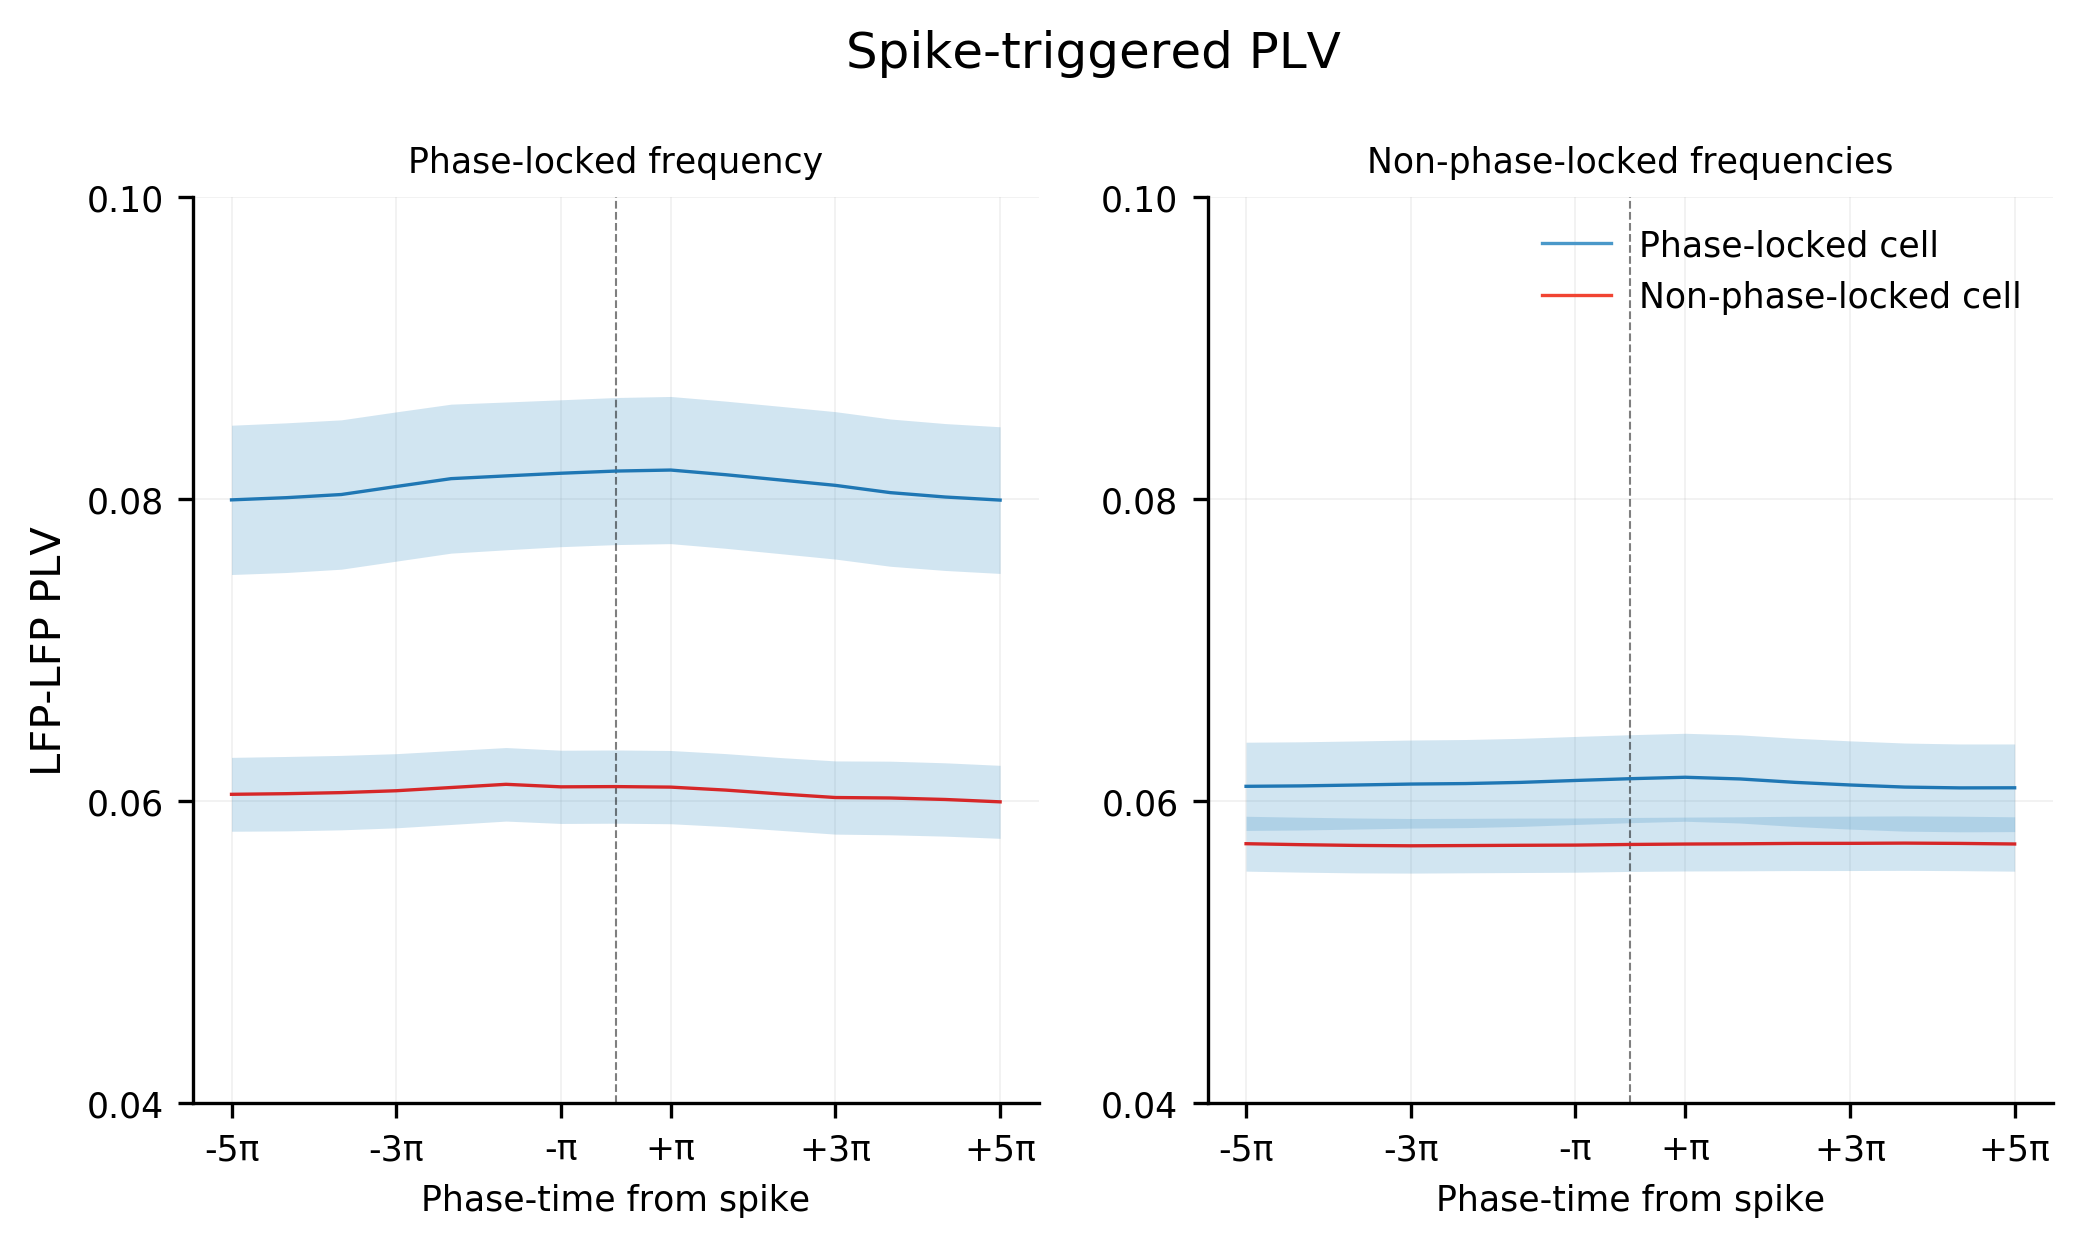

In [657]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

ax[0].plot(np.mean(sig_locked, axis=0))
ax[0].fill_between(np.arange(15), np.mean(sig_locked, axis=0) - stats.sem(sig_locked, axis=0), 
                   np.mean(sig_locked, axis=0) + stats.sem(sig_locked, axis=0),
                   color=colors[0], alpha=0.25, linewidth=0)
ax[0].plot(np.mean(insig_locked, axis=0))
ax[0].fill_between(np.arange(15), np.mean(insig_locked, axis=0) - stats.sem(insig_locked, axis=0), 
                   np.mean(insig_locked, axis=0) + stats.sem(insig_locked, axis=0),
                   color=colors[0], alpha=0.25, linewidth=0)
ax[0].set_ylabel('LFP-LFP PLV', fontsize=10)
ax[0].set_title('Phase-locked frequency')

ax[1].plot(np.mean(sig_nonlocked, axis=0))
ax[1].fill_between(np.arange(15), np.mean(sig_nonlocked, axis=0) - stats.sem(sig_nonlocked, axis=0), 
                   np.mean(sig_nonlocked, axis=0) + stats.sem(sig_nonlocked, axis=0),
                   color=colors[0], alpha=0.25, linewidth=0)
ax[1].plot(np.mean(insig_nonlocked, axis=0))
ax[1].fill_between(np.arange(15), np.mean(insig_nonlocked, axis=0) - stats.sem(insig_nonlocked, axis=0), 
                   np.mean(insig_nonlocked, axis=0) + stats.sem(insig_nonlocked, axis=0),
                   color=colors[0], alpha=0.25, linewidth=0)
ax[1].set_title('Non-phase-locked frequencies')

custom_lines = [Line2D([0], [0], label='Phase-locked cell', color=colors[0]),
                Line2D([0], [0], label='Non-phase-locked cell', color=colors[1])]
legend = ax[1].legend(handles=custom_lines, loc=1)

for i in range(2):
    ax[i].vlines(x=7, ymin=0.04, ymax=0.1, linewidth=0.5, linestyles='--', alpha=0.5)
    ax[i].set_ylim([0.04, 0.1])
    ax[i].set_yticks([0.04, 0.06, 0.08, 0.1])
    ax[i].set_xticks([0, 3, 6, 8, 11, 14])
    ax[i].set_xticklabels(['-5π', '-3π', '-π', '+π', '+3π', '+5π'])
    ax[i].set_xlabel('Phase-time from spike')
    
fig.suptitle('Spike-triggered PLV', fontsize=12, y=1.02)

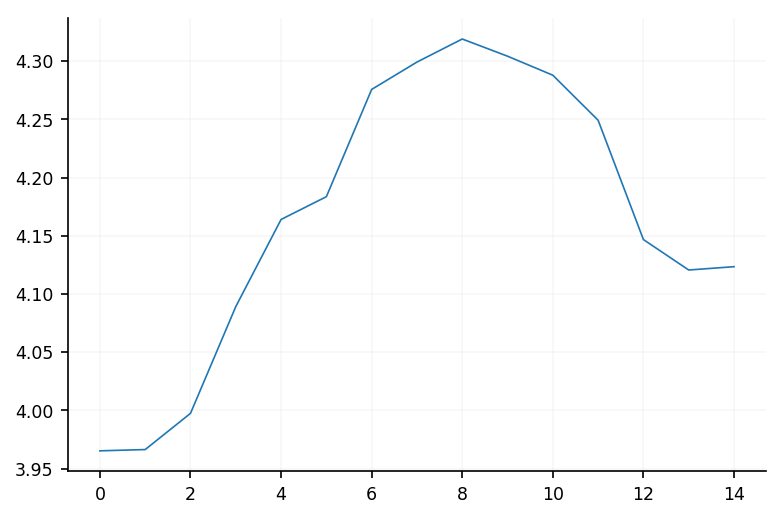

In [656]:
plt.plot([stats.ttest_ind(sig_locked[:, i], insig_locked[:, i])[0] for i in range(15)])

## Predicted results
Qualifying exam, object-location associative recognition task

In [355]:
(500 + 250) / 2

375.0

In [358]:
total = 1000 + 375 + 2000 + 375
print(total)
print(1000/total, 375/total, 2000/total)
print(280 * (1000/total), 280 * (375/total), 280 * (2000/total))
print(75, 75+28, 75+28+149, 75+28+149+28)

3750
0.26666666666666666 0.1 0.5333333333333333
74.66666666666667 28.0 149.33333333333334
75 103 252 280


In [ ]:
sns.barplot(x='cat', y='sig', data=df, palette=colors, saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
ax[0].set_xticklabels(d_.values(), fontsize=tickfontsize)
ax[0].set_ylim([0, .62])
ax[0].set_yticks([.12, .24, .36, .48, .6])
ax[0].set_yticklabels([12, 24, 36, 48, 60], fontsize=tickfontsize)
ax[0].set_xlabel('')
ax[0].set_ylabel('Phase-locking percent', fontsize=labelfontsize, labelpad=5)

In [360]:
tickfontsize = 10
labelfontsize = 12
figfontsize = 14

# HPC vs. local vs. inter-cortical phase-locking rates.
df = (pl_df.query("(same_hem==True) & (edge==['ctx-local', 'ctx-hpc', 'ctx-ctx'])")
      .groupby('edge').agg({'subj_sess_unit': len, 'sig': np.mean}).reset_index())[:3]
d_ = OrderedDict([('ctx-hpc', 'HPC LFP'),
                  ('ctx-local', 'Local LFP'),
                  ('ctx-ctx', 'Intercortical LFP')])
df['cat'] = df.edge.apply(lambda x: d_[x])
df.cat = df.cat.astype('category').cat.reorder_categories(d_.values(), ordered=True)

sns.barplot(x='cat', y='sig', data=df, palette=colors, saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
ax[0].set_xticklabels(d_.values(), fontsize=tickfontsize)
ax[0].set_ylim([0, .62])
ax[0].set_yticks([.12, .24, .36, .48, .6])
ax[0].set_yticklabels([12, 24, 36, 48, 60], fontsize=tickfontsize)
ax[0].set_xlabel('')
ax[0].set_ylabel('Phase-locking percent', fontsize=labelfontsize, labelpad=5)

Text(64,0.5,'Phase-locking percent')

In [373]:
df

task  plr
0   Encoding   32
1  Retrieval   32
2  Attention   25

In [387]:
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c]]

In [121]:
colors_ = [sns.color_palette('Blues', 4)[2], 
           sns.color_palette('Blues', 4)[0],
           sns.color_palette('Reds', 4)[2], 
           sns.color_palette('Reds', 4)[0]]

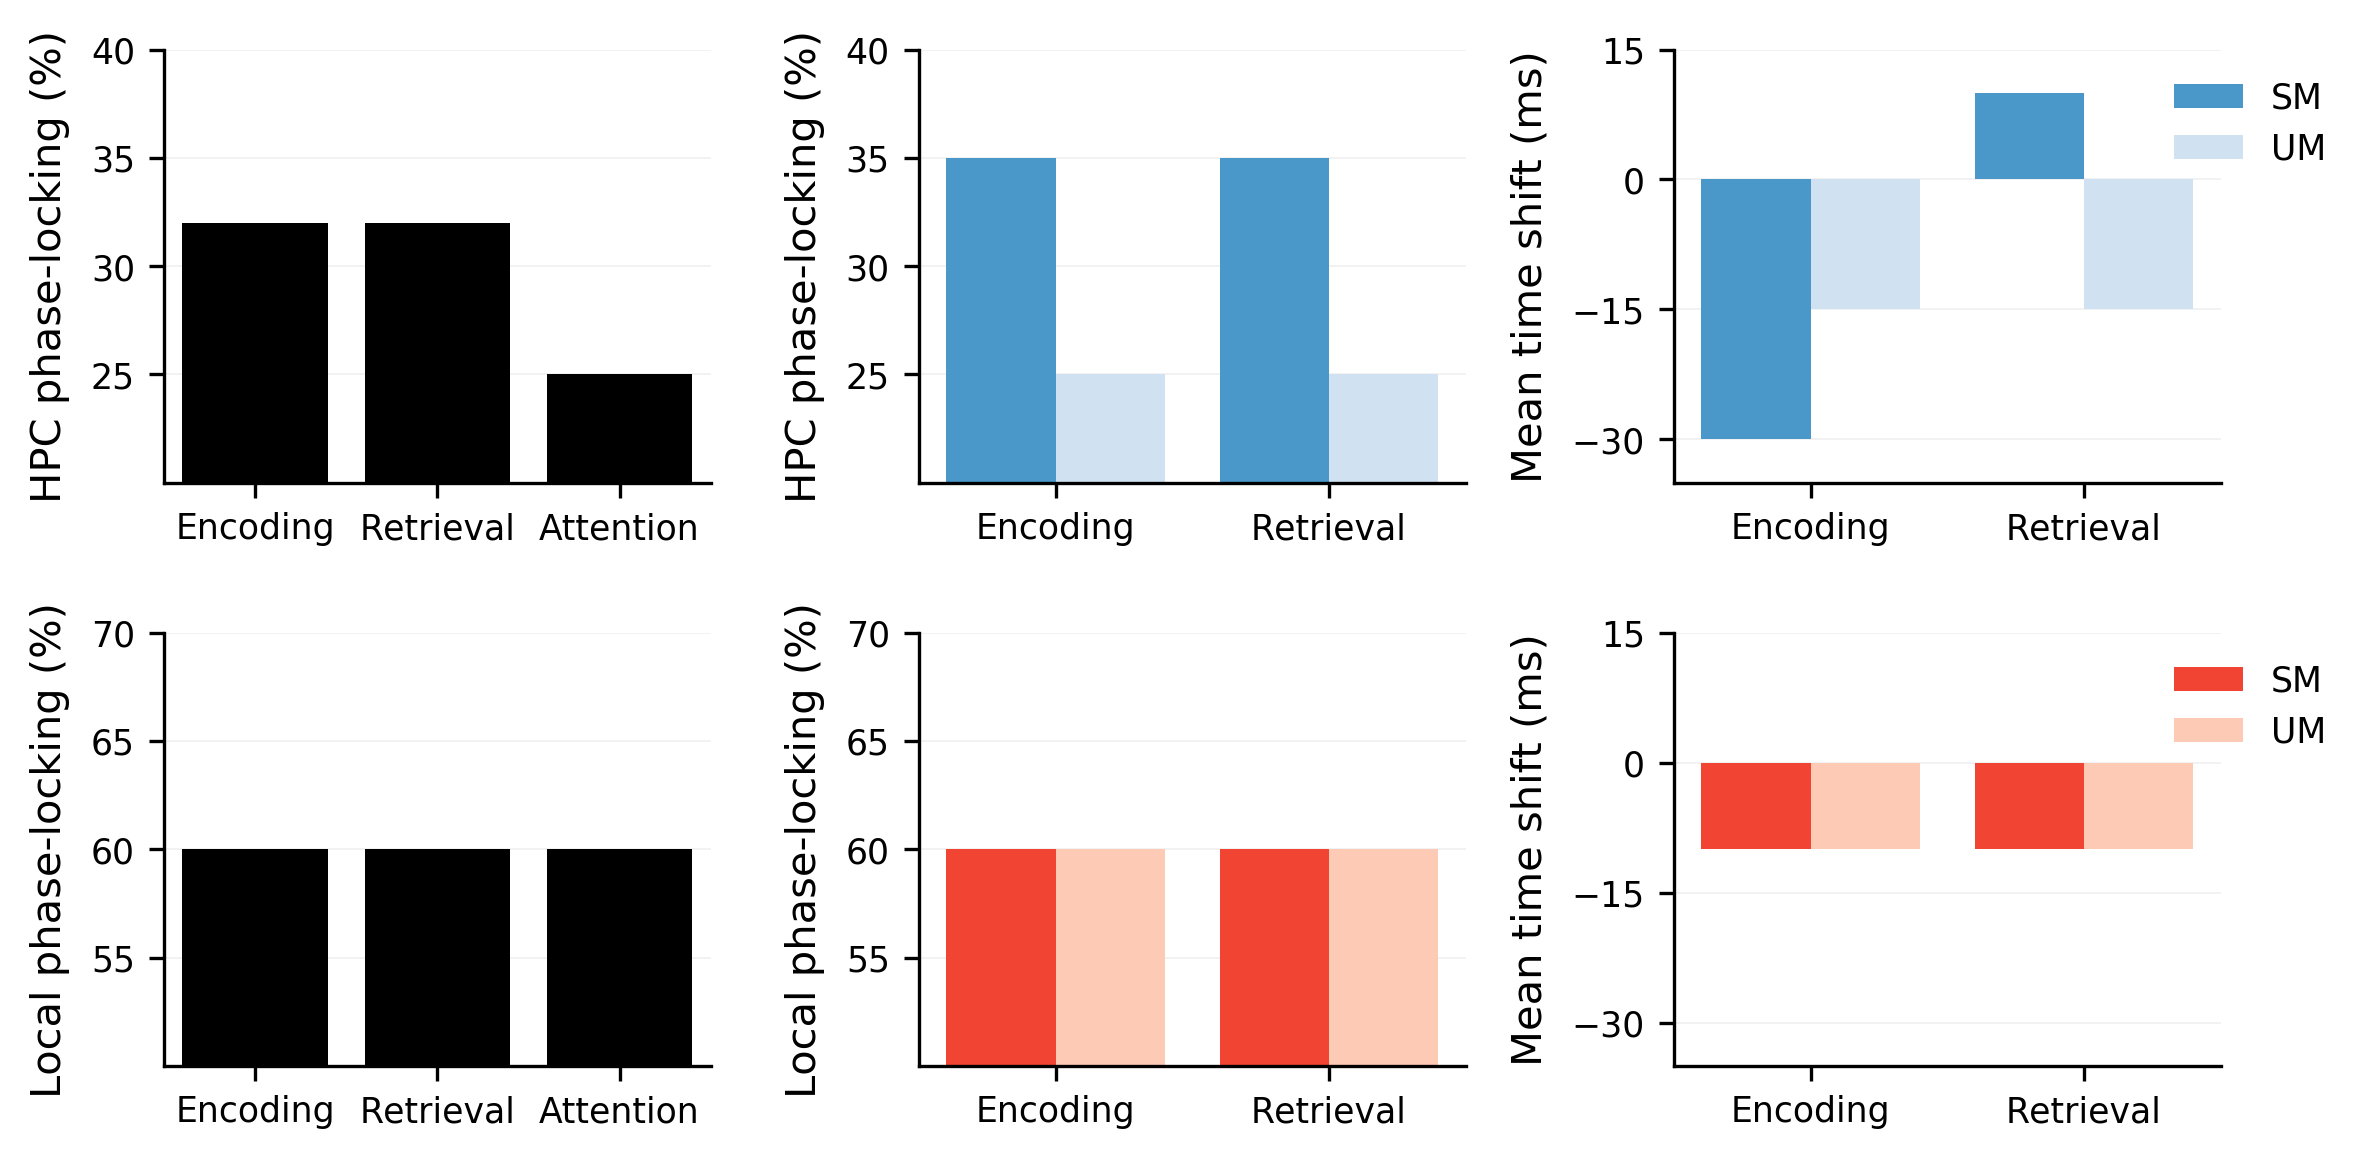

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 10
figfontsize = 14

# Plot 1
df = pd.DataFrame([('Encoding', 32),
                   ('Retrieval', 32),
                   ('Attention', 25)],
                  columns=['task', 'plr'])
sns.barplot(x='task', y='plr', data=df, color='k', saturation=100, ax=ax[0])
ax[0].set_ylim([20, 40])
ax[0].set_yticks([25, 30, 35, 40])

# Plot 2
df = pd.DataFrame([('Encoding', 'SM', 35),
                   ('Encoding', 'UM', 25),
                   ('Retrieval', 'SM', 35),
                   ('Retrieval', 'UM', 25)],
                  columns=['task', 'success', 'plr'])
sns.barplot(x='task', y='plr', data=df, hue='success', 
            palette=[sns.color_palette('Blues', 4)[2], sns.color_palette('Blues', 4)[0]], 
            saturation=100, ax=ax[1])
ax[1].set_ylim([20, 40])
ax[1].set_yticks([25, 30, 35, 40])

# Plot 3
df = pd.DataFrame([('Encoding', 'SM', -30),
                   ('Encoding', 'UM', -15),
                   ('Retrieval', 'SM', 10),
                   ('Retrieval', 'UM', -15)],
                  columns=['task', 'success', 'plr'])
sns.barplot(x='task', y='plr', data=df, hue='success', 
            palette=[sns.color_palette('Blues', 4)[2], sns.color_palette('Blues', 4)[0]], 
            saturation=100, ax=ax[2])
ax[2].set_ylim([-35, 15])
ax[2].set_yticks([-30, -15, 0, 15])

# Plot 4
df = pd.DataFrame([('Encoding', 60),
                   ('Retrieval', 60),
                   ('Attention', 60)],
                  columns=['task', 'plr'])
sns.barplot(x='task', y='plr', data=df, color='k', saturation=100, ax=ax[3])
ax[3].set_ylim([50, 70])
ax[3].set_yticks([55, 60, 65, 70])

# Plot 5
df = pd.DataFrame([('Encoding', 'SM', 60),
                   ('Encoding', 'UM', 60),
                   ('Retrieval', 'SM', 60),
                   ('Retrieval', 'UM', 60)],
                  columns=['task', 'success', 'plr'])
sns.barplot(x='task', y='plr', data=df, hue='success', 
            palette=[sns.color_palette('Reds', 4)[2], sns.color_palette('Reds', 4)[0]], 
            saturation=100, ax=ax[4])
ax[4].set_ylim([50, 70])
ax[4].set_yticks([55, 60, 65, 70])

# Plot 6
df = pd.DataFrame([('Encoding', 'SM', -10),
                   ('Encoding', 'UM', -10),
                   ('Retrieval', 'SM', -10),
                   ('Retrieval', 'UM', -10)],
                  columns=['task', 'success', 'plr'])
sns.barplot(x='task', y='plr', data=df, hue='success', 
            palette=[sns.color_palette('Reds', 4)[2], sns.color_palette('Reds', 4)[0]], 
            saturation=100, ax=ax[5])
ax[5].set_ylim([-35, 15])
ax[5].set_yticks([-30, -15, 0, 15])


for i in range(6):
    ax[i].set_xlabel('')
for i in [0, 1]:
    ax[i].set_ylabel('HPC phase-locking (%)', fontsize=labelfontsize, labelpad=5)
for i in [3, 4]:
    ax[i].set_ylabel('Local phase-locking (%)', fontsize=labelfontsize, labelpad=5)
for i in [2, 5]:
    ax[i].set_ylabel('Mean time shift (ms)', fontsize=labelfontsize, labelpad=5)
for i in [1, 4]:
    leg = ax[i].legend()
    leg.set_visible(False)
for i in [2, 5]:
    leg = ax[i].legend(loc=1, bbox_to_anchor=(1.25, 1))
    leg.set_title('')

# custom_lines = [Line2D([0], [0], label='Local LFP', color=colors[0], linewidth=1.5),
#                 Line2D([0], [0], label='HPC LFP', color=colors[1], linewidth=1.5)]
# legend = ax[1].legend(handles=custom_lines, loc=1)

fig.tight_layout(pad=1.08, w_pad=1, rect=[0, 0, 1, 1])
plt.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/BehavPred1.eps', format='eps', dpi=300, bbox_inches='tight')

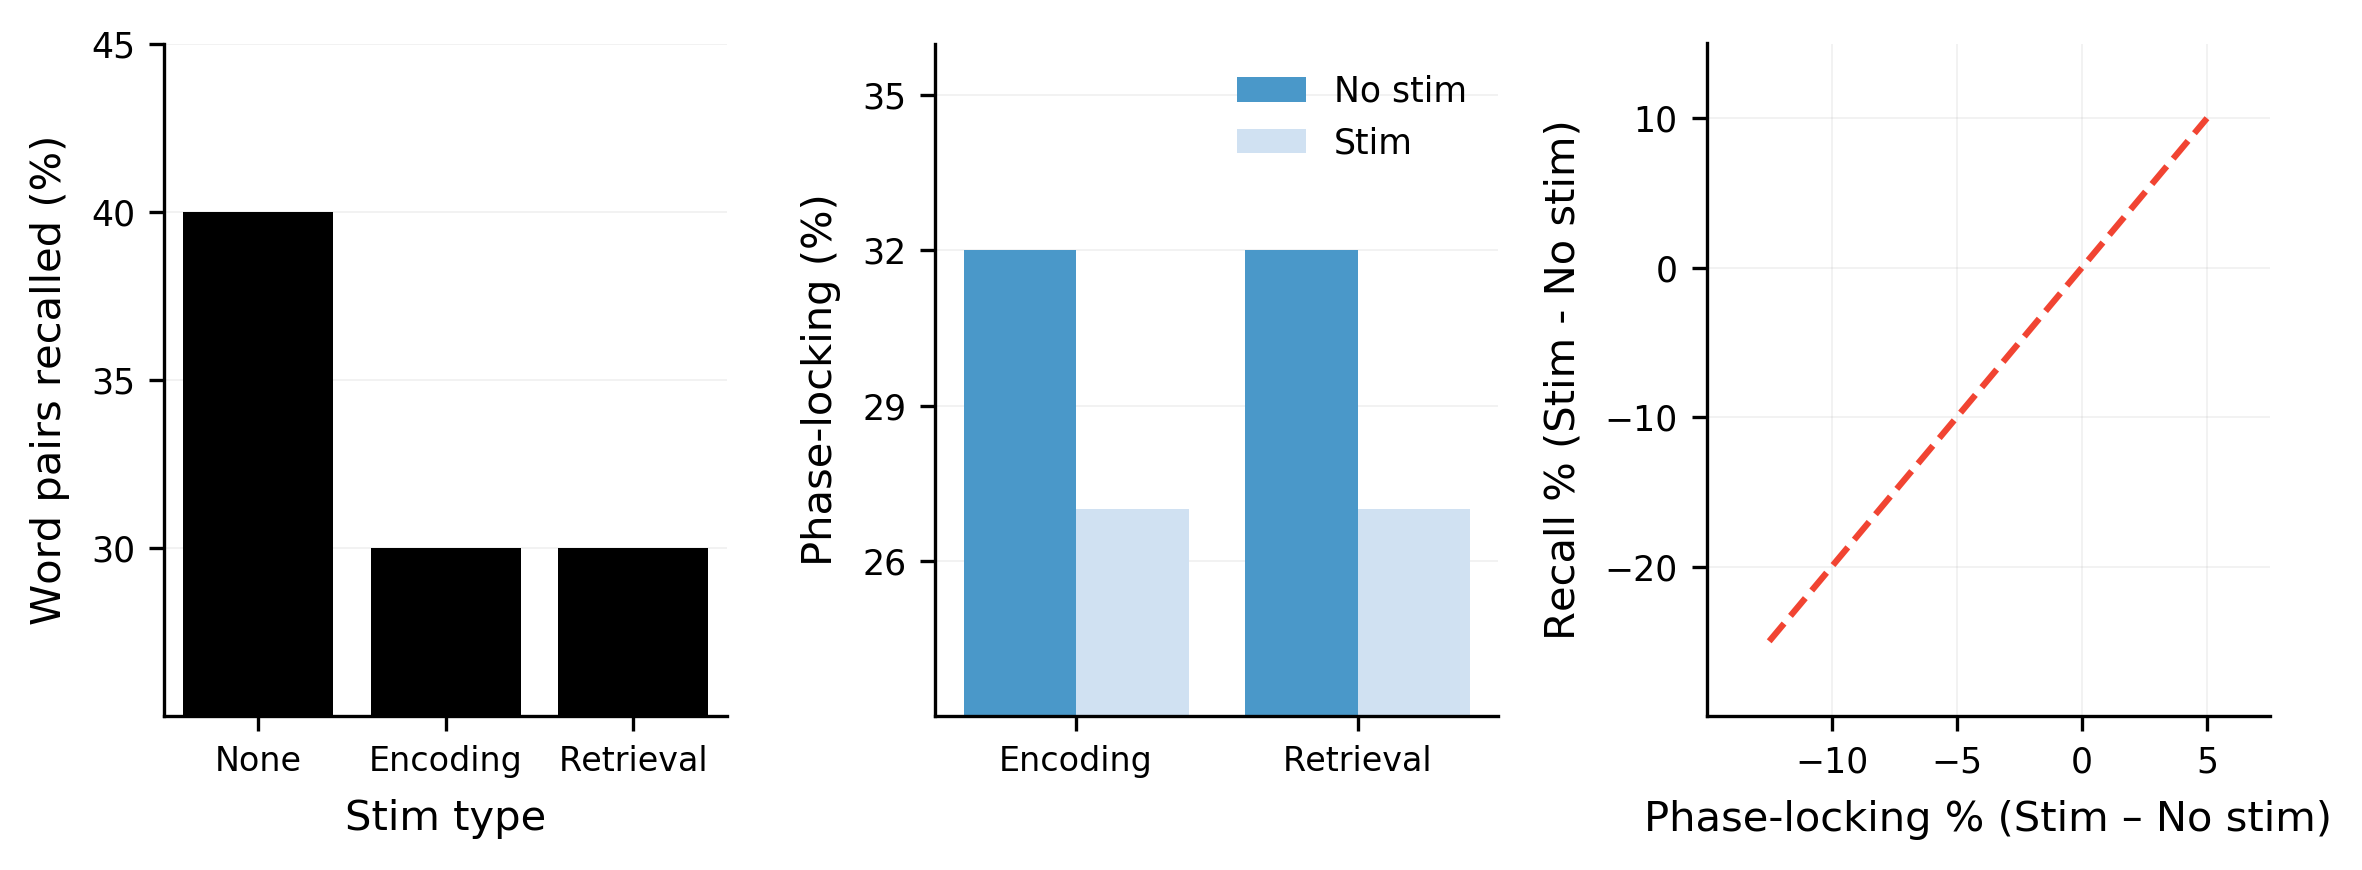

In [478]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), dpi=300)
ax = np.ravel(ax)

tickfontsize = 8
labelfontsize = 10
figfontsize = 14

# Plot 1
df = pd.DataFrame([('No stim.', 40),
                   ('Encoding stim.', 30),
                   ('Retrieval stim.', 30)],
                  columns=['task', 'mem'])
sns.barplot(x='task', y='mem', data=df, color='k', saturation=100, ax=ax[0])
ax[0].set_ylim([25, 45])
ax[0].set_yticks([30, 35, 40, 45])
ax[0].set_xticklabels(['None', 'Encoding', 'Retrieval'], fontsize=tickfontsize)
ax[0].set_xlabel('Stim type', fontsize=labelfontsize, labelpad=5)
ax[0].set_ylabel('Word pairs recalled (%)', fontsize=labelfontsize, labelpad=5)

# Plot 2
df = pd.DataFrame([('Encoding', 'No stim', 32),
                   ('Encoding', 'Stim', 27),
                   ('Retrieval', 'No stim', 32),
                   ('Retrieval', 'Stim', 27)],
                  columns=['task', 'stim', 'plr'])
sns.barplot(x='task', y='plr', data=df, hue='stim', 
            palette=[sns.color_palette('Blues', 4)[2], sns.color_palette('Blues', 4)[0]], 
            saturation=100, ax=ax[1])
ax[1].set_ylim([23, 36])
ax[1].set_yticks([26, 29, 32, 35])
ax[1].set_xticklabels(['Encoding', 'Retrieval'], fontsize=tickfontsize)
ax[1].set_xlabel('')
ax[1].set_ylabel('Phase-locking (%)', fontsize=labelfontsize, labelpad=5)
leg = ax[1].legend(loc=1, bbox_to_anchor=(1, 1))
leg.set_title('')
    
# custom_lines = [Line2D([0], [0], label='Stim.', color=colors[0], linewidth=1.5),
#                 Line2D([0], [0], label='No stim.', color=colors[1], linewidth=1.5)]
# legend = ax[1].legend(handles=custom_lines, loc=1)

# Plot 3
x = np.linspace(-12.5, 5, 100)
y = 2*x
ax[2].plot(x, y, color=colors[1], linewidth=1.5, linestyle='--')
ax[2].set_xlim([-15, 7.5])
ax[2].set_ylim([-30, 15])
ax[2].set_xticks([-10, -5, 0, 5])
ax[2].set_yticks([-20, -10, 0, 10])
ax[2].set_xlabel('Phase-locking % (Stim – No stim)', fontsize=labelfontsize, labelpad=5)
ax[2].set_ylabel('Recall % (Stim - No stim)', fontsize=labelfontsize, labelpad=5)

# for i in range(1, 6):
#     ax[i].set_xlabel('')
# for i in [0, 1, 3, 4]:
#     ax[i].set_ylabel('Phase-locking (%)')
# for i in [2, 5]:
#     ax[i].set_ylabel('Mean time shift (ms)')
# for i in [1, 4]:
#     leg = ax[i].legend()
#     leg.set_visible(False)
# for i in [2, 5]:
#     leg = ax[i].legend(loc=1, bbox_to_anchor=(1.25, 1))
#     leg.set_title('')

# custom_lines = [Line2D([0], [0], label='Local LFP', color=colors[0], linewidth=1.5),
#                 Line2D([0], [0], label='HPC LFP', color=colors[1], linewidth=1.5)]
# legend = ax[1].legend(handles=custom_lines, loc=1)

fig.tight_layout(pad=1.08, w_pad=1, rect=[0, 0, 1, 1])
plt.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/StimPred.eps', format='eps', dpi=300, bbox_inches='tight')